# Imports and setup

In [1]:
# Basic
import numpy as np
import scipy
import scipy.stats
import os
import itertools
import warnings
import sys
from copy import deepcopy

# Data Loading
import cmlreaders as cml #Penn Computational Memory Lab's library of data loading functions

# Data Handling
import os
from os import listdir as ld
import os.path as op
from os.path import join, exists as ex
import time
import datetime

# Data Analysis
import pandas as pd
import xarray as xr

# EEG & Signal Processing
import ptsa
from ptsa.data.readers import BaseEventReader, EEGReader, CMLEventReader, TalReader
from ptsa.data.filters import MonopolarToBipolarMapper, MorletWaveletFilter
from ptsa.data.timeseries import TimeSeries

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Parallelization
import cmldask.CMLDask as da
from cmldask.CMLDask import new_dask_client_slurm as cl, get_exceptions as get_ex
import cmldask

# Custom
from cstat import * #circular statistics
from misc import * #helper functions for loading and saving data, and for other purposes
from matrix_operations import * #matrix operations

%load_ext autoreload

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

beh_to_event_windows = {'en': [250-1000, 1250+1000],
                     'en_all': [250-1000, 1250+1000],
                     'rm': [-1000, 0],
                     'ri': [-1000, 0]}

beh_to_epochs = {'en': np.arange(250, 1250, 200),
              'en_all': np.arange(250, 1250, 200),
              'rm': np.arange(-1000, 0, 200),
              'ri': np.arange(-1000, 0, 200)}


#Set the following root_dir
root_dir = '/scratch/amrao/retrieval_connectivity'

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ptsa/data/readers/__init__.py:19: FutureWarning: PTSA readers will be removed in a future release. Please consider using the cmlreaders package instead: https://github.com/pennmem/cmlreaders
  FutureWarning
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later

In [2]:
import shutil
for f1 in ['en', 'en_all', 'rm', 'ri']:
#     path = join(root_dir, f1)
#     if ex(path): shutil.rmtree(path)
#     for f2 in ['events', 'elsymxs', 'regsymxs', 'elpomxs', 'regpomxs']:
    # for f2 in ['elsymxs', 'regsymxs', 'elpomxs', 'regpomxs']:
    for f2 in ['elpomxs', 'regpomxs']:
        path = join(root_dir, f1, f2)
        if ex(path): shutil.rmtree(path)
# path = join(root_dir, 'data_check')
# if ex(path): shutil.rmtree(path)
# path = join(root_dir, 'behavioral_stats')
# if ex(path): shutil.rmtree(path)
# path = join(root_dir, 'electrode_information')
# if ex(path): shutil.rmtree(path)

In [2]:
# os.mkdir(root_dir)
for f1 in ['en', 'en_all', 'rm', 'ri']:
    path = join(root_dir, f1)
    if not ex(path): os.mkdir(path)
    for f2 in ['eeg', 'events', 'elsymxs', 'regsymxs']:
        path = join(root_dir, f1, f2)
        if not ex(path): os.mkdir(path)
    for f2 in ['elpomxs', 'regpomxs']:
        path = join(root_dir, f1, f2)
        if not ex(path): os.mkdir(path)
        for f3 in ['theta', 'gamma']:
            path = join(root_dir, f1, f2, f3)
            if not ex(path): os.mkdir(path)
path = join(root_dir, 'data_check')
if not ex(path): os.mkdir(path)
path = join(root_dir, 'behavioral_stats')
if not ex(path): os.mkdir(path)
path = join(root_dir, 'electrode_information')
if not ex(path): 
    os.mkdir(path)
    os.mkdir(join(path, 'pairs'))
    os.mkdir(join(path, 'localization'))

# Create dataset

## Initialize dataset

"ethan_subject_list," etc. refers to the subject list used by Ethan A. Solomon in his 2017 Nature Communications paper, "Widespread theta synchrony underlies enhanced cognition," and it was taken from the publicly available code for that paper.

The initial dataset was created by checking the CMLReaders data index for all pyFR, catFR1, and FR1 sessions (all delayed free recall sessions collected by the Penn Computational Memory Lab). Just in case, the presumed session list (see code) that Ethan Solomon used for his 2017 paper was appended as well.

The sessions were then checked to ensure that all necessary data, including the behavioral events, EEG data, and electrode contact locations, were available and unproblematic.

In [4]:
ethan_subject_list = [['R1031M', 'FR1'],['R1033D', 'FR1'],['R1042M', 'FR1'],['R1044J', 'FR1'],['R1039M', 'FR1'],['R1048E', 'FR1'],['R1035M', 'FR1'],['R1030J', 'FR1'],['R1050M', 'FR1'],['R1053M', 'FR1'],['R1036M', 'FR1'],['R1018P', 'FR1'],['R1020J', 'FR1'],['R1026D', 'FR1'],['R1032D', 'FR1'],['R1056M', 'FR1'],['R1002P', 'FR1'],['R1027J', 'FR1'],['R1045E', 'FR1'],['R1057E', 'FR1'],['R1063C', 'FR1'],['R1001P', 'FR1'],['R1003P', 'FR1'],['R1015J', 'FR1'],['R1049J', 'FR1'],['R1022J', 'FR1'],['R1074M', 'FR1'],['R1069M', 'FR1'],['R1076D', 'FR1'],['R1102P', 'FR1'],['R1023J', 'FR1'],['R1155D', 'FR1'],['R1162N', 'FR1'],['R1086M', 'FR1'],['R1149N', 'FR1'],['R1034D', 'FR1'],['R1051J', 'FR1'],['R1159P', 'FR1'],['R1101T', 'FR1'],['R1178P', 'FR1'],['R1104D', 'FR1'],['R1089P', 'FR1'],['R1105E', 'FR1'],['R1060M', 'FR1'],['R1186P', 'FR1'],['R1112M', 'FR1'],['R1202M', 'FR1'],['R1066P', 'FR1'],['R1084T', 'FR1'],['R1096E', 'FR1'],['R1176M', 'FR1'],['R1187P', 'FR1'],['R1169P', 'FR1'],['R1081J', 'FR1'],['R1006P', 'FR1'],['R1164E', 'FR1'],['R1196N', 'FR1'],['R1127P', 'FR1'],['R1010J', 'FR1'],['R1175N', 'FR1'],['R1148P', 'FR1'],['R1203T', 'FR1'],['R1193T', 'FR1'],['R1167M', 'FR1'],['R1075J', 'FR1'],['R1177M', 'FR1'],['R1080E', 'FR1'],['R1161E', 'FR1'],['R1068J', 'FR1'],['R1054J', 'FR1'],['R1195E', 'FR1'],['R1189M', 'FR1'],['R1131M', 'FR1'],['R1200T', 'FR1'],['R1100D', 'FR1'],['R1142N', 'FR1'],['R1114C', 'FR1'],['R1247P', 'FR1'],['R1128E', 'FR1'],['R1138T', 'FR1'],['R1059J', 'FR1'],['R1067P', 'FR1'],['R1215M', 'FR1'],['R1111M', 'FR1'],['R1171M', 'FR1'],['R1106M', 'FR1'],['R1129D', 'FR1'],['R1146E', 'FR1'],['R1098D', 'FR1'],['R1130M', 'FR1'],['R1115T', 'FR1'],['R1150J', 'FR1'],['R1173J', 'FR1'],['R1154D', 'FR1'],['R1136N', 'FR1'],['R1137E', 'FR1'],['R1204T', 'FR1'],['R1174T', 'FR1'],['R1230J', 'FR1'],['R1122E', 'FR1'],['R1229M', 'FR1'],['R1158T', 'FR1'],['R1163T', 'FR1'],['R1250N', 'FR1'],['R1147P', 'FR1'],['R1166D', 'FR1'],['R1241J', 'FR1'],['R1123C', 'FR1'],['R1120E', 'FR1'],['R1083J', 'FR1'],['R1113T', 'FR1'],['R1226D', 'FR1'],['R1228M', 'FR1'],['R1062J', 'FR1'],['R1232N', 'FR1'],['R1217T', 'FR1'],['R1151E', 'FR1'],['R1070T', 'FR1'],['R1121M', 'FR1'],['R1222M', 'FR1'],['R1168T', 'FR1'],['R1172E', 'FR1'],['R1223E', 'FR1'],['R1134T', 'FR1'],['R1077T', 'FR1'],['R1094T', 'FR1'],['R1260D', 'FR1'],['R1061T', 'FR1'],['R1243T', 'FR1'],['R1191J', 'FR1'],['R1240T', 'FR1'],['R1231M', 'FR1'],['R1234D', 'FR1'],['R1135E', 'FR1'],['R1004D', 'catFR1'],['R1065J', 'FR1'],['R1236J', 'FR1'],['R1016M', 'catFR1'],['R1021D', 'catFR1'],['R1028M', 'catFR1'],['R1041M', 'catFR1'],['R1029W', 'catFR1'],['R1119P', 'catFR1'],['R1107J', 'catFR1'],['R1141T', 'catFR1'],['R1144E', 'catFR1'],['R1188C', 'catFR1'],['R1180C', 'catFR1'],['R1157C', 'catFR1'],['R1181E', 'catFR1'],['R1190P', 'catFR1'],['R1227T', 'catFR1'],['R1192C', 'catFR1'],['R1221P', 'catFR1'],['R1239E', 'catFR1'],['R1273D', 'catFR1'],['TJ017', 'pyFR'],['TJ018_2', 'pyFR'],['TJ018', 'pyFR'],['TJ019', 'pyFR'],['TJ021', 'pyFR'],['TJ020', 'pyFR'],['TJ024', 'pyFR'],['TJ027', 'pyFR'],['TJ022', 'pyFR'],['TJ028', 'pyFR'],['TJ029', 'pyFR'],['TJ033', 'pyFR'],['TJ030', 'pyFR'],['TJ031', 'pyFR'],['TJ025', 'pyFR'],['TJ032', 'pyFR'],['TJ036', 'pyFR'],['TJ034', 'pyFR'],['TJ037', 'pyFR'],['TJ035_1', 'pyFR'],['TJ038_1', 'pyFR'],['TJ038', 'pyFR'],['TJ040_1', 'pyFR'],['TJ040', 'pyFR'],['TJ042', 'pyFR'],['TJ041', 'pyFR'],['TJ043', 'pyFR'],['TJ041_2', 'pyFR'],['TJ039', 'pyFR'],['TJ044', 'pyFR'],['TJ045', 'pyFR'],['TJ047', 'pyFR'],['TJ048', 'pyFR'],['TJ049', 'pyFR'],['TJ052', 'pyFR'],['TJ053_2', 'pyFR'],['TJ053_3', 'pyFR'],['TJ055', 'pyFR'],['TJ054', 'pyFR'],['TJ056', 'pyFR'],['TJ058', 'pyFR'],['TJ057', 'pyFR'],['TJ059', 'pyFR'],['TJ061', 'pyFR'],['TJ064', 'pyFR'],['TJ062_2', 'pyFR'],['TJ060', 'pyFR'],['TJ065', 'pyFR'],['TJ064_1', 'pyFR'],['TJ066', 'pyFR'],['TJ068', 'pyFR'],['TJ069_1', 'pyFR'],['TJ069', 'pyFR'],['TJ071', 'pyFR'],['TJ072', 'pyFR'],['TJ074_1', 'pyFR'],['TJ073', 'pyFR'],['TJ074', 'pyFR'],['TJ077', 'pyFR'],['TJ078_1', 'pyFR'],['TJ078', 'pyFR'],['TJ081', 'pyFR'],['TJ079', 'pyFR'],['TJ080', 'pyFR'],['UP016', 'pyFR'],['UP017', 'pyFR'],['UP019', 'pyFR'],['UP020', 'pyFR'],['UP022', 'pyFR'],['UP021', 'pyFR'],['UP028', 'pyFR'],['UP024', 'pyFR'],['UP029', 'pyFR'],['UP034', 'pyFR'],['UP036', 'pyFR'],['UP038', 'pyFR'],['UP037', 'pyFR'],['UP042', 'pyFR'],['UP041', 'pyFR'],['UP040', 'pyFR'],['UP044_1', 'pyFR'],['UP043', 'pyFR'],['UP044', 'pyFR'],['UP045', 'pyFR'],['R1153T', 'FR1'],['R1156D', 'FR1'],['R1207J', 'FR1'],['TJ051', 'pyFR'],['R1052E_1', 'FR1'],['R1052E_2', 'FR1'],['R1055J', 'FR1'],['R1059J_1', 'FR1'],['R1063C_1', 'FR1'],['R1066P_1', 'FR1'],['R1083J_1', 'FR1'],['R1092J_2', 'FR1'],['R1108J_1', 'FR1'],['R1118N_1', 'FR1'],['R1124J_1', 'FR1'],['R1127P_1', 'FR1'],['R1145J_1', 'FR1'],['TJ086', 'FR1'],['UT009', 'FR1'],['R1170J_1', 'FR1'],['R1171M_1', 'FR1'],['R1092J_3', 'FR1'],['R1185N_1', 'FR1'],['R1201P_1', 'FR1'],['R1216E_1', 'FR1'],['R1291M', 'FR1'],['R1093J', 'catFR1'],['R1013E_1', 'catFR1'],['R1024E_1', 'catFR1'],['R1092J', 'catFR1'],['R1108J', 'catFR1'],['R1127P_2', 'catFR1'],['R1135E_1', 'catFR1'],['R1138T_1', 'catFR1'],['TJ084', 'catFR1'],['R1191J_1', 'catFR1'],['R1247P_1', 'catFR1'],['R1269E_1', 'catFR1'],['R1278E_1', 'catFR1'],['FR150', 'pyFR'],['FR160', 'pyFR'],['FR190', 'pyFR'],['FR220', 'pyFR'],['FR230', 'pyFR']]
ethan_subject_list = np.asarray(ethan_subject_list)
print(f'{len(np.unique(ethan_subject_list[:, 0]))} subjects in Ethan Solomon\'s dataset.')

284 subjects in Ethan Solomon's dataset.


In [5]:
ethan_sess_list = []
data_index = cml.get_data_index()
for subexp in ethan_subject_list:
    sub, exp = subexp
    sess_list = data_index.query('subject == @sub & experiment == @exp')[['session', 'localization', 'montage']].to_numpy()
    for r in sess_list:
        sess, loc, mon = r
        sess, loc, mon = int(sess), int(loc), int(mon)
        row = np.asarray([sub, exp, sess, loc, mon], dtype='object')
        ethan_sess_list.append(row)
ethan_sess_list = np.asarray(ethan_sess_list)
ethan_sess_list = pd.DataFrame(ethan_sess_list, columns=['subject', 'experiment', 'session', 'localization', 'montage'])

In [6]:
data_index = cml.get_data_index()
cmlreaders_sess_list = data_index.query('experiment in ["pyFR", "catFR1", "FR1"]')[['subject', 'experiment', 'session', 'localization', 'montage']]

In [7]:
sess_list_df = pd.concat([cmlreaders_sess_list, ethan_sess_list], axis=0).drop_duplicates(ignore_index=True)
sess_list_df = sess_list_df.rename({'subject': 'sub', 'experiment': 'exp', 'session': 'sess', 'localization': 'loc', 'montage': 'mon'}, axis=1)
sess_list_df.to_csv(join(root_dir, 'sess_list_df_initial.csv'), index=False)

## Check data availability

See here for more details about the electrode localization procedures used to assign region labels and coordinates to the analyzed contacts: https://github.com/pennmem/neurorad_pipeline/blob/master/RELEASE_NOTES.md.

In [15]:
def check_pairs(dfrow):
    
    def get_mat_pairs(sub, mon_):

        tal_path=f'/data/eeg/{sub}{mon_}/tal/{sub}{mon_}_talLocs_database_bipol.mat'
        df = load_mat(tal_path)
        k = 'bpTalStruct' if 'bpTalStruct' in df.keys() else 'subjTalEvents'
        df = pd.DataFrame(df[k][0])
        df.rename({'bpDistance': 'distance'}, axis=1, inplace=True)
        channel_info=np.asarray([[df['channel'][i][0][0],df['channel'][i][0][1],df['tagName'][i][0],str(df['Loc1'][i][0]),str(df['Loc2'][i][0]),str(df['Loc3'][i][0]),str(df['Loc4'][i][0]),str(df['Loc5'][i][0]),df['x'][i][0][0],df['y'][i][0][0],df['z'][i][0][0],df['distance'][i][0][0]] for i in range(len(df))])
        pairs=pd.DataFrame(channel_info, columns = ['contact_1','contact_2','label','Loc1','Loc2','Loc3','Loc4','Loc5','x','y','z','distance'])
        pairs[['x', 'y', 'z', 'distance']] = pairs[['x', 'y', 'z', 'distance']].astype(float)

        for reg_col, surf_col in zip(['mat.avg.region', 'mat.ind.region'], ['avgSurf', 'indivSurf']):
            if surf_col in df.columns: 
                reg_col_values = [str(df[surf_col][i]['anatRegion'][0][0][0]) if len(df[surf_col][i]['anatRegion'][0][0]) > 0 else 'nan' for i in range(len(df))]
                if not np.all(np.isin(np.char.lower(reg_col_values), ['nan', 'none', 'unknown'])):
                    pairs[reg_col] = reg_col_values

        assert np.any(np.isin(['mat.avg.region', 'mat.ind.region'], pairs.columns)), f'{surf_col} information not available'

        for reg_col, surf_col in zip(['mat.avg.region', 'mat.ind.region'], ['avgSurf', 'indivSurf']):
            if reg_col not in df.columns: continue
            for reg_corr_col_, surf_corr_col, in zip(['.corrected.region', '.snap.region', '.dural.region'], ['anatRegion_Dykstra', 'anatRegion_dural', 'anatRegion_snap']):
                if surf_corr_col not in df[surf_col][0].dtype.names: continue
                reg_corr_col = reg_corr_col_.replace('.region', col)
                pairs[reg_corr_col] = [str(df[surf_col][i][surf_corr_col][0][0][0]) if len(df[surf_col][i][surf_corr_col][0][0]) > 0 else 'nan' for i in range(len(df))]

        def get_hemisphere(pair):

            if 'left' in pair['Loc2'].lower(): return 'L'
            if 'right' in pair['Loc2'].lower(): return 'R'

            if str(pair['x']) == 'nan': return 'nan'
            elif pair['x'] < 0: return 'L'
            elif pair['x'] > 0: return 'R'

            return 'nan'

        pairs['hemisphere'] = pairs.apply(lambda x: get_hemisphere(x), axis=1)
        pairs[['contact_1', 'contact_2']] = pairs[['contact_1', 'contact_2']].astype(int)

        def get_tal_region(r):
            
            Loc3_to_Loc5_dict = {'Parahippocampal Gyrus': ['Hippocampus', 'Amygdala'],
                                 'Uncus': ['Amygdala'],
                                 'Lentiform Nucleus': ['Lateral Globus Pallidus', 'Putamen', 'Medial Globus Pallidus']}

            return (r['Loc3'] + ' ' + r['Loc5']) if r['Loc5'] in Loc3_to_Loc5_dict.get(r['Loc3'], []) else r['Loc3']

        pairs['mat.tal.region'] = pairs.apply(lambda r: get_tal_region(r), axis=1)

        return pairs
    
    try:
        sub, exp, sess, loc, mon = dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]
        mon_ = '' if mon==0 else f'_{mon}'
        reader = cml.CMLReader(subject=sub, 
                               experiment=exp, 
                               session=sess,
                               localization=loc,
                               montage=mon)
        atlas = np.nan
        contacts_source = np.nan
        try: 
            pairs = reader.load('pairs')
            if 'type_1' in pairs.columns: pairs = pairs[~(pairs['type_1'] == 'uD')].reset_index() #throw out any microwire channels
            
            pairs.rename({'bpDistance': 'distance'}, axis=1, inplace=True)
            
            if 'distance' not in pairs.columns:
                
                def get_contact_label(label):
                    split_label = label.split('-')
                    if len(split_label) == 2: return split_label
                    split_idx = int(np.median(np.where(np.asarray([*label]) == '-')))
                    return [label[:split_idx], label[(split_idx+1):]]
                
                atlas = 'avg' if (np.all(np.isin(['avg.x', 'avg.y', 'avg.z'], pairs.columns))) and (pd.isna(pairs[['avg.x', 'avg.y', 'avg.z']]).values.sum() == 0) else 'tal'
                atlas_coordinates = ['avg.x', 'avg.y', 'avg.z']
                pairs[['contact_label_1', 'contact_label_2']] = pairs.apply(lambda pair: get_contact_label(pair['label']), result_type='expand', axis=1)
                
                def load_localization_contacts(reader):
                    
                    contacts = reader.load('localization').loc['contacts']
                    for iCol, col in enumerate(['avg.x', 'avg.y', 'avg.z']): contacts[col] = [x[0] for x in contacts['coordinate_spaces.fsaverage.raw'].values]
                    return contacts
                
                if tuple(dfrow) in [('R1373T', 'FR1', 0, 0, 0), ('R1478T', 'catFR1', 0, 0, 0), ('R1490T', 'catFR1', 0, 0, 0)]: #these three sessions don't have contacts.json available
                    contacts = load_localization_contacts(reader)
                    contacts_source = 'localization'
                else:
                    contacts = reader.load('contacts').set_index('label')
                    contacts_source = 'contacts'
                    if len(contacts.index) < len(np.unique(pairs[['contact_label_1', 'contact_label_2']].values.ravel())):
                        contacts = load_localization_contacts(reader)
                        contacts_source = 'localization'

                pairs['distance'] = pairs.apply(lambda pair: np.sqrt(np.sum((contacts.loc[pair[f'contact_label_2'], atlas_coordinates].values.astype(float) - contacts.loc[pair[f'contact_label_1'], atlas_coordinates].values.astype(float))**2)), axis=1)
        
            if ex(f'/data/eeg/{sub}{mon_}/tal/{sub}{mon_}_talLocs_database_bipol.mat'):
                mat_pairs = get_mat_pairs(sub, mon_)
                mat_pairs_available = True
                mat_pairs.set_index('label', inplace=True)
                pairs['tal.region'] = mat_pairs['mat.tal.region']
                for col in ['Loc1', 'Loc2', 'Loc3', 'Loc4', 'Loc5', 'mat.ind.corrected.region', 'mat.ind.snap.region', 'mat.ind.dural.region', 'mat.ind.region', 'mat.avg.corrected.region', 'mat.avg.snap.region', 'mat.avg.dural.region', 'mat.avg.region', 'mat.tal.region']:
                    if (col not in pairs.columns) and (col in mat_pairs.columns): 
                        pairs[col] = np.nan
                        for i in range(len(pairs)):
                            label = pairs.loc[i, 'label']
                            if label in mat_pairs.index.values: 
                                pairs.loc[i, col] = mat_pairs.loc[label, col]
            else:
                mat_pairs_available = False
            pairs_data_source = 'cmlreaders'
            try: 
                localization = reader.load('localization')
                assert np.any(np.isin(['atlases.dk', 'atlases.dkavg', 'atlases.mtl', 'atlases.whole_brain'], localization))
            except: 
                localization = []
                assert np.any(np.isin(['stein.region', 'das.region', 'wb.region', 'dk.region', 'ind.corrected.region', 'ind.snap.region', 'ind.dural.region', 'ind.region', 'avg.corrected.region', 'avg.snap.region', 'avg.dural.region', 'avg.region', 'mni.region'], pairs.columns))
        except Exception as e:
            print(e)
            pairs = get_mat_pairs(sub, mon_)
            mat_pairs_available = True
            pairs_data_source = 'mat'
            localization = []
    
        distance_threshold = 20
        assert pd.isna(pairs['distance']).sum() == 0, 'missing distance values for pairs'
        long_distance_pairs_count = len(pairs.query('distance > @distance_threshold'))
        pairs = pairs.query('distance <= @distance_threshold')
        
        return pairs, localization, pairs_data_source, mat_pairs_available, long_distance_pairs_count, atlas, contacts_source, True
    except Exception as e:
        print(e)
        return None, None, np.nan, np.nan, np.nan, np.nan, np.nan, False

In [16]:
def check_regionalizations(pairs, localization):
    
    try:
        regionalizations = regionalize_electrodes(pairs, localization)
        return regionalizations, True
    except:
        return None, False
        

In [17]:
def check_eeg(dfrow, pairs, start=-1500, end=1500):
    
    import traceback
    
    data_check = pd.Series({})
    global errors
    errors = []
    
    def check_eegoffset_monotonicity(events):
        
        return np.all(events.groupby('eegfile')['eegoffset'].diff().fillna(0) >= -10)
    
    def check_mstime_eegoffset_match(events):

        events = events.query('type in ["WORD", "REC_WORD", "REC_WORD_VV"]')[['eegfile', 'mstime', 'rectime', 'eegoffset']].reset_index()
        events['mstime_diff'] = events['mstime'].diff()/1000
        events['eegoffset_time_diff'] = events['eegoffset'].diff()/sr
        eegfiles = events.eegfile.values
        eegfile_change_idxs = np.asarray([i for i, x in enumerate(eegfiles) if eegfiles[i] != eegfiles[i-1]])
        if len(eegfile_change_idxs) > 0:                                  
            events.at[eegfile_change_idxs, ['mstime_diff', 'eegoffset_time_diff']] = np.nan

        mean_mstime_eegoffset_ratio = (events['mstime_diff']/events['eegoffset_time_diff']).mean()
        median_mstime_eegoffset_ratio = (events['mstime_diff']/events['eegoffset_time_diff']).median()
        if (0.99 <= mean_mstime_eegoffset_ratio <= 1.01) and (0.99 <= median_mstime_eegoffset_ratio <= 1.01):
            mstime_eegoffset_match = True
        else:
            mstime_eegoffset_match = False
        return mean_mstime_eegoffset_ratio, median_mstime_eegoffset_ratio, mstime_eegoffset_match
    
    try:
        #Load EEG
        try: 
            sub, exp, sess, loc, mon = dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]
            reader = cml.CMLReader(subject=sub, 
                                   experiment=exp, 
                                   session=sess,
                                   localization=loc,
                                   montage=mon)
            events = reader.load('events')
            empty_eegfile = np.any(np.isin(['', '[]'], np.unique(events.query('type in ["WORD", "REC_START", "REC_WORD", "REC_WORD_VV"]')['eegfile'])))
            try: 
                assert not empty_eegfile, 'cmlreaders events have empty eegfile values'
            except AssertionError as e:
                errors.append(e)
                assert False
            
            en_events = events.query('type == "WORD" & eegfile != ""').iloc[0:1]
            eeg = reader.load_eeg(en_events, start, end, scheme=pairs)
            sr = float(eeg.samplerate)
            evs_data_source = eeg_data_source = 'cmlreaders'
            no_channels = eeg.shape[1]
            eeg = eeg.to_ptsa()
            
            events.sort_values(by='mstime', inplace=True)
            eegoffset_monotonic = check_eegoffset_monotonicity(events.query('type in ["WORD", "REC_START", "REC_WORD", "REC_WORD_VV"]'))
            try: 
                assert eegoffset_monotonic, 'cmlreaders events have nonmonotonic eegoffset values'
            except AssertionError as e:
                errors.append(e)
                assert False
            
            mean_mstime_eegoffset_ratio, median_mstime_eegoffset_ratio, mstime_eegoffset_match = check_mstime_eegoffset_match(events)
            
            try:
                assert mstime_eegoffset_match, 'cmlreaders have mstime/eegoffset mismatch'
            except AssertionError as e:
                errors.append(e)
                assert False
            
        except: 
            
            evs_data_source, eeg_data_source, sr, no_channels, eeg, events = check_ptsa_eeg(dfrow, start, end)
            events = pd.DataFrame.from_records(events)
            events.sort_values(by='mstime', inplace=True)
            eegoffset_monotonic = check_eegoffset_monotonicity(events.query('type in ["WORD", "REC_START", "REC_WORD", "REC_WORD_VV"]'))
            try: 
                assert eegoffset_monotonic, 'cmlreaders events have nonmonotonic eegoffset values'
            except AssertionError as e:
                errors.append(e)
                assert False
            
            mean_mstime_eegoffset_ratio, median_mstime_eegoffset_ratio, mstime_eegoffset_match = check_mstime_eegoffset_match(events)
            
            try:
                assert mstime_eegoffset_match, 'cmlreaders have mstime/eegoffset mismatch'
            except AssertionError as e:
                errors.append(e)
                assert False
        
        eeg = eeg.resampled(250)
        
        dim_map = {}
        if 'events' in eeg.dims: dim_map['events'] = 'event'
        if 'channels' in eeg.dims: dim_map['channels'] = 'channel'
        eeg = eeg.rename(dim_map)
        eeg = eeg.transpose('event', 'channel', 'time')

        data_check['eeg_error'] = np.nan
        for var in ['evs_data_source', 'eeg_data_source', 'sr', 'no_channels']:
            data_check[var] = locals()[var]

        return eeg, True, data_check
    
    except Exception as e:
        errors.append(e)
        data_check['eeg_error'] = globals()['errors']
        for var in ['evs_data_source', 'eeg_data_source', 'sr', 'no_channels']:
            data_check[var] = np.nan
        return None, False, data_check
    
def check_ptsa_eeg(dfrow, start, end):
    
    sub, exp, sess, loc, mon = dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]
    exp_dict = {'FR1': 'RAM_FR1', 'catFR1': 'RAM_CatFR1', 'pyFR': 'pyFR'}
    exp = exp_dict[exp] #for tal_reader path name
    mon_ = '' if mon==0 else f'_{mon}' #for tal_reader path name
        
    def load_ptsa_eeg(events):        
        
        en_events = events[(events.session==sess) & (events.type=='WORD') & (events.eegfile!='')][0:1]

        tal_reader = TalReader(filename=f'/data/eeg/{sub}{mon_}/tal/{sub}{mon_}_talLocs_database_bipol.mat')
        channels = tal_reader.get_monopolar_channels()
        eeg = EEGReader(events=en_events, channels=channels,
                    start_time=start/1000, end_time=end/1000).read()
 
        bipolar_pairs = tal_reader.get_bipolar_pairs()
        mapper= MonopolarToBipolarMapper(bipolar_pairs=bipolar_pairs)
        eeg = mapper.filter(timeseries=eeg)
        eeg = eeg.transpose('events', 'channels', 'time')
        
        return eeg
    
    try:
        events = BaseEventReader(filename=f'/data/events/{exp}/{sub}{mon_}_events.mat', use_reref_eeg=False).read()
        empty_eegfile = np.any(np.isin(['', '[]'], np.unique(events[np.isin(events.type, ['WORD', 'REC_START', 'REC_WORD', 'REC_WORD_VV'])]['eegfile'])))
        try: 
            assert not empty_eegfile, 'ptsa events have empty eegfile values'
        except AssertionError as e:
            globals()['errors'].append(e)
        
        eeg = load_ptsa_eeg(events)
        evs_data_source = 'ptsa'
        eeg_data_source = 'ptsa'
    except Exception as e:
        print(e)
        globals()['errors'].append(e)
        reader = cml.CMLReader(subject=sub, 
                       experiment=exp, 
                       session=sess,
                       localization=loc,
                       montage=mon)
        events = reader.load('events')
        events = events.to_records()
        empty_eegfile = '' in np.unique(events[np.isin(events.type, ['WORD', 'REC_START', 'REC_WORD', 'REC_WORD_VV'])]['eegfile'])
        try: 
            assert not empty_eegfile, 'cmlreaders events have empty eegfile values'
        except AssertionError as e:
            globals()['errors'].append(e)
        
        eeg = load_ptsa_eeg(events)
        evs_data_source = 'cmlreaders'
        eeg_data_source = 'ptsa'
    
    sr = float(eeg.samplerate)
    no_channels = eeg.shape[1]
    events = events[np.isin(events.type, ['WORD', 'REC_WORD', 'REC_WORD_VV'])]

    return evs_data_source, eeg_data_source, sr, no_channels, eeg, events
        
def check_phase(eeg):
    
    try:
        freqs = [3]
        phase = get_phase(eeg, freqs)
        sr = float(phase.samplerate)
        timebinned_phase = timebin_phase_timeseries(phase.data, sr)
        return phase, True
    except:
        return None, False

In [18]:
def check_data(dfrow):
    
    data_check = pd.Series({})
    for k in ['pairs', 'regionalizations', 'eeg', 'phase']: data_check[k] = False
        
    pairs, localization, pairs_data_source, mat_pairs_available, long_distance_pairs_count, atlas, contacts_source, data_check['pairs'] = check_pairs(dfrow)
    if not data_check['pairs']: return data_check
    data_check['pairs_data_source'] = pairs_data_source
    data_check['mat_pairs_available'] = mat_pairs_available
    data_check['pairs_count'] = len(pairs)
    data_check['long_distance_pairs_count'] = long_distance_pairs_count
    data_check['atlas'] = atlas
    data_check['contacts_source'] = contacts_source
    data_check['localization'] = len(localization) > 0
    pairs.reset_index(drop=True).to_json(join(root_dir, 'electrode_information', 'pairs', f'{ftag(dfrow)}_pairs.json'))
    if data_check['localization']: localization.reset_index().to_json(join(root_dir, 'electrode_information', 'localization', f'{ftag(dfrow)}_localization.json'))
        
    eeg, data_check['eeg'], eeg_data_check = check_eeg(dfrow, pairs)
    
    for k in eeg_data_check.keys(): 
        data_check[k] = eeg_data_check[k]

    if not data_check['eeg']: return data_check

    phase, data_check['phase'] = check_phase(eeg)
    
    regionalizations, data_check['regionalizations'] = check_regionalizations(pairs, localization)
    if not data_check['regionalizations']: return data_check
    data_check['regionalizations_count'] = len(regionalizations)
    data_check['nonempty_regionalizations_count'] = len([r for r in regionalizations if r != 'nan'])
    
    return data_check

In [19]:
def run_check_data(dfrow):
    
    dfrow = get_dfrow(dfrow)
    data_check = check_data(dfrow)
    
    data_check.to_json(join(root_dir, 'data_check', f'{ftag(dfrow)}_data_check.json'))

In [20]:
sess_list_df = pd.read_csv(join(root_dir, 'sess_list_df_initial.csv'))
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values
client = cl('check_data', '20G', int(4000/20), walltime=10000)
futures = client.map(run_check_data, sess_list)

Unique port for amrao is 51507
{'dashboard_address': ':51507'}
To view the dashboard, run: 
`ssh -fN amrao@rhino2.psych.upenn.edu -L 8000:192.168.86.141:51507` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


In [21]:
len(ld(join(root_dir, 'data_check')))

1595

In [22]:
client.shutdown()

In [23]:
def load_data_check(dfrow):
    
    dfrow = get_dfrow(list(dfrow.name))
    data_check = pd.read_json(join(root_dir, 'data_check', f'{ftag(dfrow)}_data_check.json'), typ='series')
    return data_check

In [24]:
sess_list_df = pd.read_csv(join(root_dir, 'sess_list_df_initial.csv'))
sess_list_df.set_index(['sub', 'exp', 'sess', 'loc', 'mon'], inplace=True, drop=False)

sess_list_df_data_check = sess_list_df.apply(lambda r: load_data_check(r), axis=1)
sess_list_df[sess_list_df_data_check.columns] = sess_list_df_data_check
sess_list_df['sr_present'] = ~pd.isna(sess_list_df['sr'])
# sess_list_df['pairs_regionalizations_match'] = sess_list_df['pairs_count'] == sess_list_df['regionalizations_count']

In [25]:
sess_list_df['include'] = True
sess_list_df.loc[sess_list_df.eval('sr_present == False'), 'include'] = False
sess_list_df.loc[sess_list_df.eval('sr < 249'), 'include'] = False
# sess_list_df.loc[sess_list_df.eval('pairs_regionalizations_match == False'), 'include'] = False
sess_list_df.loc[sess_list_df.eval('phase == False'), 'include'] = False

In [26]:
for r in [('R1093J', 'FR1', 0, 0, 1),
          ('R1331T', 'FR1', 0, 0, 0),
          ('CH042', 'pyFR', 2, 0, 0),
          ('R1277J', 'FR1', 0, 0, 1),
          ('FR140', 'pyFR', 1, 0, 0),
          ('FR160', 'pyFR', 1, 0, 0),
          ('FR280', 'pyFR', 0, 0, 0),
          ('UP001', 'pyFR', 3, 0, 0),
          ('R1216E', 'FR1', 0, 0, 1),
          ('R1216E', 'FR1', 1, 0, 1),
          ('R1235E', 'catFR1', 0, 0, 0)]:
    sess_list_df.at[r, 'include'] = False

The following are additional drops. These drops were made either because the sessions' behavioral and EEG data were duplicates of another (R1275D, R1310J, R1486J), or because there were two sessions that had duplicate behavioral events but had different EEG signal, meaning both sessions had to be thrown out (R1100D, R1408N).

In [27]:
for r in [('R1100D', 'FR1', 0, 0, 0),
          ('R1100D', 'FR1', 1, 0, 0),
          ('R1408N', 'catFR1', 0, 0, 0),
          ('R1408N', 'catFR1', 1, 0, 0),
          ('R1275D', 'FR1', 3, 0, 0),
          ('R1310J', 'catFR1', 1, 0, 0),
          ('R1486J', 'catFR1', 4, 0, 1),
          ('R1486J', 'catFR1', 5, 0, 1),
          ('R1486J', 'catFR1', 6, 0, 1),
          ('R1486J', 'catFR1', 7, 0, 1)]:
    sess_list_df.at[r, 'include'] = False

In [28]:
passed_sessions_count = len(sess_list_df.query('include==True'))
print(f'{passed_sessions_count} sessions passed the initial data check.')

1407 sessions passed the initial data check.


In [29]:
sess_list_df.to_json(join(root_dir, 'sess_list_df_data_check.json'))

Explanation of session exclusions:

[R1093J, FR1, 0, 0, 1] was excluded. The session notes (/data10/RAM/subjects/R1093J_1/docs/readme.txt) said: 'BAD SESSION- could not be processed due to laptop reset. No recall for list 10. PC disconnected during list 11 math, restarted. Alert over hospital PA system at 14:36.' On Asana, the last comment on a task for fixing this session was: Logan O'Sullivan · Mar 16, 2016: 'Could not be processed.' (https://app.asana.com/0/9094005070980/64243709084297/f) 

[R1331T, FR1, 0, 0, 0] was excluded. Study events for trials 1 through 6 are duplicated. There were 15 trials. Threw out session out of suspicion that the event logging is incorrect.  Nothing informative in session notes (/data10/RAM/subjects/R1331T/docs/readme.txt), just:

'start:16:42
stop:17:04

Notes: 17:03 computer died'

[CH042, pyFR, 2, 0, 0] was excluded. The session notes said of the EEG file: 'This file was cut off.  It appears that someone must have started a new montage during testing and
 the synchpulse was lost.  I have sent over the section of the file that had our channel.  If you need me to resend the entire file, so you can see it, please let me know.'

[R1277J, FR1, 0, 0, 1] was excluded because EEG data could not be loaded for many (encoding) events.

[FR140, pyFR, 1, 0, 0] was excluded because EEG data loaded for different events had different lengths, a strange issue that calls into question the quality and validity of the data.

[FR160, pyFR, 1, 0, 0] was excluded because EEG data could not be loaded for many (encoding) events.

[FR280, pyFR, 0, 0, 0] was excluded because EEG data loaded for different events had different lengths, a strange issue that calls into question the quality and validity of the data.

[UP001, pyFR, 3, 0, 0] was excluded because EEG data loaded for different events had different lengths, a strange issue that calls into question the quality and validity of the data.

[R1216E, FR1, 0, 0, 1] was excluded because the loaded pairs file was missing almost half of the bipolar electrodes in comparison with the loaded EEG, and had a different re-referencing scheme, suggesting a problem with the data.

[R1216E, FR1, 0, 0, 1] was excluded because of the issue explained just above.

[R1235E, catFR1, 0, 0, 0] was excluded because certain events could not be loaded. These events were specified according to the eegoffset in the error message printed to screen when attempting to load EEG from the encoding events. These eegoffset values did not correspond to any particular events and smaller and greater eegoffset values were among the events. When loading the EEG, a handful of events were missing from the EEG. For convenience the session was discarded without further investigation of the issue.

The following sessions were problematic, and the events structures have been modified accordingly in match_events.py.

[R1171M, FR1, 2, 0, 0]. The Trial 1 events seem weird, so the trial was thrown out because of the suspicion that the event logging is incorrect. Session notes (/data10/RAM/subjects/R1171M/docs/readme.txt): 'Alert and attentive. Patient was fidgety throughout session. List #2 - no recalls. Phone call during list #15 encoding (throw out).

[R1329T, FR1, 0, 0, 0]. Trial 4 study events duplicated, so threw out trial 4. Session notes (/data10/RAM/subjects/R1329T/docs/readme.txt): '@ 15:56 - list 4  - program shut down and break for pain medication
16:02 - start back up
Ended early after 8 lists.'

[R1341T, FR1, 1, 0, 0]. Trial 8 study events duplicated, so threw out tiral 8. Session notes (/data10/RAM/subjects/R1341T/docs/readme.txt): '15:08 - before list 8 - bathroom break - list started
15:30 - Continue test.'

[R1374T, FR1, 0, 0, 0]. Nothing informative in session notes (/data10/RAM/subjects/R1374T/docs/readme.txt). Trial 1 has 19 study events instead of 12 like the other trials, so trial 1 was thrown out.

[R1488T, catFR1, 0, 0, 0]. Trial 11 had 22 study events instead of 12 like the other trials, so trial 11 was thrown out. Session notes on REDCap (Test Day 1, 07-05-2019): 
'Parents whispering in corner of room. Says words outlaid during encoding list. Some conversation with experiments during testing. Some confusion over which list of words remember at beginning. Mom out of room at ~11:15 quietly. Return at ~11:19 quietly. Performance down as lists went on. Stop at 11:27, list 10 bc parents wanted to leave, Dad left as did mother. Restart at 11:30 at list 11'

[TJ040, pyFR, 0, 0, 1]. Session notes (/data7/eeg/TJ040_1/docs/readme.txt): 'This session of pyFR had a long break in between, as well as a session of trackball (the following 
one).' Presumably this break was at trial 6, because the first two study events (SINK and PANTS) are duplicated, with intervening E, B, SESS_START, TRIAL, ORIENT events. Threw out trial 6.

[FR060, pyFR, 1, 0, 0]. Trial 1 only has 19 study events (item 12 is just skipped). Trial 1 was thrown out in case there was an event logging error. Nothing in session notes (/data1/eeg/freiburg/group0/FR060/docs/readme.txt).

## Get behavioral events

In [3]:
import shutil
for f1 in ['en', 'en_all', 'rm', 'ri']:
    for f2 in ['events']:
        path = join(root_dir, f1, f2)
        if ex(path): 
            shutil.rmtree(path)
            os.mkdir(path)
path = join(root_dir, 'behavioral_stats')
shutil.rmtree(path)
os.mkdir(path)

In [8]:
def fix_event_cols(events):
    
    for x in ['answer', 'exp_version', 'intrusion', 'is_stim', 'iscorrect', 'item_num', 'msoffset', 'recalled', 'stim_list', 'stim_params', 'test']:
        if x in events.columns: events = events.drop(x, axis=1)
    for x in ['session', 'list', 'eegoffset', 'mstime', 'montage']:
        events[x] = events[x].astype(int)
        
    return events

In [9]:
def get_events(dfrow):
    
    np.random.seed(202406)
    
    dfrow = get_dfrow(dfrow)
    sr = get_sr(dfrow)
    sess_list_df = pd.read_json(join(root_dir, 'sess_list_df_data_check.json'))
    sess_list_df.set_index(['sub', 'exp', 'sess', 'loc', 'mon'], inplace=True)
    evs_data_source = sess_list_df.loc[tuple(dfrow), 'evs_data_source']

    beh_to_proximity_buffer = {'en': 1, 'rm': 5000, 'ri': 5000}
    beh_to_event_count_threshold = {'en': 10, 'rm': 10, 'ri': 10}
    # beh_to_event_count_threshold = {'en': 6, 'rm': 6, 'ri': 6}
    
    import match_events as match_events
    matcher = match_events.MatchedEvents(dfrow, sr, evs_data_source)
    
    for beh in ['en', 'rm', 'ri']:
        
        proximity_buffer = beh_to_proximity_buffer[beh]
        event_count_threshold = beh_to_event_count_threshold[beh]
        matched_events = matcher.match_events(beh, proximity_buffer, event_count_threshold,
                                              rec_window=[-1000, 0], post_rec_distance=1000, pre_rec_distance=1000)
        mask = matcher.mask[beh]
        status = pd.Series(matcher.status[beh])
        metadata = pd.Series({'beh': beh,
                              'sr': sr,
                              'mask': mask,
                              'proximity_buffer': proximity_buffer,
                              'event_count_threshold': event_count_threshold})
        metadata = pd.concat([status, metadata], axis=0)
        metadata.to_json(join(root_dir, beh, 'events', f'{ftag(dfrow)}_events_metadata.json'))

        if matcher.status[beh]['matching_successful']:
            matched_events = fix_event_cols(matched_events)
            matched_events.to_json(join(root_dir, beh, 'events', f'{ftag(dfrow)}_events.json'))
         
    if matcher.study_events is not None:
        en_all_events = matcher.study_events

        mask = en_all_events['correct_recall'].values == 1
        en_all_events_metadata = pd.Series({'beh': 'en_all', 
                                            'sr': sr,
                                            'mask': mask})
        en_all_events_metadata.to_json(join(root_dir, 'en_all', 'events', f'{ftag(dfrow)}_events_metadata.json'))
        en_all_events = fix_event_cols(en_all_events)
        en_all_events.to_json(join(root_dir, 'en_all', 'events', f'{ftag(dfrow)}_events.json'))
    
    analyze_behavior(matcher)
    
def analyze_behavior(matcher):
    
    no_presented = len(matcher.study_events) if matcher.study_events is not None else np.nan
    no_recalled = matcher.status['rm']['no_successful']
    no_intrusions = matcher.status['ri']['no_unsuccessful']
    
    no_matches = {}
    mean_succ_times = {}
    mean_unsucc_times = {}
    beh_to_time_col = {'en': 'serialpos', 
                       'rm': 'rectime', 
                       'ri': 'rectime'}
    
    for beh in ['en', 'rm', 'ri']:
        if matcher.status[beh]['matching_successful']:       
            no_matches[beh] = matcher.status[beh]['no_matched']
            matched_events = matcher.matched_events[beh]
            mask = matcher.mask[beh]
            time_col = beh_to_time_col[beh]
            mean_succ_times[beh] = np.mean(matched_events[time_col][mask])
            mean_unsucc_times[beh] = np.mean(matched_events[time_col][~mask])
        else:
            no_matches[beh] = np.nan
            mean_succ_times[beh] = np.nan
            mean_unsucc_times[beh] = np.nan
            
    behavioral_stats = pd.Series({})
    
    for var in ['no_presented', 'no_recalled', 'no_intrusions']:
        behavioral_stats[var] = locals()[var]
    for beh in ['en', 'rm', 'ri']:
        for var in ['no_matches', 'mean_succ_times', 'mean_unsucc_times']:
            behavioral_stats[f'{var}_{beh}'] = locals()[var][beh]
    
    behavioral_stats.to_json(join(root_dir, 'behavioral_stats', f'{ftag(matcher.dfrow)}_behavioral_stats.json'))

In [10]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df_data_check.json')).query('include == True')
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values
client = cl('get_events', '10G', int(3000/10), walltime=10000)
futures = client.map(get_events, sess_list)

Unique port for amrao is 51507
{'dashboard_address': ':51507'}
To view the dashboard, run: 
`ssh -fN amrao@rhino2.psych.upenn.edu -L 8000:192.168.86.141:51507` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


In [12]:
len(ld(join(root_dir, 'behavioral_stats')))

1407

In [14]:
client.shutdown()

2024-09-21 14:23:10,298 - distributed.deploy.adaptive_core - INFO - Adaptive stop


In [13]:
def load_behavioral_stats(dfrow):
    
    dfrow = get_dfrow(list(dfrow.name))
    data_check = pd.read_json(join(root_dir, 'behavioral_stats', f'{ftag(dfrow)}_behavioral_stats.json'), typ='series')
    return data_check

def check_events(dfrow, beh):
    
    dfrow = get_dfrow(list(dfrow.name))
    fname = join(root_dir, beh, 'events', f'{ftag(dfrow)}_events.json')
    return ex(fname)

In [14]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df_data_check.json')).query('include == True')
sess_list_df.set_index(['sub', 'exp', 'sess', 'loc', 'mon'], inplace=True, drop=False)

for beh in ['en', 'en_all', 'rm', 'ri']:
    sess_list_df[f'{beh}_events'] = sess_list_df.apply(lambda r: check_events(r, beh), axis=1)

sess_list_df_behavioral_stats = sess_list_df.apply(lambda r: load_behavioral_stats(r), axis=1)
sess_list_df[sess_list_df_behavioral_stats.columns] = sess_list_df_behavioral_stats
    
sess_list_df['recall_rate'] = sess_list_df['no_recalled']/sess_list_df['no_presented']

for beh, denominator in zip(['en', 'rm', 'ri'], ['no_presented', 'no_recalled', 'no_recalled']):
    query = f'{beh}_events == True'
    sess_list_df_sel = sess_list_df.query(query)
    sess_list_df.loc[sess_list_df.eval(query), f'{beh}_match_rate'] = sess_list_df_sel[f'no_matches_{beh}']/sess_list_df_sel[denominator]

In [15]:
for beh in ['en', 'en_all', 'rm']:
    sess_list_df.loc[sess_list_df.eval(f'{beh}_events == False'), 'include'] = False

In [17]:
for beh in ['en', 'en_all', 'rm']:
    no_subs = len(sess_list_df.query(f'include == True')['sub'].unique())
    print(f'{beh}: analyzable behavioral events available for {no_subs} subjects.')
for beh in ['ri']:
    no_subs = len(sess_list_df.query(f'(include == True) & (ri_events == True)')['sub'].unique())
    print(f'{beh}: analyzable behavioral events available for {no_subs} subjects.')

en: analyzable behavioral events available for 378 subjects.
en_all: analyzable behavioral events available for 378 subjects.
rm: analyzable behavioral events available for 378 subjects.
ri: analyzable behavioral events available for 167 subjects.


In [18]:
def print_recall_rate(grouped_sess_list_df):
    
    recall_rates = grouped_sess_list_df['recall_rate'].mean()
    recall_rate_mean = recall_rates.mean()
    recall_rate_std = recall_rates.std()
    print(f'Recall Rate across Subjects (Mean ± SD): {recall_rate_mean*100:.2f}% ± {recall_rate_std*100:.2f}%')

def print_match_rate(grouped_sess_list_df, beh):
    
    match_rates = grouped_sess_list_df[f'{beh}_match_rate'].mean()
    print(f'{beh} Match Rate across Subjects (Mean ± SD): {match_rates.mean()*100:.2f}% ± {match_rates.std()*100:.2f}%')
    
def print_event_timings(grouped_sess_list_df, beh):
    
    succ_times = grouped_sess_list_df[f'mean_succ_times_{beh}'].mean()
    unsucc_times = grouped_sess_list_df[f'mean_unsucc_times_{beh}'].mean()
    succ_unsucc_time_diff = succ_times - unsucc_times
    t, _ = scipy.stats.ttest_1samp(succ_unsucc_time_diff.values.astype(float), popmean=0, alternative='two-sided')
    print(f'Difference in Successful/Unsuccesful Memory Event Timings: {np.mean(succ_unsucc_time_diff):.3f} ± {np.std(succ_unsucc_time_diff):.3f}')
    print(f't_{len(succ_unsucc_time_diff)-1} = {t}')

In [19]:
sess_list_df.to_json(join(root_dir, 'sess_list_df.json'))

In [20]:
sess_list_df.drop(['sub', 'exp', 'sess', 'loc', 'mon'], axis=1, inplace=True)

In [21]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json'))

In [22]:
main_analysis_grouped_sess_list_df = sess_list_df.query('include == True').groupby('sub')
print_recall_rate(main_analysis_grouped_sess_list_df)
for beh in ['en', 'rm']:
    print_match_rate(main_analysis_grouped_sess_list_df, beh)
    print_event_timings(main_analysis_grouped_sess_list_df, beh)

Recall Rate across Subjects (Mean ± SD): 31.12% ± 11.93%
en Match Rate across Subjects (Mean ± SD): 27.75% ± 8.50%
Difference in Successful/Unsuccesful Memory Event Timings: -0.151 ± 0.247
t_377 = -11.878697945777484
rm Match Rate across Subjects (Mean ± SD): 34.11% ± 11.60%
Difference in Successful/Unsuccesful Memory Event Timings: 461.825 ± 755.673
t_377 = 11.86626846377187


2024-10-12 22:53:44,974 - distributed.deploy.adaptive_core - INFO - Adaptive stop


### Behavioral statistics for main analysis subject pool

In [15]:
grouped_sess_list_df = sess_list_df.query('include == True').groupby('sub')
print_recall_rate(grouped_sess_list_df)
for beh in ['en', 'rm']:
    print_match_rate(grouped_sess_list_df, beh)
    print_event_timings(grouped_sess_list_df, beh)

Recall Rate across Subjects (Mean ± SD): 31.12% ± 11.93%
en Match Rate across Subjects (Mean ± SD): 27.75% ± 8.50%
Difference in Successful/Unsuccesful Memory Event Timings: -0.151 ± 0.247
t_377 = -11.878697945777484
rm Match Rate across Subjects (Mean ± SD): 34.11% ± 11.60%
Difference in Successful/Unsuccesful Memory Event Timings: 461.825 ± 755.673
t_377 = 11.86626846377187


### Behavioral statistics for intrusion analysis subject pool

In [16]:
grouped_sess_list_df = sess_list_df.query('(include == True) & (ri_events == True)').groupby('sub')
beh = 'ri'
print_match_rate(grouped_sess_list_df, beh)
print_event_timings(grouped_sess_list_df, beh)

ri Match Rate across Subjects (Mean ± SD): 23.38% ± 9.81%
Difference in Successful/Unsuccesful Memory Event Timings: -691.723 ± 1486.364
t_166 = -5.995991706479702


# Load behavioral and EEG data

In [2]:
def load_events(dfrow, beh):
    
    evs_path = join(root_dir, beh, 'events', f'{ftag(dfrow)}_events.json')
    evs_metadata_path = join(root_dir, beh, 'events', f'{ftag(dfrow)}_events_metadata.json')
    if not ex(evs_path): return None
    events = pd.read_json(evs_path)
    events_metadata = pd.read_json(evs_metadata_path, typ='series')
    events.attrs = events_metadata
    events.attrs['mask'] = np.asarray(events.attrs['mask'])
    
    return events

In [3]:
def get_eeg(dfrow, events, start, end):
    
    sub, exp, sess, loc, mon = dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]
    sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json'))
    sess_list_df.set_index(['sub', 'exp', 'sess', 'loc', 'mon'], inplace=True)
    eeg_data_source = sess_list_df.loc[(sub, exp, sess, loc, mon), 'eeg_data_source']
    
    events['event_idx'] = np.arange(len(events))
    events.sort_values(by=['mstime', 'eegoffset'], inplace=True)
    events.attrs['mask'] = events.attrs['mask'][events['event_idx']]
    events.drop('event_idx', axis=1, inplace=True)
    
    if eeg_data_source == 'cmlreaders':
        reader = cml.CMLReader(subject=sub, 
                               experiment=exp, 
                               session=sess,
                               localization=loc,
                               montage=mon)
        pairs = get_pairs(dfrow)
        eeg = reader.load_eeg(events, start, end, scheme=pairs)
        eeg = eeg.to_ptsa() 
    elif eeg_data_source == 'ptsa':
        eeg = get_ptsa_eeg(dfrow, events, start, end)
        
    sr = float(eeg.samplerate)
    if 'sr' in events.attrs: 
        assert events.attrs['sr'] == sr, 'sampling rate is wrong'
        
    dim_map = {}
    if 'events' in eeg.dims: dim_map['events'] = 'event'
    if 'channels' in eeg.dims: dim_map['channels'] = 'channel'
    eeg = eeg.rename(dim_map)
    eeg = eeg.transpose('event', 'channel', 'time')
    
    return eeg, events.attrs['mask']

def get_ptsa_eeg(dfrow, events, start, end):
    
    sub, exp, sess, loc, mon = dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]
    mon_ = '' if mon==0 else f'_{mon}' #for tal_reader path name

    events = events.to_records()
    tal_reader = TalReader(filename=f'/data/eeg/{sub}{mon_}/tal/{sub}{mon_}_talLocs_database_bipol.mat')
    channels = tal_reader.get_monopolar_channels()
    eeg = EEGReader(events=events, channels=channels,
                start_time=start/1000, end_time=end/1000).read()

    bipolar_pairs = tal_reader.get_bipolar_pairs()
    pairs = get_pairs(dfrow)
    pair_tuples_select = [tuple((int(pair[0]), int(pair[1]))) for pair in pairs[['contact_1', 'contact_2']].values]
    bipolar_pairs = np.asarray([pair for pair in bipolar_pairs if tuple((int(pair[0]), int(pair[1]))) in pair_tuples_select], dtype=[('ch0', 'S3'), ('ch1', 'S3')]).view(np.recarray)
    mapper= MonopolarToBipolarMapper(bipolar_pairs=bipolar_pairs)
    eeg = mapper.filter(timeseries=eeg)

    return eeg

def get_beh_eeg(dfrow, events, save=True):

    beh = events.attrs['beh']
    start, end = beh_to_event_windows[beh]
    
    eeg, mask = get_eeg(dfrow, events, start, end)
    if save: np.save(join(root_dir, beh, 'eeg', f'{ftag(dfrow)}_raw_eeg.npy'), eeg.data)
    
    if beh in ['rm', 'ri']: eeg = mirror_buffer(eeg, 1000)
    eeg = eeg.resampled(250)
    eeg = notch_filter(eeg, dfrow['sub'])

    return eeg, mask

In [4]:
def notch_filter(eeg, sub):
    
    filter_freqs = [48., 52.] if 'FR' in sub else [58., 62.]
    
    from ptsa.data.filters import ButterworthFilter
    b_filter = ButterworthFilter(freq_range=filter_freqs, filt_type='stop', order=4)
    eeg = b_filter.filter(timeseries=eeg)

    return eeg

In [5]:
def mirror_buffer(eeg, buffer_length, axis=-1):
    
    sr = float(eeg.samplerate)
    tmpt_length = int(buffer_length * (1/1000) * sr)
    coords=eeg.coords
    coords['time'] = coords['time'][..., tmpt_length::-1]
    buffer = TimeSeries(data=eeg[..., tmpt_length::-1], dims=eeg.dims, coords=coords)
    buffered_eeg = xr.concat([buffer, eeg, buffer], dim='time')
    
    return buffered_eeg

# Electrode contacts, sampling rate, and regionalization

## Load electrode pairs

In [6]:
def get_pairs(dfrow):
    
    path = join(root_dir, 'electrode_information', 'pairs', f'{ftag(dfrow)}_pairs.json')
    if ex(path): return pd.read_json(path).fillna('nan')
    else: return None

def get_localization(dfrow):
    
    path = join(root_dir, 'electrode_information', 'localization', f'{ftag(dfrow)}_localization.json')
    if ex(path): localization = pd.read_json(path).fillna('nan')
    else: return []
    localization['level_1'] = localization.apply(lambda r: tuple(r['level_1']) if isinstance(r['level_1'], list) else r['level_1'], axis=1)
    localization = localization.set_index(['level_0', 'level_1']).rename_axis([None, None], axis='index')
    
    return localization
        

In [7]:
def get_sr(dfrow):
    
    sub, exp, sess, loc, mon = dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]
    sess_list_df = pd.read_json(join(root_dir, 'sess_list_df_data_check.json'))
    sess_list_df.set_index(['sub', 'exp', 'sess', 'loc', 'mon'], inplace=True)
    sr = sess_list_df.loc[(sub, exp, sess, loc, mon), 'sr']
    
    return sr

def find_overlapping_pairs(pairs):

    overlapping_pairs = []
    for elec1 in np.arange(len(pairs)):
        for elec2 in np.arange(len(pairs)):

            electrode_pair1 = pairs.iloc[elec1]
            electrode_pair2 = pairs.iloc[elec2]

            this_pair_channels = [electrode_pair1['contact_1'], electrode_pair1['contact_2'], electrode_pair2['contact_1'], electrode_pair2['contact_2']]

            if len(np.unique(this_pair_channels)) < 4:
                overlapping_pairs.append((elec1, elec2))

    return overlapping_pairs

## Regionalization

### Make region translator

In [78]:
all_atlas_labels = []
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df_data_check.json'))
for iSess, rSess in sess_list_df.iterrows():
    
    if not (rSess['pairs'] == True): continue
    
    pairs = get_pairs(rSess)
    atlases = pd.DataFrame([(col, iCol) for iCol, col in enumerate(['stein.region', 'das.region', 'atlases.mtl', 'atlases.whole_brain', 'wb.region', 'mni.region', 'atlases.dk', 'dk.region', 'ind.corrected.region', 'mat.ind.corrected.region', 'ind.snap.region', 'mat.ind.snap.region', 'ind.dural.region', 'mat.ind.dural.region', 'ind.region', 'mat.ind.region', 'avg.corrected.region', 'avg.mat.corrected.region', 'avg.snap.region', 'avg.mat.snap.region', 'avg.dural.region', 'avg.mat.dural.region', 'avg.region', 'avg.mat.region', 'mat.tal.region'])], columns=['atlas', 'priority']).query('atlas in @pairs.columns').sort_values(by='priority', ascending=True, axis=0)['atlas'].values
    atlas_labels = np.unique(pairs[atlases].values.astype(str).ravel())
    all_atlas_labels = np.append(all_atlas_labels, atlas_labels)
    localization = get_localization(rSess)
    if len(localization) > 0:
        atlases = pd.DataFrame([(col, iCol) for iCol, col in enumerate(['atlases.dk', 'atlases.dkavg', 'atlases.mtl', 'atlases.whole_brain'])], columns=['atlas', 'priority']).query('atlas in @localization.columns').sort_values(by='priority', ascending=True, axis=0)['atlas'].values
        atlas_labels = np.unique(localization[atlases].values.astype(str).ravel())
        all_atlas_labels = np.append(all_atlas_labels, atlas_labels)
    
all_atlas_labels = np.unique(all_atlas_labels)

In [198]:
for iSess, rSess in sess_list_df.iterrows():
    
    if not (rSess['pairs'] == True): continue
    
    pairs = get_pairs(rSess)
    atlases = pd.DataFrame([(col, iCol) for iCol, col in enumerate(['stein.region', 'atlases.mtl', 'atlases.whole_brain', 'wb.region', 'mni.region', 'atlases.dk', 'dk.region', 'ind.corrected.region', 'mat.ind.corrected.region', 'ind.snap.region', 'mat.ind.snap.region', 'ind.dural.region', 'mat.ind.dural.region', 'ind.region', 'mat.ind.region', 'avg.corrected.region', 'avg.mat.corrected.region', 'avg.snap.region', 'avg.mat.snap.region', 'avg.dural.region', 'avg.mat.dural.region', 'avg.region', 'avg.mat.region', 'mat.tal.region'])], columns=['atlas', 'priority']).query('atlas in @pairs.columns').sort_values(by='priority', ascending=True, axis=0)['atlas'].values
    atlas_labels = np.unique(pairs[atlases].values.astype(str).ravel())
    if ('sulcus' in atlas_labels):
        print(tuple(rSess[['sub','exp','sess','loc','mon']]))

In [73]:
df=pd.DataFrame({'atlas_label': all_atlas_labels})
df['region'] = None

In [119]:
for i, r in df.iterrows():
    if r['region'] is not None: continue
    df.loc[i, 'region'] = input(r['atlas_label'])

 Left IOG inferior occipital gyrus lateral occipital complex
 Left MOG middle occipital gyrus lateral occipital complex
 Left OCP occipital pole lateral occipital complex
 Left SOG superior occipital gyrus lateral occipital complex
 Right IOG inferior occipital gyrus lateral occipital complex
 Right MOG middle occipital gyrus lateral occipital complex
 Right OCP occipital pole lateral occipital complex
 Right SOG superior occipital gyrus lateral occipital complex
Inferior Occipital Gyrus lateral occipital complex
Left IOG inferior occipital gyrus lateral occipital complex
Left MOG middle occipital gyrus lateral occipital complex
Left OCP occipital pole lateral occipital complex
Left SOG superior occipital gyrus lateral occipital complex
Middle Occipital Gyrus lateral occipital complex
Right IOG inferior occipital gyrus lateral occipital complex
Right MOG middle occipital gyrus lateral occipital complex
Right SOG superior occipital gyrus lateral occipital complex
Superior Occipital Gyru

In [152]:
def get_hemisphere_from_atlas_label(atlas_label):
    
    if 'left' in atlas_label.lower():
        return 'L'
    elif 'right' in atlas_label.lower():
        return 'R'
    else:
        return 'nan'
df['hemisphere'] = df.apply(lambda r: get_hemisphere_from_atlas_label(r.name), axis=1)

In [103]:
df.to_csv('region_translator.csv', index=True)

### Label regions

In [8]:
def get_region_information(key=None):
    
    region_translator = pd.read_csv('region_translator.csv', na_filter=False).set_index('atlas_label')
    original_labels = np.unique(region_translator.index)
    unique_region_names = np.sort(region_translator.query('region != "nan"')['region'].unique())
    region_labels = np.char.add(np.repeat(['L ', 'R '], len(unique_region_names)).astype(str), np.tile(unique_region_names, 2).astype(str))
    
    region_lists = pd.Series({'region_translator': region_translator,
                              'original_labels': original_labels,
                              'unique_region_names': unique_region_names,
                              'region_labels': region_labels})
    
    return region_lists[key] if key is not None else region_lists


In [9]:
def get_atlas_labels(pairs, localization): 
    
    if len(localization) > 0: 

        localization = localization.loc['pairs'].reset_index()
        localization['label'] = localization.apply(lambda r: r['index'][0] + '-' + r['index'][1], axis=1)
        localization.set_index('label', inplace=True)
        for col in ['atlases.mtl', 'atlases.dk', 'atlases.whole_brain']:
            pairs[col] = pairs.apply(lambda pair: localization.loc[pair['label'], col] if ((col in localization.columns) & (pair['label'] in localization.index)) else np.nan, axis=1)

    atlases = pd.DataFrame([(col, iCol) for iCol, col in enumerate(['stein.region', 'das.region', 'atlases.mtl', 'atlases.whole_brain', 'wb.region', 'mni.region', 'atlases.dk', 'dk.region', 'ind.corrected.region', 'mat.ind.corrected.region', 'ind.snap.region', 'mat.ind.snap.region', 'ind.dural.region', 'mat.ind.dural.region', 'ind.region', 'mat.ind.region', 'avg.corrected.region', 'avg.mat.corrected.region', 'avg.snap.region', 'avg.mat.snap.region', 'avg.dural.region', 'avg.mat.dural.region', 'avg.region', 'avg.mat.region', 'mat.tal.region'])], columns=['atlas', 'priority']).query('atlas in @pairs.columns').sort_values(by='priority', ascending=True, axis=0)['atlas'].values
    
    def label_pair(pair):
        
        for atlas in atlases:
            test_region = str(pair[atlas])
            if (atlas in ['tal.region', 'mat.tal.region']) and np.any([test_region in label for label in ['Parahippocampal Gyrus', 'Uncus', 'Lentiform Nucleus', 'Caudate', 'Thalamus']]):
                continue
            if test_region.lower() not in ['nan', '[nan]', 'none', 'unknown', 'misc', '', ' ', 'left tc', '*']:
                return test_region, atlas
        return 'nan', 'no atlas'
    
    pairs[['atlas_label', 'atlas']] = pairs.apply(lambda pair: label_pair(pair), axis=1, result_type='expand')
    return pairs.rename({'label': 'pair_label'}, axis=1)[['pair_label', 'atlas_label', 'atlas']]

In [10]:
def regionalize_electrodes(pairs, localization):

    regionalizations = get_atlas_labels(pairs, localization)
    region_translator = get_region_information('region_translator')
    original_labels = get_region_information('original_labels')
    regionalizations['region'] = regionalizations.apply(lambda r: region_translator.loc[r['atlas_label'], 'region'] if r['atlas_label'] in original_labels else 'nan', axis=1)    

    def get_hemisphere_region_label(r):
        
        if 'hemisphere' in pairs.columns: 
            hemisphere = pairs.loc[r.name, 'hemisphere']
            if hemisphere in ['L', 'R']: return hemisphere
        
        if r['atlas_label'] in original_labels:
            hemisphere = region_translator.loc[r['atlas_label'], 'hemisphere']
            if hemisphere in ['L', 'R']: return hemisphere
        
        atlases_x = pd.DataFrame([(col, iCol) for iCol, col in enumerate(['mni.x','ind.corrected.x', 'ind.snap.x', 'ind.dural.x', 'ind.x', 'avg.corrected.x', 'avg.snap.x', 'avg.dural.x', 'avg.x', 'tal.x', 'x'])], columns=['atlas', 'priority']).query('atlas in @pairs.columns').sort_values(by='priority', ascending=True, axis=0)['atlas'].values
        
        for atlas_x in atlases_x:
            x_coord = pairs.loc[r.name, atlas_x]
            if not isinstance(x_coord, (int, float)): continue
            if x_coord < 0: return 'L'
            elif x_coord > 0: return 'R'
        
    regionalizations['hemisphere'] = regionalizations.apply(lambda r: get_hemisphere_region_label(r), axis=1)
    return (regionalizations['hemisphere'] + ' ' + regionalizations['region']).values


In [11]:
def exclude_regionalizations(dfrow, pairs, regionalizations):
    
    missing_channels = None
    
    if tuple(dfrow) in [('R1394E', 'FR1', 0, 0, 0)]:
        missing_channels = ['3Ld10-3Ld11', '3Ld12-3Ld13', '3Ld14-3Ld1']
    
    if tuple(dfrow) in [('R1394E', 'FR1', 1, 1, 1),
                        ('R1394E', 'catFR1', 1, 1, 1), 
                        ('R1394E', 'catFR1', 2, 1, 1)]:
        missing_channels = ['35Ld2-35Ld3', '35Ld4-35Ld5', '35Ld6-35Ld7', '35Ld8-35Ld9', '3Ld10-3Ld11', '3Ld12-3Ld13', '3Ld14-3Ld1']
        
    if tuple(dfrow) in  [('R1354E', 'FR1', 0, 0, 0),
                         ('R1354E', 'FR1', 1, 0, 0),
                         ('R1354E', 'catFR1', 0, 0, 0),
                         ('R1354E', 'catFR1', 1, 0, 0),
                         ('R1354E', 'catFR1', 2, 0, 0),
                         ('R1354E', 'catFR1', 3, 0, 0)]:
        missing_channels = '5Ldm1-5Ldm2', '5Ldm2-5Ldm3', '5Ldm3-5Ldm4', '5Ldm4-5Ldm5', '5Ldm5-5Ldm6', '5Ldm6-5Ldm7', '5Ldm7-5Ldm8', '5Ldm8-5Ldm9', '5Ldm9-5Ldm1', '25Ldm1-25Ldm2', '25Ldm2-25Ldm3', '25Ldm3-25Ldm4', '25Ldm4-25Ldm5', '25Ldm5-25Ldm6', '25Ldm6-25Ldm7', '25Ldm7-25Ldm8', '25Ldm8-25Ldm9', '25Ldm9-25Ldm1'
    
    if missing_channels is not None:
        regionalizations = regionalizations[np.asarray([idx for idx in np.arange(len(pairs)) 
                                                    if pairs.iloc[idx]['label'] not in missing_channels])]
    return regionalizations

# Phase and power extraction

In [12]:
def timebin_phase_timeseries(timeseries, sr): return timebin_timeseries(timeseries, sr, circ_mean)
    
def timebin_power_timeseries(timeseries, sr): return timebin_timeseries(timeseries, sr, np.mean)

def timebin_timeseries(timeseries, sr, average_function):
    
    bin_size = int(sr * (1/1000) * 200)
    bin_count = int(np.round(timeseries.shape[-1] / bin_size))
    
    timebinned_timeseries = []
    for iBin in range(bin_count):
        left_edge = iBin*bin_size
        right_edge = (iBin+1)*bin_size if iBin < bin_count - 1 else None
        this_epoch = average_function(timeseries[..., left_edge:right_edge], axis=-1)
        timebinned_timeseries.append(this_epoch)

    timebinned_timeseries = np.asarray(timebinned_timeseries)
    timebinned_timeseries = np.moveaxis(timebinned_timeseries, 0, -1)
    
    return timebinned_timeseries

def clip_buffer(timeseries, buffer_length):
    
    return timeseries.isel(time=np.arange(buffer_length, len(timeseries['time'])-buffer_length))

## Phase

In [13]:
# def timebin_phase_timeseries(phase, sr):
    
#     bin_size = int(sr * (1/1000) * 200)
#     bin_count = int(phase.shape[-1] / bin_size)

#     phase = np.reshape(phase, (*phase.shape[:-1], bin_count, bin_size))
#     phase = circ_mean(phase, axis = -1)
    
#     return phase

In [14]:
def get_phase(eeg, freqs):
    
    wavelet_filter = MorletWaveletFilter(freqs=freqs, width=5, output='phase', complete=True)
    phase = wavelet_filter.filter(timeseries=eeg)
    phase = phase.transpose('event', 'channel', 'frequency', 'time')
    
    return phase 

def process_phase(dfrow, events, freqs):
    
    eeg, mask = get_beh_eeg(dfrow, events)
    phase = get_phase(eeg, freqs)
    
    sr = float(eeg.samplerate)
    buffer_length = int(sr/1000*1000)
    phase = clip_buffer(phase, buffer_length)
    
    return phase, mask, sr

## Power

In [15]:
def get_power(eeg, freqs):
    
    wavelet_filter = MorletWaveletFilter(freqs=freqs, width=5, output='power', complete=True)
    power = wavelet_filter.filter(timeseries=eeg)
    power = power.transpose('event', 'channel', 'frequency', 'time')
    
    power = np.log10(power)
    
    sr = float(eeg.samplerate)
    buffer_length = int(sr/1000*1000)
    power = clip_buffer(power, buffer_length)
    
    mean = power.mean('time').mean('event')
    std = power.mean('time').std('event')
    power = (power-mean)/std 
    
    return power

In [16]:
def process_power(dfrow, events, freqs):
    
    eeg, mask = get_beh_eeg(dfrow, events)
    sr = float(eeg.samplerate)
    power = get_power(eeg, freqs)
    
    power = timebin_power_timeseries(power.data, sr)
    
    return power, mask

# Phase synchrony analysis

In [21]:
# import shutil
# for f1 in ['en', 'en_all', 'rm', 'ri']:
#     # path = join(root_dir, f1)
#     # if ex(path): shutil.rmtree(path)
#     for f2 in ['elsymxs', 'regsymxs']:
#     # for f2 in ['elsymxs', 'regsymxs', 'elpomxs', 'regpomxs']:
#         path = join(root_dir, f1, f2)
#         if ex(path): shutil.rmtree(path)

In [22]:
# # os.mkdir(root_dir)
# for f1 in ['en', 'en_all', 'rm', 'ri']:
#     path = join(root_dir, f1)
#     if not ex(path): os.mkdir(path)
#     for f2 in ['elsymxs', 'regsymxs']:
#         path = join(root_dir, f1, f2)
#         if not ex(path): os.mkdir(path)

In [15]:
def get_elsymx(dfrow, freqs, events):
    
    overlapping_pairs = find_overlapping_pairs(get_pairs(dfrow))
    
    phase, mask, sr = process_phase(dfrow, events, freqs) #get phase timeseries and successful/unsuccessful memory event mask

    electrode_count, freq_count, epoch_count = phase.shape[1], len(freqs), 5
    elsymx = np.full((electrode_count, electrode_count, freq_count, epoch_count, 2), np.nan)
        
    for iElec in np.arange(electrode_count):
        for jElec in np.arange(electrode_count):
            
            if (jElec > iElec) or ((iElec, jElec) in overlapping_pairs): continue #phase-locking is symmetric in signals
                
            diff = (phase.isel(channel = jElec) - phase.isel(channel = iElec)).data

            diff = timebin_phase_timeseries(diff, sr) #average phase differences in 200 ms timebins

            elsymx[iElec, jElec, ..., 0] = ppc(diff[mask, ...])
            elsymx[iElec, jElec, ..., 1] = ppc(diff[~mask, ...])
    
    elsymx = symmetrize(elsymx)
    return elsymx

In [16]:
def add_regions_elsymx(elsymx, regionalizations, freqs, beh):
    
    elsymx_regs = xr.DataArray(elsymx, 
                               dims=['reg1', 'reg2', 'freq', 'epoch', 'success'],
                               coords={'reg1': (['reg1'], regionalizations), 
                                       'reg2': (['reg2'], regionalizations),
                                       'freq': (['freq'], freqs), 
                                       'epoch': (['epoch'], beh_to_epochs[beh]),
                                       'success': (['success'], [True, False])})
    
    return elsymx_regs

In [17]:
def regionalize_electrode_connectivities(elsymx):
    
    shape = np.array(elsymx.shape)
    region_labels = get_region_information('region_labels')
    shape[0] = shape[1] = len(region_labels)
    
    regsymx = np.full(shape, np.nan)
                               
    for iRegion, region1 in enumerate(region_labels):
        if region1 not in elsymx.reg1.values: continue
        
        for jRegion, region2 in enumerate(region_labels):
            if region2 not in elsymx.reg2.values: continue
            
            elsymx_sel = elsymx.sel(reg1 = region1, reg2 = region2)
            regsymx[iRegion, jRegion, ...] = elsymx_sel.mean([x for x in elsymx_sel.dims if x not in ['freq', 'epoch', 'success']]).values
        
    dims = list(elsymx.dims)
    coords = {}
    coords['reg1'] = coords['reg2'] = region_labels
    for dim in np.setdiff1d(dims, ['reg1', 'reg2']):
        coords[dim] = tuple(([dim], elsymx.coords[dim].values))
    regsymx = xr.DataArray(regsymx, 
                           dims=dims, 
                           coords=coords)

    return regsymx 

In [18]:
def run_pipeline(dfrow, beh, events, save_dir):
    
    freqs = np.arange(3, 9)
    if ex(join(save_dir, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')): return
    
    elsymx = get_elsymx(dfrow, freqs, events)
    np.save(join(save_dir, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy'), elsymx)
    
    pairs = get_pairs(dfrow)
    localization = get_localization(dfrow)
    regionalizations = regionalize_electrodes(pairs, localization)
    regionalizations = exclude_regionalizations(dfrow, pairs, regionalizations)
     
    elsymx_regs = add_regions_elsymx(elsymx, regionalizations, freqs, beh)
    regsymx = regionalize_electrode_connectivities(elsymx_regs)
    regsymx.to_netcdf(join(save_dir, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc'))

In [19]:
def run_pipeline_en_en_all_rm(dfrow):
    
    dfrow = get_dfrow(dfrow)
    for beh in ['en', 'en_all', 'rm']:
        events = load_events(dfrow, beh)
        save_dir = join(root_dir, beh)
        run_pipeline(dfrow, beh, events, save_dir)

In [58]:
def run_pipeline_en_all(dfrow):
    
    dfrow = get_dfrow(dfrow)
    for beh in ['en_all']:
        events = load_events(dfrow, beh)
        save_dir = join(root_dir, beh)
        run_pipeline(dfrow, beh, events, save_dir)

In [60]:
client = cl('run_pipeline_en_all', '10G', int(4000/10), walltime=100000) 
futures = client.map(run_pipeline_en_all, sess_list)

Unique port for amrao is 51507
{'dashboard_address': ':51507'}
To view the dashboard, run: 
`ssh -fN amrao@rhino2.psych.upenn.edu -L 8000:192.168.86.141:51507` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


In [76]:
client.shutdown()

In [77]:
run_pipeline_en_all(('R1003P','FR1',0,0,0))

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


CPP total time wavelet loop:  7.850074291229248


/home1/amrao/ConnectivityProject/matrix_operations.py:22: RuntimeWarning: Mean of empty slice
  return np.nanmean([mx, np.swapaxes(mx, 0, 1)], axis=0)


In [59]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [26]:
client = cl('run_pipeline_en_en_all_rm', '10G', int(4000/10), walltime=100000) 
futures = client.map(run_pipeline_en_en_all_rm, sess_list)

Unique port for amrao is 51507
{'dashboard_address': ':51507'}
To view the dashboard, run: 
`ssh -fN amrao@rhino2.psych.upenn.edu -L 8000:192.168.86.141:51507` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


In [95]:
len(os.listdir(join(root_dir, 'en', 'regsymxs')))

980

In [43]:
display_all()
get_ex(futures,sess_list)

Exception: None of the given futures resulted in exceptions

In [96]:
client.shutdown()

In [42]:
def run_pipeline_ri(dfrow):
    
    dfrow = get_dfrow(dfrow)
    beh = 'ri'
    events = load_events(dfrow, beh)
    save_dir = join(root_dir, beh)
    run_pipeline(dfrow, beh, events, save_dir)

In [43]:
sess_list_df_ri = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
sess_list_ri = sess_list_df_ri[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [44]:
client = cl('run_pipeline_ri', '10G', int(4000/10), walltime=100000) 
futures = client.map(run_pipeline_ri, sess_list_ri)

Unique port for amrao is 51507
{'dashboard_address': ':51507'}
To view the dashboard, run: 
`ssh -fN amrao@rhino2.psych.upenn.edu -L 8000:192.168.86.141:51507` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


In [49]:
len(ld(join(root_dir, 'ri', 'regsymxs')))

317

In [50]:
client.shutdown()

# Power analysis

In [17]:
def cohens_d(x, y):
    
    s = np.sqrt(((len(x)-1)*(np.std(x, axis=0, ddof=1)**2) + (len(y)-1)*(np.std(y, axis=0, ddof=1)**2))/(len(x)+len(y)-2))
    d = (np.mean(x, axis=0) - np.mean(y, axis=0))/s
    return d

def welchs_t(x, y): 
    
    return scipy.stats.ttest_ind(x, y, axis=0, equal_var=False).statistic

In [18]:
def comp_elpomx(dfrow, freqs, events):
    
    power, mask = process_power(dfrow, events, freqs)
    
    elpomx = pd.Series({})
    elpomx['t'] = welchs_t(power[mask, ...], power[~mask, ...])
    elpomx['d'] = cohens_d(power[mask, ...], power[~mask, ...])
    
    return elpomx
        

In [19]:
def add_regions_elpomx(elpomx, regionalizations, freqs, beh):
    
    elpomx_regs = pd.Series({})
    elpomx_regs = xr.DataArray(elpomx, 
                               dims=['reg1', 'freq', 'epoch'], 
                               coords={'reg1': (['reg1'], regionalizations), 
                                       'freq': (['freq'], freqs),
                                       'epoch': (['epoch'], beh_to_epochs[beh])})
    
    return elpomx_regs

In [20]:
def regionalize_electrode_powers(elpomx):
    
    shape = np.array(elpomx.shape)
    region_labels = get_region_information('region_labels')
    shape[0] = len(region_labels)
    
    regpomx = np.full(shape, np.nan)
                               
    for iRegion, region1 in enumerate(region_labels):
        if region1 not in elpomx.reg1.values: continue
            
        elpomx_sel = elpomx.sel(reg1 = region1)
        regpomx[iRegion, ...] = elpomx_sel.mean([x for x in elpomx_sel.dims if x not in ['freq', 'epoch', 'success']]).values
        
    dims = list(elpomx.dims)
    coords = {}
    coords['reg1'] = region_labels
    for dim in np.setdiff1d(dims, 'reg1'):
        coords[dim] = tuple(([dim], elpomx.coords[dim].values))
    regpomx = xr.DataArray(regpomx, 
                           dims=dims, 
                           coords=coords)
            
    return regpomx 

In [21]:
def run_pipeline_power(dfrow, band_name, beh, events, save_dir):
    
    # if ex(join(save_dir, 'regpomxs', band_name, f'{ftag(dfrow)}_regpomx.nc')): return

    band_name_to_freqs = {'theta': np.arange(3, 9),
                          'gamma': np.arange(45, 100, 5)}
    freqs = band_name_to_freqs[band_name]

    elpomx = comp_elpomx(dfrow, freqs, events)

    pairs = get_pairs(dfrow)
    localization = get_localization(dfrow)
    regionalizations = regionalize_electrodes(pairs, localization)
    regionalizations = exclude_regionalizations(dfrow, pairs, regionalizations)
    
    regpomx = pd.Series({})
    for k in ['t', 'd']: 
        elpomx_regs = add_regions_elpomx(elpomx[k], regionalizations, freqs, beh)
        regpomx[k] = regionalize_electrode_powers(elpomx_regs)

        np.save(join(save_dir, 'elpomxs', band_name, f'{ftag(dfrow)}_elpomx{k}.npy'), elpomx[k])
        regpomx[k].to_netcdf(join(save_dir, 'regpomxs', band_name, f'{ftag(dfrow)}_regpomx{k}.nc'))

In [22]:
def run_pipeline_power_en_rm(dfrow):
    
    dfrow = get_dfrow(dfrow)
    for beh in ['en', 'rm']:
        events = load_events(dfrow, beh)
        save_dir = join(root_dir, beh)
        for band_name in ['theta', 'gamma']:
            run_pipeline_power(dfrow, band_name, beh, events, save_dir)

In [23]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [24]:
client = cl('run_pipeline_power_en_rm', '20G', int(4000/20), walltime=100000) 
futures = client.map(run_pipeline_power_en_rm, sess_list)

Unique port for amrao is 51507
{'dashboard_address': ':51507'}
To view the dashboard, run: 
`ssh -fN amrao@rhino2.psych.upenn.edu -L 8000:192.168.86.141:51507` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


In [31]:
client.shutdown()

In [25]:
def run_pipeline_power_ri(dfrow):
    
    dfrow = get_dfrow(dfrow)
    for beh in ['ri']:
        events = load_events(dfrow, beh)
        save_dir = join(root_dir, beh)
        for band_name in ['theta', 'gamma']:
            run_pipeline_power(dfrow, band_name, beh, events, save_dir)

In [26]:
sess_list_df_ri = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
sess_list_ri = sess_list_df_ri[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [27]:
client2 = cl('run_pipeline_power_ri', '10G', int(2000/10), walltime=100000) 
futures2 = client2.map(run_pipeline_power_ri, sess_list_ri)

Unique port for amrao is 51507
{'dashboard_address': ':51507'}
To view the dashboard, run: 
`ssh -fN amrao@rhino2.psych.upenn.edu -L 8000:192.168.86.141:38194` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 51507 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38194 instead
  f"Port {expected} is already in use.\n"


In [32]:
client2.shutdown()

In [47]:
get_ex(futures, sess_list)

Exception: None of the given futures resulted in exceptions

In [48]:
len(sess_list)

986

In [35]:
len(ld(join(root_dir, 'rm', 'regpomxs', 'gamma')))

1960

In [52]:
986*2

1972

In [49]:
1970/2

985.0

In [104]:
730/2

365.0

In [58]:
len(sess_list)

1071

In [141]:
client = cl('run_pipeline_power_en_en_all_rm', '20G', int(2000/20), walltime=100000) 
futures = client.map(run_pipeline_power_en_en_all_rm, not_done)

Unique port for amrao is 51507
{'dashboard_address': ':51507'}
To view the dashboard, run: 
`ssh -fN amrao@rhino2.psych.upenn.edu -L 8000:192.168.86.140:51507` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


In [144]:
get_ex(futures, not_done)

Exception: None of the given futures resulted in exceptions

In [106]:
client.shutdown()

# Aggregate matrices

In [22]:
def aggregate_pop_mx(beh, mx_type, band_name=None):
    
    if beh in ['en', 'en_all', 'rm']:
        sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'])
    elif beh == 'ri':
        sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)').set_index(['sub', 'exp', 'sess', 'loc', 'mon'])

    assert mx_type in ['sy', 'po'], 'mx_type is neither "sy" nor "po"'
    if mx_type == 'po': assert band_name is not None, 'frequency band must be specified for spectral power analysis'
    subs = []
    pop_mx = []
    
    for sub, gSub in sess_list_df.groupby('sub'):
    
        subs.append(sub)
        sub_mx = []
        for iSess, sess in gSub.iterrows():

            dfrow = get_dfrow(list(sess.name))
            if mx_type == 'sy': fname = join(root_dir, beh, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
            if mx_type == 'po': fname = join(root_dir, beh, 'regpomxs', band_name, f'{ftag(dfrow)}_regpomxd.nc')
            try:mx = xr.open_dataarray(fname)
            except:
                print(fname)
            sub_mx.append(mx)

        sub_mx = xr.concat(sub_mx, dim='sess').mean('sess')
        pop_mx.append(sub_mx)
    
    pop_mx = xr.concat(pop_mx, dim='sub')
    pop_mx.coords['sub'] = subs
    if mx_type == 'sy': fname = join(root_dir, f'{beh}_pop_symx.nc')
    if mx_type == 'po': fname = join(root_dir, f'{beh}_pop_po{band_name}mx.nc')
    pop_mx.to_netcdf(fname)
    
    return pop_mx
        

In [3]:
for beh in ['en', 'rm', 'ri']:
    aggregate_pop_mx(beh, 'sy')

In [ ]:
cant_open_fnames = []
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
for iSess, rSess in sess_list_df.iterrows():
    dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
    for beh in ['en_all']:
        if tuple(dfrow) == ('R1003P','FR1',0,0,0): print(dfrow)
        fname = join(root_dir, beh, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
        try: 
            if ex(fname): xr.open_dataarray(fname)
        except: 
            cant_open_fnames.append(fname)
            if beh == 'ri':
                print(dfrow)

sub     R1003P
exp        FR1
sess         0
loc          0
mon          0
Name: ('R1003P', 'FR1', 0, 0, 0), dtype: object


In [57]:
cant_open_fnames

['/scratch/amrao/retrieval_connectivity/en_all/regsymxs/R1003P_FR1_0_regsymx.nc']

In [56]:
for fname in cant_open_fnames:
    os.system(f'rm {fname}')

# Count number of contacts

In [38]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include==True')
count=0
for i, r in sess_list_df.groupby(['sub', 'mon']).apply(lambda g: g.iloc[0]).iterrows():
    count+=len(get_pairs(r[['sub','exp','sess','loc','mon']]))
print(f'{count} total contacts analyzed.')

43604 total contacts analyzed.


# Whole-brain synchrony effect

In [40]:
for beh in ['en', 'rm', 'ri']:
    
    fname = join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(fname)
    mx = mx.mean('freq').mean('epoch').mean('reg2').mean('reg1')
    print_ttest_rel(mx.sel(success=1).data, mx.sel(success=0).data, beh)
    

---------en---------
Statistically Significant (p < 0.05)
t_377 = 3.7, p = 0.00025, Mean_A: 0.0125 ± 0.000491, Mean_B: 0.0123 ± 0.000493, Mean_Diff: 0.000204 ± 5.51e-05
---------rm---------
Statistically Significant (p < 0.05)
t_377 = 8.43, p = 7.35e-16, Mean_A: 0.0117 ± 0.000441, Mean_B: 0.0108 ± 0.000449, Mean_Diff: 0.000932 ± 0.000111
---------ri---------
Statistically Significant (p < 0.05)
t_166 = 3.1, p = 0.00226, Mean_A: 0.0116 ± 0.000696, Mean_B: 0.0109 ± 0.000687, Mean_Diff: 0.00072 ± 0.000232


## Figure 2

In [41]:
fig2_df = pd.DataFrame([], columns=['beh', 'data'])
for beh in ['en', 'rm', 'ri']:
    fname = join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(fname)
    mx = mx.mean('freq').mean('epoch').mean('reg2').mean('reg1')
    mx = mx.sel(success=1) - mx.sel(success=0)
    fig2_df = pd.concat([fig2_df, pd.DataFrame({'beh': beh,
                                                'data': mx.data})],
                         axis=0,
                         ignore_index=True)

No handles with labels found to put in legend.


Text(0, 0.5, 'ΔPPC')

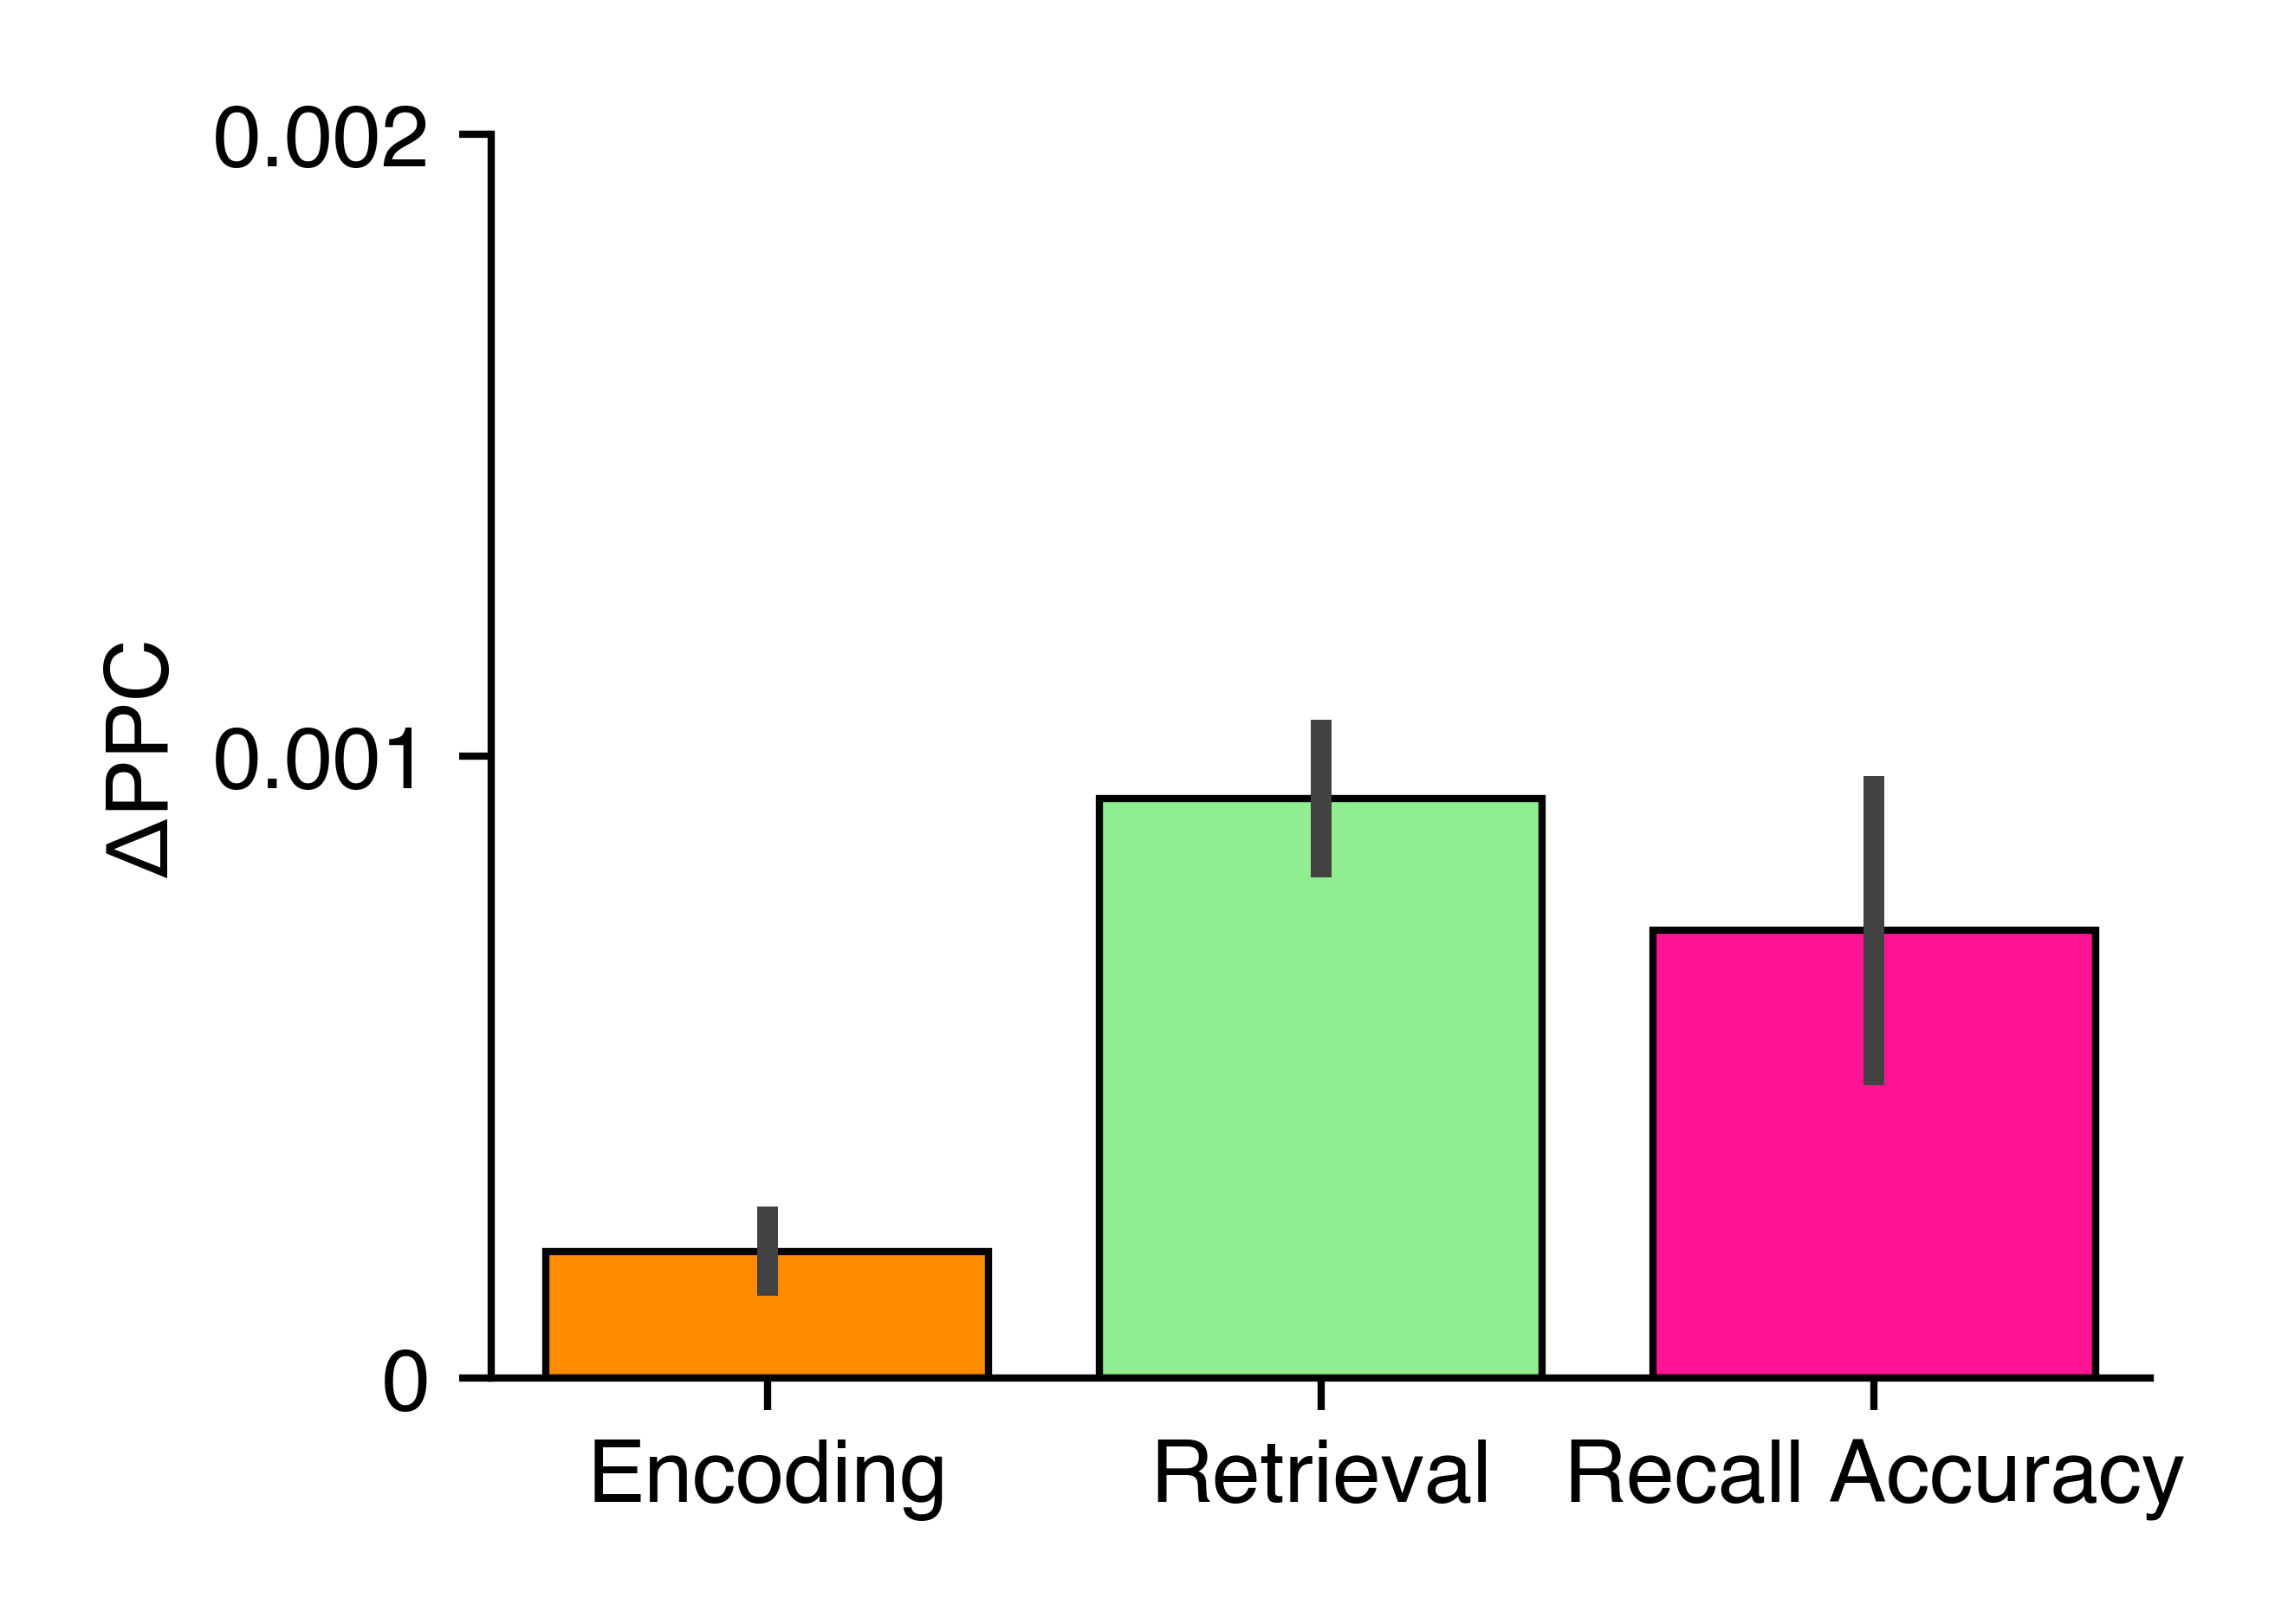

In [42]:
from collections import OrderedDict as od
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('/home1/dscho/code/general/preferred.mplstyle')
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from formatting import *

colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

import matplotlib.font_manager as font_manager

font_dirs = ['/home1/amrao/SUPL']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
figsize = (colws[2]*0.65, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = 0
ymax = 0.002
yticks = [0, .001, .002]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.barplot(x='beh', y='data', data=fig2_df, ax=_ax,
                  saturation=1, alpha=bar_alpha, zorder=0,
                  errorbar='se', lw=spine_lw, ec='k',
                  palette=['darkorange', 'lightgreen', 'deeppink'])
_ax.legend(fontsize=7, handletextpad=0.5, title=None)

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=6)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick']+2)
_ax.set_ylabel('ΔPPC', fontsize=font['label'], labelpad=2)
# if _ax.get_legend():
#     _ax.get_legend().remove()

No handles with labels found to put in legend.


Text(0, 0.5, 'ΔPPC')

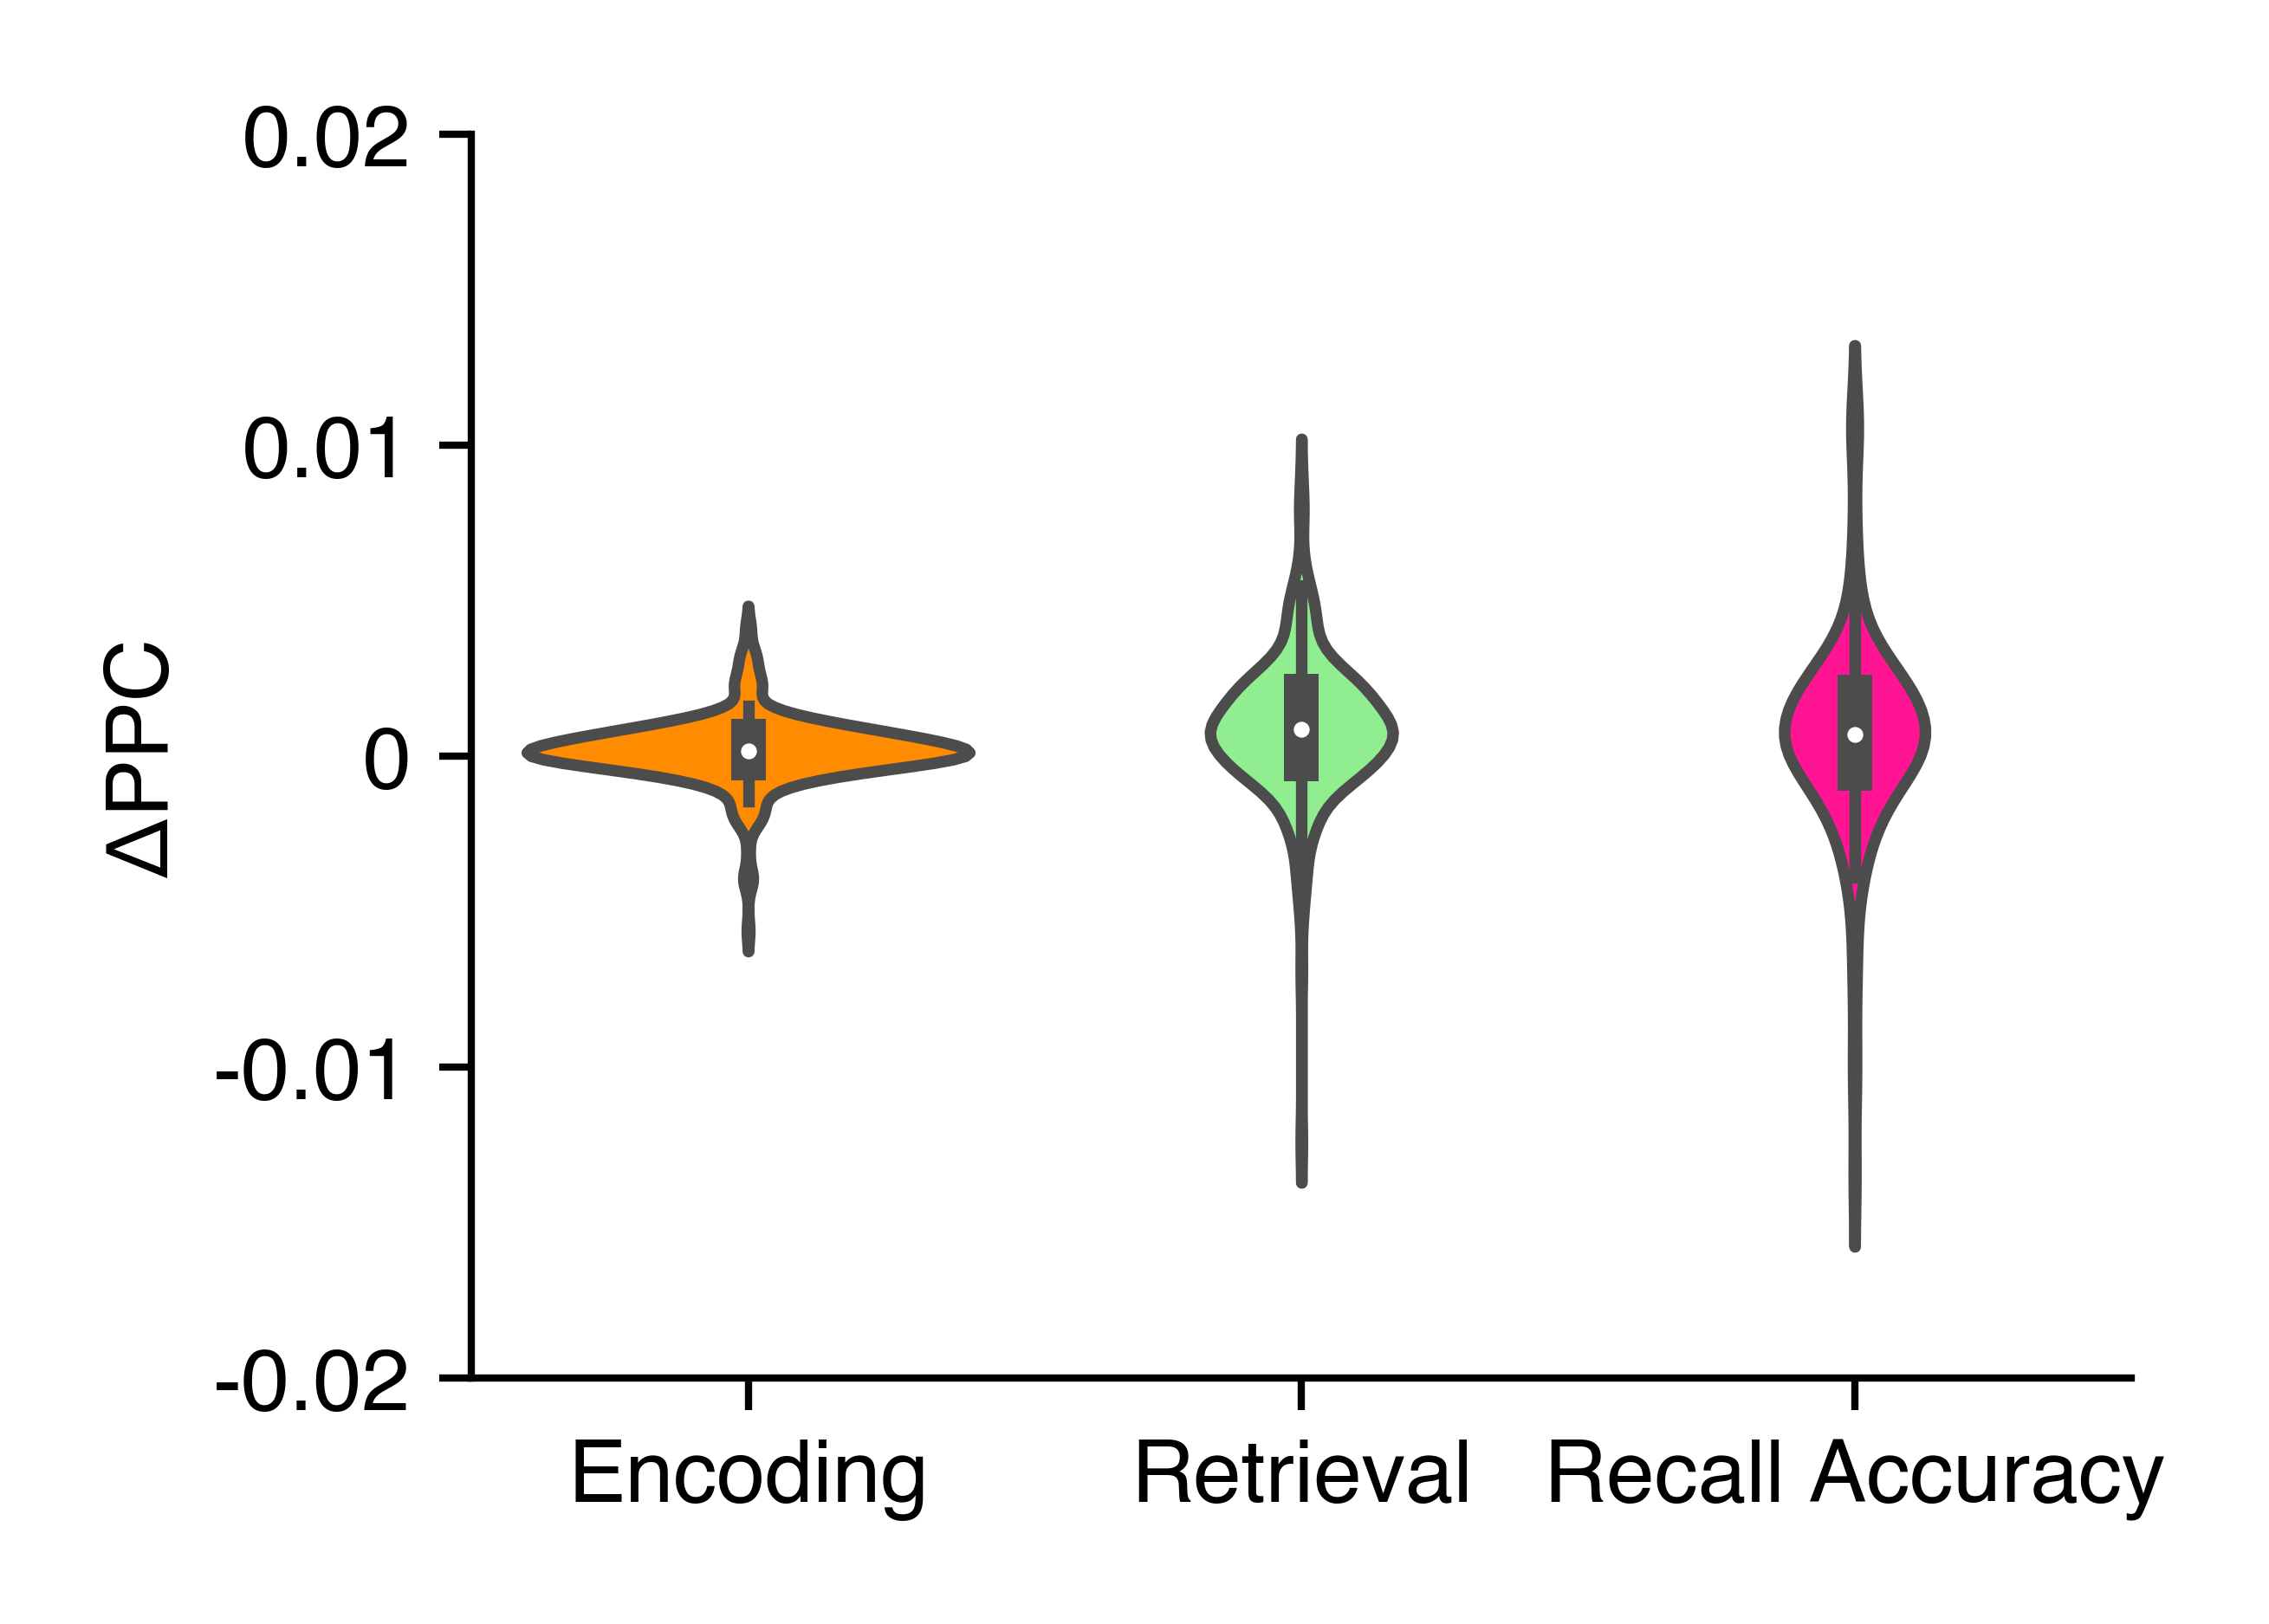

In [201]:
# Plot phase-locking percentage by region for the max phase-locking frequency.
savefig = 0
overwrite = 0
figsize = (colws[2]*0.65, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
ymin = -0.02
ymax = 0.02
yticks = [-0.02, -0.01, 0, 0.01, 0.02]
spine_lw = 0.5
ticklen = 2.2
tickpad = 0
labelpad = 3
bar_alpha = 1
stripsize = 1.5
jitter = 0.25
capsize = 2.5
hline_color = co['x3']

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax.axhline(5, lw=spine_lw, color=hline_color, ls='--')
_ax = sns.violinplot(x='beh', y='data', data=fig2_df, ax=_ax,
                  saturation=1, 
                  alpha=bar_alpha, 
                  zorder=0,
                  errorbar='se', 
                  lw=spine_lw, 
                  ec='k',
                 palette=['darkorange', 'lightgreen', 'deeppink'])
_ax.legend(fontsize=7, handletextpad=0.5, title=None)

# _ax.errorbar(np.arange(len(hub_df)),
#              hub_df_bar['mean'].to_numpy(),
#              yerr=hub_df_bar[['lower', 'upper']].to_numpy(),
#              ecolor='k', elinewidth=spine_lw, capsize=capsize,
#              capthick=spine_lw, linewidth=0, zorder=2)
    
for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=6)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick']+2)
_ax.set_ylabel('ΔPPC', fontsize=font['label'], labelpad=2)
# if _ax.get_legend():
#     _ax.get_legend().remove()


# Subject-level effects

## Trial count

In [231]:
def get_sub_trial_count(sub, beh, sess_list_df):
    
    sub_dfrows = sess_list_df.loc[[sub], ['sub', 'exp', 'sess', 'loc', 'mon']].reset_index(drop=True)
    
    def get_trial_count(dfrow, beh):
        events = load_events(dfrow, beh)
        return len(events)//2 if events is not None else np.nan
    
    sub_dfrows['event_count'] = sub_dfrows.apply(lambda dfrow: get_trial_count(dfrow, beh), axis=1)
    
    return sub_dfrows['event_count'].mean()

In [232]:
def get_event_count_effect_size(beh):
    
    if beh in ['en', 'rm']:
        sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index('sub',drop=False)
    elif beh == 'ri':
        sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)').set_index('sub',drop=False)
        
    sub_list_df = pd.DataFrame(sess_list_df['sub'].unique(), columns=['sub']).set_index('sub', drop=False)
    sub_list_df[f'{beh}_event_count'] = sub_list_df.apply(lambda r: get_sub_trial_count(r.name, beh, sess_list_df), axis=1)
    mx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean('epoch').mean('freq').mean('reg2').mean('reg1')
    mx = mx.sel(success=1) - mx.sel(success=0)
    sub_list_df[f'{beh}_effect_size'] = sub_list_df.apply(lambda r: float(mx.sel(sub = r.name).values), axis=1)
    
    return sub_list_df

In [233]:
def compute_event_count_effect_size_correlation(sub_list_df):
    
    np.random.seed(202409)
    
    event_counts = sub_list_df[f'{beh}_event_count'].values
    effect_sizes = sub_list_df[f'{beh}_effect_size'].values
    r_true = scipy.stats.pearsonr(event_counts, effect_sizes)[0]
    
    shuffle_count = 999
    rs_shuffled = []
    for _ in range(shuffle_count):
        
        event_counts_shuffled = deepcopy(event_counts)
        effect_sizes_shuffled = deepcopy(effect_sizes)
        np.random.shuffle(event_counts_shuffled)
        np.random.shuffle(effect_sizes_shuffled)
        
        r_shuffled = scipy.stats.pearsonr(event_counts_shuffled, effect_sizes_shuffled)[0]
        rs_shuffled.append(r_shuffled)
        
    rs = [r_true] + rs_shuffled
    p = np.sum(np.abs(rs) >= np.abs(r_true))/len(rs)
    print_header(beh)
    print(f'Pearson\'s r: {r_true}, p = {p}')

In [234]:
for beh in ['en', 'rm', 'ri']:
    
    sub_list_df = get_event_count_effect_size(beh)
    compute_event_count_effect_size_correlation(sub_list_df)

---------en---------
Pearson's r: 0.07911523215378613, p = 0.12
---------rm---------
Pearson's r: -0.07790718551580844, p = 0.129
---------ri---------
Pearson's r: -0.011597610182608832, p = 0.892


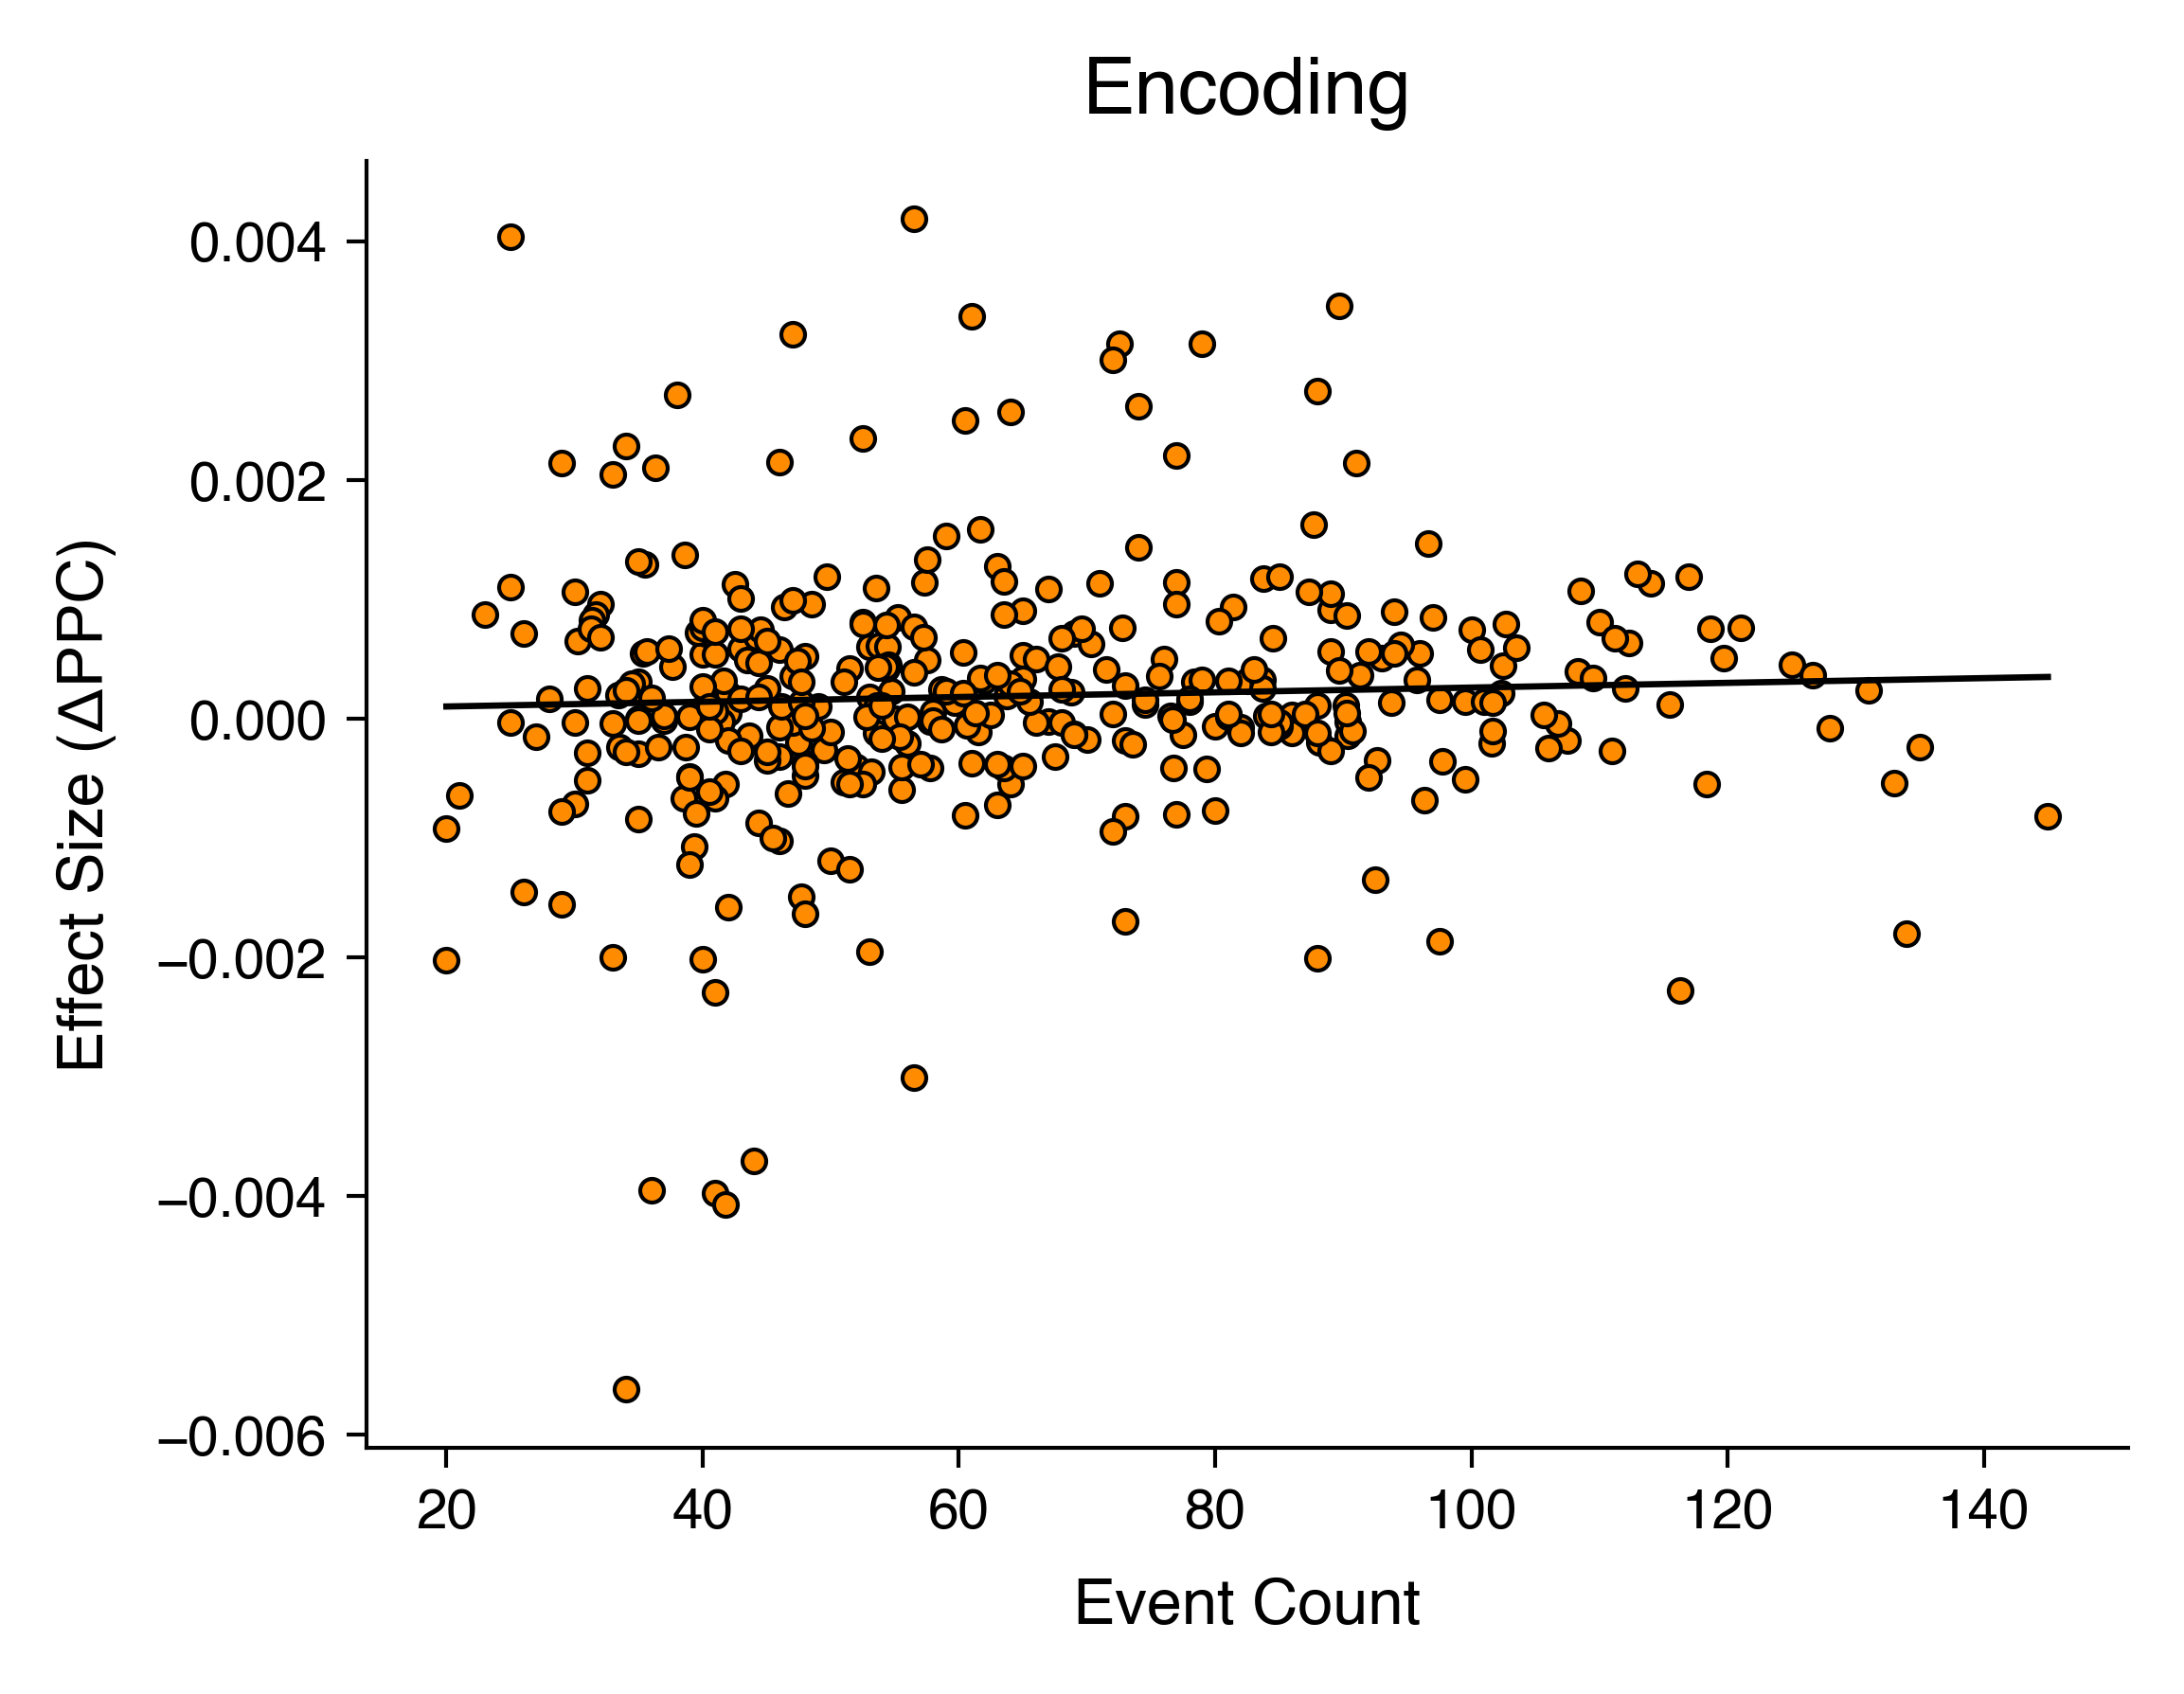

In [263]:
beh = 'en'
sub_list_df = get_event_count_effect_size(beh)
a, b = sub_list_df[f'{beh}_event_count'].values, sub_list_df[f'{beh}_effect_size'].values
a = a[..., np.newaxis]
from sklearn.linear_model import HuberRegressor
regression = HuberRegressor()
regression.fit(a, b)
regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
fig, ax = plt.subplots(1, figsize=(4, 3))
ax.set_facecolor('white')
ax.scatter(a, b, color='darkorange', edgecolor='black')
ax.set_title('Encoding')
ax.set_xlabel('Event Count')
ax.set_ylabel('Effect Size (ΔPPC)')
ax.plot(np.unique(a), regression_line, color='black')

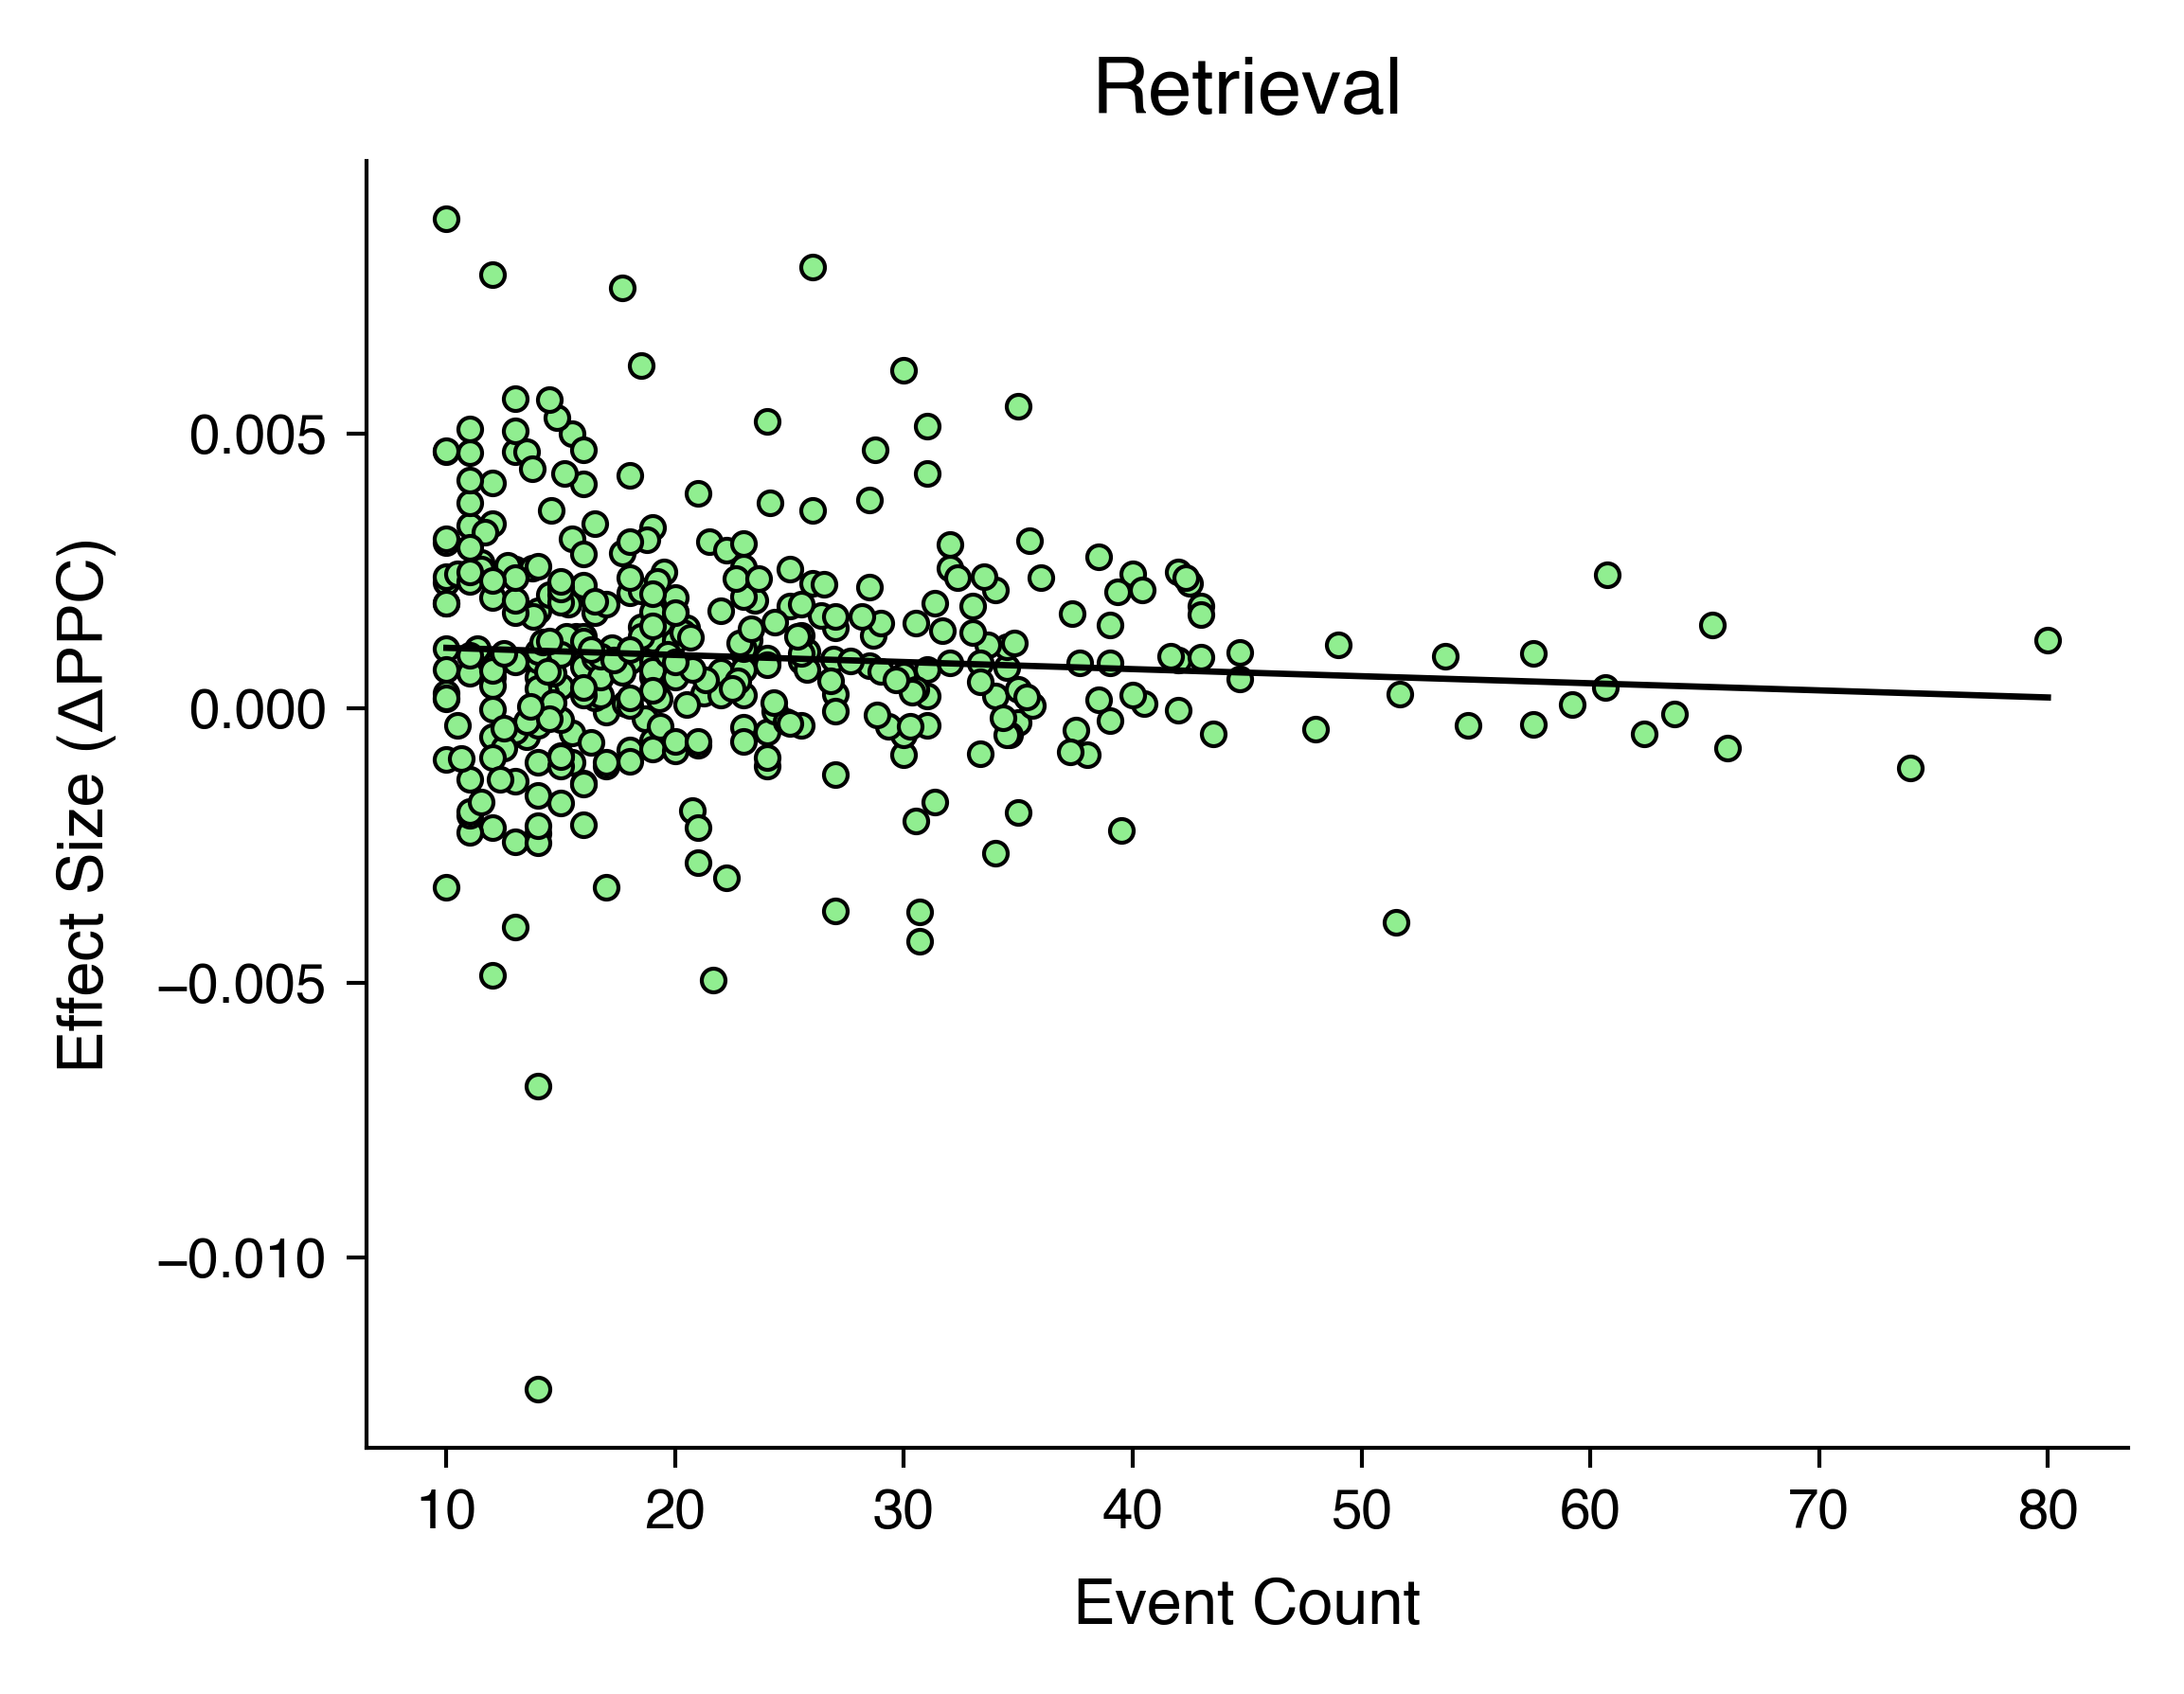

In [264]:
beh = 'rm'
sub_list_df = get_event_count_effect_size(beh)
a, b = sub_list_df[f'{beh}_event_count'].values, sub_list_df[f'{beh}_effect_size'].values
a = a[..., np.newaxis]
from sklearn.linear_model import HuberRegressor
regression = HuberRegressor()
regression.fit(a, b)
regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
fig, ax = plt.subplots(1, figsize=(4, 3))
ax.set_facecolor('white')
ax.scatter(a, b, color='lightgreen', edgecolor='black')
ax.set_title('Retrieval')
ax.set_xlabel('Event Count')
ax.set_ylabel('Effect Size (ΔPPC)')
ax.plot(np.unique(a), regression_line, color='black')

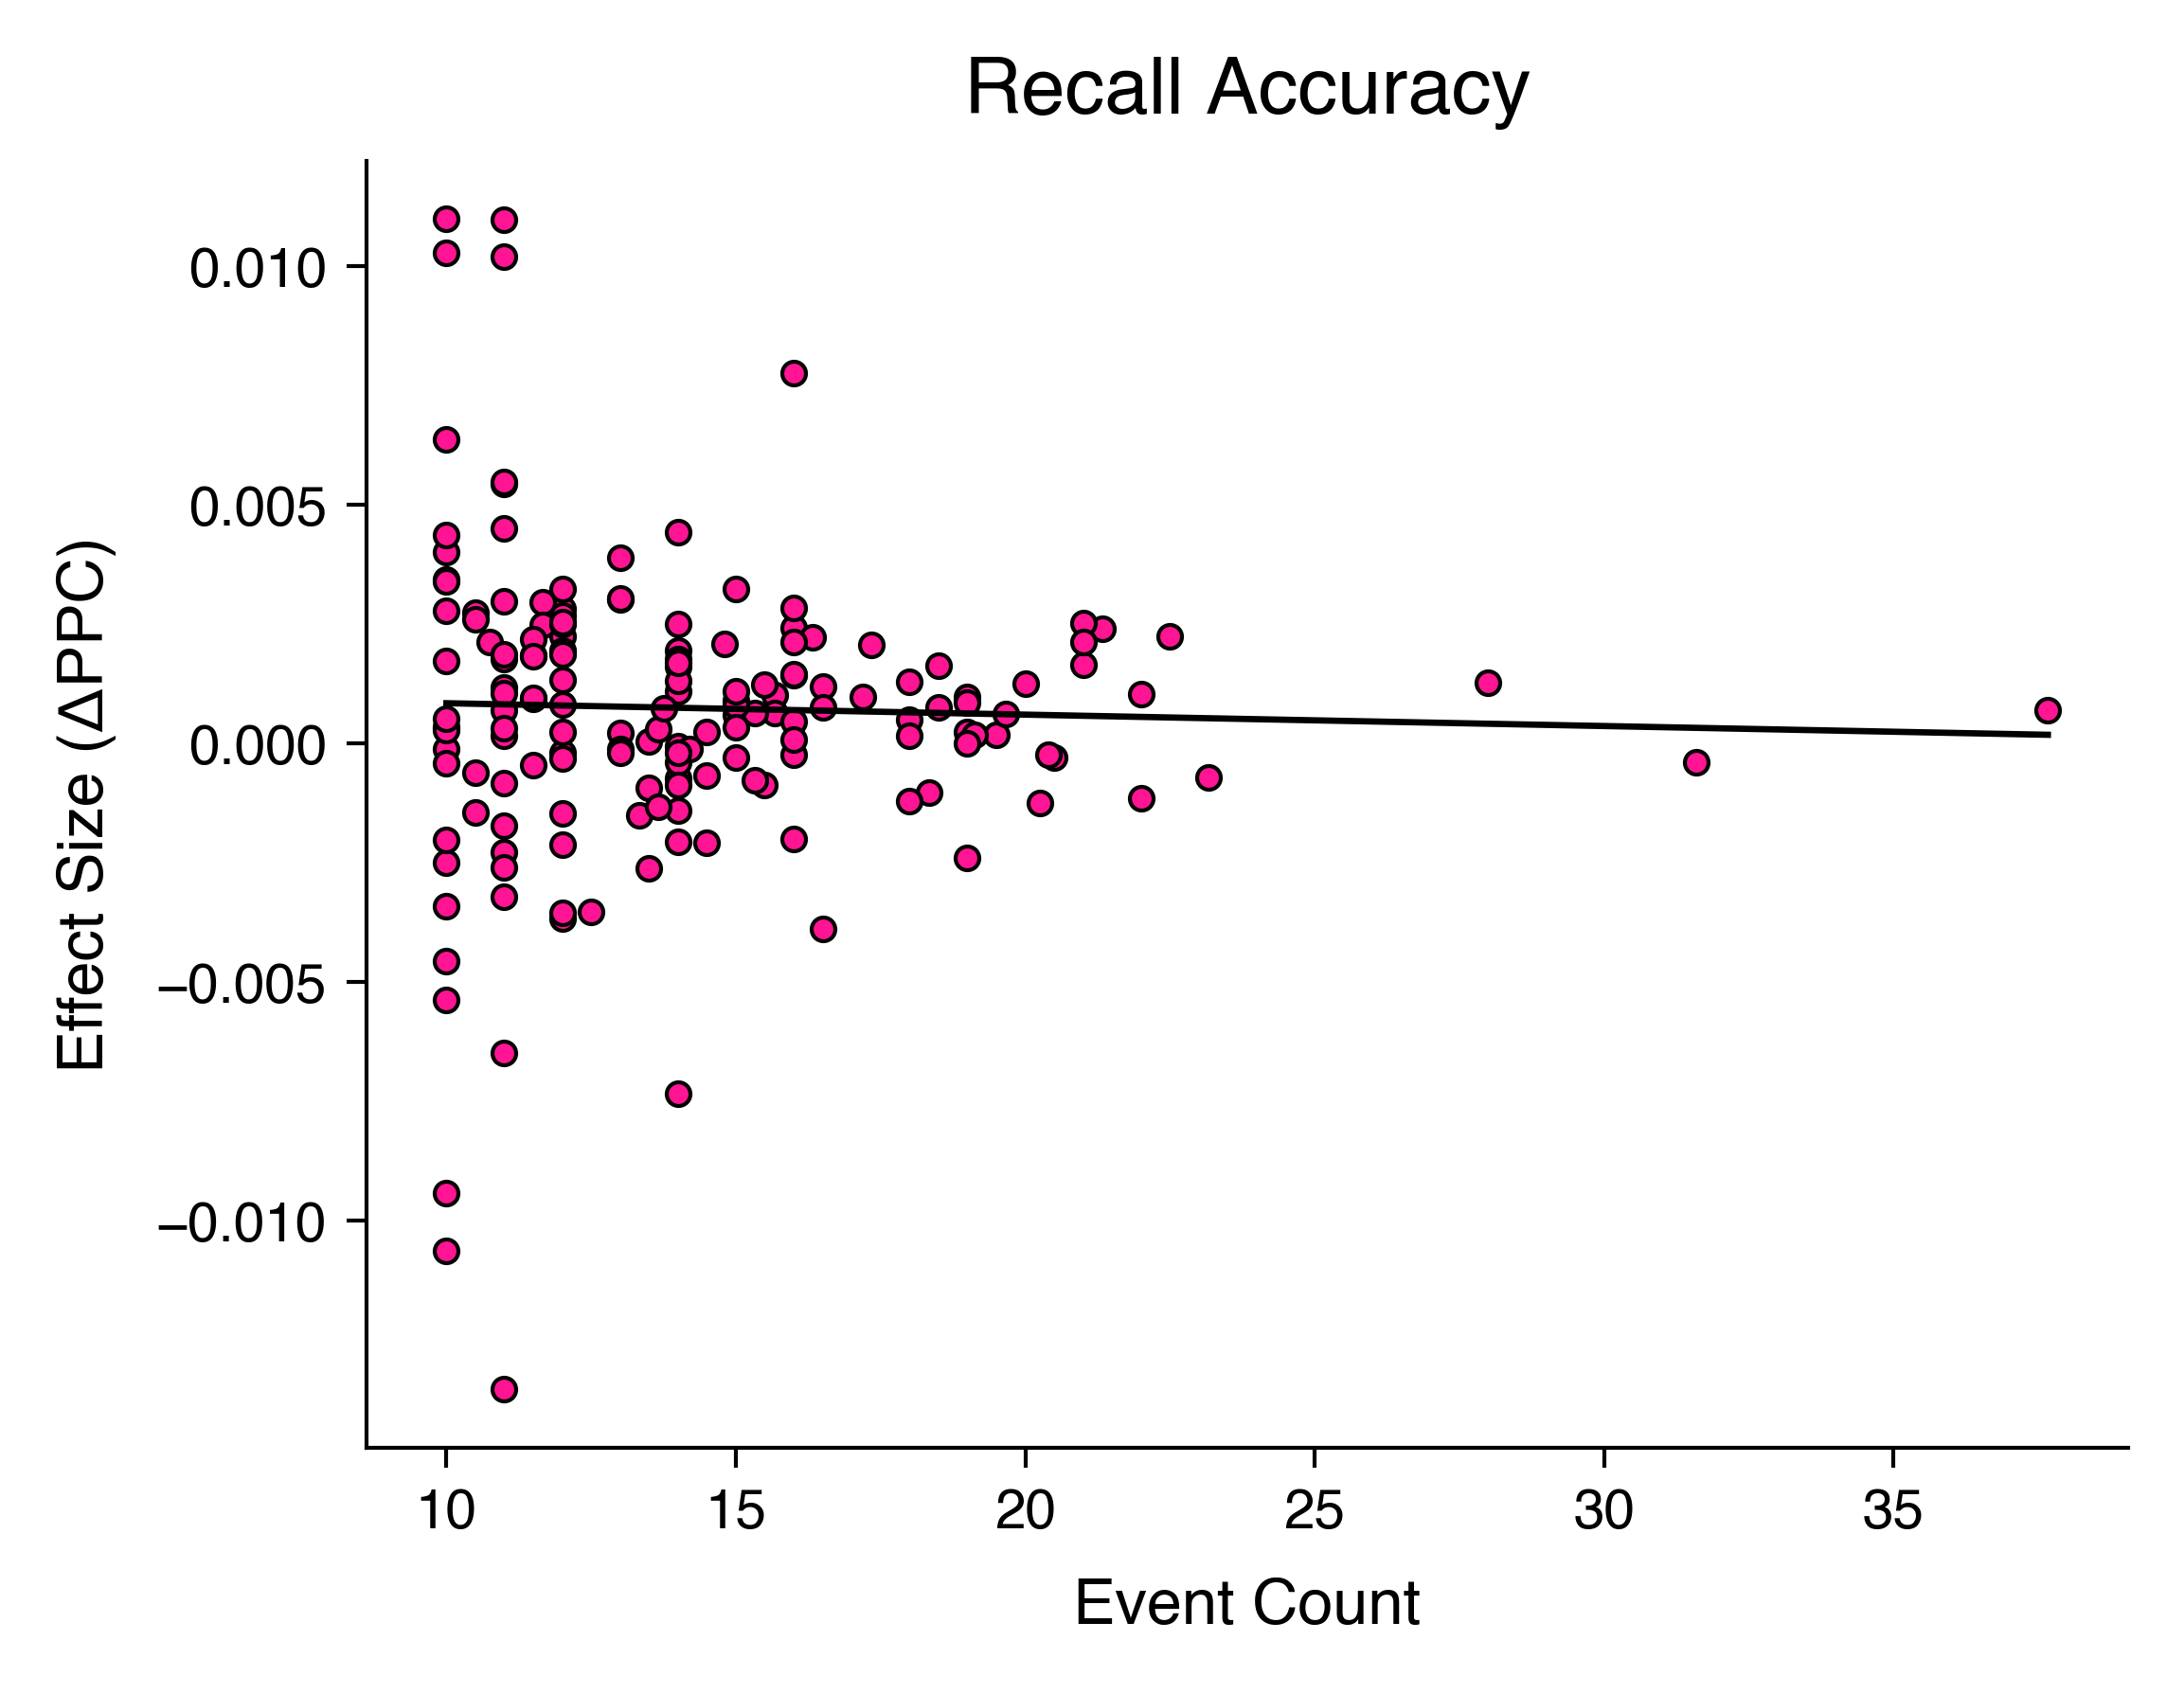

In [265]:
beh = 'ri'
sub_list_df = get_event_count_effect_size(beh)
a, b = sub_list_df[f'{beh}_event_count'].values, sub_list_df[f'{beh}_effect_size'].values
a = a[..., np.newaxis]
from sklearn.linear_model import HuberRegressor
regression = HuberRegressor()
regression.fit(a, b)
regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
fig, ax = plt.subplots(1, figsize=(4, 3))
ax.set_facecolor('white')
ax.scatter(a, b, color='deeppink', edgecolor='black')
ax.set_title('Recall Accuracy')
ax.set_xlabel('Event Count')
ax.set_ylabel('Effect Size (ΔPPC)')
ax.plot(np.unique(a), regression_line, color='black')

## Noise floors

In [38]:
shuffle_count = 20

In [23]:
path = join(root_dir, 'noise_floor_analysis')
if not ex(path): os.mkdir(path)
for beh in ['en', 'rm', 'ri']:
    path = join(root_dir, 'noise_floor_analysis', beh)
    if not ex(path): os.mkdir(path)
    path = join(root_dir, 'noise_floor_analysis', beh, 'noise_floor_estimates')
    if not ex(path): os.mkdir(path)
    for iShuffle in np.arange(1, shuffle_count+1):
        path = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}')
        if not ex(path): os.mkdir(path)
        for d in ['shuffled_masks', 'elsymxs', 'regsymxs']:
            path = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', d)
            if not ex(path): os.mkdir(path)
# directory structure: /scratch/amrao/retrieval_connectivity/noise_floor_analysis/en/shuffle_1/shuffled_masks
# /scratch/amrao/retrieval_connectivity/noise_floor_analysis/en/shuffle_1/elsymxs
# /scratch/amrao/retrieval_connectivity/noise_floor_analysis/en/shuffle_1/regsymxs

In [22]:
# import shutil
# path = join(root_dir, 'noise_floor_analysis')
# if ex(path): shutil.rmtree(path)
# for beh in ['en', 'rm']:
#     path = join(root_dir, 'noise_floor_analysis', beh)
#     if ex(path): shutil.rmtree(path)
#     for iShuffle in np.arange(1, shuffle_count+1):
#         path = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}')
#         if ex(path): shutil.rmtree(path)
#         for d in ['shuffled_masks', 'elsymxs', 'regsymxs']:
#             path = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', d)
#             if ex(path): shutil.rmtree(path)

In [98]:
def run_pipeline_en_rm_shuffled(dfrow):
    
    dfrow = get_dfrow(dfrow)
    for beh in ['en', 'rm']:
        np.random.seed(202410)
        for iShuffle in np.arange(1, shuffle_count+1):
            events = load_events(dfrow, beh)
            save_dir = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}')
            shuffled_mask_fname = join(save_dir, 'shuffled_masks', f'{ftag(dfrow)}_shuffled_mask.npy')
            if ex(shuffled_mask_fname):
                events.attrs['mask'] = npl(shuffled_mask_fname)
            else:
                np.random.shuffle(events.attrs['mask'])
                np.save(shuffled_mask_fname, events.attrs['mask'])
            run_pipeline(dfrow, beh, events, save_dir)

In [99]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [106]:
client = cl('run_pipeline_en_rm_shuffled', '10G', int(4000/10), walltime=200000) 
futures = client.map(run_pipeline_en_rm_shuffled, sess_list)

Unique port for amrao is 51507
{'dashboard_address': ':51507'}
To view the dashboard, run: 
`ssh -fN amrao@rhino2.psych.upenn.edu -L 8000:192.168.86.141:51507` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [109]:
client.shutdown()

In [107]:
get_ex(futures, sess_list)

Exception: None of the given futures resulted in exceptions

In [108]:
np.all([future.status == 'finished' for future in futures])

True

In [101]:
len(ld('/scratch/amrao/retrieval_connectivity/noise_floor_analysis/rm/shuffle_20/regsymxs'))

980

In [24]:
def run_pipeline_ri_shuffled(dfrow):
    
    dfrow = get_dfrow(dfrow)
    beh = 'ri'
    np.random.seed(202410)
    for iShuffle in np.arange(1, shuffle_count+1):
        events = load_events(dfrow, beh)
        save_dir = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}')
        shuffled_mask_fname = join(save_dir, 'shuffled_masks', f'{ftag(dfrow)}_shuffled_mask.npy')
        if ex(shuffled_mask_fname):
            events.attrs['mask'] = npl(shuffled_mask_fname)
        else:
            np.random.shuffle(events.attrs['mask'])
            np.save(shuffled_mask_fname, events.attrs['mask'])
        run_pipeline(dfrow, beh, events, save_dir)

In [25]:
sess_list_df_ri = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
sess_list_ri = sess_list_df_ri[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [101]:
client2 = cl('run_pipeline_ri_shuffled', '10G', int(1500/10), walltime=200000) 
futures2 = client2.map(run_pipeline_ri_shuffled, sess_list_ri)

Unique port for amrao is 51507
{'dashboard_address': ':51507'}
To view the dashboard, run: 
`ssh -fN amrao@rhino2.psych.upenn.edu -L 8000:192.168.86.141:34596` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 51507 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34596 instead
  f"Port {expected} is already in use.\n"


In [95]:
client.shutdown()
client2.shutdown()

In [96]:
not_done_fnames = []
for beh in ['en', 'rm', 'ri']:
    for iShuffle in range(1, 21):
        for i, dfrow in sess_list_df.iterrows():
            fname = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
            if ex(fname):
                try:
                    xr.open_dataarray(fname)
                except:
                    not_done_fnames.append(fname)

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [97]:
print(len(not_done_fnames))

29


In [99]:
for fname in not_done_fnames:
    os.system(f'rm {fname}')

In [39]:
def estimate_noise_floor_en_rm(dfrow):
    
    dfrow = get_dfrow(dfrow)
    
    for beh in ['en', 'rm']:
        noise_floor_estimates = []
        for iShuffle in np.arange(1, shuffle_count+1):
            fname = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
            mx = xr.open_dataarray(fname).mean('epoch').mean('freq').mean('reg2').mean('reg1')
            mx = mx.sel(success=1) - mx.sel(success=0)
            noise_floor_estimate = float(mx.values)
            noise_floor_estimates += [noise_floor_estimate]
        
        save_fname = join(root_dir, 'noise_floor_analysis', beh, 'noise_floor_estimates', f'{ftag(dfrow)}_noise_floor_estimate.npy')
        np.save(save_fname, noise_floor_estimates)

In [40]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [41]:
client = cl('estimate_noise_floor_en_rm', '10G', int(3000/10), walltime=200000) 
futures = client.map(estimate_noise_floor_en_rm, sess_list)

Unique port for amrao is 51507
{'dashboard_address': ':51507'}
To view the dashboard, run: 
`ssh -fN amrao@rhino2.psych.upenn.edu -L 8000:192.168.86.141:51507` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


In [42]:
def estimate_noise_floor_ri(dfrow):
    
    dfrow = get_dfrow(dfrow)
    
    beh = 'ri'
    noise_floor_estimates = []
    for iShuffle in np.arange(1, shuffle_count+1):
        fname = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
        mx = xr.open_dataarray(fname).mean('epoch').mean('freq').mean('reg2').mean('reg1')
        mx = mx.sel(success=1) - mx.sel(success=0)
        noise_floor_estimate = float(mx.values)
        noise_floor_estimates += [noise_floor_estimate]

    save_fname = join(root_dir, 'noise_floor_analysis', beh, 'noise_floor_estimates', f'{ftag(dfrow)}_noise_floor_estimate.npy')
    np.save(save_fname, noise_floor_estimates)

In [43]:
sess_list_df_ri = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
sess_list_ri = sess_list_df_ri[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [44]:
client2 = cl('estimate_noise_floor_ri', '10G', int(2000/10), walltime=200000) 
futures2 = client2.map(estimate_noise_floor_ri, sess_list_ri)

Unique port for amrao is 51507
{'dashboard_address': ':51507'}
To view the dashboard, run: 
`ssh -fN amrao@rhino2.psych.upenn.edu -L 8000:192.168.86.141:33955` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 51507 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33955 instead
  f"Port {expected} is already in use.\n"


In [51]:
client.shutdown()
client2.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [18]:
def get_noise_floor_effect_size(beh):
    
    if beh in ['en', 'en_all', 'rm']:
        sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')[['sub', 'exp', 'sess', 'loc', 'mon']]
    elif beh == 'ri':
        sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')[['sub', 'exp', 'sess', 'loc', 'mon']]
        
    sess_list_df[f'{beh}_noise_floor'] = sess_list_df.apply(lambda dfrow: np.mean(npl(join(root_dir, 'noise_floor_analysis', beh, 'noise_floor_estimates', f'{ftag(dfrow)}_noise_floor_estimate.npy'))), axis=1)
                                                            
    sub_list_df = pd.DataFrame(sess_list_df['sub'].unique(), columns=['sub']).set_index('sub', drop=False)
    sub_list_df[f'{beh}_noise_floor'] = sub_list_df.apply(lambda r: sess_list_df[sess_list_df['sub'] == r.name][f'{beh}_noise_floor'].mean(), axis=1)
    mx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean('epoch').mean('freq').mean('reg2').mean('reg1')
    mx = mx.sel(success=1) - mx.sel(success=0)
    sub_list_df[f'{beh}_effect_size'] = sub_list_df.apply(lambda r: float(mx.sel(sub = r.name).values), axis=1)
    
    return sub_list_df

In [19]:
def compute_noise_floor_effect_size_correlation(sub_list_df):
    
    np.random.seed(202409)
    
    noise_floors = sub_list_df[f'{beh}_noise_floor'].values
    effect_sizes = sub_list_df[f'{beh}_effect_size'].values
    r_true = scipy.stats.pearsonr(noise_floors, effect_sizes)[0]
    
    shuffle_count = 999
    rs_shuffled = []
    for _ in range(shuffle_count):
        
        noise_floors_shuffled = deepcopy(noise_floors)
        effect_sizes_shuffled = deepcopy(effect_sizes)
        np.random.shuffle(noise_floors_shuffled)
        np.random.shuffle(effect_sizes_shuffled)
        
        r_shuffled = scipy.stats.pearsonr(noise_floors_shuffled, effect_sizes_shuffled)[0]
        rs_shuffled.append(r_shuffled)
        
    rs = [r_true] + rs_shuffled
    p = np.sum(np.abs(rs) >= np.abs(r_true))/len(rs)
    print_header(beh)
    print(f'Pearson\'s r: {r_true}, p = {p}')

In [20]:
for beh in ['en', 'rm', 'ri']:
    
    sub_list_df = get_noise_floor_effect_size(beh)
    compute_noise_floor_effect_size_correlation(sub_list_df)

---------en---------
Pearson's r: 0.13282567362754438, p = 0.017
---------rm---------
Pearson's r: 0.13256241771830019, p = 0.012
---------ri---------
Pearson's r: -0.02946627479427546, p = 0.693


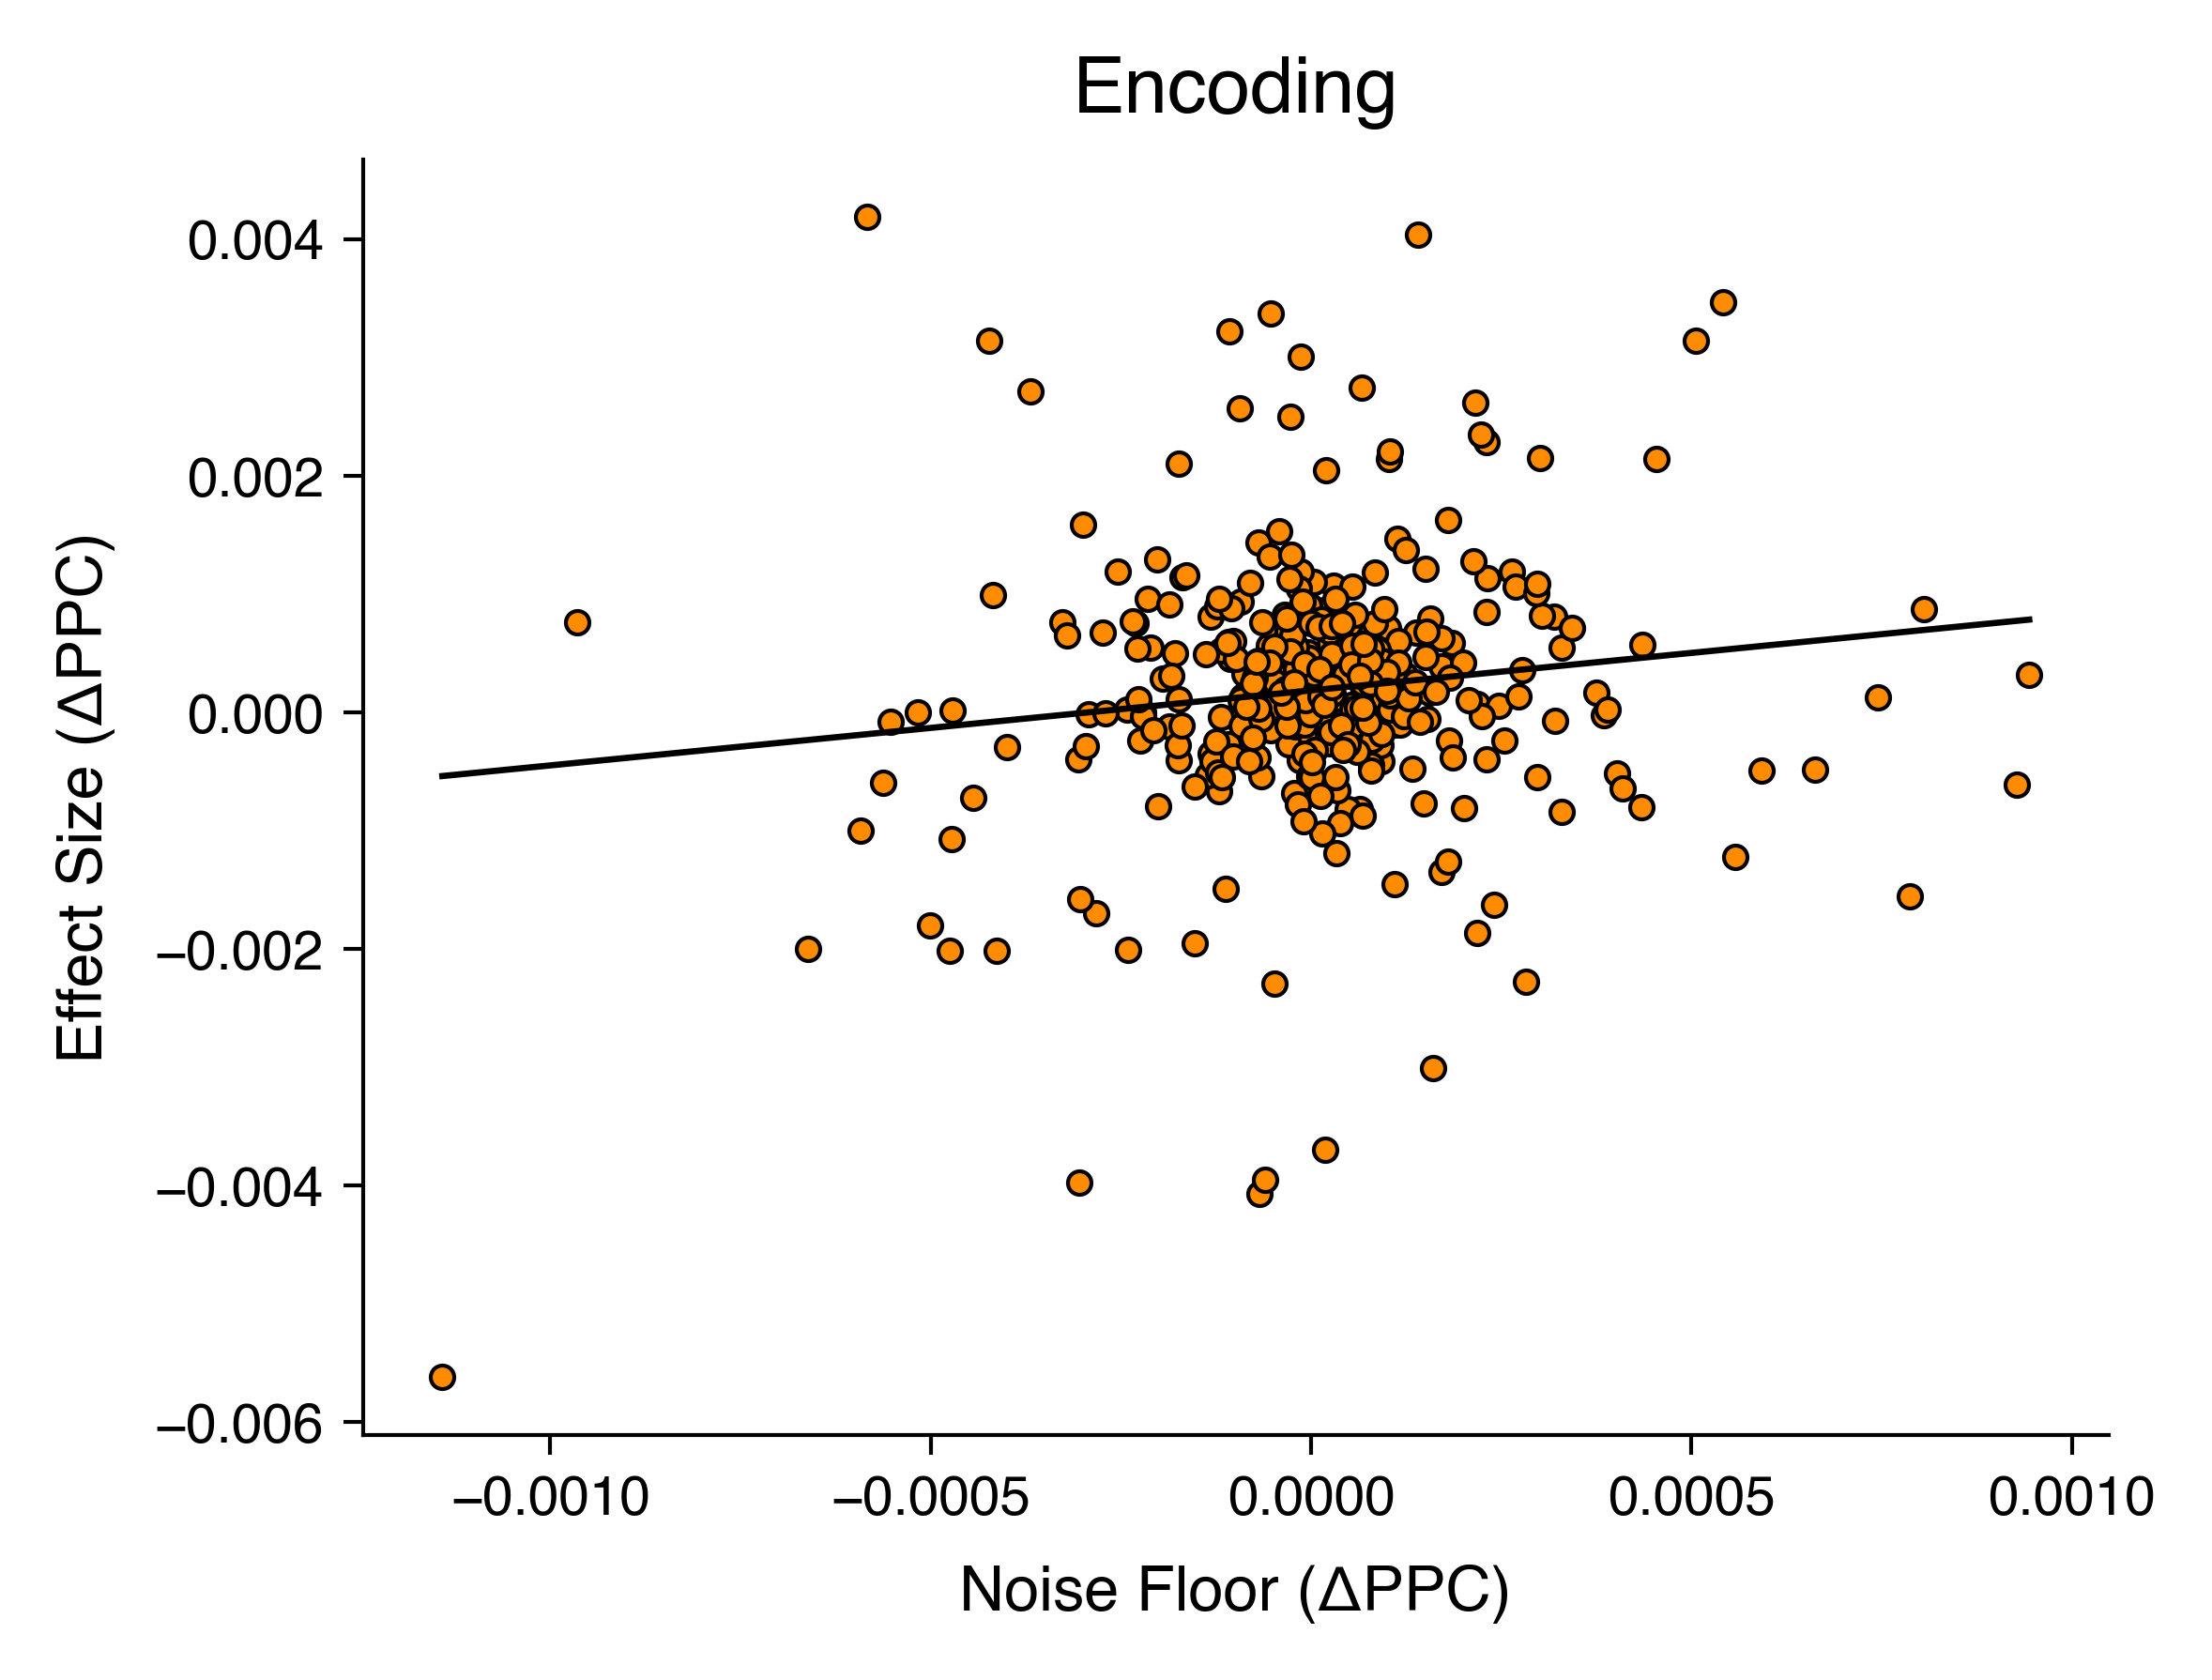

In [266]:
beh = 'en'
sub_list_df = get_noise_floor_effect_size(beh)
a, b = sub_list_df[f'{beh}_noise_floor'].values, sub_list_df[f'{beh}_effect_size'].values
a = a[..., np.newaxis]
from sklearn.linear_model import LinearRegression
regression = LinearRegression()
regression.fit(a, b)
regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
fig, ax = plt.subplots(1, figsize=(4, 3))
ax.set_facecolor('white')
ax.scatter(a, b, color='darkorange', edgecolor='black')
ax.set_title('Encoding')
ax.set_xlabel('Noise Floor (ΔPPC)')
ax.set_ylabel('Effect Size (ΔPPC)')
ax.plot(np.unique(a), regression_line, color='black')

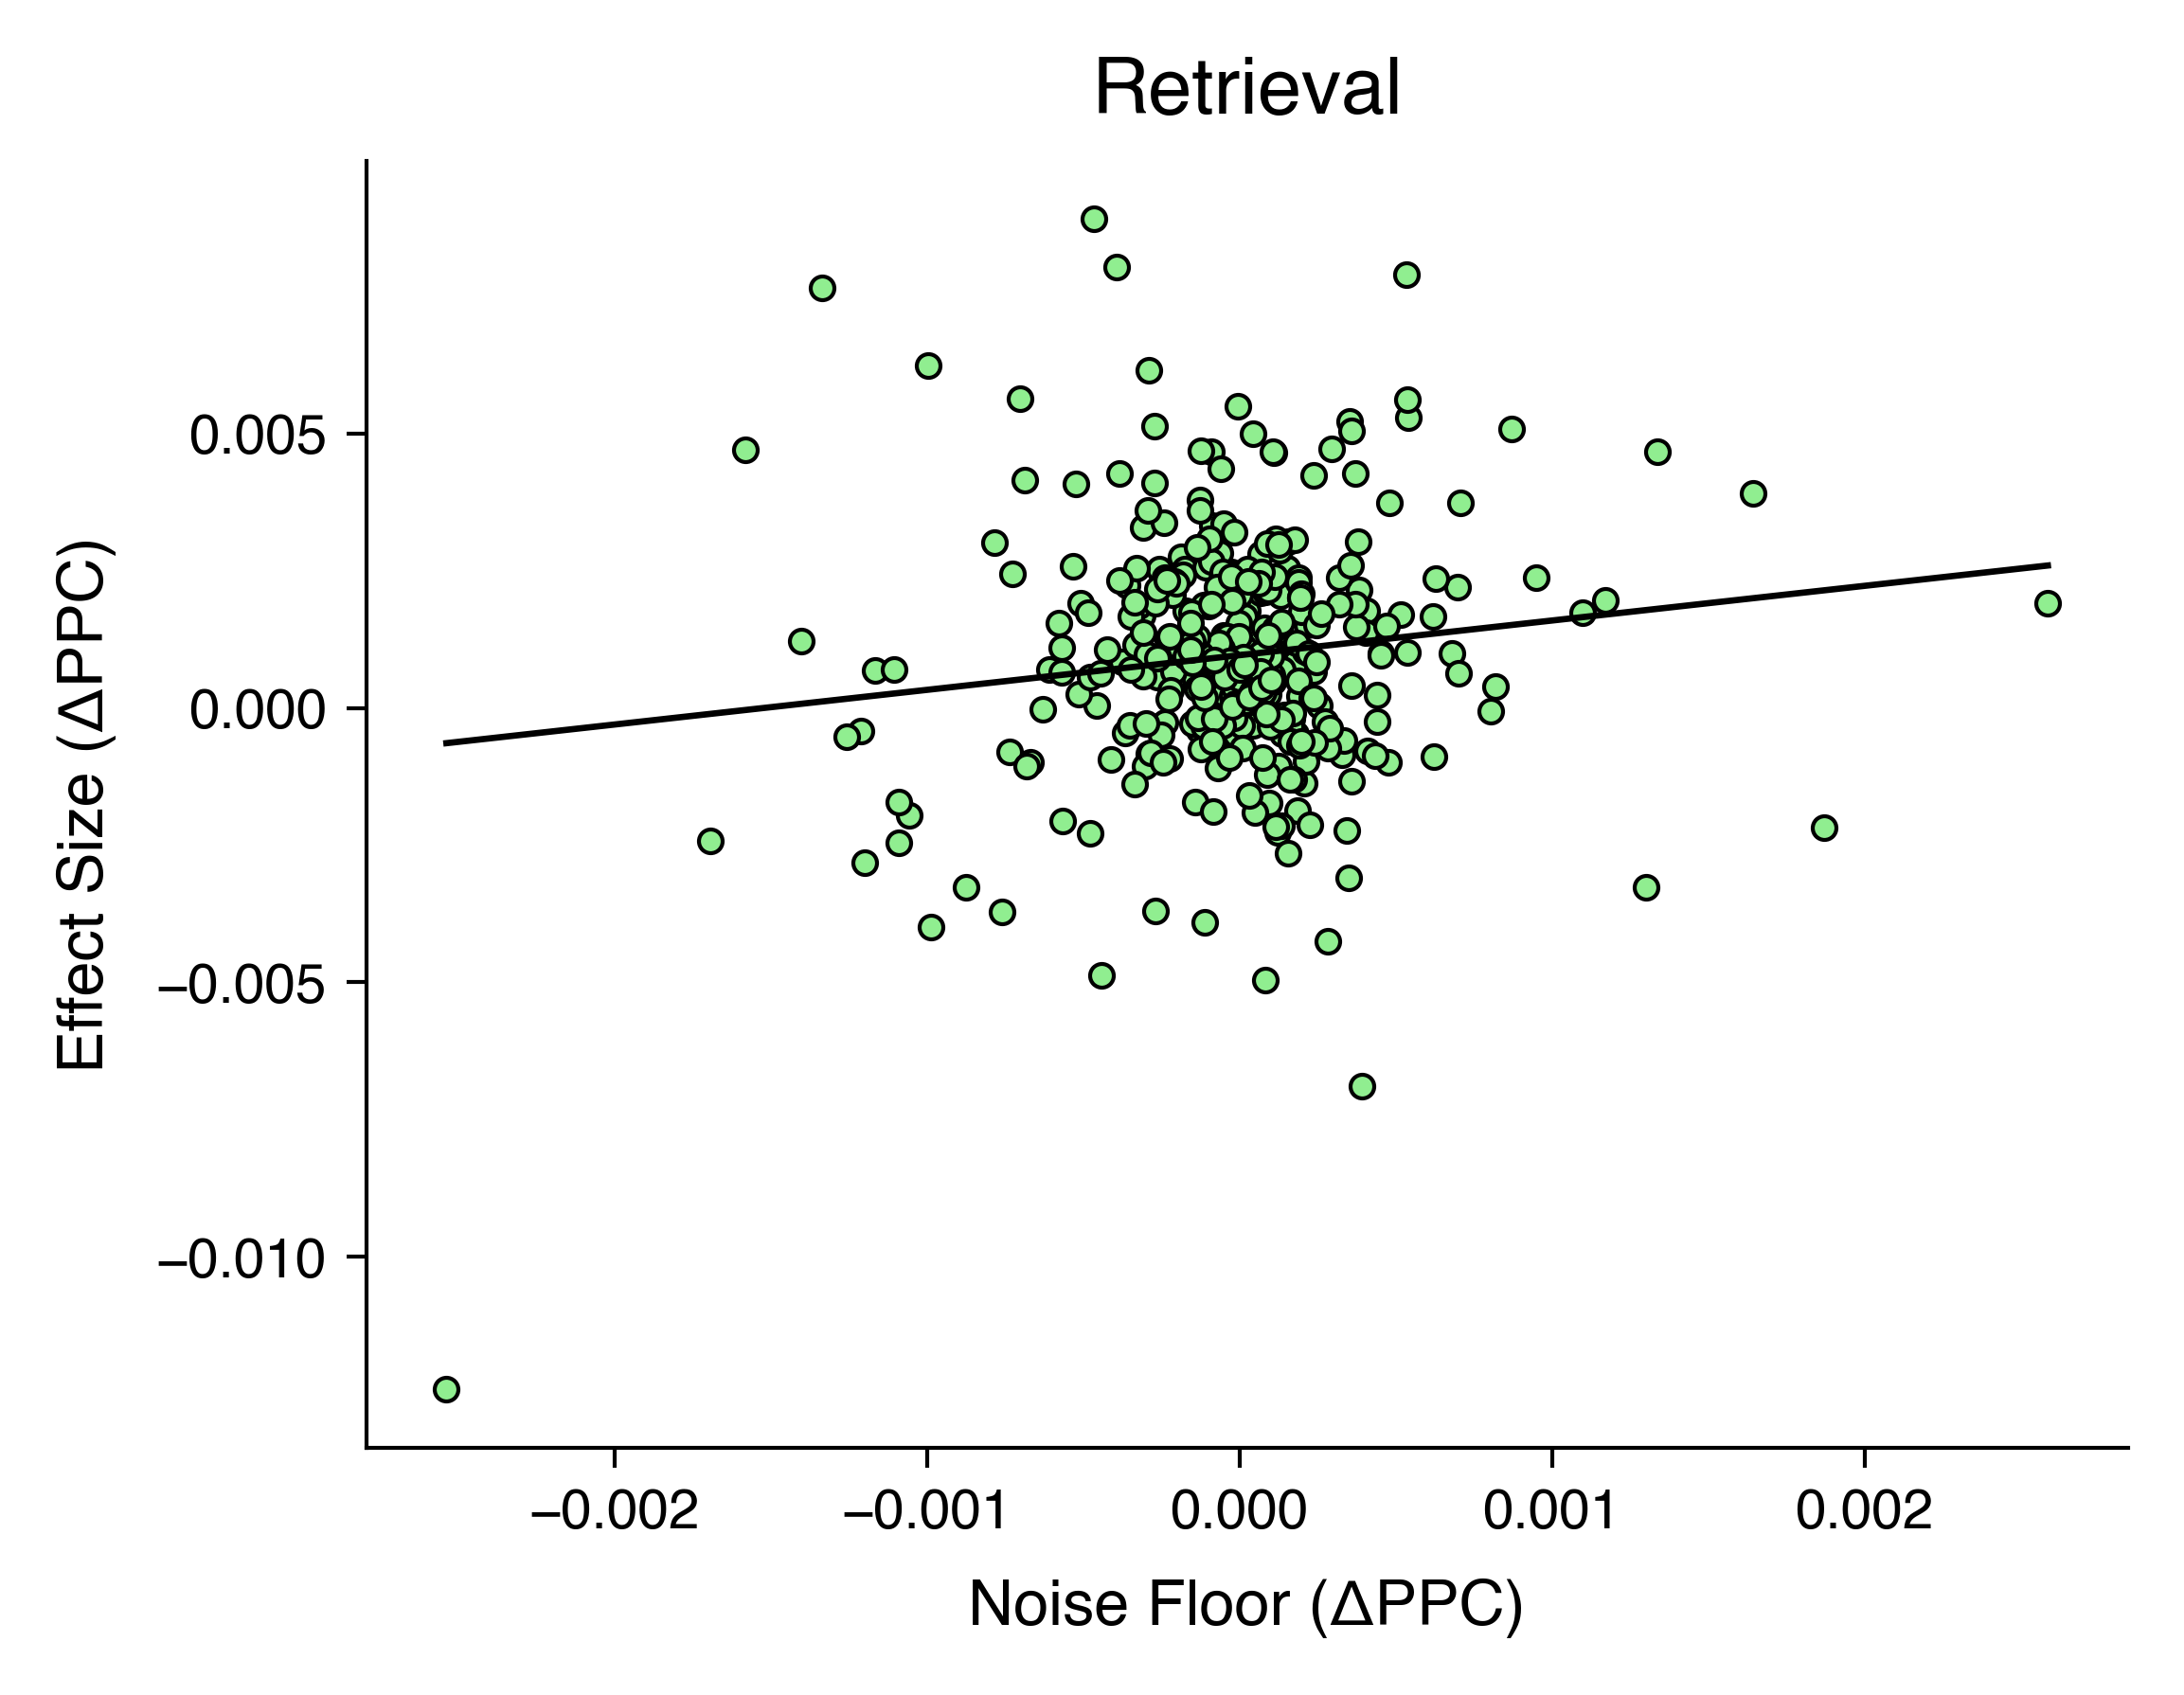

In [267]:
beh = 'rm'
sub_list_df = get_noise_floor_effect_size(beh)
a, b = sub_list_df[f'{beh}_noise_floor'].values, sub_list_df[f'{beh}_effect_size'].values
a = a[..., np.newaxis]
from sklearn.linear_model import LinearRegression
regression = LinearRegression()
regression.fit(a, b)
regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
fig, ax = plt.subplots(1, figsize=(4, 3))
ax.set_facecolor('white')
ax.scatter(a, b, color='lightgreen', edgecolor='black')
ax.set_title('Retrieval')
ax.set_xlabel('Noise Floor (ΔPPC)')
ax.set_ylabel('Effect Size (ΔPPC)')
ax.plot(np.unique(a), regression_line, color='black')

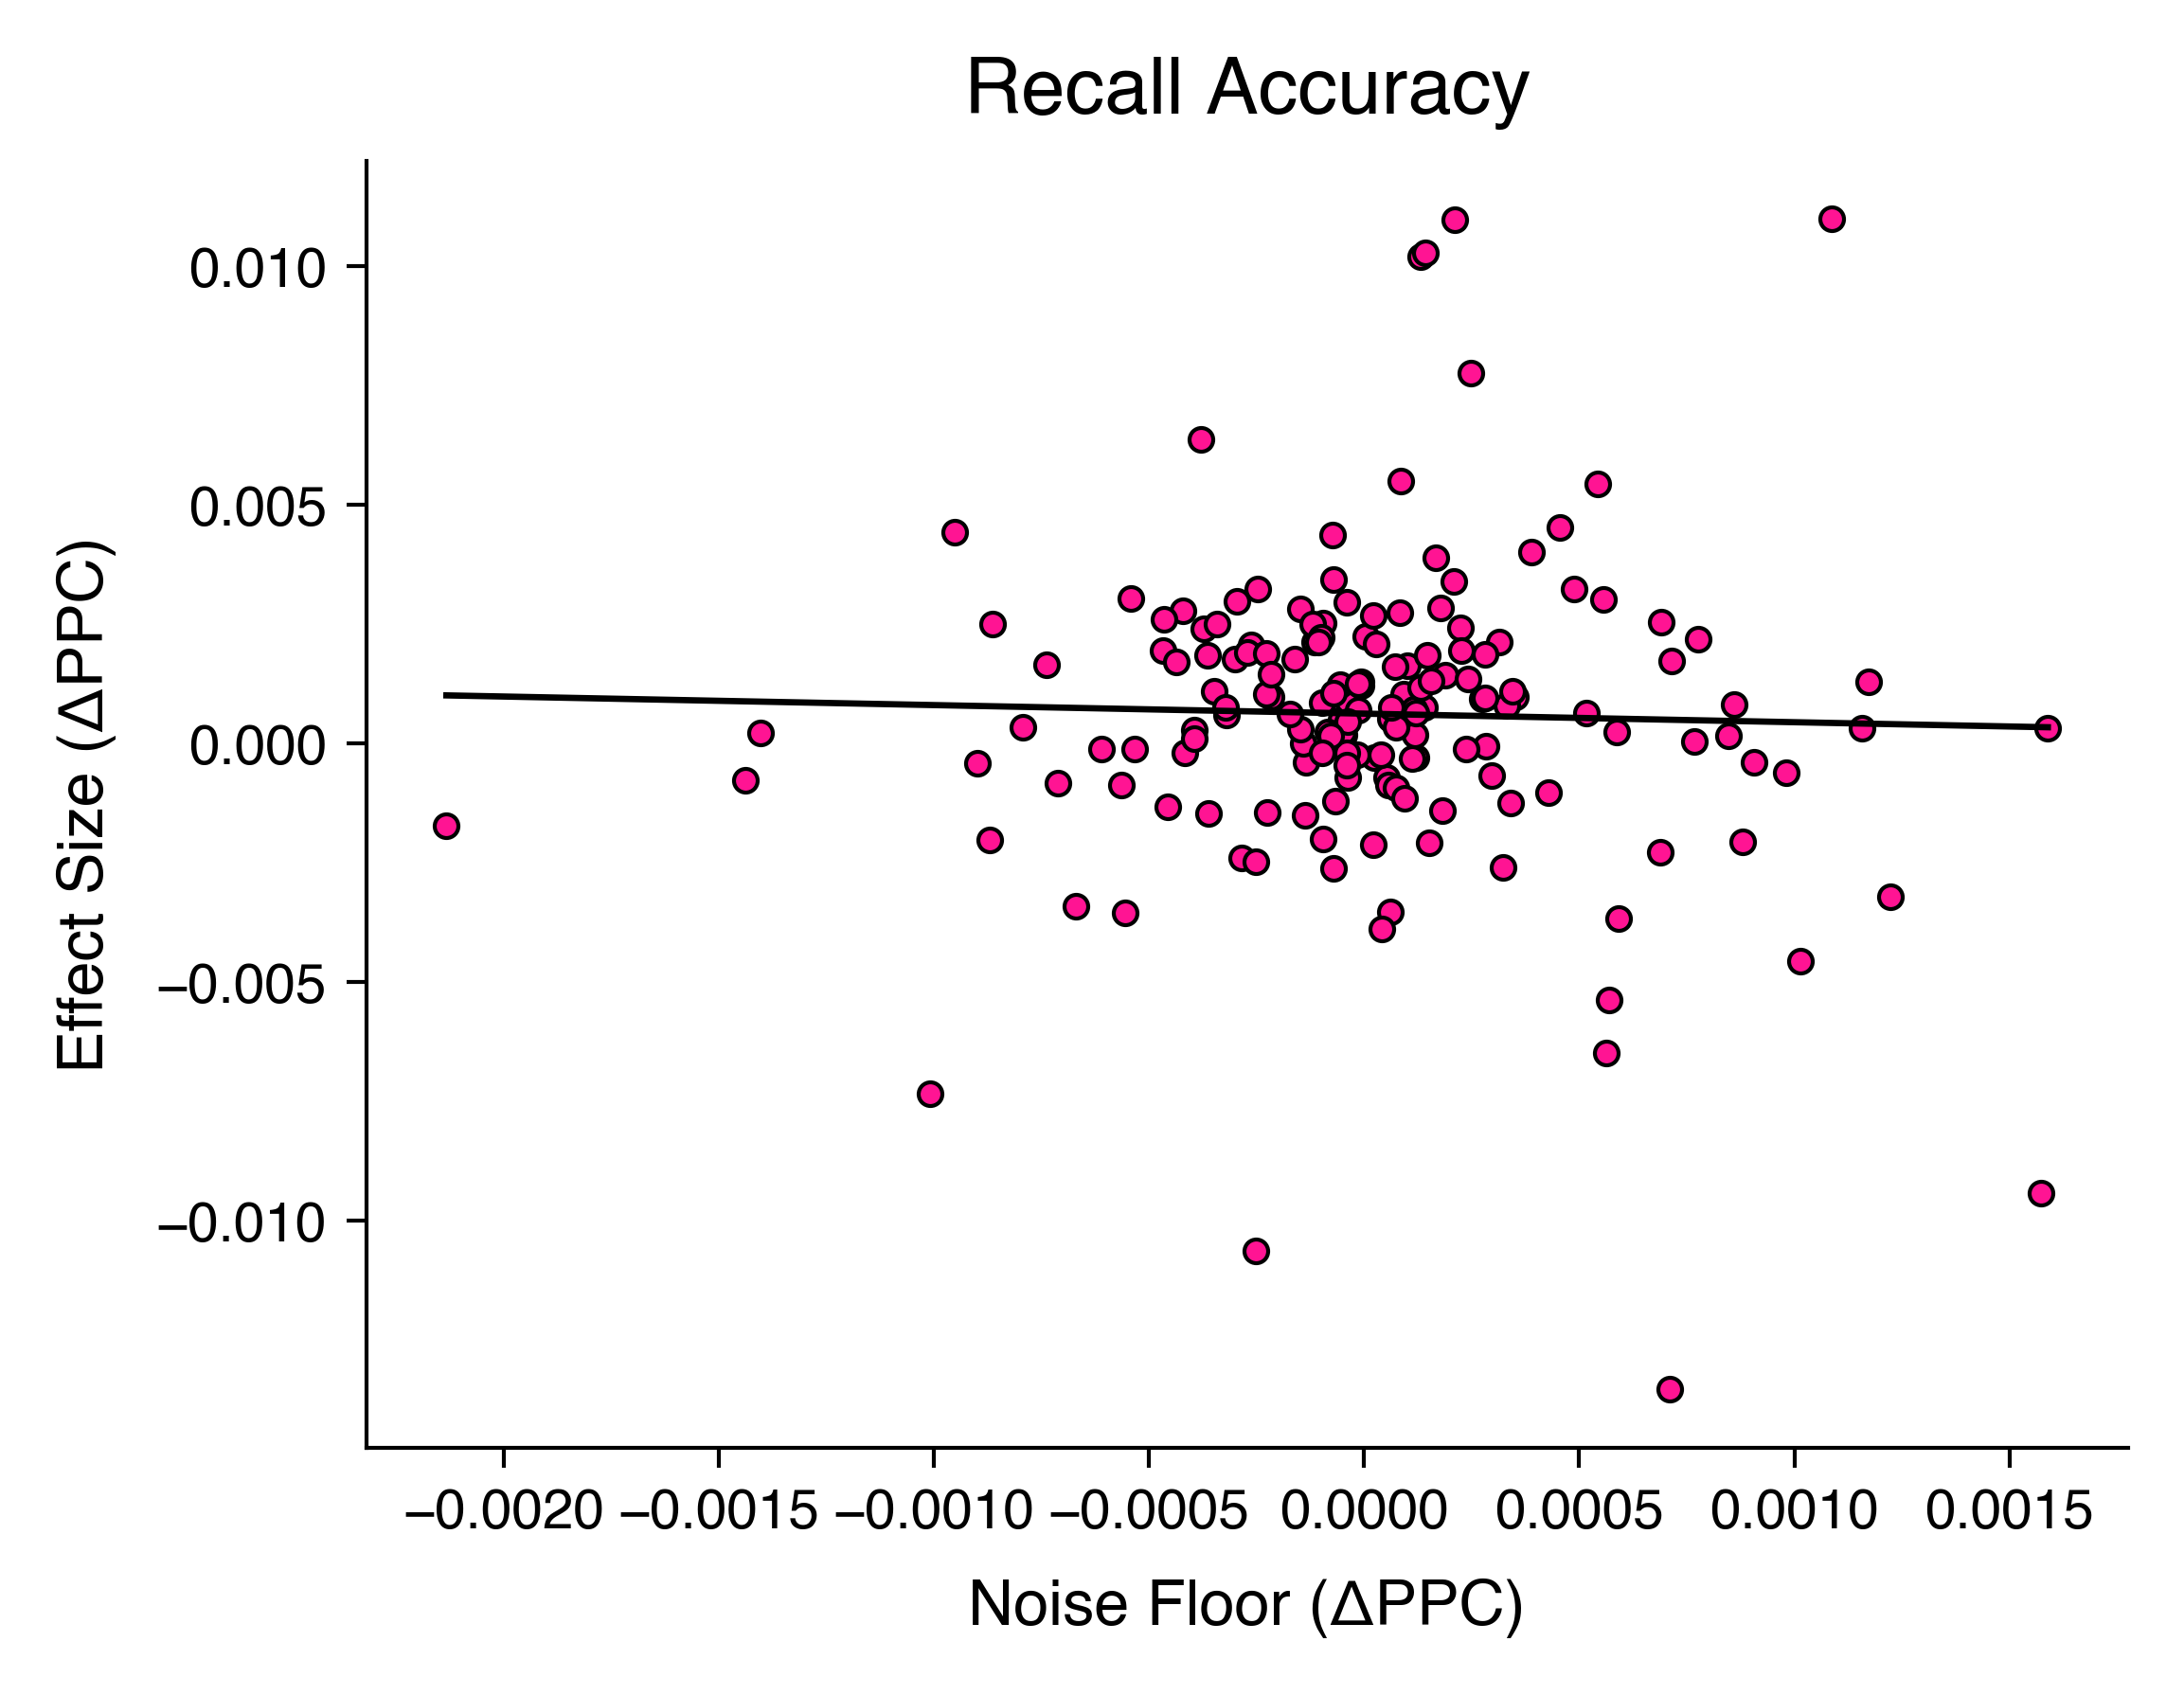

In [268]:
beh = 'ri'
sub_list_df = get_noise_floor_effect_size(beh)
a, b = sub_list_df[f'{beh}_noise_floor'].values, sub_list_df[f'{beh}_effect_size'].values
a = a[..., np.newaxis]
from sklearn.linear_model import LinearRegression
regression = LinearRegression()
regression.fit(a, b)
regression_line = np.poly1d([*regression.coef_, regression.intercept_])(np.unique(a))
fig, ax = plt.subplots(1, figsize=(4, 3))
ax.set_facecolor('white')
ax.scatter(a, b, color='deeppink', edgecolor='black')
ax.set_title('Recall Accuracy')
ax.set_xlabel('Noise Floor (ΔPPC)')
ax.set_ylabel('Effect Size (ΔPPC)')
ax.plot(np.unique(a), regression_line, color='black')

# Hub analysis

In [258]:
def compute_hub_table(beh, freq):
    
    np.random.seed(202407)
        
    assert freq in ['theta', *np.arange(3, 9)], 'freq must be specified as "theta" for theta average or as one of the theta frequencies'
    symx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean(['epoch', 'reg2'])
    
    if freq == 'theta': symx = symx.mean('freq')
    else: symx = symx.sel(freq=freq)
        
    hub_table = pd.DataFrame({'reg': symx.reg1.values})
    
    def get_ppc_differences(reg):
        
        symx_sel = symx.sel(reg1=reg)
        ppc_successful = symx_sel.sel(success=1).data
        ppc_unsuccessful = symx_sel.sel(success=0).data
        return ppc_successful, ppc_unsuccessful
    
    hub_table[['ppc_successful', 'ppc_unsuccessful']] = hub_table.apply(lambda r: get_ppc_differences(r['reg']), axis=1, result_type='expand')
    hub_table['ppc_differences'] = hub_table['ppc_successful'] - hub_table['ppc_unsuccessful']
    hub_table['sub_count'] = hub_table.apply(lambda r: len(finitize(r['ppc_differences'])), axis=1)
    
    shuffle_count = 10000
    sub_threshold = 7
    flip_masks = np.asarray([(2*((np.random.random(size=len(symx.sub.values))>=0.5)-0.5)).astype(int) for _ in range(shuffle_count)])
        
    hub_table['t'] = hub_table.apply(lambda r: scipy.stats.ttest_1samp(finitize(r['ppc_differences']), popmean=0).statistic if r['sub_count'] >= sub_threshold else np.nan, axis=1)
    hub_table['t_shuffled'] = hub_table.apply(lambda r: np.asarray([scipy.stats.ttest_1samp(finitize(r['ppc_differences']*flip_mask), popmean=0).statistic for flip_mask in flip_masks]) if not np.isnan(r['t']) else [], axis=1)
    no_tests = np.sum(~pd.isna(hub_table['t']))
    
    t_distribution = np.asarray([t for ts in hub_table['t_shuffled'].values for t in ts if len(ts) > 0])
    p0 = (2*np.sum([np.quantile(t_distribution, 0.25) <= t <= np.quantile(t_distribution, 0.75) for t in hub_table['t'].values]))/no_tests
    p0 = np.min([p0, 1])
    
    hub_table['p_fdr'] = hub_table.apply(lambda r: p0*(np.sum(np.abs(t_distribution) >= np.abs(r['t']))+1)/(len(t_distribution)+1) if not np.isnan(r['t']) else np.nan, axis=1)
    hub_table['hub'] = hub_table['p_fdr'] < 0.05
    
    return hub_table, t_distribution, flip_masks
        

In [259]:
hub_tables = pd.Series({})
t_distributions = pd.Series({})
for beh in ['en', 'rm', 'ri']:
    hub_tables[beh], t_distributions[beh], _ = compute_hub_table(beh, 'theta')

In [260]:
for beh in ['en', 'rm', 'ri']:
    hubs = hub_tables[beh].query('hub==True')[['reg', 't']]
    no_hubs = len(hubs)
    no_positive_hubs = len(hubs.query('t > 0'))
    no_negative_hubs = len(hubs.query('t < 0'))
    print(f'{beh}: {no_hubs} hubs, {no_positive_hubs} positive hubs, {no_negative_hubs} negative hubs')
    print(f'positive hubs: {hubs.query("t > 0")["reg"].values}')
    print(f'negative hubs: {hubs.query("t < 0")["reg"].values}')

en: 14 hubs, 14 positive hubs, 0 negative hubs
positive hubs: ['L amygdala' 'L anterior cingulate gyrus' 'L calcarine cortex'
 'L middle temporal gyrus' 'L orbitofrontal cortex' 'L postcentral gyrus'
 'L superior frontal gyrus' 'R inferior temporal gyrus' 'R insula'
 'R medial frontal cortex' 'R middle temporal gyrus'
 'R paracentral lobule' 'R postcentral gyrus' 'R superior temporal gyrus']
negative hubs: []
rm: 40 hubs, 40 positive hubs, 0 negative hubs
positive hubs: ['L amygdala' 'L anterior cingulate gyrus' 'L frontal pole'
 'L frontoparietal operculum' 'L fusiform gyrus' 'L hippocampus'
 'L inferior frontal gyrus' 'L inferior parietal lobule'
 'L inferior temporal gyrus' 'L insula' 'L middle frontal gyrus'
 'L middle temporal gyrus' 'L orbitofrontal cortex'
 'L parahippocampal gyrus' 'L postcentral gyrus' 'L precentral gyrus'
 'L superior frontal gyrus' 'L superior temporal gyrus' 'L temporal pole'
 'R amygdala' 'R angular gyrus' 'R anterior cingulate gyrus'
 'R fusiform gyrus' '

In [261]:
hub_statistics = pd.DataFrame({'beh': ['en', 'rm', 'ri']})
hub_statistics['hubs'] = hub_statistics.apply(lambda r: hub_tables[r['beh']].query('hub == True')['reg'].values, axis=1)
hub_statistics['no_hubs'] = hub_statistics.apply(lambda r: len(r['hubs']), axis=1)
hub_statistics.set_index('beh', inplace=True)

In [262]:
save_pickle(join(root_dir, 'hub_tables.pkl'), hub_tables)
save_pickle(join(root_dir, 't_distributions.pkl'), t_distributions)
save_pickle(join(root_dir, 'hub_statistics.pkl'), hub_statistics)

In [29]:
hub_tables = load_pickle('/scratch/amrao/retrieval_connectivity/hub_tables.pkl')

In [30]:
hub_statistics = load_pickle('/scratch/amrao/retrieval_connectivity/hub_statistics.pkl')

In [ ]:
hub_statistics.loc['ri', 'hubs']

In [59]:
hub_statistics.loc['ri', 'hubs']

array(['L hippocampus', 'L middle temporal gyrus', 'L postcentral gyrus',
       'L precuneus', 'R hippocampus', 'R orbitofrontal cortex',
       'R parahippocampal gyrus'], dtype=object)

In [96]:
load_pickle('/scratch/amrao/retrieval_connectivity/initial_submission/hub_tables.pkl')['en'].query('hub==True')[['reg', 't', 'p_fdr']]

reg         t     p_fdr
0                   L amygdala  2.851088  0.002917
2   L anterior cingulate gyrus  2.439203  0.009699
4           L calcarine cortex  1.929555  0.035853
13   L inferior temporal gyrus  2.278123  0.015013
21     L middle temporal gyrus  2.317980  0.013517
22      L orbitofrontal cortex  1.952525  0.033980
25         L postcentral gyrus  1.897290  0.038567
31    L superior frontal gyrus  2.321190  0.013421
47              R frontal pole  2.130909  0.021973
52  R inferior parietal lobule  2.239914  0.016583
53   R inferior temporal gyrus  3.284273  0.000711
54                    R insula  2.692444  0.004765
56         R lentiform nucleus  2.265396  0.015498
58     R medial frontal cortex  2.027636  0.028289
61     R middle temporal gyrus  2.623351  0.005825
62      R orbitofrontal cortex  1.834879  0.044679
63        R paracentral lobule  2.882241  0.002638
65         R postcentral gyrus  1.833112  0.044867

In [60]:
np.setdiff1d(hub_statistics.loc['en_all', 'hubs'], hub_statistics.loc['en', 'hubs'])

array(['L calcarine cortex', 'L lingual gyrus', 'L medial frontal cortex',
       'L parahippocampal gyrus', 'L postcentral gyrus',
       'L supramarginal gyrus', 'R amygdala', 'R hippocampus',
       'R middle frontal gyrus', 'R orbitofrontal cortex',
       'R transverse temporal gyrus'], dtype=object)

In [76]:
hub_tables['ri'].query('hub==True')[['reg', 't', 'p_fdr']]

reg         t     p_fdr
10            L hippocampus  2.851061  0.005515
21  L middle temporal gyrus  2.161713  0.031899
25      L postcentral gyrus -2.079268  0.038542
28              L precuneus -2.363531  0.019249
50            R hippocampus  4.031573  0.000423
62   R orbitofrontal cortex  2.070496  0.039348
64  R parahippocampal gyrus  2.687085  0.008673

In [69]:
hub_tables['rm'].query('(hub==True) & (t < 0)')['reg'].shape

(3,)

In [38]:
np.intersect1d(hub_tables['en'].query('hub==True')['reg'].values, hub_tables['en_all'].query('hub==True')['reg'].values)

array(['L amygdala', 'L inferior temporal gyrus',
       'L middle temporal gyrus', 'L orbitofrontal cortex',
       'R frontal pole', 'R fusiform gyrus', 'R inferior parietal lobule',
       'R inferior temporal gyrus', 'R insula', 'R lingual gyrus',
       'R medial frontal cortex', 'R middle temporal gyrus',
       'R paracentral lobule', 'R postcentral gyrus',
       'R posterior cingulate gyrus'], dtype=object)

In [39]:
len(hub_tables['en'].query('hub==True')['reg'].values)

20

array(['L amygdala', 'L anterior cingulate gyrus',
       'L inferior temporal gyrus', 'L middle temporal gyrus',
       'L orbitofrontal cortex', 'L superior frontal gyrus',
       'L transverse temporal gyrus', 'R frontal pole',
       'R fusiform gyrus', 'R inferior parietal lobule',
       'R inferior temporal gyrus', 'R insula', 'R lentiform nucleus',
       'R lingual gyrus', 'R medial frontal cortex',
       'R middle temporal gyrus', 'R paracentral lobule',
       'R postcentral gyrus', 'R posterior cingulate gyrus',
       'R superior temporal gyrus'], dtype=object)

In [178]:
hub_tables['rm'].query('reg=="L transverse temporal gyrus"')

reg  \
38  L transverse temporal gyrus   

                                       ppc_successful  \
38  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                     ppc_unsuccessful  \
38  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                      ppc_differences  sub_count         t  \
38  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         41 -0.709598   

                                           t_shuffled     p_fdr    hub  
38  [-0.3874899601103061, -1.744127545776507, -1.6...  0.085378  False

## Create matrix for visualization

In [246]:
def create_plot_matrix(beh):
    symx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean(['freq', 'epoch'])
    symx = symx.sel(success=1) - symx.sel(success=0)
    mask = (np.isfinite(symx).sum('sub') >= 7).astype(int)
    symx = symx.mean('sub')
    symx = symx*mask
    matrix = np.empty(shape=symx.shape)
    hubs = hub_tables[beh].query('hub == True')['reg'].values
    positive_hubs = hub_tables[beh].query('(hub == True) & (t > 0)')['reg'].values
    negative_hubs = hub_tables[beh].query('(hub == True) & (t < 0)')['reg'].values
    rank_threshold = 5

    for iReg1, reg1 in enumerate(symx.reg1.values):

        if reg1 in hubs:
            values = np.nan_to_num(symx.sel(reg1=reg1).data, nan=0)
            if reg1 in positive_hubs: 
                values[values < 0] = 0
                ranks = len(values) - 1 - np.argsort(np.argsort(values))
            elif reg1 in negative_hubs: 
                values[values > 0] = 0
                ranks = np.argsort(np.argsort(values))
            reg1_rank_threshold = np.min([rank_threshold, np.sum(np.abs(values) > 0)])

            matrix[iReg1, :] = values * (ranks < reg1_rank_threshold).astype(int)
        else:
            matrix[iReg1, :] = 0

    return matrix


In [247]:
for beh in ['en', 'rm', 'ri']:
    
    matrix = create_plot_matrix(beh)
    matrix = symmetrize(matrix)
    pd.DataFrame(matrix).to_csv(join(root_dir, f'{beh}_plotmx.csv'), index=False)

In [42]:
matrix = create_plot_matrix('ri')

In [143]:
hub_statistics.loc['ri','hubs']

array(['L hippocampus', 'L middle temporal gyrus', 'L postcentral gyrus',
       'L precuneus', 'R hippocampus', 'R orbitofrontal cortex',
       'R parahippocampal gyrus'], dtype=object)

In [159]:
hub_tables['rm'].query('(hub==True) & (t <0)')

reg  \
26  L posterior cingulate gyrus   
46                     R cuneus   
72   R superior parietal lobule   

                                       ppc_successful  \
26  [nan, nan, nan, nan, 0.006479215359991644, nan...   
46  [nan, nan, nan, 0.003181594754359659, nan, -0....   
72  [nan, nan, nan, 0.001613717373426823, 0.011793...   

                                     ppc_unsuccessful  \
26  [nan, nan, nan, nan, 0.0052421345761066345, na...   
46  [nan, nan, nan, 0.0019316547162609018, nan, -0...   
72  [nan, nan, nan, 0.005097742273087519, 0.008797...   

                                      ppc_differences  sub_count         t  \
26  [nan, nan, nan, nan, 0.0012370807838850096, na...         65 -1.376432   
46  [nan, nan, nan, 0.0012499400380987574, nan, -0...         16 -2.640882   
72  [nan, nan, nan, -0.0034840248996606963, 0.0029...         85 -1.493460   

                                           t_shuffled     p_fdr   hub  
26  [0.011111434368711495, 0.5431875274023757, 0.8...  0.029961  True  
46  [2.3274813865553408, 0.8123403340069721, -1.20...  0.001519  True  
72  [-0.5766745960693642, -0.3409802923476809, -0....  0.023928  True

In [34]:
get_region_information('region_labels')[]

array(['L caudate nucleus', 'L cuneus', 'R basal forebrain',
       'R rectal gyrus', 'R subcallosal area'], dtype='<U28')

In [44]:
np.where(matrix[50] != 0)[0]

array([ 5,  6, 43, 69, 70])

In [53]:
coords_df

NameError: name 'coords_df' is not defined

In [52]:
pd.read_csv(join(root_dir, 'ri_plotmx.csv')).loc[50, '69']

0.0101621927043757

In [46]:
matrix[50, 69]

0.010162192704375765

In [59]:
hub_tables['ri'].query('reg=="L ventral diencephalon"')

reg                                     ppc_successful  \
39  L ventral diencephalon  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                     ppc_unsuccessful  \
39  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                      ppc_differences  sub_count   t  \
39  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...          1 NaN   

   t_shuffled  p_fdr    hub  
39         []    NaN  False

## Get MNI coordinates for regions

In [17]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')

In [23]:
coords = pd.DataFrame([], columns=['region', 'x', 'y', 'z'])
for iSess, rSess in sess_list_df.groupby(['sub', 'mon']).apply(lambda g: g.iloc[0]).iterrows():

    pairs = get_pairs(rSess[['sub', 'exp', 'sess', 'loc', 'mon']])
    localization = get_localization(rSess[['sub', 'exp', 'sess', 'loc', 'mon']])
    regionalizations = regionalize_electrodes(pairs, localization)

    for iPair, pair in pairs.iterrows():
        
        for atlas in ['mni.', 'avg.']:
            if f'{atlas}x' in pairs.columns:
                xyz = tuple(pair[[f'{atlas}x', f'{atlas}y', f'{atlas}z']].values)
                if np.all([isinstance(c, float) for c in xyz]):
                    if np.all(np.isfinite(xyz)):
                        x, y, z = xyz
                        coords = pd.concat([coords, pd.DataFrame({'region': regionalizations[iPair],
                                                                  'x': x,
                                                                  'y': y,
                                                                  'z': z}, index=[0])], axis=0)
                        break
        

In [24]:
len(coords)

36148

In [25]:
len(sess_list_df.groupby(['sub', 'mon']).apply(lambda g: g.iloc[0]))

392

In [26]:
len(sess_list_df.groupby(['sub', 'mon']).apply(lambda g: g.iloc[0]))

392

In [27]:
count

NameError: name 'count' is not defined

In [ ]:
print(count)

In [ ]:
coords

In [31]:
coords_df = pd.DataFrame()
for reg in get_region_information('region_labels'):
    reg_ = reg.replace(' ', '.')
    coords_df.loc[reg_, ['x', 'y', 'z']] = coords.query('region==@reg')[['x', 'y', 'z']].mean()
    for beh in ['en', 'rm', 'ri']:
        if reg in hub_tables[beh].query('(hub == True) & (t > 0)')['reg'].values:
            coords_df.loc[reg_, f'{beh}_hub_type'] = 1
        elif reg in hub_tables[beh].query('(hub == True) & (t < 0)')['reg'].values:
            coords_df.loc[reg_, f'{beh}_hub_type'] = 2
        else:
            coords_df.loc[reg_, f'{beh}_hub_type'] = 3

In [32]:
coords_df.to_csv(join(root_dir, 'coords_df.csv'))

# MTL and hippocampus

## Create region-to-lobe assignment

In [142]:
unique_regions = get_region_information('unique_region_names')

In [143]:
regions_lobes_df = pd.DataFrame({'region': unique_regions})
for region in unique_regions:
    regions_lobes_df.loc[region, 'lobe'] = input(region)

KeyboardInterrupt: 

In [22]:
regions_lobes_df.to_csv(join(root_dir, 'regions_lobes_df.csv'), index=False)

In [181]:
regions_lobes_df.drop('region',axis=1,inplace=True)

## Analyze lobes

In [35]:
regions_to_lobes = {}
for lobe in ['MTL', 'LTC', 'PFC', 'parietal']:
    regions_to_lobes[lobe] = regions_lobes_df.query('lobe == @lobe').index.values

In [36]:
for k in regions_to_lobes.keys():
    regions_to_lobes[k] = [i + ' ' + j for i in ['L', 'R'] for j in regions_to_lobes[k]]

In [37]:
lobes = pd.Series({})
for beh in ['en', 'rm', 'ri']:
    mx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean('epoch').mean('freq')
    mx = mx.sel(success=1) - mx.sel(success=0)
    lobes_df = pd.DataFrame()
    
    for lobe in ['LTC', 'PFC', 'parietal']:
        MTL_mx = mx.sel(reg1 = regions_to_lobes['MTL'], reg2 = [reg for reg in mx.reg2.values if reg not in regions_to_lobes[lobe]]).mean('reg2').mean('reg1').data
        lobe2_mx = mx.sel(reg1 = regions_to_lobes[lobe], reg2 = [reg for reg in mx.reg2.values if reg not in regions_to_lobes['MTL']]).mean('reg2').mean('reg1').data
        where_finite = np.isfinite(MTL_mx) & np.isfinite(lobe2_mx)
        MTL_mx = MTL_mx[where_finite]
        lobe2_mx = lobe2_mx[where_finite]
        
        t, p = scipy.stats.ttest_rel(MTL_mx, lobe2_mx, alternative='two-sided')
        lobes_df.loc[lobe, 'dof'] = len(MTL_mx) - 1
        lobes_df.loc[lobe, 't'] = t
        lobes_df.loc[lobe, 'p'] = p
        
    lobes[beh] = lobes_df

In [38]:
from statsmodels.stats import multitest

In [39]:
for beh in ['en', 'rm', 'ri']: lobes[beh]['p_fwe'] = multitest.multipletests(pvals=lobes[beh]['p'].values,method='holm')[1]

In [40]:
lobes['en']

dof         t         p     p_fwe
LTC       295.0 -1.449269  0.148325  0.444974
PFC       263.0  0.891010  0.373738  0.747476
parietal  242.0  0.834927  0.404582  0.747476

In [41]:
lobes['rm']

dof         t         p     p_fwe
LTC       295.0  0.981713  0.327046  0.367162
PFC       263.0  1.333319  0.183581  0.367162
parietal  242.0  3.798121  0.000184  0.000553

In [42]:
lobes['ri']

dof         t         p  p_fwe
LTC       132.0 -0.261499  0.794115    1.0
PFC       117.0  0.676001  0.500374    1.0
parietal  106.0  0.340441  0.734198    1.0

## Hippocampus and PFC

In [43]:
hippocampus_PFC = pd.Series({})
for beh in ['en', 'rm', 'ri']:
    hippocampus_PFC_df = pd.DataFrame()
    mx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean('epoch').mean('freq')
    mx = mx.sel(success=1) - mx.sel(success=0)
    MFG = finitize(mx.sel(reg1 = ['L hippocampus', 'R hippocampus'], reg2 = ['L middle frontal gyrus', 'R middle frontal gyrus']).mean('reg2').mean('reg1').data)
    mPFC = finitize(mx.sel(reg1 = ['L hippocampus', 'R hippocampus'], reg2 = ['L medial frontal cortex', 'R medial frontal cortex',
                                                                     'L anterior cingulate gyrus', 'R anterior cingulate gyrus']).mean('reg2').mean('reg1').data)
    hippocampus_PFC_df.loc['dlPFC', 'dof'] = len(MFG) - 1
    hippocampus_PFC_df.loc['mPFC', 'dof'] = len(mPFC) - 1

    hippocampus_PFC_df.loc['dlPFC', ['t', 'p']] = scipy.stats.ttest_1samp(MFG, popmean=0)[:]
    hippocampus_PFC_df.loc['mPFC', ['t', 'p']] = scipy.stats.ttest_1samp(mPFC, popmean=0)[:]
    hippocampus_PFC_df.loc[['dlPFC', 'mPFC'], 'p_fwe'] = multitest.multipletests(pvals=hippocampus_PFC_df.loc[['dlPFC', 'mPFC'], 'p'].values, method='holm')[1]
    hippocampus_PFC[beh] = hippocampus_PFC_df

In [44]:
hippocampus_PFC['en']

dof         t         p     p_fwe
dlPFC  191.0 -0.018880  0.984957  0.984957
mPFC    92.0  2.320777  0.022509  0.045018

In [45]:
hippocampus_PFC['rm']

dof         t         p     p_fwe
dlPFC  191.0  0.938005  0.349426  0.349426
mPFC    92.0  2.046529  0.043558  0.087115

In [46]:
hippocampus_PFC['ri']

dof         t        p     p_fwe
dlPFC  81.0  0.336013  0.73773  0.737730
mPFC   34.0  1.148102  0.25894  0.517881

# Time-frequency plots

In [126]:
def compute_time_frequency_statistics(beh):
    
    np.random.seed(202407)
        
    symx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean('reg2').mean('reg1')
    
    tf_statistics = pd.DataFrame()
    tf_statistics[['epoch', 'freq']] = list(itertools.product(symx.epoch.values, symx.freq.values))
    
    def get_ppc_differences(epoch, freq):
        
        symx_sel = symx.sel(epoch=epoch, freq=freq)
        ppc_successful = symx_sel.sel(success=1).data
        ppc_unsuccessful = symx_sel.sel(success=0).data
        return ppc_successful, ppc_unsuccessful
    
    tf_statistics[['ppc_successful', 'ppc_unsuccessful']] = tf_statistics.apply(lambda r: get_ppc_differences(r['epoch'], r['freq']), axis=1, result_type='expand')
    tf_statistics['ppc_differences'] = tf_statistics['ppc_successful'] - tf_statistics['ppc_unsuccessful']
    tf_statistics['sub_count'] = tf_statistics.apply(lambda r: len(finitize(r['ppc_differences'])), axis=1)
    
    shuffle_count = 10000
    sub_threshold = 7
    flip_masks = np.asarray([(2*((np.random.random(size=len(symx.sub.values))>=0.5)-0.5)).astype(int) for _ in range(shuffle_count)])
        
    tf_statistics['t'] = tf_statistics.apply(lambda r: scipy.stats.ttest_1samp(finitize(r['ppc_differences']), popmean=0).statistic if r['sub_count'] >= sub_threshold else np.nan, axis=1)
    tf_statistics['t_shuffled'] = tf_statistics.apply(lambda r: np.asarray([scipy.stats.ttest_1samp(finitize(r['ppc_differences']*flip_mask), popmean=0).statistic for flip_mask in flip_masks]) if not np.isnan(r['t']) else [], axis=1)
    no_tests = np.sum(~pd.isna(tf_statistics['t']))
    
    t_distribution = np.asarray([t for ts in tf_statistics['t_shuffled'].values for t in ts if len(ts) > 0])
    p0 = (2*np.sum([np.quantile(t_distribution, 0.25) <= t <= np.quantile(t_distribution, 0.75) for t in tf_statistics['t'].values]))/no_tests
    p0 = np.min([p0, 1])
    
    tf_statistics['p_fdr'] = tf_statistics.apply(lambda r: p0*(np.sum(np.abs(t_distribution) >= np.abs(r['t']))+1)/(len(t_distribution)+1) if not np.isnan(r['t']) else np.nan, axis=1)
    tf_statistics['stat_sig'] = tf_statistics['p_fdr'] < 0.05
    
    return tf_statistics, t_distribution, flip_masks
        

In [127]:
tf_statistics = pd.Series({})
for beh in ['en', 'rm', 'ri']:
    tf_statistics[beh], _, _ = compute_time_frequency_statistics(beh)
save_pickle(join(root_dir, 'tf_statistics.pkl'), tf_statistics)

In [129]:
def create_tf_plot(tf_statistics_df, beh):
    
    freqs = np.sort(tf_statistics_df.index.get_level_values('freq').unique())
    epochs = np.sort(tf_statistics_df.index.get_level_values('epoch').unique())
    tf_plot = np.empty(shape=(len(freqs), len(epochs)))
    stat_sig_mask = np.empty(shape=(len(freqs), len(epochs)))
    for iFreq, freq in enumerate(freqs):
        for iEpoch, epoch in enumerate(epochs):
            tf_plot[iFreq, iEpoch] = np.nanmean(tf_statistics_df.loc[(freq, epoch), 'ppc_differences'])
            stat_sig_mask[iFreq, iEpoch] = tf_statistics_df.loc[(freq, epoch), 'stat_sig']
    
    return tf_plot, stat_sig_mask

In [130]:
tf_plots = pd.Series({})
stat_sig_masks = pd.Series({})
for beh in ['en', 'rm', 'ri']:
    tf_plots[beh], stat_sig_masks[beh] = create_tf_plot(tf_statistics[beh].set_index(['freq', 'epoch']), beh)

## Figure 4B

In [131]:
import matplotlib.font_manager as font_manager

font_dirs = ['/home1/amrao/SUPL']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.style.use('/home1/dscho/code/general/preferred.mplstyle')
# matplotlib.rc('text', usetex=True)

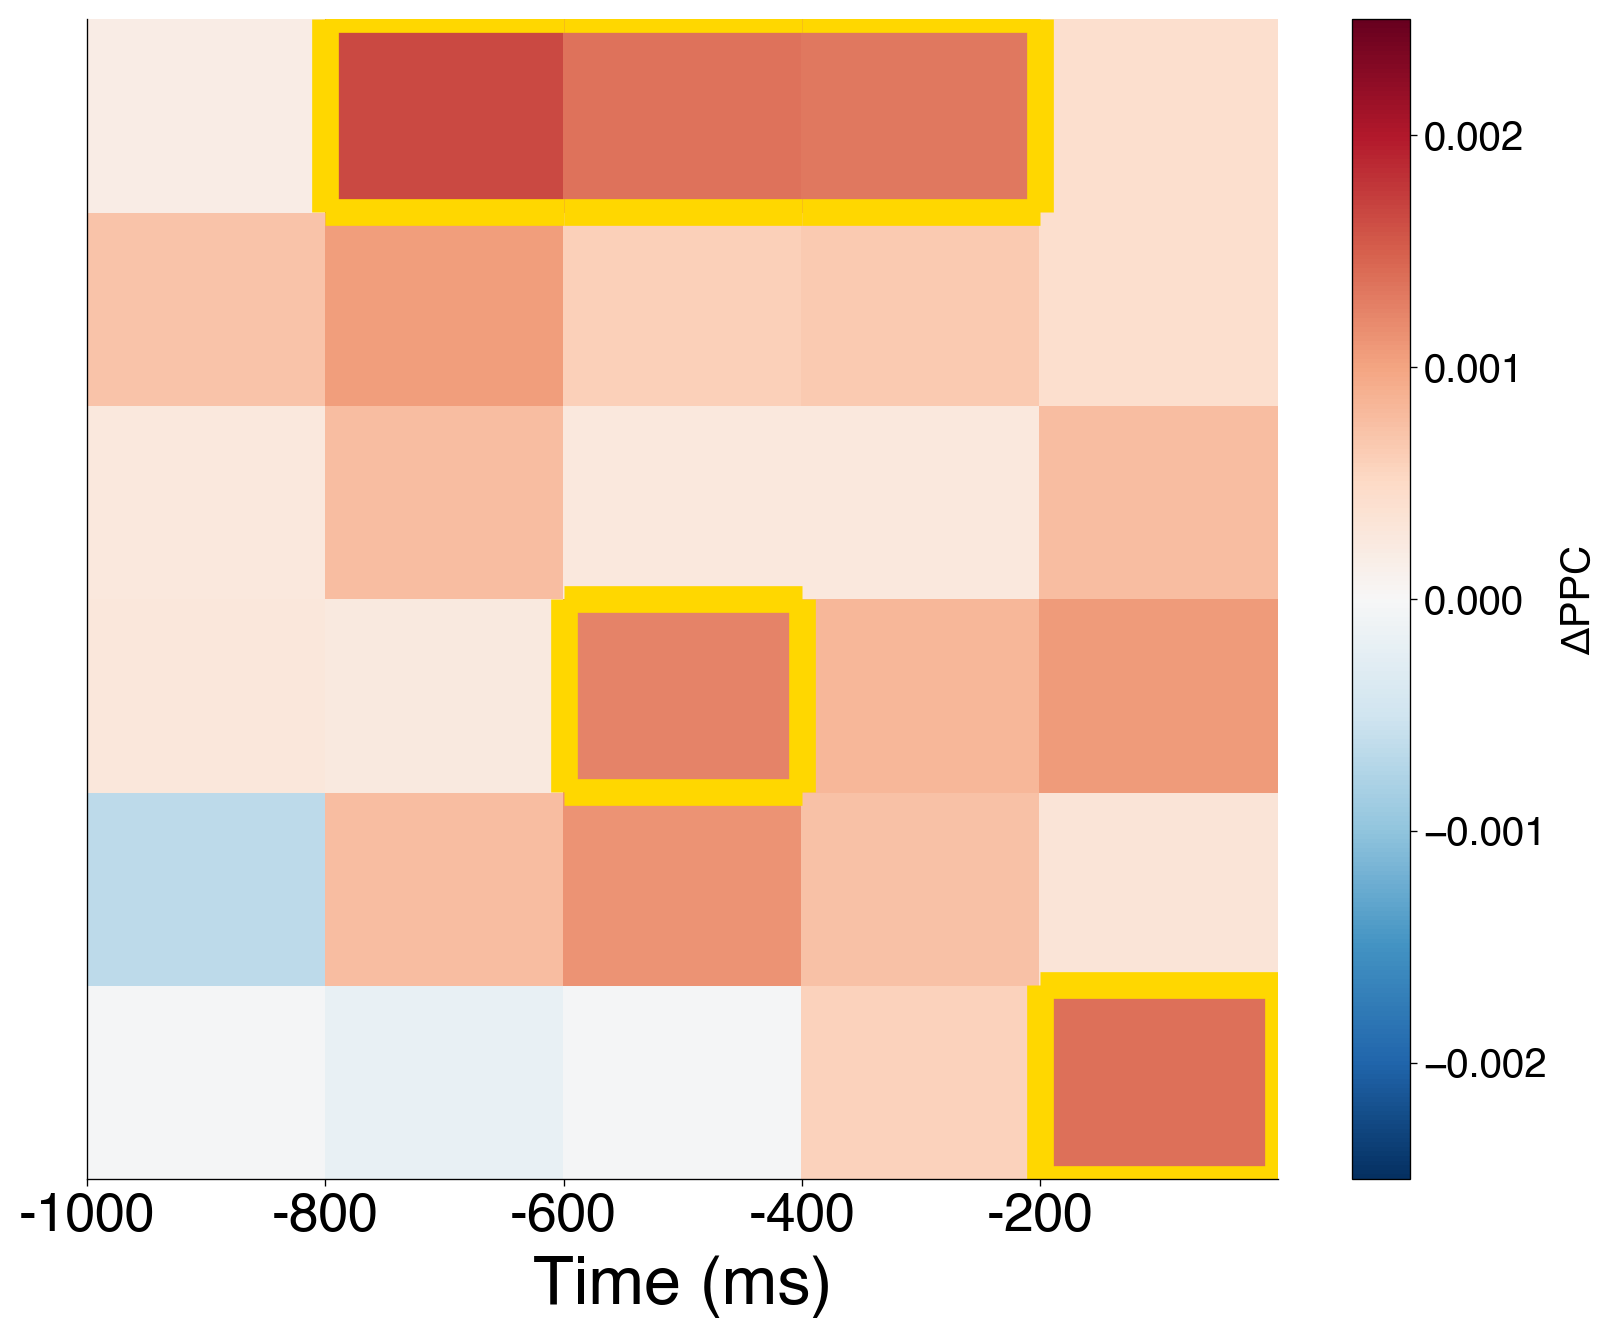

In [295]:
beh='en'

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False 
fig, ax = plt.subplots(figsize=(10, 8),dpi=192)
plt.title('')

mx_plot = tf_plots[beh]
stat_sig_mask = stat_sig_masks[beh]
maxabsval = np.max(np.abs(mx_plot))
maxval = 0.0025
minval = -0.0025

yticks = np.arange(3, 9) if beh == 'en' else ''
leglabel = 'ΔPPC'
xticks = beh_to_epochs[beh]
xlabel = 'Time (ms)'
ylabel = 'Frequency (Hz)' if beh == 'en' else ''

shape = mx_plot.shape
im = plt.imshow(mx_plot, 
                extent=np.asarray([0, shape[1], 0, shape[0]]), 
                origin='lower',
                aspect='auto',
                cmap='RdBu_r',
                vmin=minval,
                vmax=maxval)
fontsize = 25
ax.set_xlabel(xlabel, fontsize=fontsize)
ax.set_ylabel(ylabel, fontsize=fontsize)
if beh == 'ri':
    cb = plt.colorbar()
    cb.set_label('ΔPPC', fontsize=15)
    for tick in cb.ax.get_yticklabels():
        tick.set_fontname('Helvetica')
        tick.set_fontsize(15)
        
fontsize = 20
plt.xticks(range(len(xticks)), xticks, fontsize=fontsize)
plt.yticks(range(len(yticks)), yticks, fontsize=fontsize)
for label in ax.get_yticklabels():
    label.set_verticalalignment('bottom')
    
extent = im.get_extent()
combs = list(itertools.product(np.arange(stat_sig_mask.shape[0]), np.arange(stat_sig_mask.shape[1])))
masked_cells = [(i, j) for (i, j) in combs if stat_sig_mask[i, j] == 1]
shape = mx_plot.shape
linewidth = 10
color = 'yellow'
line_kwargs={"linewidth":4, "color":'k'}

color='gold'
for cell in masked_cells:
    i, j = cell
    if (i, j-1) not in masked_cells:
        ax.vlines([j], i, i+1, 'r', color=color, linewidth=linewidth)
    if (i, j+1) not in masked_cells:
        ax.vlines([j+1], i, i+1, 'r', color=color, linewidth=linewidth)
    if (i+1, j) not in masked_cells:
        ax.hlines([i+1], j, j+1, 'r', color=color, linewidth=linewidth)
    if (i-1, j) not in masked_cells:
        ax.hlines([i], j, j+1, 'r', color=color, linewidth=linewidth)

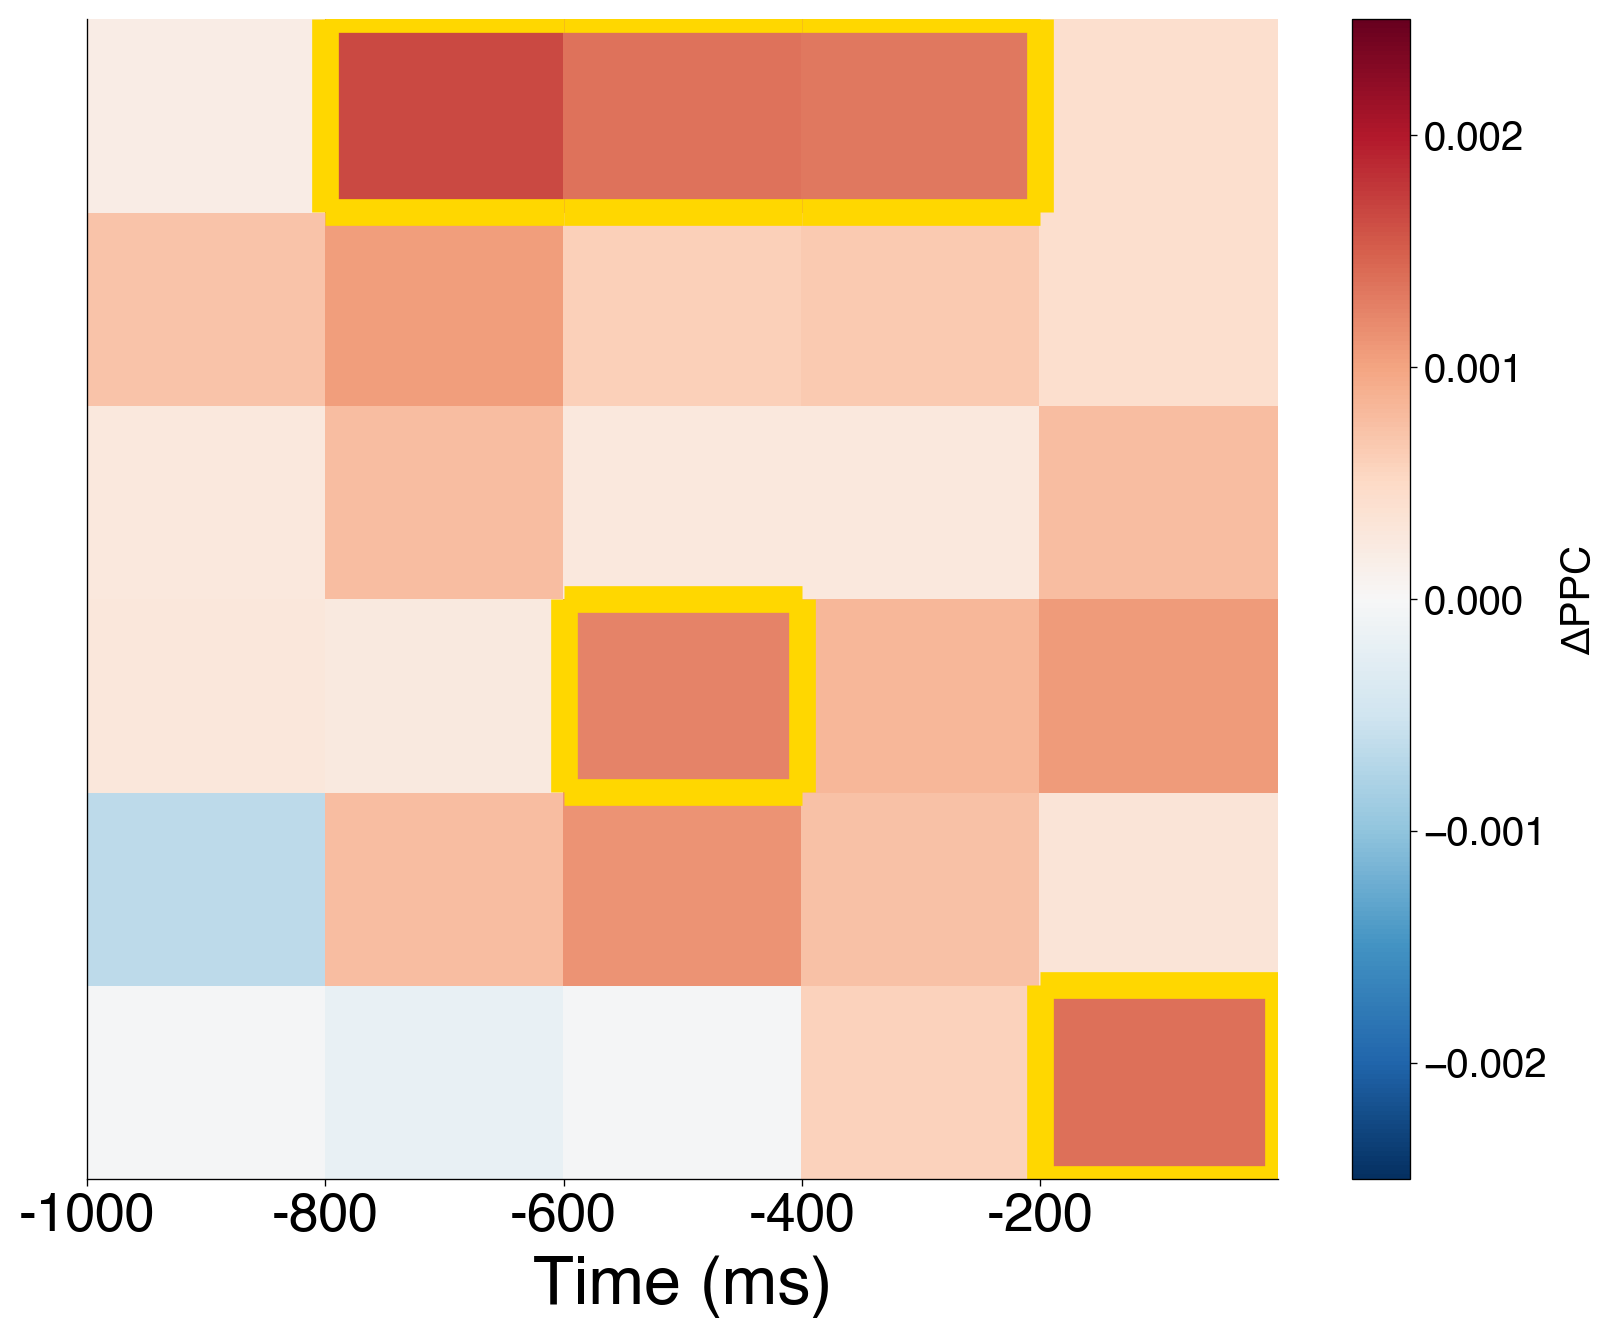

In [295]:
beh='rm'

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False 
fig, ax = plt.subplots(figsize=(10, 8),dpi=192)
plt.title('')

mx_plot = tf_plots[beh]
stat_sig_mask = stat_sig_masks[beh]
maxabsval = np.max(np.abs(mx_plot))
maxval = 0.0025
minval = -0.0025

yticks = np.arange(3, 9) if beh == 'en' else ''
leglabel = 'ΔPPC'
xticks = beh_to_epochs[beh]
xlabel = 'Time (ms)'
ylabel = 'Frequency (Hz)' if beh == 'en' else ''

shape = mx_plot.shape
im = plt.imshow(mx_plot, 
                extent=np.asarray([0, shape[1], 0, shape[0]]), 
                origin='lower',
                aspect='auto',
                cmap='RdBu_r',
                vmin=minval,
                vmax=maxval)
fontsize = 25
ax.set_xlabel(xlabel, fontsize=fontsize)
ax.set_ylabel(ylabel, fontsize=fontsize)
if beh == 'ri':
    cb = plt.colorbar()
    cb.set_label('ΔPPC', fontsize=15)
    for tick in cb.ax.get_yticklabels():
        tick.set_fontname('Helvetica')
        tick.set_fontsize(15)
        
fontsize = 20
plt.xticks(range(len(xticks)), xticks, fontsize=fontsize)
plt.yticks(range(len(yticks)), yticks, fontsize=fontsize)
for label in ax.get_yticklabels():
    label.set_verticalalignment('bottom')
    
extent = im.get_extent()
combs = list(itertools.product(np.arange(stat_sig_mask.shape[0]), np.arange(stat_sig_mask.shape[1])))
masked_cells = [(i, j) for (i, j) in combs if stat_sig_mask[i, j] == 1]
shape = mx_plot.shape
linewidth = 10
color = 'yellow'
line_kwargs={"linewidth":4, "color":'k'}

color='gold'
for cell in masked_cells:
    i, j = cell
    if (i, j-1) not in masked_cells:
        ax.vlines([j], i, i+1, 'r', color=color, linewidth=linewidth)
    if (i, j+1) not in masked_cells:
        ax.vlines([j+1], i, i+1, 'r', color=color, linewidth=linewidth)
    if (i+1, j) not in masked_cells:
        ax.hlines([i+1], j, j+1, 'r', color=color, linewidth=linewidth)
    if (i-1, j) not in masked_cells:
        ax.hlines([i], j, j+1, 'r', color=color, linewidth=linewidth)

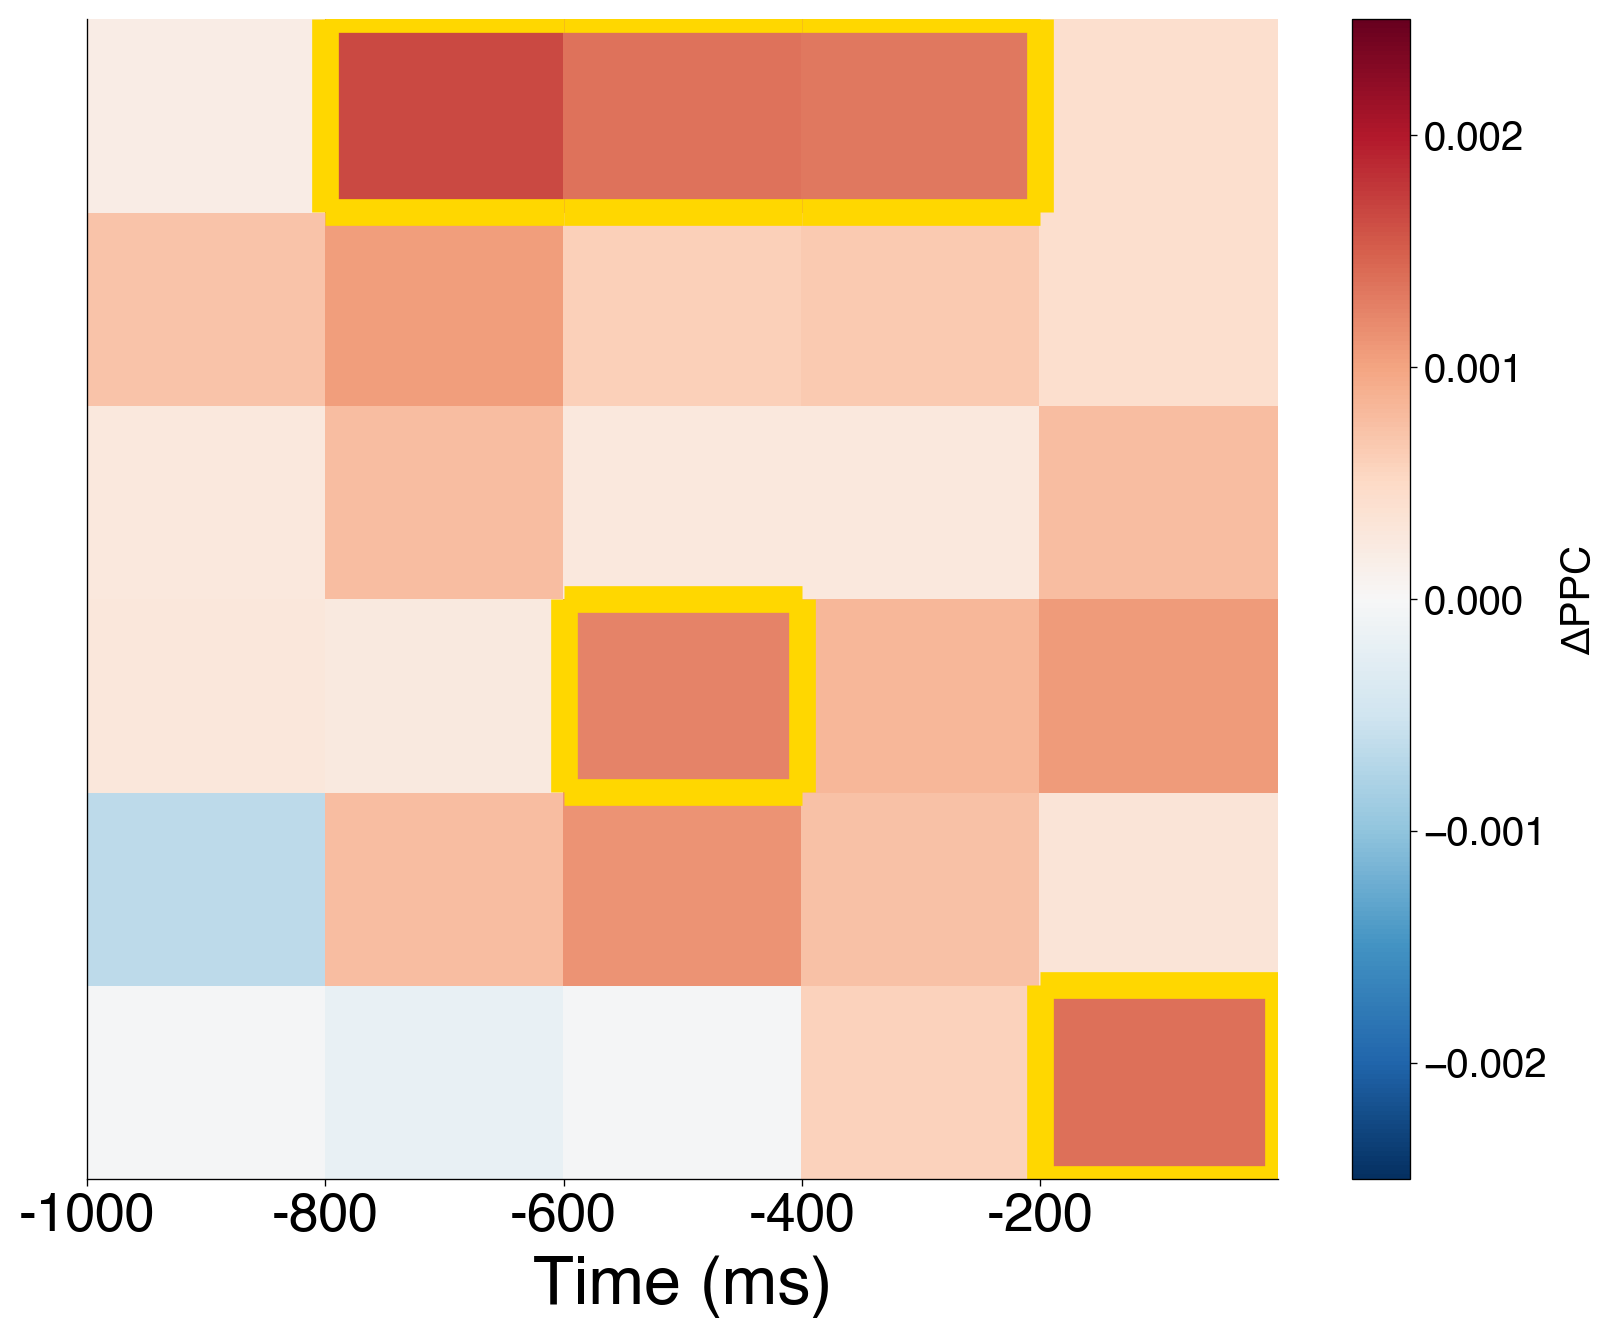

In [295]:
beh='ri'

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False 
fig, ax = plt.subplots(figsize=(10, 8),dpi=192)
plt.title('')

mx_plot = tf_plots[beh]
stat_sig_mask = stat_sig_masks[beh]
maxabsval = np.max(np.abs(mx_plot))
maxval = 0.0025
minval = -0.0025

yticks = np.arange(3, 9) if beh == 'en' else ''
leglabel = 'ΔPPC'
xticks = beh_to_epochs[beh]
xlabel = 'Time (ms)'
ylabel = 'Frequency (Hz)' if beh == 'en' else ''

shape = mx_plot.shape
im = plt.imshow(mx_plot, 
                extent=np.asarray([0, shape[1], 0, shape[0]]), 
                origin='lower',
                aspect='auto',
                cmap='RdBu_r',
                vmin=minval,
                vmax=maxval)
fontsize = 25
ax.set_xlabel(xlabel, fontsize=fontsize)
ax.set_ylabel(ylabel, fontsize=fontsize)
if beh == 'ri':
    cb = plt.colorbar()
    cb.set_label('ΔPPC', fontsize=15)
    for tick in cb.ax.get_yticklabels():
        tick.set_fontname('Helvetica')
        tick.set_fontsize(15)
        
fontsize = 20
plt.xticks(range(len(xticks)), xticks, fontsize=fontsize)
plt.yticks(range(len(yticks)), yticks, fontsize=fontsize)
for label in ax.get_yticklabels():
    label.set_verticalalignment('bottom')
    
extent = im.get_extent()
combs = list(itertools.product(np.arange(stat_sig_mask.shape[0]), np.arange(stat_sig_mask.shape[1])))
masked_cells = [(i, j) for (i, j) in combs if stat_sig_mask[i, j] == 1]
shape = mx_plot.shape
linewidth = 10
color = 'yellow'
line_kwargs={"linewidth":4, "color":'k'}

color='gold'
for cell in masked_cells:
    i, j = cell
    if (i, j-1) not in masked_cells:
        ax.vlines([j], i, i+1, 'r', color=color, linewidth=linewidth)
    if (i, j+1) not in masked_cells:
        ax.vlines([j+1], i, i+1, 'r', color=color, linewidth=linewidth)
    if (i+1, j) not in masked_cells:
        ax.hlines([i+1], j, j+1, 'r', color=color, linewidth=linewidth)
    if (i-1, j) not in masked_cells:
        ax.hlines([i], j, j+1, 'r', color=color, linewidth=linewidth)

# Difference in memory-evoked synchrony between 3 Hz and 8 Hz

In [2]:
for beh in ['en', 'rm', 'ri']:
    
    fname = join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(fname)
    mx = mx.mean('epoch').mean('reg2').mean('reg1')
    mx = mx.sel(success=1) - mx.sel(success=0)
    print_ttest_1samp(mx.sel(freq=3).data, beh)
    

---------en---------
NOT Statistically Significant (p >= 0.05)
t_377 = 0.976, p = 0.329, Mean: 0.000108 ± 0.00011
---------rm---------
Statistically Significant (p < 0.05)
t_377 = 7.34, p = 1.37e-12, Mean: 0.00174 ± 0.000237
---------ri---------
NOT Statistically Significant (p >= 0.05)
t_166 = 0.669, p = 0.504, Mean: 0.000344 ± 0.000513


In [3]:
for beh in ['en', 'rm', 'ri']:
    
    fname = join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(fname)
    mx = mx.mean('epoch').mean('reg2').mean('reg1')
    mx = mx.sel(success=1) - mx.sel(success=0)
    print_ttest_1samp(mx.sel(freq=8).data, beh)
    

---------en---------
Statistically Significant (p < 0.05)
t_377 = 2.94, p = 0.00347, Mean: 0.000227 ± 7.73e-05
---------rm---------
Statistically Significant (p < 0.05)
t_377 = 2.99, p = 0.00296, Mean: 0.000482 ± 0.000161
---------ri---------
Statistically Significant (p < 0.05)
t_166 = 2.86, p = 0.00485, Mean: 0.000988 ± 0.000346


In [4]:
for beh in ['en', 'rm', 'ri']:
    
    fname = join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(fname)
    mx = mx.mean('epoch').mean('reg2').mean('reg1')
    mx = mx.sel(success=1) - mx.sel(success=0)
    t, p = print_ttest_rel(mx.sel(freq=3).data, mx.sel(freq=8).data, beh)
    N = len(mx.sub)
    print(f'B_01: {jzs_bayes_factor(t, N)}')
    

---------en---------
NOT Statistically Significant (p >= 0.05)
t_377 = -0.899, p = 0.369, Mean_A: 0.000108 ± 0.00011, Mean_B: 0.000227 ± 7.73e-05, Mean_Diff: -0.00012 ± 0.000133
B_01: 16.330205681714144
---------rm---------
Statistically Significant (p < 0.05)
t_377 = 4.42, p = 1.27e-05, Mean_A: 0.00174 ± 0.000237, Mean_B: 0.000482 ± 0.000161, Mean_Diff: 0.00126 ± 0.000285
B_01: 0.0017981371281969017
---------ri---------
NOT Statistically Significant (p >= 0.05)
t_166 = -0.973, p = 0.332, Mean_A: 0.000344 ± 0.000513, Mean_B: 0.000988 ± 0.000346, Mean_Diff: -0.000644 ± 0.000662
B_01: 10.190785131989594


## Figure 4A

In [1237]:
fig4_df = pd.DataFrame([], columns=['beh', 'freq', 'data'])
for beh in ['en', 'rm', 'ri']:
    fname = join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(fname)
    mx = mx.mean('epoch').mean('reg2').mean('reg1')
    mx = mx.sel(success=1) - mx.sel(success=0)
    for freq in [3, 8]:
        fig4_df = pd.concat([fig4_df, pd.DataFrame({'beh': beh,
                                                    'freq': freq,
                                                    'data': mx.sel(freq=freq).data})],
                            ignore_index=True,
                            axis=0)
fig4_df = fig4_df.replace({'en': 'Encoding',
                           'rm': 'Retrieval',
                           'ri': 'Recall Accuracy',
                            3: '3 Hz',
                            8: '8 Hz'})
fig4_df.to_json(join(root_dir, 'fig4_df.json'))

Text(0, 0.5, 'ΔPPC')

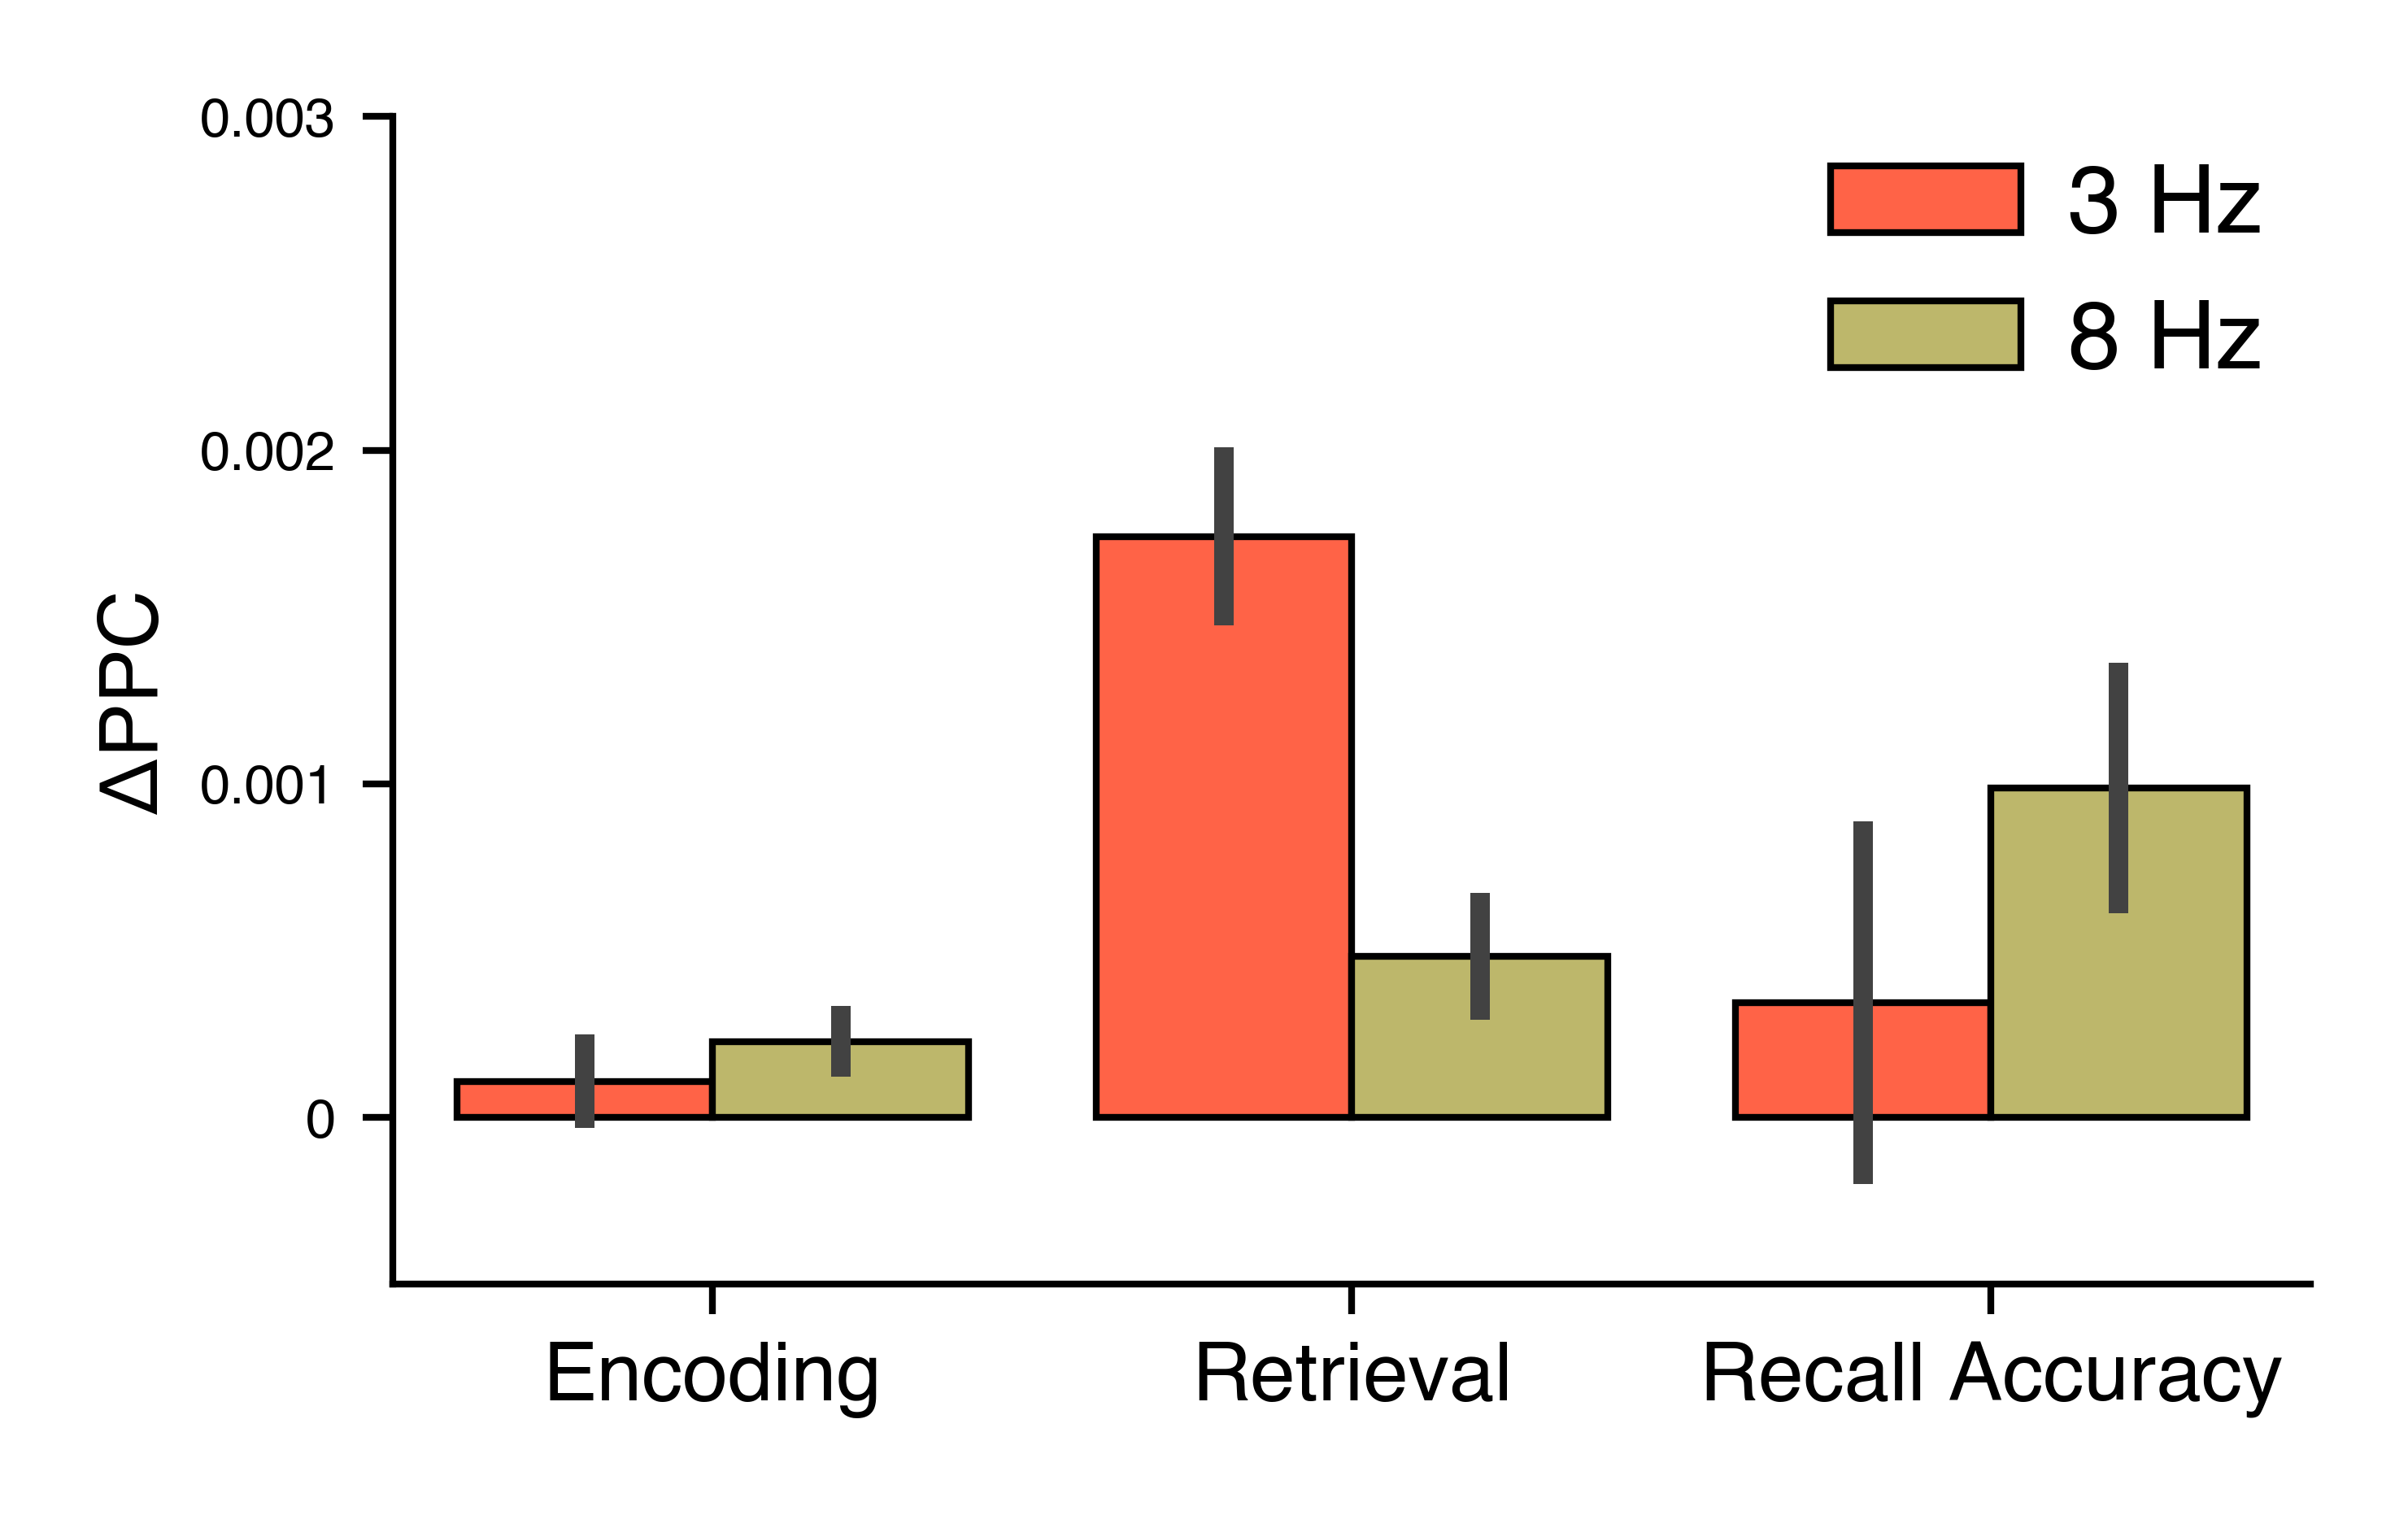

In [1239]:
from collections import OrderedDict as od
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('/home1/dscho/code/general/preferred.mplstyle')
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from formatting import *

colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

import matplotlib.font_manager as font_manager

font_dirs = ['/home1/amrao/SUPL']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
figsize = (colws[2]*0.8, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = -0.0005
ymax = 0.003
yticks = [0, .001, .002, .003]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.barplot(x='beh', y='data', hue='freq', data=fig4_df, ax=_ax,
                  saturation=1, alpha=bar_alpha, zorder=0,
                  errorbar='se', lw=spine_lw, ec='k',
                 palette=['tomato', 'darkkhaki'])
_ax.legend(fontsize=7, handletextpad=0.5, title=None)

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=6)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('ΔPPC', fontsize=font['label'], labelpad=2)
# if _ax.get_legend():
#     _ax.get_legend().remove()


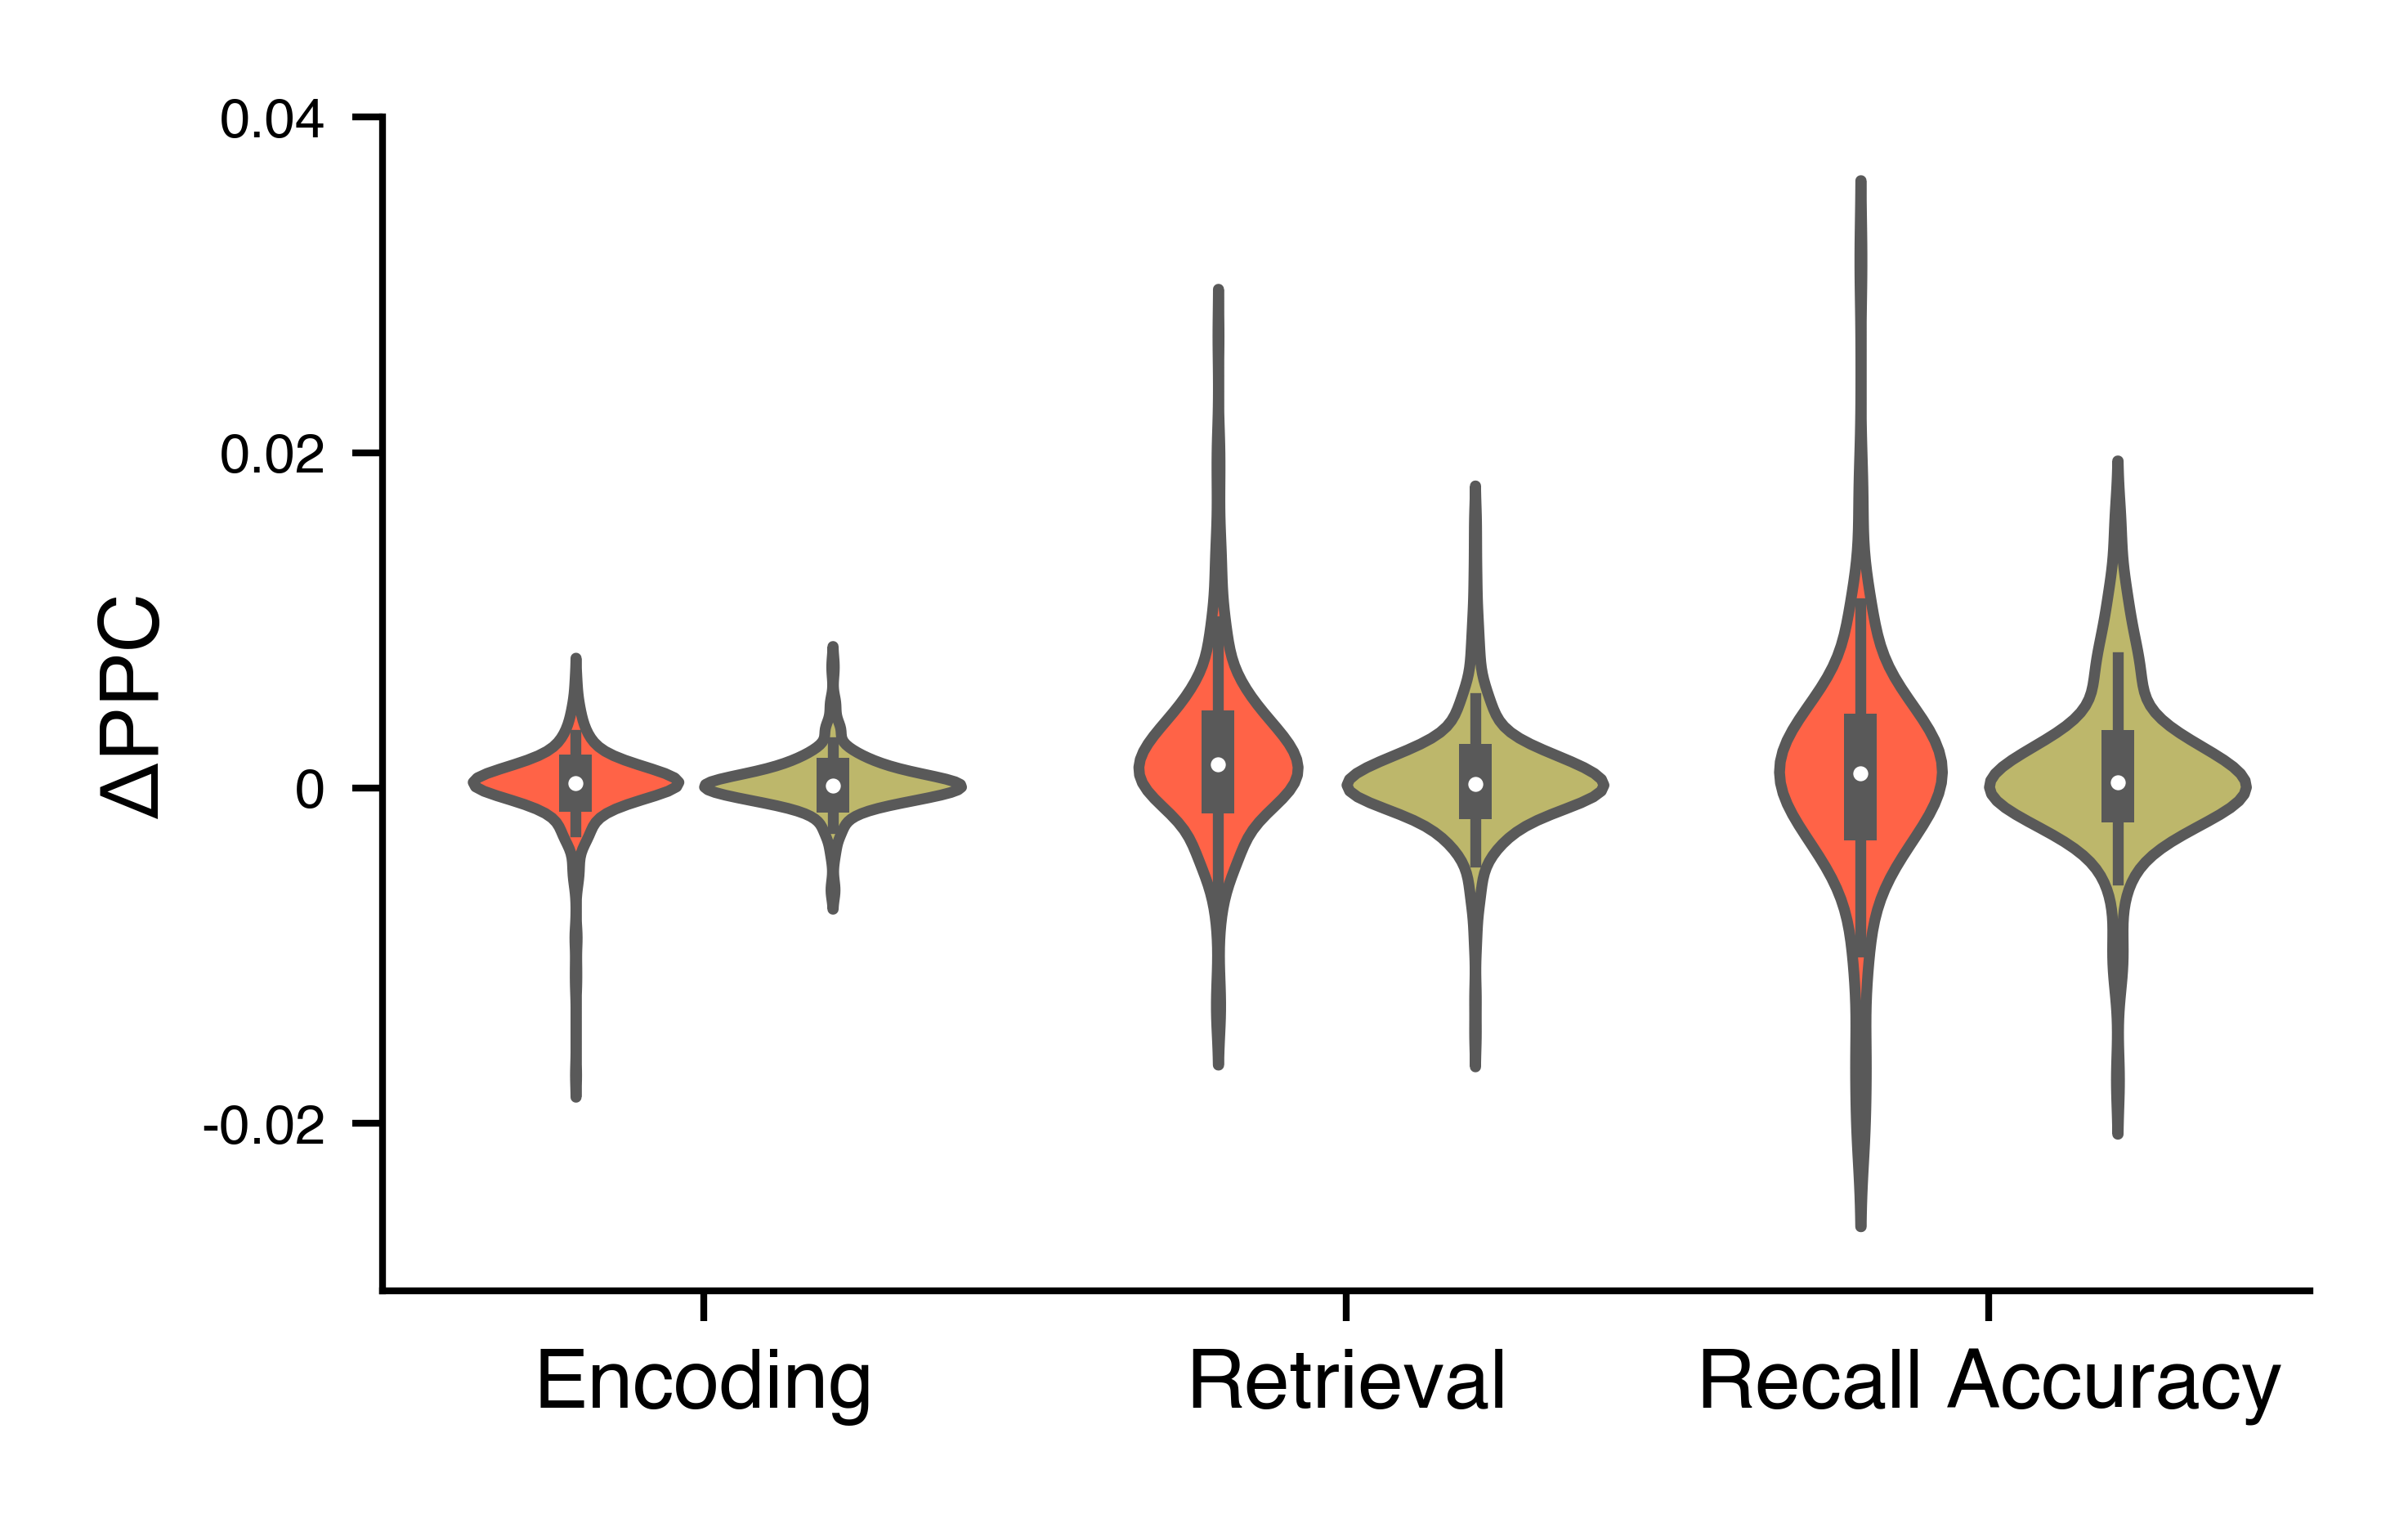

In [1241]:
from collections import OrderedDict as od
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('/home1/dscho/code/general/preferred.mplstyle')
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from formatting import *

colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

import matplotlib.font_manager as font_manager

font_dirs = ['/home1/amrao/SUPL']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
figsize = (colws[2]*0.8, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = -0.03
ymax = 0.04
yticks = [-0.02, 0, 0.02, 0.04]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.violinplot(x='beh', y='data', hue='freq', data=fig4_df, ax=_ax,
                  saturation=1, 
                  alpha=bar_alpha, 
                  zorder=0,
                  errorbar='se', 
                  lw=spine_lw, 
                  ec='k',
                 palette=['tomato', 'darkkhaki'])
_ax.legend(fontsize=7, handletextpad=0.5, title=None)

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=6)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('ΔPPC', fontsize=font['label'], labelpad=2)
if _ax.get_legend():
    _ax.get_legend().remove()


# Encoding–retrieval correlation

In [53]:
import shutil
split_dir_path = join(root_dir, 'rm_split')
if ex(split_dir_path): shutil.rmtree(split_dir_path)
split_dir_path = join(root_dir, 'ri_split')
if ex(split_dir_path): shutil.rmtree(split_dir_path)

In [19]:
split_dir_path = join(root_dir, 'rm_split')
if not ex(split_dir_path): os.mkdir(split_dir_path)
for f1 in ['a', 'b']:
    path = join(split_dir_path, f1)
    if not ex(path): os.mkdir(path)
    for f2 in ['events', 'elsymxs', 'regsymxs']:
        path = join(split_dir_path, f1, f2)
        if not ex(path): os.mkdir(path)

In [20]:
def run_split_rm_events(dfrow):
    
    np.random.seed(202406)
        
    dfrow = get_dfrow(dfrow)
    rm_events = load_events(dfrow, 'rm')    
    pair_count = len(rm_events)//2
    rm_events['pair_idx'] = np.arange(0, pair_count, 0.5).astype(int)
    
    pair_idxs = rm_events['pair_idx'].unique()
    np.random.shuffle(pair_idxs)
    first_group_idxs, second_group_idxs = np.array_split(pair_idxs, 2)
    
    first_group = rm_events.query('pair_idx in @first_group_idxs')
    second_group = rm_events.query('pair_idx in @second_group_idxs')

    first_group.to_json(join(root_dir, 'rm_split', 'a', 'events', f'{ftag(dfrow)}_rm_events_split_a.json'))
    second_group.to_json(join(root_dir, 'rm_split', 'b', 'events', f'{ftag(dfrow)}_rm_events_split_b.json'))
        

In [21]:
def run_pipeline_rm_split(dfrow):
    
    dfrow = get_dfrow(dfrow)
    for split_idx in ['a', 'b']:
        save_dir = join(root_dir, 'rm_split', split_idx)
        events_path = join(save_dir, 'events', f'{ftag(dfrow)}_rm_events_split_{split_idx}.json')
        if not ex(events_path): run_split_rm_events(dfrow)
        events = pd.read_json(events_path)
        events.attrs['beh'] = 'rm'
        events.attrs['mask'] = (events['type'] == 'REC_WORD').values
        if ex(join(save_dir, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')): continue
        run_pipeline(dfrow, 'rm', events, save_dir)

In [22]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [23]:
client = cl('run_pipeline_rm_split', '10G', int(3000/10), walltime=100000) 
futures = client.map(run_pipeline_rm_split, sess_list)

Unique port for amrao is 51507
{'dashboard_address': ':51507'}
To view the dashboard, run: 
`ssh -fN amrao@rhino2.psych.upenn.edu -L 8000:192.168.86.141:51507` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


In [30]:
client.shutdown()
client2.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [29]:
get_ex(futures,sess_list)

exception  \
param                                                                       
[R1001P, FR1, 0, 0, 0]  KeyError('[16, 17, 7, 5, 6, 4, 1, 0, 12, 13] n...   
[R1001P, FR1, 1, 0, 0]  KeyError('[7, 3, 6, 2, 12, 13, 0, 1, 5, 4] not...   
[R1002P, FR1, 0, 0, 0]  KeyError('[5, 22, 17, 4, 16, 23, 28, 29, 13, 3...   
[R1002P, FR1, 1, 0, 0]  KeyError('[4, 5, 3, 9, 2, 7, 8, 20, 6, 21, 0, ...   
[R1003P, FR1, 0, 0, 0]  KeyError('[17, 21, 16, 20, 1, 8, 0, 9, 6, 7, 5...   
[R1003P, FR1, 1, 0, 0]  KeyError('[0, 1, 12, 13, 6, 7, 2, 3] not in in...   
[R1006P, FR1, 0, 0, 0]  KeyError('[5, 4, 17, 16, 26, 7, 27, 1, 6, 0, 1...   
[R1006P, FR1, 1, 0, 0]  KeyError('[16, 4, 17, 5, 7, 13, 6, 12, 1, 3, 2...   

                                               traceback_obj  
param                                                         
[R1001P, FR1, 0, 0, 0]  <traceback object at 0x2ad849be0690>  
[R1001P, FR1, 1, 0, 0]  <traceback object at 0x2ad849d44960>  
[R1002P, FR1, 0, 0, 0]  <traceback object at 0x2ad849ed9a00>  
[R1002P, FR1, 1, 0, 0]  <traceback object at 0x2ad849f5a230>  
[R1003P, FR1, 0, 0, 0]  <traceback object at 0x2ad849f9e870>  
[R1003P, FR1, 1, 0, 0]  <traceback object at 0x2ad849fc3d70>  
[R1006P, FR1, 0, 0, 0]  <traceback object at 0x2ad849d21eb0>  
[R1006P, FR1, 1, 0, 0]  <traceback object at 0x2ad84a28f3c0>

In [24]:
split_dir_path = join(root_dir, 'ri_split')
if not ex(split_dir_path): os.mkdir(split_dir_path)
for f1 in ['a', 'b']:
    path = join(split_dir_path, f1)
    if not ex(path): os.mkdir(path)
    for f2 in ['events', 'elsymxs', 'regsymxs']:
        path = join(split_dir_path, f1, f2)
        if not ex(path): os.mkdir(path)

In [25]:
def run_split_ri_events(dfrow):
    
    np.random.seed(202406)
        
    dfrow = get_dfrow(dfrow)
    ri_events = load_events(dfrow, 'ri')    
    pair_count = len(ri_events)//2
    ri_events['pair_idx'] = np.arange(0, pair_count, 0.5).astype(int)
    
    pair_idxs = ri_events['pair_idx'].unique()
    np.random.shuffle(pair_idxs)
    first_group_idxs, second_group_idxs = np.array_split(pair_idxs, 2)
    
    first_group = ri_events.query('pair_idx in @first_group_idxs')
    second_group = ri_events.query('pair_idx in @second_group_idxs')

    first_group.to_json(join(root_dir, 'ri_split', 'a', 'events', f'{ftag(dfrow)}_ri_events_split_a.json'))
    second_group.to_json(join(root_dir, 'ri_split', 'b', 'events', f'{ftag(dfrow)}_ri_events_split_b.json'))
        

In [26]:
def run_pipeline_ri_split(dfrow):
    
    dfrow = get_dfrow(dfrow)
    for split_idx in ['a', 'b']:
        save_dir = join(root_dir, 'ri_split', split_idx)
        events_path = join(save_dir, 'events', f'{ftag(dfrow)}_ri_events_split_{split_idx}.json')
        if not ex(events_path): run_split_ri_events(dfrow)
        events = pd.read_json(events_path)
        events.attrs['beh'] = 'ri'
        events.attrs['mask'] = (events['correct'] == 1).values
        if ex(join(save_dir, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')): continue
        run_pipeline(dfrow, 'ri', events, save_dir)

In [27]:
sess_list_df_ri = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
sess_list_ri = sess_list_df_ri[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [28]:
client2 = cl('run_pipeline_ri_split', '10G', int(1000/10), walltime=100000) 
futures2 = client2.map(run_pipeline_ri_split, sess_list_ri)

Unique port for amrao is 51507
{'dashboard_address': ':51507'}
To view the dashboard, run: 
`ssh -fN amrao@rhino2.psych.upenn.edu -L 8000:192.168.86.141:38646` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 51507 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38646 instead
  f"Port {expected} is already in use.\n"


In [33]:
client.shutdown()
client2.shutdown()

In [29]:
get_ex(futures, sess_list)

Exception: None of the given futures resulted in exceptions

In [30]:
get_ex(futures2, sess_list_ri)

Exception: None of the given futures resulted in exceptions

In [37]:
len(ld(join(root_dir, 'ri_split', 'a', 'regsymxs')))

317

In [417]:
def apply_spearman_brown_correction(r): return (2*r)/(1+r)

def compute_intercontrast_correlations(beh1, beh2):
    
    if ('ri' in beh1) or ('ri' in beh2): sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
    else: sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
    
    sub_list = sess_list_df['sub'].unique()
    
    sub_corrs = []
    
    for iSub, sub in enumerate(sub_list):
        
        sess_corrs = []
        
        for iSess, rSess in sess_list_df.query('sub == @sub').iterrows():
            
            dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
            beh1_mx = npl(join(root_dir, beh1, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy'))
            beh2_mx = npl(join(root_dir, beh2, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy'))
    
            beh1_mx = beh1_mx[..., 0] - beh1_mx[..., 1]
            beh2_mx = beh2_mx[..., 0] - beh2_mx[..., 1]
            
            beh1_mx = np.nanmean(np.nanmean(np.nanmean(beh1_mx, axis=-1), axis=-1), axis=-1)
            beh2_mx = np.nanmean(np.nanmean(np.nanmean(beh2_mx, axis=-1), axis=-1), axis=-1)
            
            r = scipy.stats.pearsonr(beh1_mx, beh2_mx)[0]
            if (beh1, beh2) in [('rm_split/a', 'rm_split/b'), ('rm_split/a', 'rm_split/b')]: 
                r = apply_spearman_brown_correction(r)

            sess_corrs.append(r)
            
        sub_corrs.append(np.mean(sess_corrs))
        
    return np.asarray(sub_corrs)
        

In [418]:
en_rm_sub_corrs = compute_intercontrast_correlations('en', 'rm')
print_ttest_1samp(en_rm_sub_corrs, header='en / rm correlation')

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


---------en / rm correlation---------
Statistically Significant (p < 0.05)
t_377 = 5.49, p = 7.43e-08, Mean: 0.04 ± 0.00728


(5.489211992850639, 7.428226963553986e-08)

In [7]:
en_rm_sub_corrs = compute_intercontrast_correlations('en', 'rm')
print_ttest_1samp(en_rm_sub_corrs, header='en / rm correlation')

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


---------en / rm correlation---------
Statistically Significant (p < 0.05)
t_377 = 5.42, p = 1.08e-07, Mean: 0.0393 ± 0.00725


(5.4174893640191994, 1.0796764926866547e-07)

In [8]:
rm_split_sub_corrs = compute_intercontrast_correlations('rm_split/a', 'rm_split/b')
print_ttest_1samp(rm_split_sub_corrs, header='rm split-half correlation')

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


---------rm split-half correlation---------
Statistically Significant (p < 0.05)
t_377 = 4.96, p = 1.05e-06, Mean: 0.0609 ± 0.0123


(4.9644340842815255, 1.0457417562935736e-06)

In [9]:
en_ri_sub_corrs = compute_intercontrast_correlations('en', 'ri')
print_ttest_1samp(en_ri_sub_corrs, header='en / ri correlation')

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


---------en / ri correlation---------
Statistically Significant (p < 0.05)
t_166 = 2.09, p = 0.0379, Mean: 0.0236 ± 0.0113


(2.0931752525359, 0.03785375118724519)

In [10]:
ri_split_sub_corrs = compute_intercontrast_correlations('ri_split/a', 'ri_split/b')
print_ttest_1samp(ri_split_sub_corrs, header='ri split-half correlation')

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


---------ri split-half correlation---------
NOT Statistically Significant (p >= 0.05)
t_166 = 0.766, p = 0.445, Mean: 0.00667 ± 0.00871


(0.7660263771584923, 0.4447484911259748)

In [11]:
en_rm_t, en_rm_p = print_ttest_rel(en_rm_sub_corrs, rm_split_sub_corrs)

NOT Statistically Significant (p >= 0.05)
t_377 = -1.63, p = 0.103, Mean_A: 0.0393 ± 0.00725, Mean_B: 0.0609 ± 0.0123, Mean_Diff: -0.0217 ± 0.0132


In [12]:
en_ri_t, en_ri_p = print_ttest_rel(en_ri_sub_corrs, ri_split_sub_corrs)

NOT Statistically Significant (p >= 0.05)
t_166 = 1.21, p = 0.23, Mean_A: 0.0236 ± 0.0113, Mean_B: 0.00667 ± 0.00871, Mean_Diff: 0.0169 ± 0.0141


In [13]:
jzs_bayes_factor(t = en_rm_t, N = 378)

6.471979595458714

In [14]:
jzs_bayes_factor(t = en_ri_t, N = 167)

7.938270298377941

In [29]:
en_rm_t

-1.6349570471283927

## Figure 5

In [ ]:
fig5_df = pd.DataFrame([], columns=['beh', 'type', 'data'])
for name, correlation_type, behs in zip(['Encoding / Retrieval', 'Encoding / Retrieval', 'Encoding / Recall Accuracy', 'Encoding / Recall Accuracy'],
                                        ['Observed', 'Benchmark', 'Observed', 'Benchmark'],
                                        [('en', 'rm'), ('rm_split/a', 'rm_split/b'), ('en', 'ri'), ('ri_split/a', 'ri_split/b')]):
    
    rs = compute_intercontrast_correlations(*behs)
    fig5_df = pd.concat([fig5_df, pd.DataFrame({'name': name,
                                                'correlation_type': correlation_type,
                                                'data': rs})],
                         axis=0)

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


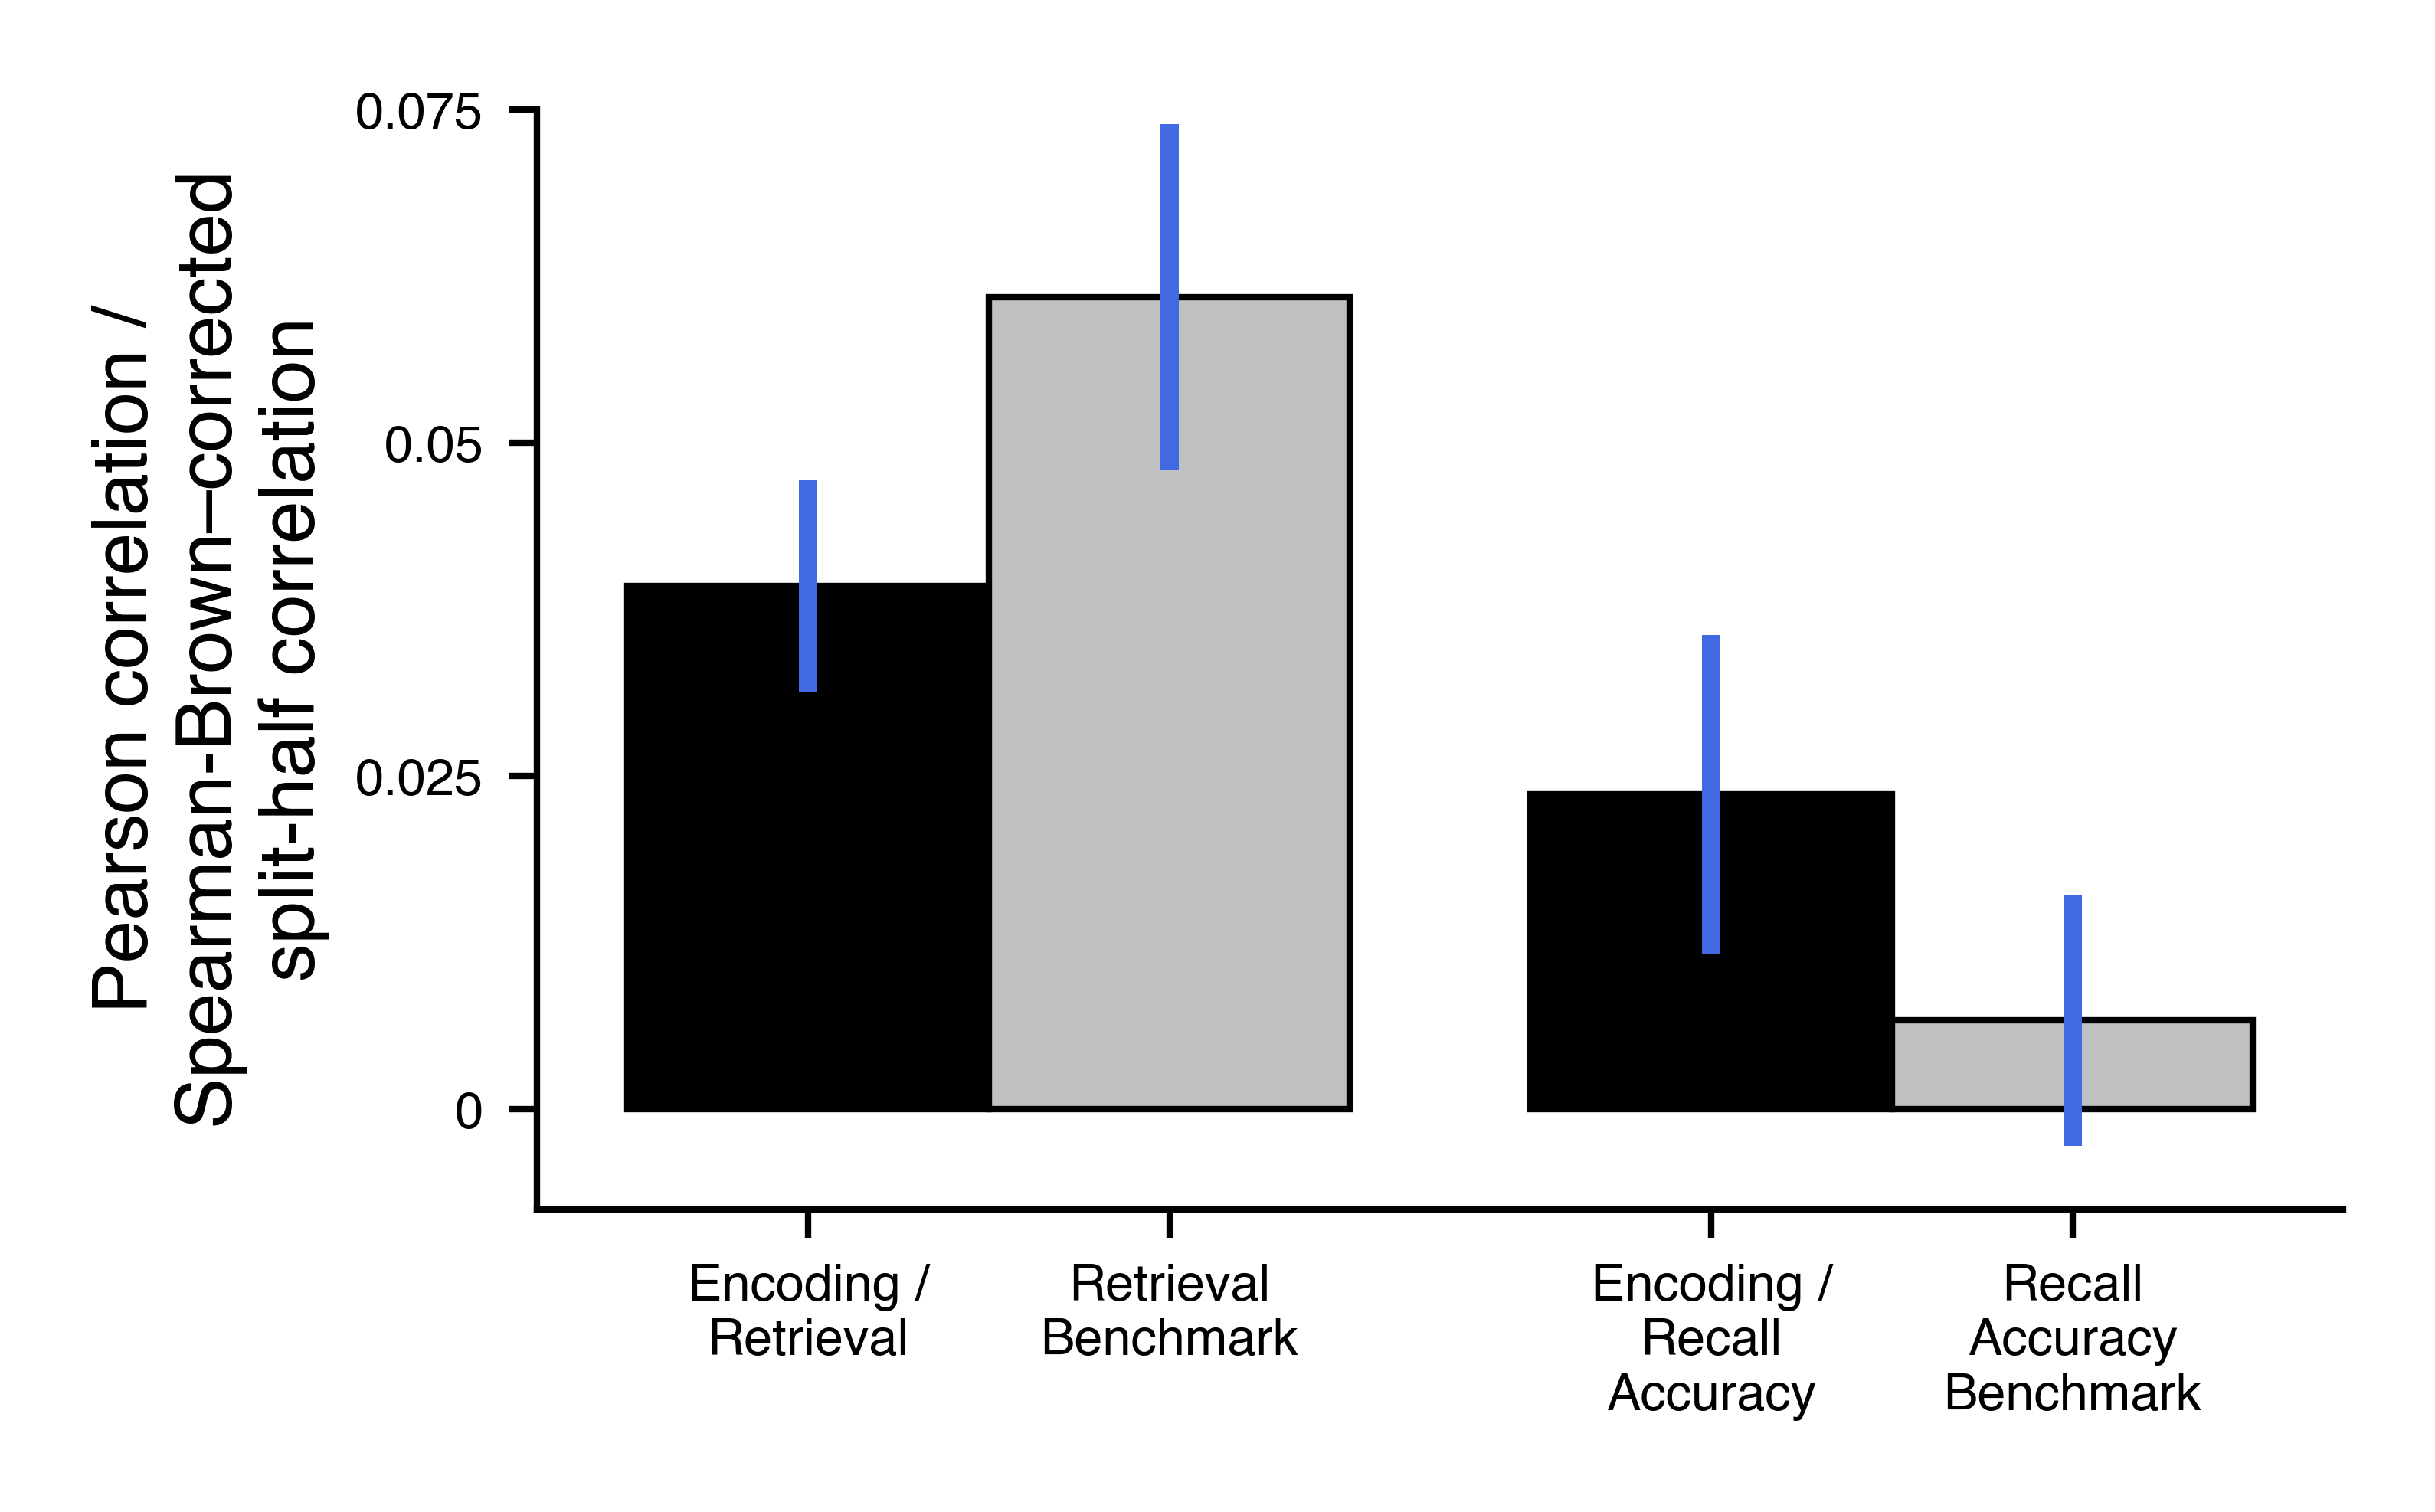

In [1246]:
from collections import OrderedDict as od
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('/home1/dscho/code/general/preferred.mplstyle')
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from formatting import *
import textwrap

colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

import matplotlib.font_manager as font_manager

font_dirs = ['/home1/amrao/SUPL']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
figsize = (colws[2]*0.8, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = -0.0075
ymax = 0.075
yticks = [0, 0.025, 0.05, 0.075]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.barplot(x='name', y='data', hue='correlation_type', data=fig5_df, ax=_ax,
                  saturation=1, alpha=bar_alpha, zorder=0,
                  errorbar='se', lw=spine_lw, ec='k', errcolor='royalblue',
                 palette=['black', 'silver'])
_ax.legend(fontsize=7, handletextpad=0.5, title=None)

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
labels = ['Encoding / Retrieval', 'Retrieval Benchmark', 'Encoding / Recall Accuracy', 'Recall Accuracy Benchmark']
labels = [textwrap.fill(label, width=10, break_long_words=True) for label in labels]
_ax.set_xticklabels(labels, fontsize=4)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel('Pearson correlation /\n Spearman-Brown–corrected\n split-half correlation', fontsize=font['label'], labelpad=2)
if _ax.get_legend():
    _ax.get_legend().remove()


# Power–synchrony correlation

Here we compute the within-subject correlation between the theta synchrony effect of memory and the theta or gamma power memory effect. The correlation is performed across electrode contacts between the mean brain-wide memory-evoked synchrony values and the memory-evoked power values, after averaging over frequencies and epochs. We then perform a 1-sample t-test against population mean zero to test the statistical significance of the correlation.

In [1248]:
def compute_power_synchrony_correlations(beh, freq):
    
    # assert freq in ['theta', *np.arange(3, 9)], 'freq must be specified as "theta" for theta average or as one of the theta frequencies'
    
    if beh == 'ri': sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
    else: sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
    sess_list_df = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].set_index(['sub', 'exp', 'sess', 'loc', 'mon'])
    sess_list_df['correlation'] = np.nan
    
    def compute_power_synchrony_correlation(r):
        
        dfrow = get_dfrow(r.name)
        freq_band = 'gamma' if freq == 'gamma' else 'theta'
        symx_fname = join(root_dir, beh, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
        pomx_fname = join(root_dir, beh, 'elpomxs', freq_band, f'{ftag(dfrow)}_elpomxd.npy')
        
        symx = npl(symx_fname)
        pomx = npl(pomx_fname)
        
        symx = symx[...,0] - symx[...,1]
        if freq in ['theta', 'gamma']:
            symx = np.nanmean(np.nanmean(np.nanmean(symx, axis=-1), axis=-1), axis=-1)
            pomx = np.nanmean(np.nanmean(pomx, axis=-1), axis=-1)
        else:
            symx = symx[:, :, (freq-3), :]
            pomx = pomx[:, (freq-3), :]
            symx = np.nanmean(np.nanmean(symx, axis=-1), axis=-1)
            pomx = np.nanmean(pomx, axis=-1)
        
        where_finite = np.isfinite(symx) & np.isfinite(pomx)
        symx = symx[where_finite]
        pomx = pomx[where_finite]

        return scipy.stats.pearsonr(symx, pomx)[0]
    
    sess_list_df['correlation'] = sess_list_df.apply(lambda r: compute_power_synchrony_correlation(r), axis=1)
    
    return sess_list_df.groupby('sub')['correlation'].mean().values
    

In [21]:
rs = compute_power_synchrony_correlations('en', 'theta')
print_ttest_1samp(rs, header='en theta power / theta synchrony correlation')

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


---------en theta power / theta synchrony correlation---------
Statistically Significant (p < 0.05)
t_377 = 46.7, p = 9.13e-159, Mean: 0.281 ± 0.00601


(46.680593788369634, 9.131991156504497e-159)

In [22]:
rs = compute_power_synchrony_correlations('rm', 'theta')
print_ttest_1samp(rs, header='rm theta power / theta synchrony correlation')

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


---------rm theta power / theta synchrony correlation---------
Statistically Significant (p < 0.05)
t_377 = 44.1, p = 5.04e-151, Mean: 0.27 ± 0.00612


(44.14216045802711, 5.042122447710047e-151)

In [23]:
rs = compute_power_synchrony_correlations('ri', 'theta')
print_ttest_1samp(rs, header='ri theta power / theta synchrony correlation')

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


---------ri theta power / theta synchrony correlation---------
Statistically Significant (p < 0.05)
t_166 = 24.0, p = 8.96e-56, Mean: 0.223 ± 0.0093


(23.965197904641023, 8.958856592603174e-56)

In [24]:
for beh in ['en', 'rm', 'ri']:
    rs_38 = []
    for freq in [3, 8]:
        rs = compute_power_synchrony_correlations(beh, freq)
        print_ttest_1samp(rs, header=f'{beh} {freq} power / synchrony correlation')
        rs_38.append(rs)
    rs_38 = np.subtract(rs_38[0], rs_38[1])
    print_ttest_1samp(rs_38, header='diff')

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


---------en 3 power / synchrony correlation---------
Statistically Significant (p < 0.05)
t_377 = 48.3, p = 1.12e-163, Mean: 0.271 ± 0.00561
---------en 8 power / synchrony correlation---------
Statistically Significant (p < 0.05)
t_377 = 42.7, p = 1.45e-146, Mean: 0.262 ± 0.00613
---------diff---------
NOT Statistically Significant (p >= 0.05)
t_377 = 1.21, p = 0.229, Mean: 0.00934 ± 0.00775
---------rm 3 power / synchrony correlation---------
Statistically Significant (p < 0.05)
t_377 = 39.7, p = 8.9e-137, Mean: 0.233 ± 0.00588
---------rm 8 power / synchrony correlation---------
Statistically Significant (p < 0.05)
t_377 = 33.9, p = 2.38e-116, Mean: 0.229 ± 0.00675
---------diff---------
NOT Statistically Significant (p >= 0.05)
t_377 = 0.639, p = 0.523, Mean: 0.00496 ± 0.00777
---------ri 3 power / synchrony correlation---------
Statistically Significant (p < 0.05)
t_166 = 19.6, p = 4.4e-45, Mean: 0.198 ± 0.0101
---------ri 8 power / synchrony correlation---------
Statistically Sig

In [ ]:
rs = compute_power_synchrony_correlations('en', 'theta')
print_ttest_1samp(rs, header='en theta power / theta synchrony correlation')

In [ ]:
rs = compute_power_synchrony_correlations('rm', 'theta')
print_ttest_1samp(rs, header='rm theta power / theta synchrony correlation')

In [ ]:
rs = compute_power_synchrony_correlations('ri', 'theta')
print_ttest_1samp(rs, header='ri theta power / theta synchrony correlation')

In [25]:
rs = compute_power_synchrony_correlations('en', 'gamma')
print_ttest_1samp(rs, header='en gamma power / theta synchrony correlation')

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


---------en gamma power / theta synchrony correlation---------
Statistically Significant (p < 0.05)
t_377 = -3.22, p = 0.00142, Mean: -0.0165 ± 0.00515


(-3.2151986512833073, 0.0014160111670366207)

In [26]:
rs = compute_power_synchrony_correlations('rm', 'gamma')
print_ttest_1samp(rs, header='rm gamma power / theta synchrony correlation')

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


---------rm gamma power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_377 = 0.882, p = 0.378, Mean: 0.00486 ± 0.00551


(0.8821149820046634, 0.37827670838341076)

In [27]:
rs = compute_power_synchrony_correlations('ri', 'gamma')
print_ttest_1samp(rs, header='rm gamma power / theta synchrony correlation')

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


---------rm gamma power / theta synchrony correlation---------
NOT Statistically Significant (p >= 0.05)
t_166 = 0.533, p = 0.595, Mean: 0.00477 ± 0.00896


(0.532734192328286, 0.5949300114956333)

In [304]:
params_to_header = {'en': 'Encoding',
                    'rm': 'Retrieval',
                    'theta': 'Averaged over Theta Band',
                    3: '3 Hz',
                    8: '8 Hz'}
for beh, freq in list(itertools.product(['en', 'rm'], ['theta', 3, 8]):
    header = f'Correlation between {params_to_header[beh]}-Evoked Theta Power and Theta Synchrony, {params_to_header[freq]}'
    print_ttest_1samp(compute_power_synchrony_correlations(beh, freq), header=header)

SyntaxError: invalid syntax (<ipython-input-304-4b0e1917c37b>, line 6)

## Figure 6

In [1249]:
fig6_df = pd.DataFrame([], columns=['beh', 'freq', 'data'])
for beh in ['en', 'rm', 'ri']:
    for freq in ['theta', 3, 8]:
        rs = compute_power_synchrony_correlations(beh, freq)
        fig6_df = pd.concat([fig6_df, pd.DataFrame({'beh': beh,
                                                    'freq': f'{freq} Hz' if freq in [3, 8] else 'theta avg.',
                                                    'data': rs})],
                             axis=0)
fig6_df.replace({'en': 'Encoding', 'rm': 'Retrieval', 'ri': 'Recall Accuracy'}, inplace=True)

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


Text(0, 0.5, "Pearson\\'s \\textit{r}")

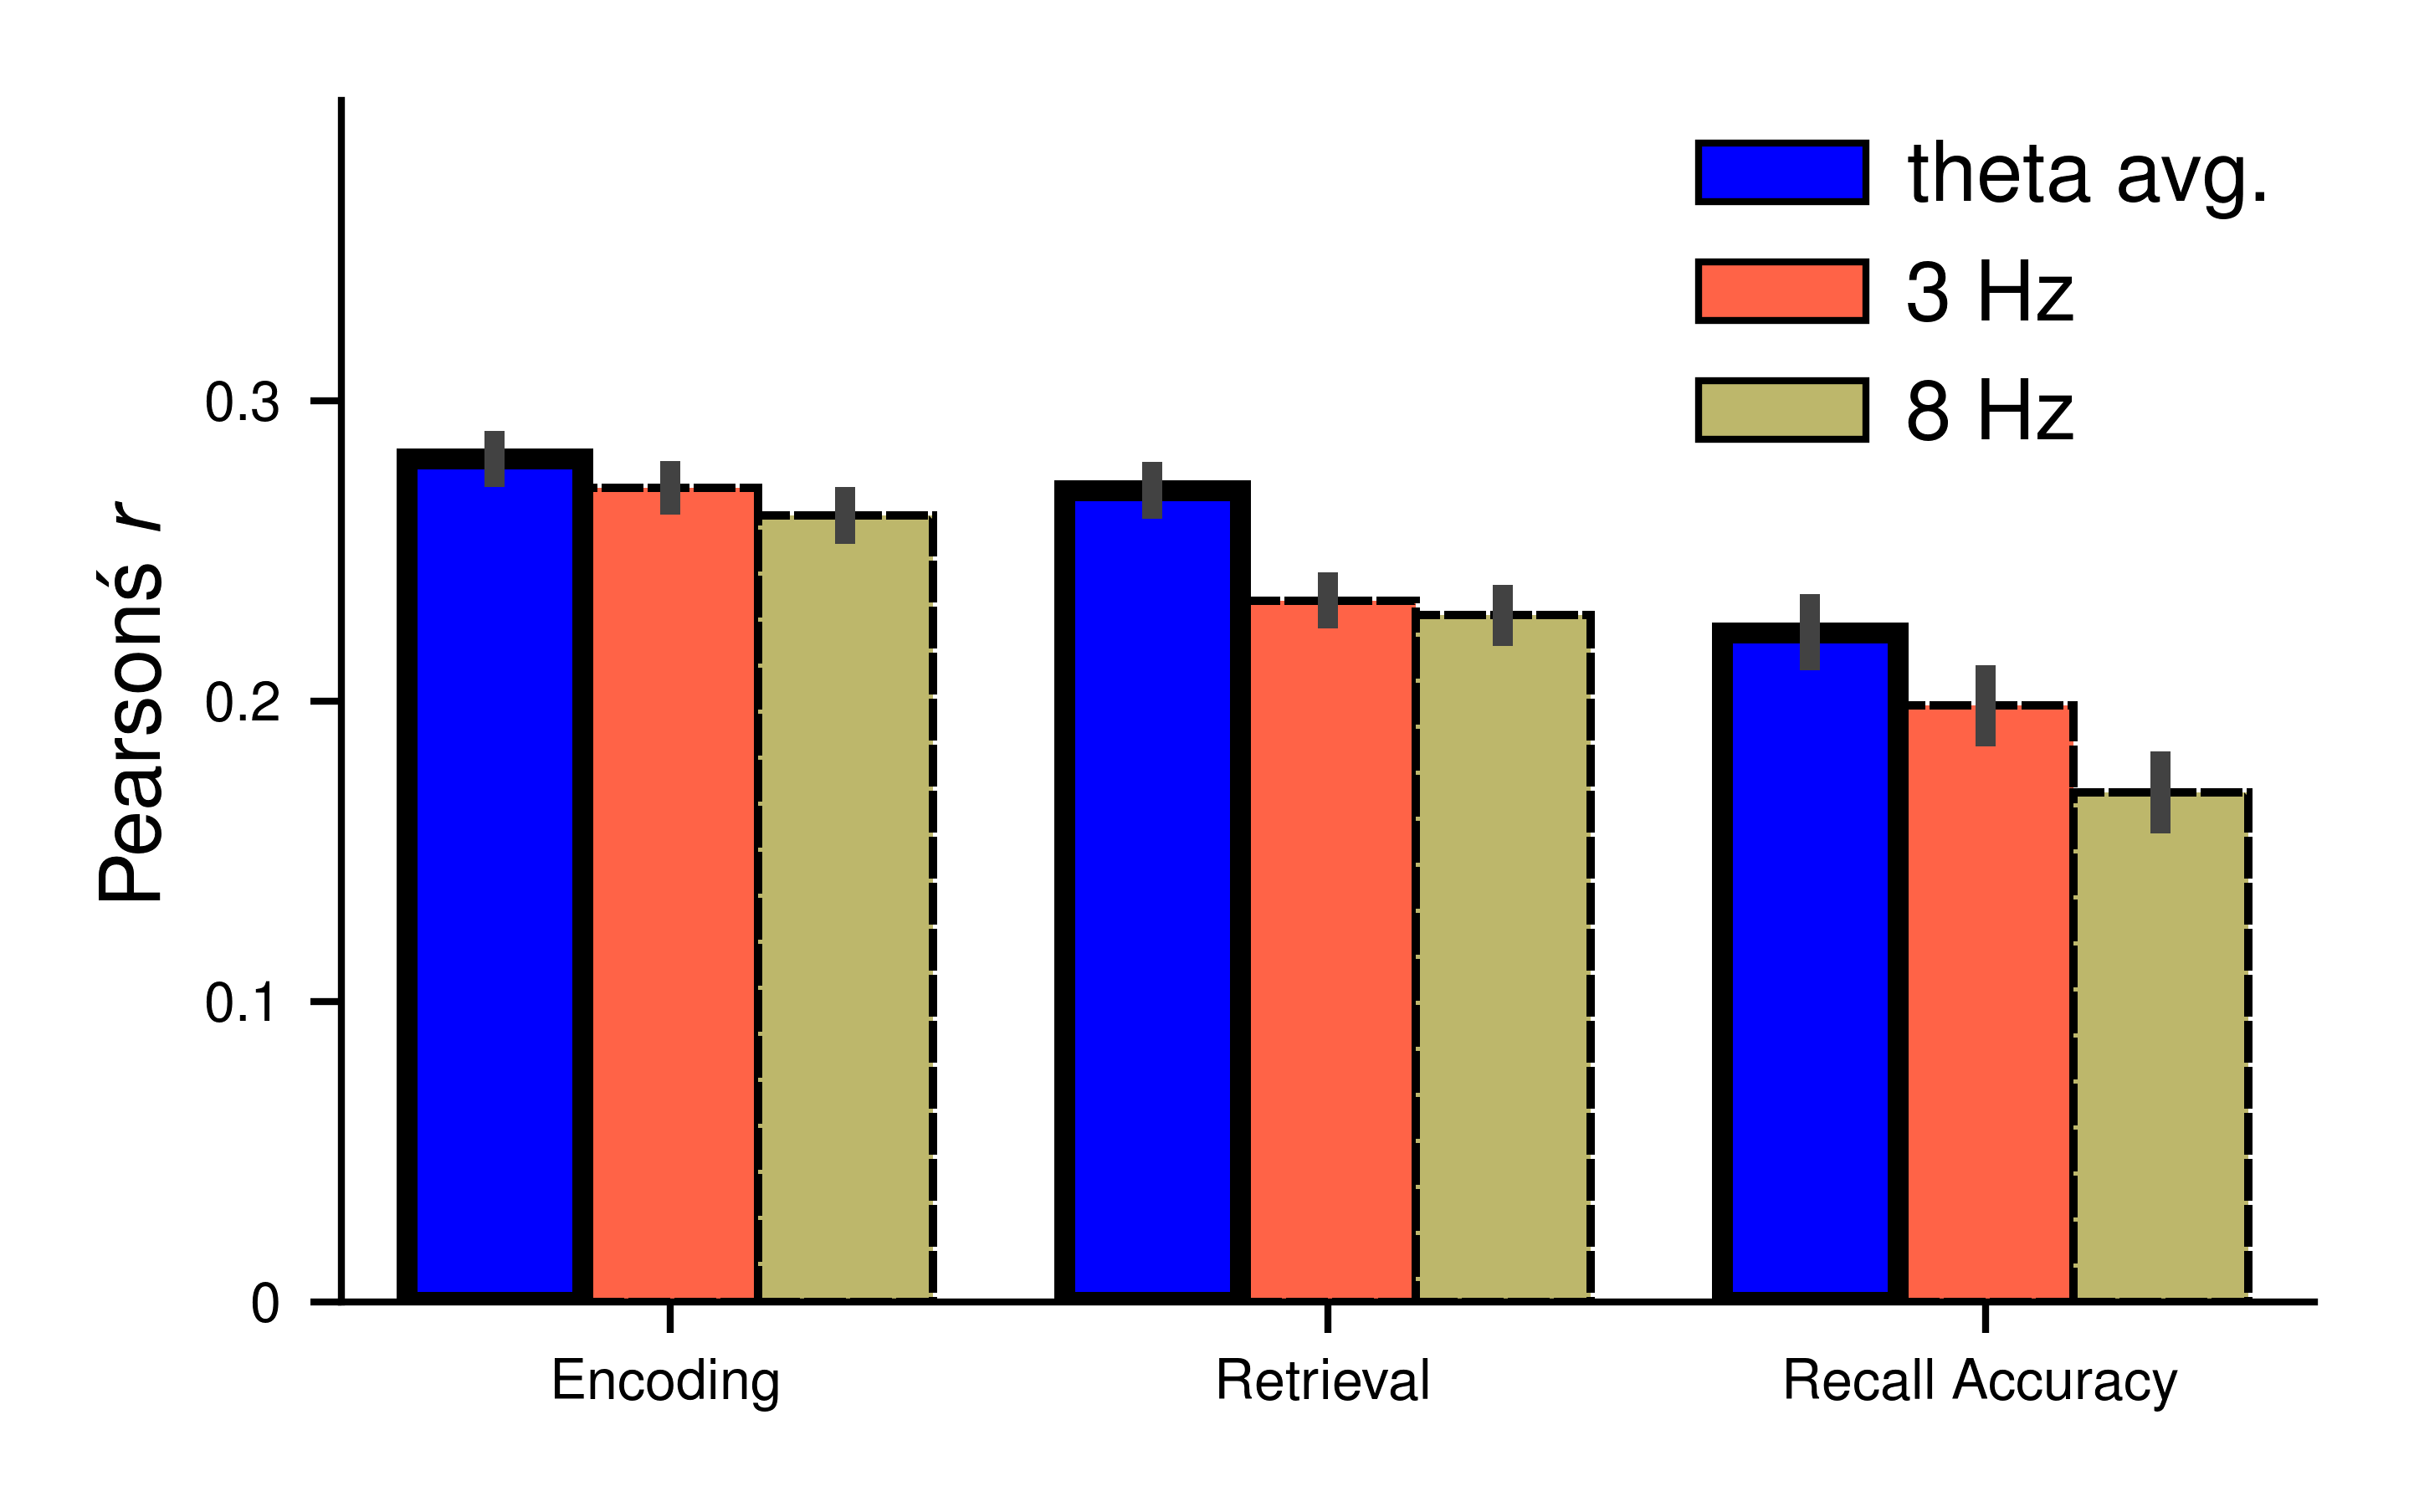

In [1253]:
from collections import OrderedDict as od
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('/home1/dscho/code/general/preferred.mplstyle')
mpl.rc('text', usetex=True)
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from formatting import *

colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

import matplotlib.font_manager as font_manager

font_dirs = ['/home1/amrao/SUPL']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
figsize = (colws[2]*0.8, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = 0
ymax = 0.4
yticks = [0, 0.1, 0.2, 0.3]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.barplot(x='beh', y='data', hue='freq', data=fig6_df, ax=_ax,
                  saturation=1, alpha=bar_alpha, zorder=0,
                  errorbar='se', lw=spine_lw, ec='k',
                 palette=['blue', 'tomato', 'darkkhaki'])
_ax.legend(fontsize=6, handletextpad=0.5, title=None, loc='upper right')

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=4)
for i in np.arange(3):
    _ax.containers[0].patches[i].set(zorder=2, edgecolor='black', linewidth=1.5)
    for j in [1, 2]:
        _ax.containers[j].patches[i].set(linestyle=(0, (5, 0.5)), linewidth=0.6)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel(r'Pearson\'s \textit{r}', fontsize=font['label'], labelpad=2)
# if _ax.get_legend():
#     _ax.get_legend().remove()


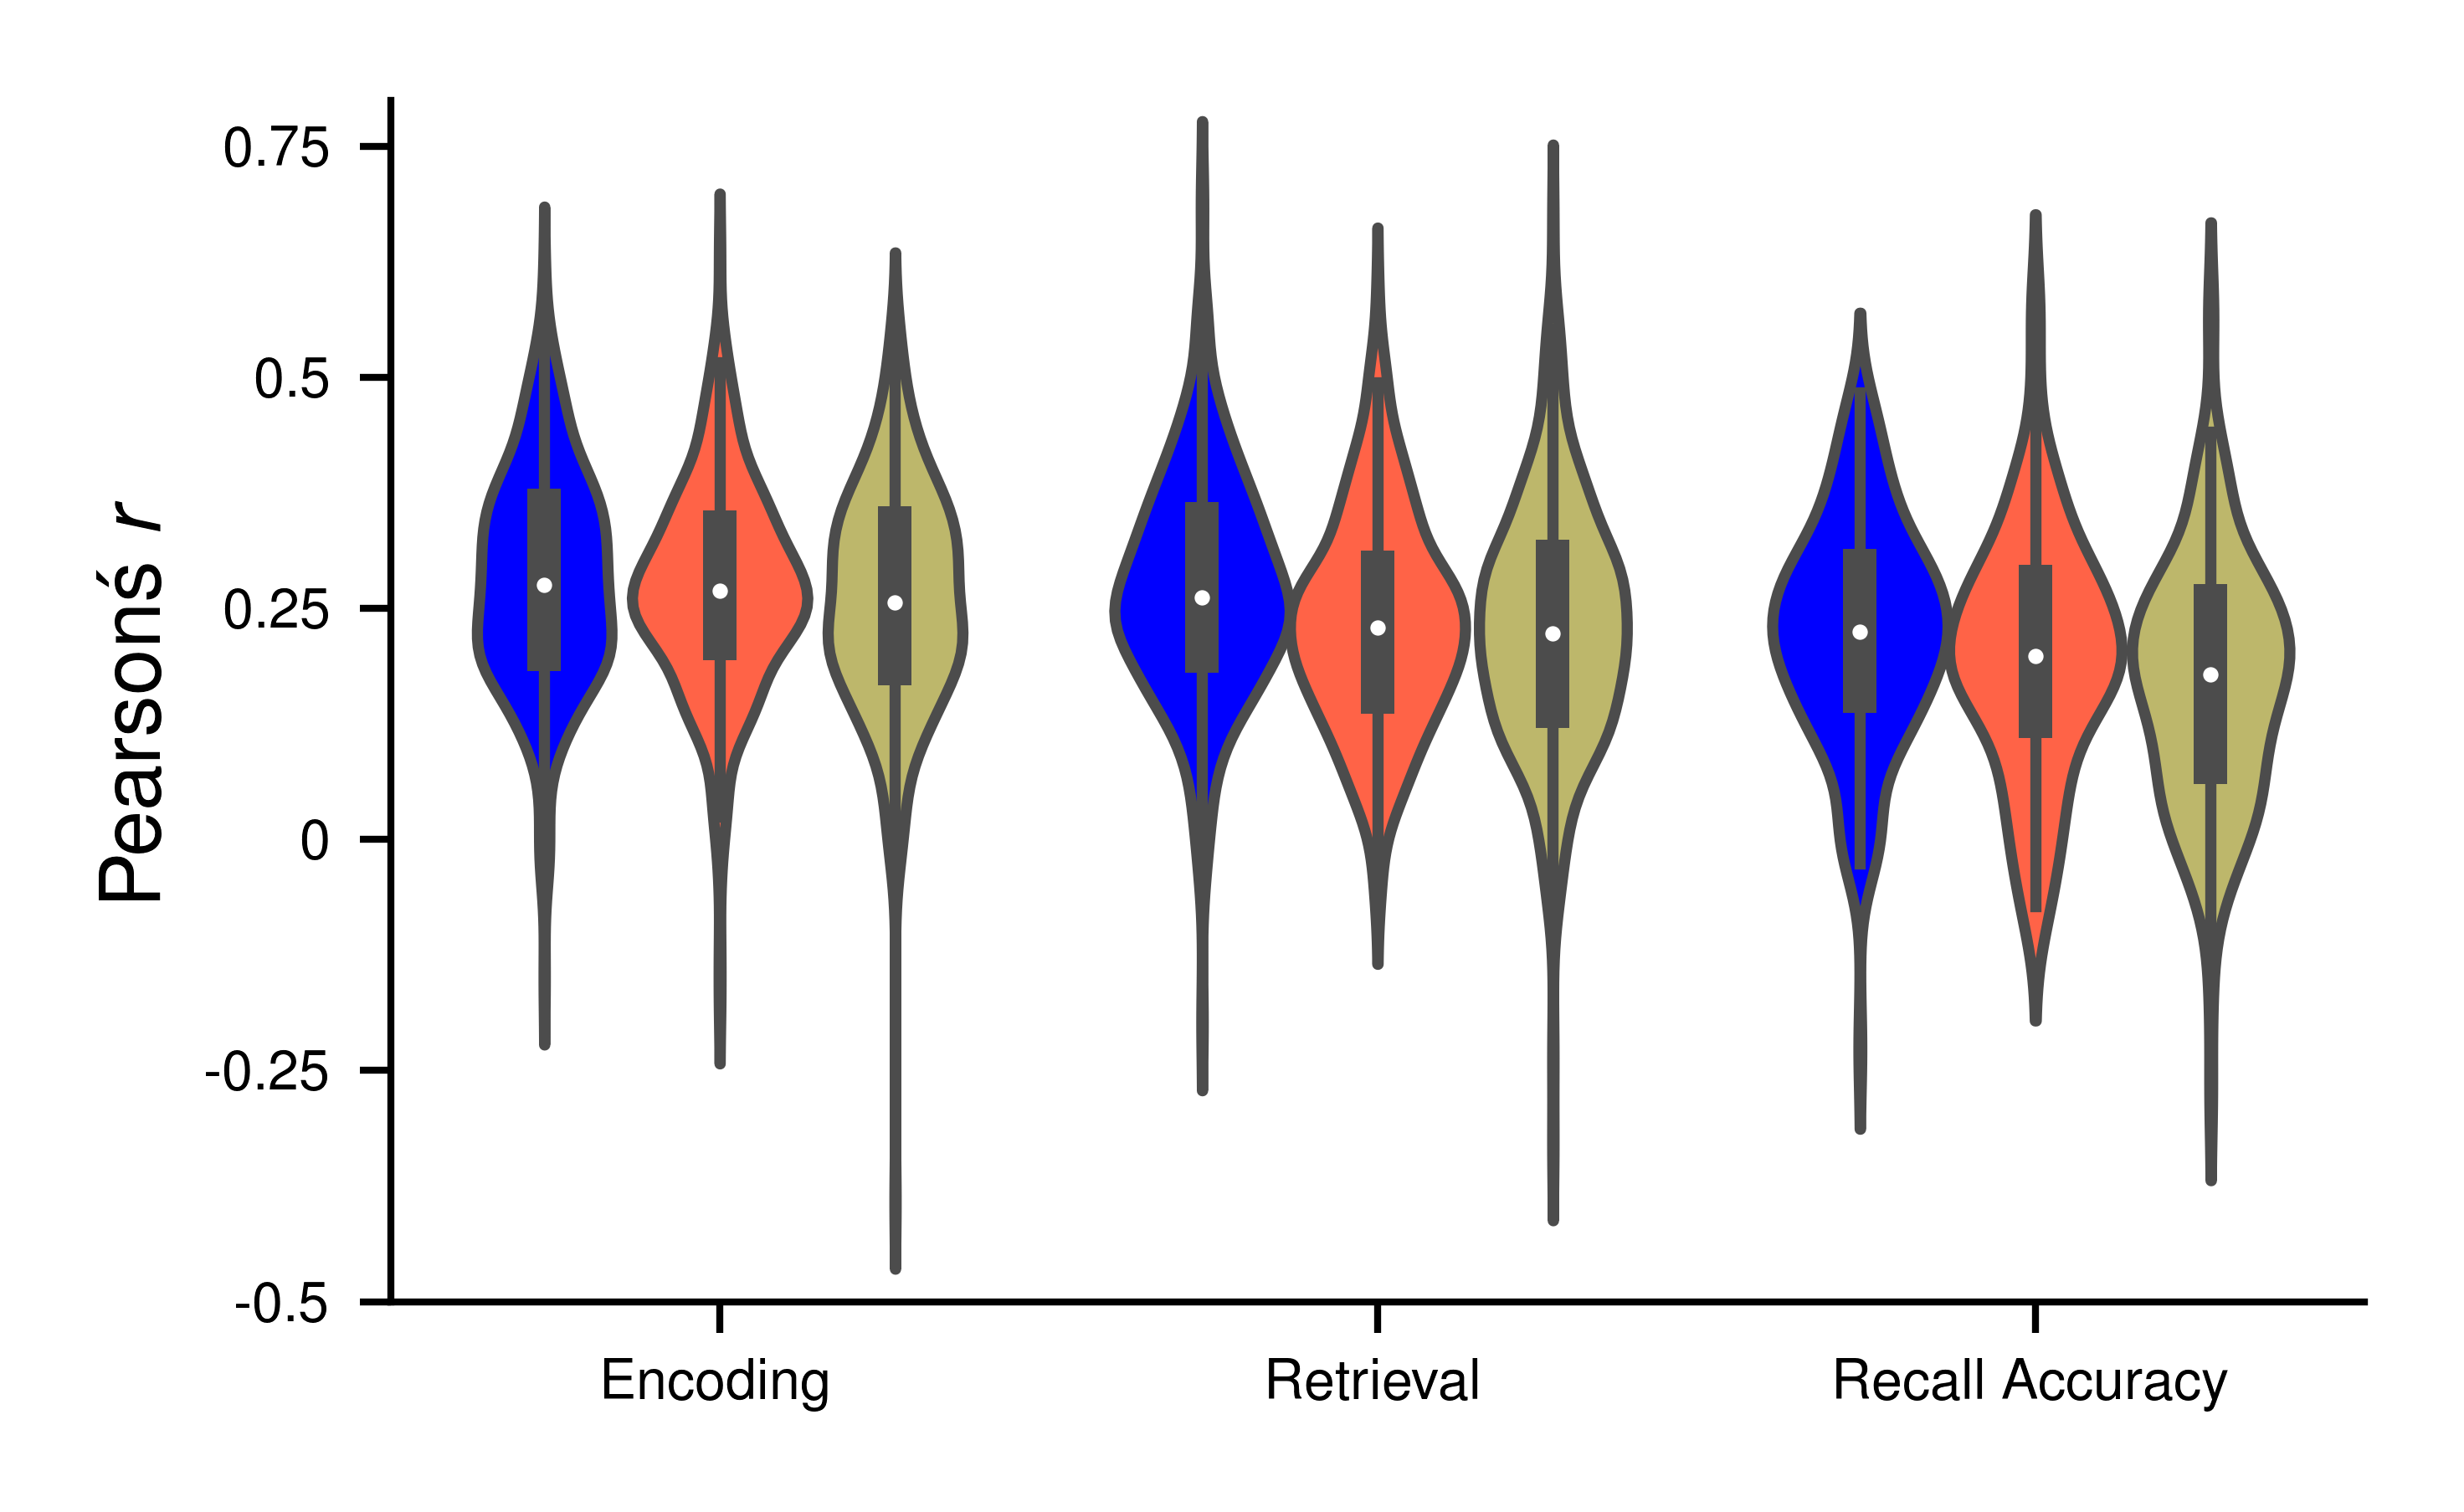

In [1257]:
from collections import OrderedDict as od
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('/home1/dscho/code/general/preferred.mplstyle')
mpl.rc('text', usetex=True)
import seaborn as sns
from matplotlib.lines import Line2D
import matplotlib.path as mpath
import matplotlib.patches as patches
from matplotlib.backends.backend_pdf import PdfPages
from formatting import *

colors, palettes = get_colors()
co = colors
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', palettes['economist'])

colws = od([(1, 1.555118),
            (2, 3.169291),
            (3, 6.456693)])

import matplotlib.font_manager as font_manager

font_dirs = ['/home1/amrao/SUPL']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
figsize = (colws[2]*0.8, colws[2]*0.5)
dpi = 1200
font = {'tick': 4, 'label': 6, 'fig': 10, 'annot': 7}
spine_lw = 0.5
ticklen = 2.2
labelpad = 3
ax_linewidth = 0.5
tickpad = 2
lw = 1
bar_alpha = 1
ymin = -0.5
ymax = 0.8
yticks = [-0.5, -0.25, 0, 0.25, 0.5, 0.75]

# Make the plot.
plt.close()
sns.set_context(rc={'patch.linewidth': spine_lw})
fig, _ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, facecolor='white')
_ax.set_facecolor('white')
_ax = sns.violinplot(x='beh', y='data', hue='freq', data=fig6_df, ax=_ax,
                  saturation=1, 
                  alpha=bar_alpha, 
                  zorder=0,
                  errorbar='se', 
                  lw=spine_lw, 
                  ec='k',
                 palette=['blue', 'tomato', 'darkkhaki'])
# _ax.legend(fontsize=6, handletextpad=0.5, title=None, loc='upper right')

for axis in ['left', 'bottom']:
    _ax.spines[axis].set_linewidth(spine_lw)
_ax.tick_params(labelsize=font['tick'], pad=2, length=ticklen, width=spine_lw)
_ax.set_xticks(np.arange(3))
_ax.set_xticklabels(['Encoding', 'Retrieval', 'Recall Accuracy'], fontsize=4)
_ax.set_xlabel('')
_ax.set_ylim([ymin, ymax])
_ax.set_yticks(yticks)
_ax.set_yticklabels(yticks, fontsize=font['tick'])
_ax.set_ylabel(r'Pearson\'s \textit{r}', fontsize=font['label'], labelpad=2)
if _ax.get_legend():
    _ax.get_legend().remove()


# Figure 1 (task schematic)

## Encoding

In [292]:
reader = cml.CMLReader(*dfrow)
events = reader.load('events').query('type == "WORD"').iloc[0:1]
pairs = reader.load('pairs')
eeg = reader.load_eeg(events, -2000, 3000, scheme=pairs)
sfreq = eeg.samplerate
eeg = eeg.data
i, j = 0, 10
signal1, signal2 = eeg[0, i, :].astype(float), eeg[0, j, :].astype(float)

In [293]:
freq = 3
import mne
signal1_filt = mne.filter.filter_data(signal1, sfreq=sfreq, l_freq=freq-1, h_freq=freq+1, verbose=False)
signal2_filt = mne.filter.filter_data(signal2, sfreq=sfreq, l_freq=freq-1, h_freq=freq+1, verbose=False)

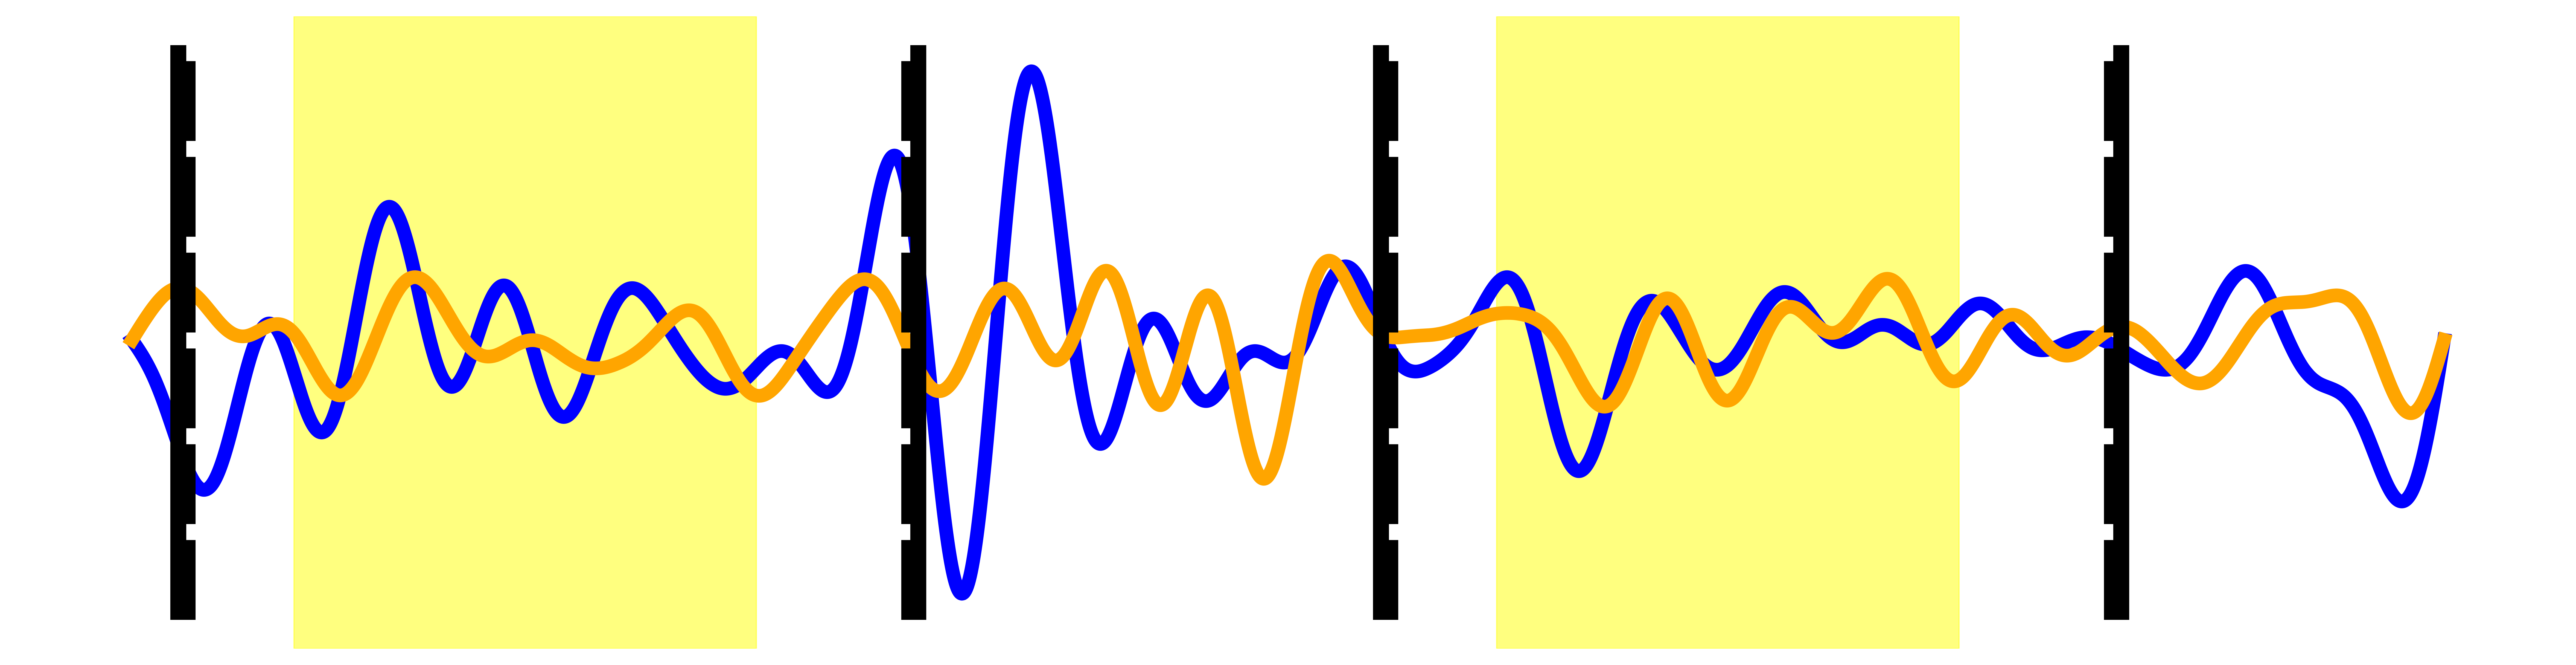

In [294]:
signal_lw = 6
vertical_lw = 7
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(np.arange(len(signal1_filt)), signal1_filt, lw=signal_lw, color='blue')
ax.plot(np.arange(len(signal2_filt)), signal2_filt, lw=signal_lw, color='orange')
ymin, ymax = ax.get_ylim()
plt.axis('off')
line_color = 'k'
# for onset, line_color in zip([50, 2000], ['red', 'green']):
for onset in [50, 50+(1600+1000)*(sfreq/1000)]:
    highlight_begin = onset+250*(sfreq/1000)
    highlight_end = onset+1250*(sfreq/1000)
    offset = onset+1600*(sfreq/1000)
    ax.vlines(onset, ymin=ymin, ymax=ymax, linestyles='solid', color=line_color, lw=vertical_lw)
    ax.vlines(onset+10, ymin=ymin, ymax=ymax, linestyles=(0, (5, 1)), color=line_color, lw=vertical_lw)
    ax.axvspan(highlight_begin, highlight_end, color='yellow', alpha = 0.5)
    ax.vlines(offset, ymin=ymin, ymax=ymax, linestyles='solid', color=line_color, lw=vertical_lw)
    ax.vlines(offset-10, ymin=ymin, ymax=ymax, linestyles=(0, (5, 1)), color=line_color, lw=vertical_lw)

## Retrieval

In [295]:
reader = cml.CMLReader(*dfrow)
events = reader.load('events').query('type == "REC_WORD"').iloc[0:1]
pairs = reader.load('pairs')
eeg = reader.load_eeg(events, -2000, 3000, scheme=pairs)
sfreq = eeg.samplerate
eeg = eeg.data
i, j = 0, 10
signal1, signal2 = eeg[0, i, :].astype(float), eeg[0, j, :].astype(float)

In [296]:
freq = 3
import mne
signal1_filt = mne.filter.filter_data(signal1, sfreq=sfreq, l_freq=freq-1, h_freq=freq+1, verbose=False)
signal2_filt = mne.filter.filter_data(signal2, sfreq=sfreq, l_freq=freq-1, h_freq=freq+1, verbose=False)

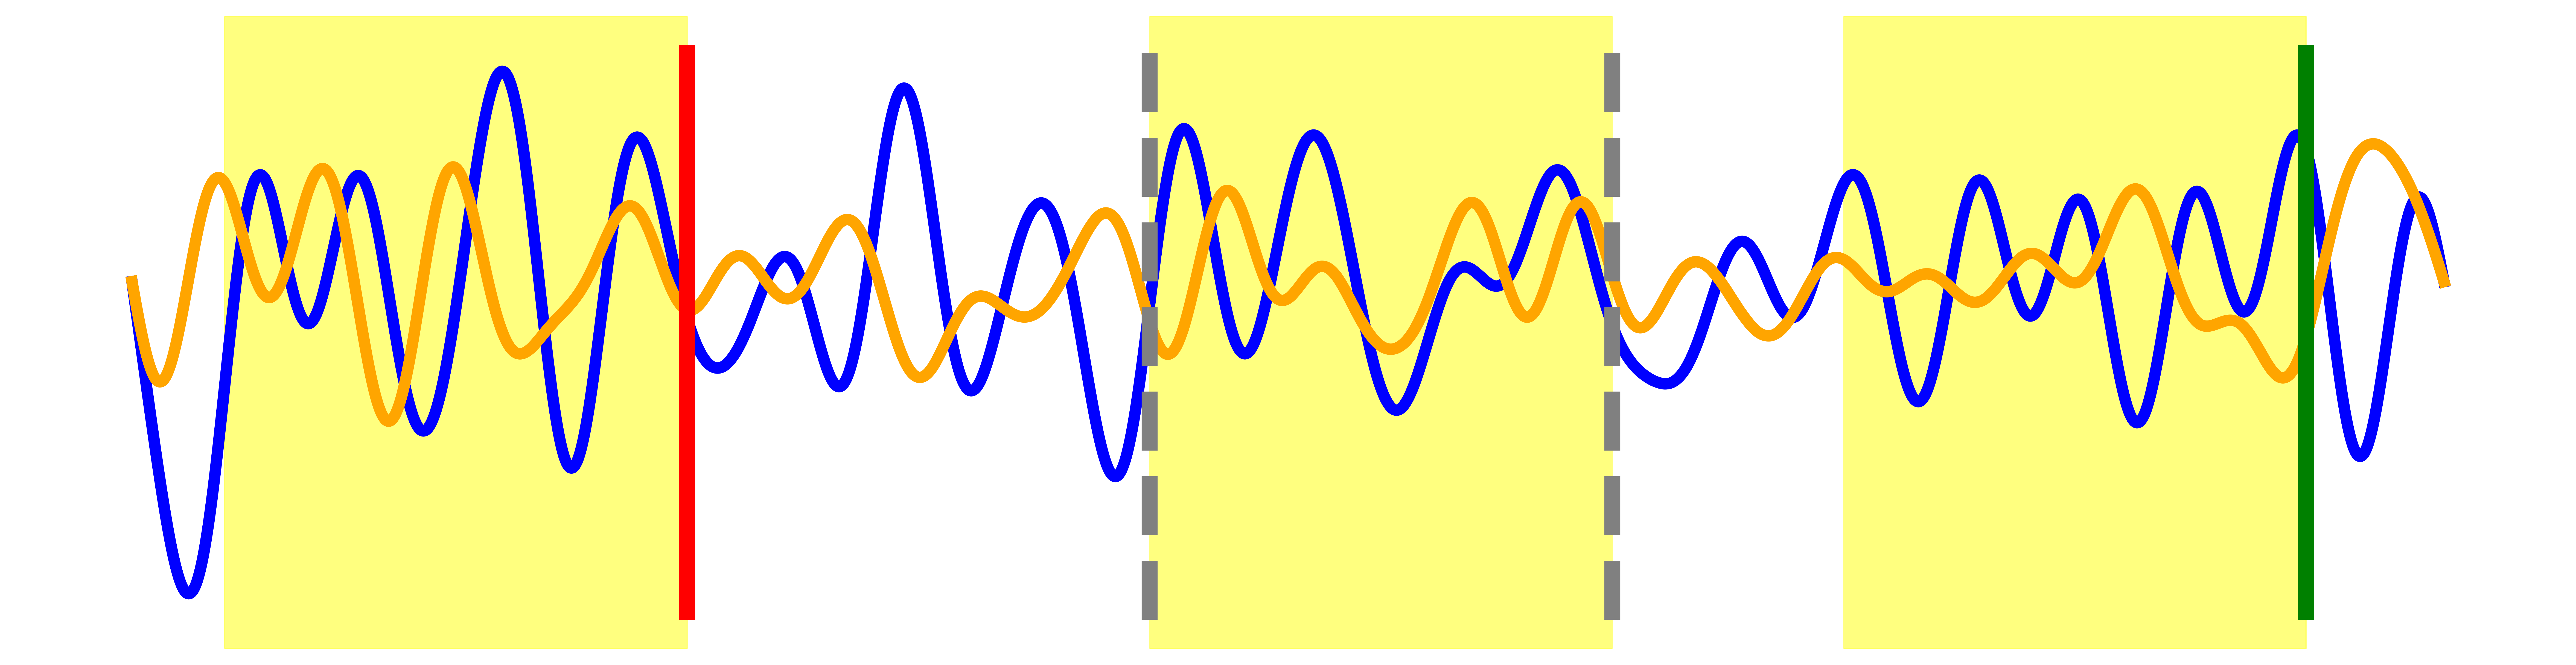

In [297]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(np.arange(len(signal1_filt)), signal1_filt, linewidth=5, color='blue')
ax.plot(np.arange(len(signal2_filt)), signal2_filt, linewidth=5, color='orange')
ymin, ymax = ax.get_ylim()
plt.axis('off')
first_recall_time = 100+1000*(sfreq/1000)
silence_onset = first_recall_time+1000*(sfreq/1000)
silence_offset = silence_onset+1000*(sfreq/1000)
second_recall_time = silence_offset+1500*(sfreq/1000)
for line_time, line_color, linestyle in zip([first_recall_time, silence_onset, silence_offset, second_recall_time], ['red', 'gray', 'gray', 'green'], ['solid', 'dashed', 'dashed', 'solid']):
    ax.vlines(line_time, ymin=ymin, ymax=ymax, linestyles=linestyle, color=line_color, lw=lw)
ax.axvspan(first_recall_time-1000*(sfreq/1000), first_recall_time, color='yellow', alpha = 0.5)
ax.axvspan(silence_onset, silence_offset, color='yellow', alpha = 0.5)
ax.axvspan(second_recall_time-1000*(sfreq/1000), second_recall_time, color='yellow', alpha = 0.5)
# ax.vlines(offset, ymin=ymin, ymax=ymax, linestyles='solid', color=line_color, lw=lw)

In [30]:
old_sess_list_df = pd.read_json(join(root_dir, 'initial_submission', 'sess_list_df.json')).query('include == True')[['sub', 'exp', 'sess', 'loc', 'mon']]
old_sess_list_df_ri = pd.read_json(join(root_dir, 'initial_submission', 'sess_list_df.json')).query('(include == True) & (ri_events == True)')[['sub', 'exp', 'sess', 'loc', 'mon']]

In [31]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')[['sub', 'exp', 'sess', 'loc', 'mon']]
sess_list_df_ri = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')[['sub', 'exp', 'sess', 'loc', 'mon']]

In [32]:
print(f'{old_sess_list_df.shape[0]} sessions analyzed in main analysis in initial submission.')
print(f'{sess_list_df.shape[0]} sessions analyzed in main analysis in new submission.')
print(f'{old_sess_list_df_ri.shape[0]} sessions analyzed in recall accuracy analysis in initial submission.')
print(f'{sess_list_df_ri.shape[0]} sessions analyzed in recall accuracy analysis in new submission.')

1071 sessions analyzed in main analysis in initial submission.
980 sessions analyzed in main analysis in new submission.
365 sessions analyzed in recall accuracy analysis in initial submission.
317 sessions analyzed in recall accuracy analysis in new submission.


In [33]:
print(f'{old_sess_list_df["sub"].unique().shape[0]} subjects analyzed in main analysis in initial submission.')
print(f'{sess_list_df["sub"].unique().shape[0]} subjects analyzed in main analysis in new submission.')
print(f'{old_sess_list_df_ri["sub"].unique().shape[0]} subjects analyzed in recall accuracy analysis in initial submission.')
print(f'{sess_list_df_ri["sub"].unique().shape[0]} subjects analyzed in recall accuracy analysis in new submission.')

413 subjects analyzed in main analysis in initial submission.
378 subjects analyzed in main analysis in new submission.
194 subjects analyzed in recall accuracy analysis in initial submission.
167 subjects analyzed in recall accuracy analysis in new submission.


# Calculate number of repeated recalls initially analyzed

In [40]:
old_sess_list_df = pd.read_json(join(root_dir, 'initial_submission', 'sess_list_df.json')).query('include == True')[['sub', 'exp', 'sess', 'loc', 'mon', 'evs_data_source']]
ev_count = 0
repeat_count = 0
for iSess, rSess in old_sess_list_df.iterrows():
    dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
    evs = pd.read_json(join(root_dir, 'initial_submission', 'rm', 'events', f'{ftag(dfrow)}_events.json'))
    matcher = match_events.MatchedEvents(dfrow, get_sr(dfrow), rSess['evs_data_source'])
    for iEv, ev in evs.query('type=="REC_WORD"').iterrows():
        ev_count += 1
        m = ev['mstime']
        lookup = matcher.all_recs[(matcher.all_recs['mstime'] == m)]
        assert len(lookup) == 1
        lookup = lookup.iloc[0]
        if lookup['repeat'] == 1: repeat_count += 1

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/event_process.py:80: UserWarning: Multiple eegfile values, sorting events by mstime.
  warnings.warn("Multiple eegfile values, sorting events by mstime.")
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/event_process.py:80: UserWarning: Multiple eegfile values, sorting events by mstime.
  warnings.warn("Multiple eegfile values, sorting events by mstime.")
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/event_process.py:80: UserWarning: Multiple eegfile values, sorting events by mstime.
  warnings.warn("Multiple eegfile values, sorting events by mstime.")
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/event_process.py:80: UserWarning: Multiple eegfile values, sorting events by mstime.
  warnings.warn("Multiple eegfile values, sorting events by mstime.")


In [41]:
print_header('rm')
print(f'{ev_count} total events analyzed.\n\ {repeat_count} repeats. {(repeat_count/ev_count*100):.2}% of events were repeats.')

---------rm---------
26760 total events analyzed.
\ 1377 repeats. 5.1% of events were repeats.


In [43]:
old_sess_list_df = pd.read_json(join(root_dir, 'initial_submission', 'sess_list_df.json')).query('(include == True) & (ri_events == True)')[['sub', 'exp', 'sess', 'loc', 'mon', 'evs_data_source']]
ev_count = 0
repeat_count = 0
for iSess, rSess in old_sess_list_df.iterrows():
    dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
    evs = pd.read_json(join(root_dir, 'initial_submission', 'ri', 'events', f'{ftag(dfrow)}_events.json'))
    matcher = match_events.MatchedEvents(dfrow, get_sr(dfrow), rSess['evs_data_source'])
    for iEv, ev in evs.query('type=="REC_WORD"').iterrows():
        ev_count += 1
        m = ev['mstime']
        lookup = matcher.all_recs[(matcher.all_recs['mstime'] == m)]
        assert len(lookup) == 1
        lookup = lookup.iloc[0]
        if lookup['repeat'] == 1: repeat_count += 1

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/event_process.py:80: UserWarning: Multiple eegfile values, sorting events by mstime.
  warnings.warn("Multiple eegfile values, sorting events by mstime.")
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/event_process.py:80: UserWarning: Multiple eegfile values, sorting events by mstime.
  warnings.warn("Multiple eegfile values, sorting events by mstime.")
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/event_process.py:80: UserWarning: Multiple eegfile values, sorting events by mstime.
  warnings.warn("Multiple eegfile values, sorting events by mstime.")
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/event_process.py:80: UserWarning: Multiple eegfile values, sorting events by mstime.
  warnings.warn("Multiple eegfile values, sorting events by mstime.")


In [44]:
print_header('ri')
print(f'{ev_count} total events analyzed.\n\ {repeat_count} repeats. {(repeat_count/ev_count*100):.2}% of events were repeats.')

---------ri---------
11846 total events analyzed.
\ 869 repeats. 7.3% of events were repeats.


# Check duplicate sessions

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
from cmlreaders import CMLReader, PathFinder
import hashlib

# returns cmlreader from experiment, subject, session (without need for localization/montage)
# TODO exclude pyFR sessions or require localization/montage to ensure unique sessions?
def get_reader(row_df=None, *, experiment=None, subject=None, session=None, index_df=None, return_finder=False):
    if isinstance(row_df, type(None)):
        assert not (isinstance(experiment, type(None)) or isinstance(subject, type(None)) or isinstance(session, type(None)))
    else:
        assert isinstance(experiment, type(None)) and isinstance(subject, type(None)) and isinstance(session, type(None))
        if isinstance(row_df, pd.DataFrame):
            if len(row_df) != 1:
                raise ValueError('row_df must have length 1!')
            row_df = row_df.iloc[0]
        experiment = row_df.experiment
        subject = row_df.subject
        session = row_df.session
    if isinstance(index_df, type(None)):
        from cmlreaders import get_data_index
        index_df = get_data_index()
    row = index_df.query('experiment == @experiment and subject == @subject and session == @session')
    if len(row) == 0: raise ValueError(f'{subject} {experiment} session {session} not found!')
    elif len(row) != 1: raise ValueError(f'{subject} {experiment} session {session} not unique!')
    CMLClass = PathFinder if return_finder else CMLReader
    return CMLClass(experiment=experiment, subject=subject, session=session,
                         localization=row.localization.item(), montage=row.montage.item())


def hash_data_structure(data):
    # Convert the data structure to a string representation
    if isinstance(data, list):
        data_str = str(data)
    elif isinstance(data, np.ndarray):
        data_str = np.array2string(data)
    elif isinstance(data, xr.DataArray):
        # Convert xarray DataArray to a NumPy array string representation
        data_str = np.array2string(data.values)
    elif isinstance(data, pd.DataFrame):
        data_str = data.to_string()
    else:
        try:
            # Attempt to create a string representation using repr
            data_str = repr(data)
        except Exception as e:
            raise ValueError("Unsupported data type")

    # Create a hash of the string representation
    return hashlib.sha256(data_str.encode()).hexdigest()


def find_duplicate_sessions(events, duplicate_ratio=0.05, check_eeg=True, 
                            subject_column='subject',
                            experiment_column='experiment',
                            session_column='session',
                            check_columns=['subject', 'mstime', 'type'],
                            return_events_without_duplicate_sessions=True, verbose=True):
    assert (duplicate_ratio > 0) and (duplicate_ratio <= 1)
    session_columns = [subject_column, experiment_column, session_column]
    duplicate_events = events.copy()
    duplicate_events['duplicate'] = duplicate_events.duplicated(check_columns, keep=False)
    duplicate_sessions = duplicate_events[session_columns + ['duplicate']].groupby(session_columns).mean()\
            .reset_index().drop_duplicates(session_columns).query('duplicate > @duplicate_ratio').reset_index()
    if duplicate_sessions.empty:
        if return_events_without_duplicate_sessions:
            return events, duplicate_sessions
        return duplicate_sessions
    
    duplicate_events = duplicate_events.merge(duplicate_sessions[session_columns], on=session_columns)
    index_df = get_data_index()
    
    duplicate_sessions['keep'] = duplicate_sessions.duplicate <= duplicate_ratio
    if check_eeg:
        # confirm EEG duplicated between all pairs of duplicate sessions
        # exclude duplicated sessions without matching EEG
        duplicate_sessions['eeg_hash'] = ''
        for sess_idx, sess_df in duplicate_sessions[session_columns].iterrows():
            reader = get_reader(sess_df, index_df=index_df)
            eeg = reader.load_eeg()
            duplicate_sessions.loc[sess_idx, ['eeg_hash']] = hash_data_structure(eeg.data)
            del eeg
        
        # display(duplicate_sessions)
        for eeg_hash, sessions in duplicate_sessions.groupby(['eeg_hash']):
            if (len(sessions[subject_column].unique()) > 1) or (len(sessions[experiment_column].unique()) > 1):
                print('WARNING: EEG matches between sessions with different subjects/experiments! Dropping sessions:')
                display(sessions)
            elif len(sessions) < 2:
                print('WARNING: EEG from session with duplicated events does not match '
                      'EEG of any other duplicated sessions! Dropping session:')
                display(sessions)
            else:
                keep_session = sessions.iloc[0:1]
                duplicate_sessions.loc[keep_session.index, ['keep']] = True
    else:
        raise NotImplementedError
        # for eeg_hash, sessions in duplicate_sessions.groupby([subject_column, experiment_column]):
        #     keep_session = sessions.iloc[0:1]
        #     keep_sessions.append(keep_session)
    
    if verbose and not duplicate_sessions.empty:
        print('Duplicate sessions:')
        display(duplicate_sessions)
    
    if return_events_without_duplicate_sessions:
        events = events.merge(duplicate_sessions.query('not keep')[session_columns], 
                              on=session_columns, how='left', indicator=True)
        events = events.query('_merge == "left_only"').drop(columns=['_merge'])
        return events, duplicate_sessions
    
    return duplicate_sessions

In [3]:
def load_raw_events(dfrow):
    
    sub, exp, sess, loc, mon = dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]
    if dfrow['evs_data_source'] == 'cmlreaders':
        reader = cml.CMLReader(*dfrow[['sub', 'exp', 'sess', 'loc', 'mon']])
        events = reader.load('events')
        if not exp == 'pyFR':
            events = cml.correct_retrieval_offsets(events, reader)
            events = cml.sort_eegfiles(events)
    elif dfrow['evs_data_source'] == 'ptsa':
        exp_dict = {'FR1': 'RAM_FR1', 'catFR1': 'RAM_CatFR1', 'pyFR': 'pyFR'}
        exp_ = exp_dict[exp]
        mon_ = '' if mon ==0 else f'_{mon}' #for tal_reader path name
        events = BaseEventReader(filename=f'/data/events/{exp_}/{sub}{mon_}_events.mat', use_reref_eeg=False).read()
        exclude_cols = ['stimParams'] if 'stimParams' in events.dtype.names else []
        events = pd.DataFrame.from_records(events, exclude=exclude_cols)
        events = events[events.session==sess]
        events = events.sort_values(by='mstime')
        # retrieval offset corrections are not necessary for pyFR sessions, and only pyFR sessions need to be loaded through the ptsa readers

    for col, value in zip(['experiment', 'protocol', 'montage'],
                          [exp, np.nan, mon]):
        if col not in events.columns:
            events.insert(len(events.columns), col, [value]*len(events))

    events.rename(columns={'list': 'trial'}, inplace=True)

    #session-specific changes
    dfrow_key = tuple(dfrow)
    errors = {('R1171M', 'FR1', 2, 0, 0): 'mstime < 1462393964709 & mstime > 1462394113265',
              ('R1329T', 'FR1', 0, 0, 0): 'trial != 4',
              ('R1341T', 'FR1', 1, 0, 0): 'trial != 8',
              ('R1374T', 'FR1', 0, 0, 0): 'trial != 1',
              ('R1488T', 'catFR1', 0, 0, 0): 'trial != 11',
              ('TJ040', 'pyFR', 0, 0, 1): 'trial != 6',
              ('FR060', 'pyFR', 1, 0, 0): 'trial != 1'}

    if dfrow_key in errors.keys(): events = events.query(errors[dfrow_key])
    
    return events

In [4]:
sldf=pd.read_json(join(root_dir, 'sess_list_df.json'))[['sub', 'exp', 'sess', 'loc', 'mon', 'evs_data_source']].query('sub=="R1408N"')

In [5]:
# sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json'))[['sub', 'exp', 'sess', 'loc', 'mon', 'evs_data_source']]
all_events = []
for iDfrow, dfrow in sldf.iterrows():
    events = load_raw_events(dfrow)
    events['duplicated_within_session'] = events.duplicated(['mstime', 'type'], keep=False)
    if np.sum(events['duplicated_within_session']) > 0:
        print(dfrow)
    all_events.append(events)
    
    
    

/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/event_process.py:57: UserWarning: Applying 1000 ms offset correction to retrieval events.
  warnings.warn(f'Applying {ms} ms offset correction to retrieval events.')
/usr/global/miniconda/py310_23.1.0-1/envs/workshop_311/lib/python3.11/site-packages/cmlreaders/event_process.py:57: UserWarning: Applying 1000 ms offset correction to retrieval events.
  warnings.warn(f'Applying {ms} ms offset correction to retrieval events.')


In [6]:
all_events = pd.concat(all_events,axis=0)

In [9]:
all_events.query('duplicated_within_session == True')[['eegoffset', 'eegfile', 'item_name', 'type', 'mstime']]

eegoffset                                            eegfile item_name  \
0       14179                       R1171M_catFR1_0_04May16_1447         X   
1       14179                       R1171M_catFR1_0_04May16_1447         X   
0        6125                          R1230J_FR1_2_12Oct16_1435         X   
1        6125                          R1230J_FR1_2_12Oct16_1435         X   
0      812953                          R1230J_FR1_5_14Oct16_1402         X   
1      812953                          R1230J_FR1_5_14Oct16_1402         X   
0        6330                          R1231M_FR1_0_10Oct16_1939         X   
1        6330                          R1231M_FR1_0_10Oct16_1939         X   
0        5473                          R1231M_FR1_1_12Oct16_1913         X   
1        5473                          R1231M_FR1_1_12Oct16_1913         X   
301      6078                          R1231M_FR1_1_12Oct16_1937         X   
302      6078                          R1231M_FR1_1_12Oct16_1937         X   
0        6633                       R1231M_catFR1_0_11Oct16_1953         X   
1        6633                       R1231M_catFR1_0_11Oct16_1953         X   
0        7283                       R1247P_catFR1_1_10Dec16_1952         X   
1        7283                       R1247P_catFR1_1_10Dec16_1952         X   
0        8846                       R1247P_catFR1_2_12Dec16_1916         X   
1        8846                       R1247P_catFR1_2_12Dec16_1916         X   
0        3796                     R1247P_1_catFR1_0_17Dec16_2053         X   
1        3796                     R1247P_1_catFR1_0_17Dec16_2053         X   
0      416737                     R1247P_1_catFR1_1_18Dec16_1628         X   
1      416737                     R1247P_1_catFR1_1_18Dec16_1628         X   
0       11747                     R1247P_1_catFR1_2_22Dec16_1743         X   
1       11747                     R1247P_1_catFR1_2_22Dec16_1743         X   
0      104301  /data/eeg/R1273D/eeg.noreref/R1273D_catFR1_1_1...       NaN   
1      104301  /data/eeg/R1273D/eeg.noreref/R1273D_catFR1_1_1...       NaN   
583     13664  /data/eeg/R1273D/eeg.noreref/R1273D_catFR1_2_1...       NaN   
584     13664  /data/eeg/R1273D/eeg.noreref/R1273D_catFR1_2_1...       NaN   
3          -1                                                            X   
4          -1                                                            X   
3      108812                       R1302M_catFR1_0_07May17_0044         X   
7      108812                       R1302M_catFR1_0_07May17_0044         X   
6          -1                                                            X   
8          -1                                                            X   
3          -1                                                            X   
4          -1                                                            X   
3      814088                          R1310J_FR1_0_13Jun17_1349         X   
7      814088                          R1310J_FR1_0_13Jun17_1349         X   
6          -1                                                            X   
8          -1                                                            X   
3       63675                          R1313J_FR1_0_27Jun17_1812         X   
7       63675                          R1313J_FR1_0_27Jun17_1812         X   
3          -1                                                            X   
4          -1                                                            X   
3          -1                                                            X   
4          -1                                                            X   
81         -1                       R1332M_catFR1_1_18Aug17_1433         X   
82         -1                       R1332M_catFR1_1_18Aug17_1433         X   
7          -1                                                            X   
9          -1                                                            X   
3          -1             

In [21]:
cml.get_data_index().query('subject=="R1486J"')

Recognition                                         all_events  \
2251         NaN                                                NaN   
2252         NaN                                                NaN   
2253         NaN                                                NaN   
2254         NaN                                                NaN   
2255         NaN  protocols/r1/subjects/R1486J/experiments/catFR...   
2256         NaN  protocols/r1/subjects/R1486J/experiments/catFR...   
2257         NaN  protocols/r1/subjects/R1486J/experiments/catFR...   
2258         NaN  protocols/r1/subjects/R1486J/experiments/catFR...   
2259         NaN  protocols/r1/subjects/R1486J/experiments/catFR...   
2260         NaN  protocols/r1/subjects/R1486J/experiments/catFR...   
2261         NaN  protocols/r1/subjects/R1486J/experiments/catFR...   
2262         NaN  protocols/r1/subjects/R1486J/experiments/catFR...   

                                               contacts      experiment  \
2251  protocols/r1/subjects/R1486J/localizations/0/m...  LocationSearch   
2252  protocols/r1/subjects/R1486J/localizations/0/m...  LocationSearch   
2253  protocols/r1/subjects/R1486J/localizations/0/m...  LocationSearch   
2254  protocols/r1/subjects/R1486J/localizations/0/m...  LocationSearch   
2255  protocols/r1/subjects/R1486J/localizations/0/m...          catFR1   
2256  protocols/r1/subjects/R1486J/localizations/0/m...          catFR1   
2257  protocols/r1/subjects/R1486J/localizations/0/m...          catFR1   
2258  protocols/r1/subjects/R1486J/localizations/0/m...          catFR1   
2259  protocols/r1/subjects/R1486J/localizations/0/m...          catFR1   
2260  protocols/r1/subjects/R1486J/localizations/0/m...          catFR1   
2261  protocols/r1/subjects/R1486J/localizations/0/m...          catFR1   
2262  protocols/r1/subjects/R1486J/localizations/0/m...          catFR1   

     import_type  localization  \
2251       build             0   
2252       build             0   
2253       build             0   
2254       build             0   
2255       build             0   
2256       build             0   
2257       build             0   
2258       build             0   
2259       build             0   
2260       build             0   
2261       build             0   
2262       build             0   

                                            math_events  montage  \
2251                                                NaN        0   
2252                                                NaN        0   
2253                                                NaN        1   
2254                                                NaN        1   
2255  protocols/r1/subjects/R1486J/experiments/catFR...        0   
2256  protocols/r1/subjects/R1486J/experiments/catFR...        0   
2257  protocols/r1/subjects/R1486J/experiments/catFR...        0   
2258  protocols/r1/subjects/R1486J/experiments/catFR...        0   
2259  protocols/r1/subjects/R1486J/experiments/catFR...        1   
2260  protocols/r1/subjects/R1486J/experiments/catFR...        1   
2261  protocols/r1/subjects/R1486J/experiments/catFR...        1   
2262  protocols/r1/subjects/R1486J/experiments/catFR...        1   

     original_experiment original_session  \
2251                 NaN              NaN   
2252                 NaN              NaN   
2253                 NaN                2   
2254                 NaN                3   
2255                 NaN              NaN   
2256                 NaN              NaN   
2257                 NaN              NaN   
2258                 NaN              NaN   
2259                 NaN                0   
2260                 NaN                1   
2261                 NaN                2   
2262                 NaN                3   

                                                  pairs ps4_events  session  \
2251  protocols/r1/subjects/R1486J/localizations/0/m...        NaN        2   
2252  protocols/r1/subjects/R1486

In [7]:
from cmlreaders import get_data_index
events, duplicate_sessions = find_duplicate_sessions(all_events)

index subject experiment  session  duplicate   keep  \
1      1  R1408N     catFR1        1   0.093949  False   

                                            eeg_hash  
1  1f439ba4e855e5d923a7187930014d78a14a8fc300d283...

index subject experiment  session  duplicate   keep  \
0      0  R1408N     catFR1        0   0.108059  False   

                                            eeg_hash  
0  e412c353bfae308876960d8b156416bc396a714d5d41c7...

Duplicate sessions:


index subject experiment  session  duplicate   keep  \
0      0  R1408N     catFR1        0   0.108059  False   
1      1  R1408N     catFR1        1   0.093949  False   

                                            eeg_hash  
0  e412c353bfae308876960d8b156416bc396a714d5d41c7...  
1  1f439ba4e855e5d923a7187930014d78a14a8fc300d283...

In [12]:
a = cml.CMLReader(*('R1408N', 'catFR1', 1, 0, 0)).load('events')['mstime']

In [25]:
all_events['duplicated'] = all_events.duplicated(['mstime', 'type'], keep=False)

In [27]:
e=all_events.query('(duplicated==True) & (duplicated_within_session==False)')[['eegoffset', 'eegfile', 'mstime', 'type', 'session']]

In [32]:
e['type'].unique()

array(['PROB', 'START', 'STOP'], dtype=object)

In [20]:
all_events.query('session==0')['mstime'].max()

1522527493009

In [21]:
all_events.query('session==1')['mstime'].min()

1522526060000

# Check encoding

In [3]:
old_sess_list_df = pd.read_json(join(root_dir, 'initial_submission', 'sess_list_df.json')).query('include == True')[['sub', 'exp', 'sess', 'loc', 'mon']]
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')[['sub', 'exp', 'sess', 'loc', 'mon']]


In [26]:
def get_no_events(dfrow):
    return len(pd.read_json(join(root_dir, 'en', 'events', f'{ftag(dfrow)}_events.json')))
def get_no_events_old(dfrow):
    return len(pd.read_json(join(root_dir, 'initial_submission', 'en', 'events', f'{ftag(dfrow)}_events.json')))

In [24]:
sess_list_df['no_en_events'] = sess_list_df.apply(lambda r: get_no_events(r), axis=1)

In [27]:
sess_list_df['no_en_events_old'] = sess_list_df.apply(lambda r: get_no_events_old(r), axis=1)

In [29]:
sess_list_df

sub   exp  sess  loc  mon  no_en_events  \
('R1001P', 'FR1', 0, 0, 0)  R1001P   FR1     0    0    0           106   
('R1001P', 'FR1', 1, 0, 0)  R1001P   FR1     1    0    0           124   
('R1002P', 'FR1', 0, 0, 0)  R1002P   FR1     0    0    0           214   
('R1002P', 'FR1', 1, 0, 0)  R1002P   FR1     1    0    0           216   
('R1003P', 'FR1', 0, 0, 0)  R1003P   FR1     0    0    0           160   
...                            ...   ...   ...  ...  ...           ...   
('UP041', 'pyFR', 0, 0, 0)   UP041  pyFR     0    0    0            88   
('UP041', 'pyFR', 1, 0, 0)   UP041  pyFR     1    0    0            80   
('UP041', 'pyFR', 2, 0, 0)   UP041  pyFR     2    0    0            56   
('UP045', 'pyFR', 1, 0, 0)   UP045  pyFR     1    0    0            86   
('UP046', 'pyFR', 0, 0, 0)   UP046  pyFR     0    0    0            52   

                            no_en_events_old  
('R1001P', 'FR1', 0, 0, 0)               106  
('R1001P', 'FR1', 1, 0, 0)               124  
('R1002P', 'FR1', 0, 0, 0)               214  
('R1002P', 'FR1', 1, 0, 0)               216  
('R1003P', 'FR1', 0, 0, 0)               160  
...                                      ...  
('UP041', 'pyFR', 0, 0, 0)                88  
('UP041', 'pyFR', 1, 0, 0)                80  
('UP041', 'pyFR', 2, 0, 0)                56  
('UP045', 'pyFR', 1, 0, 0)                86  
('UP046', 'pyFR', 0, 0, 0)                52  

[980 rows x 7 columns]

# Unit tests

## Sampling rate

In [487]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

Length of sess_list_df: 980


sub  exp  sess  loc  mon atlas contacts_source  \
sub    exp sess loc mon                                                      
R1001P FR1 0    0   0    R1001P  FR1     0    0    0   avg        contacts   
           1    0   0    R1001P  FR1     1    0    0   avg        contacts   
R1002P FR1 0    0   0    R1002P  FR1     0    0    0   avg        contacts   
           1    0   0    R1002P  FR1     1    0    0   avg        contacts   
R1003P FR1 0    0   0    R1003P  FR1     0    0    0   avg        contacts   

                          eeg eeg_data_source  eeg_error  ... no_matches_rm  \
sub    exp sess loc mon                                   ...                 
R1001P FR1 0    0   0    True      cmlreaders        NaN  ...          19.0   
           1    0   0    True      cmlreaders        NaN  ...          15.0   
R1002P FR1 0    0   0    True      cmlreaders        NaN  ...          46.0   
           1    0   0    True      cmlreaders        NaN  ...          23.0   
R1003P FR1 0    0   0    True      cmlreaders        NaN  ...          23.0   

                         mean_succ_times_rm  mean_unsucc_times_rm  \
sub    exp sess loc mon                                             
R1001P FR1 0    0   0          13339.947368          12390.000000   
           1    0   0           9179.200000           9117.400000   
R1002P FR1 0    0   0          13129.239130          12938.630435   
           1    0   0          11955.956522          11924.826087   
R1003P FR1 0    0   0          13344.086957          12047.043478   

                         no_matches_ri  mean_succ_times_ri  \
sub    exp sess loc mon                                      
R1001P FR1 0    0   0             17.0        13803.588235   
           1    0   0             13.0         9279.384615   
R1002P FR1 0    0   0              NaN                 NaN   
           1    0   0              NaN                 NaN   
R1003P FR1 0    0   0             23.0        13344.086957   

                         mean_unsucc_times_ri  recall_rate  en_match_rate  \
sub    exp sess loc mon                                                     
R1001P FR1 0    0   0            14292.176471     0.206667       0.176667   
           1    0   0            10227.769231     0.210000       0.206667   
R1002P FR1 0    0   0                     NaN     0.390000       0.356667   
           1    0   0                     NaN     0.400000       0.360000   
R1003P FR1 0    0   0            13791.652174     0.325758       0.303030   

                        rm_match_rate  ri_match_rate  
sub    exp sess loc mon                               
R1001P FR1 0    0   0        0.306452       0.274194  
           1    0   0        0.238095       0.206349  
R1002P FR1 0    0   0        0.393162            NaN  
           1    0   0        0.191667            NaN  
R1003P FR1 0    0   0        0.267442       0.267442  

[5 rows x 45 columns]

In [1815]:
for iSess, rSess in sess_list_df.iterrows(): # Iterate through each session row in the session list DataFrame
    
    try:
        reader = cml.CMLReader(*iSess) # Create CMLReader object for this session row
        sources = reader.load('sources') # Load sources file from CMLReaders
        sources_sr = sources['sample_rate'] # Get the sampling rate value contained within the sources file
        if sources_sr != rSess['sr']:
            message = f'{iSess}: Sampling rate is {sources_sr} in the sources file but {rSess["sr"]} in the DataFrame.'
            if ((np.char.endswith(sources['path'], 'params.txt') and rSess['eeg_data_source'] == 'cmlreaders') | (np.char.endswith(sources['path'], 'sources.json') and rSess['eeg_data_source'] == 'ptsa')):
                message += ' However, the mismatch is due to a resampling of the data between the ptsa readers and CMLReaders.'
            print(message)
    except FileNotFoundError:
        message = f'{iSess}: Sources file is not available. Sampling rate is {rSess["sr"]} in the DataFrame.'
        print(message)

('R1137E', 'FR1', 0, 0, 0): Sampling rate is 500 in the sources file but 499.71 in the DataFrame. However, the mismatch is due to a resampling of the data between the ptsa readers and CMLReaders.
('TJ029', 'pyFR', 0, 0, 0): Sampling rate is 2000.0 in the sources file but 1000.0 in the DataFrame. However, the mismatch is due to a resampling of the data between the ptsa readers and CMLReaders.
('TJ029', 'pyFR', 1, 0, 0): Sampling rate is 2000.0 in the sources file but 1000.0 in the DataFrame. However, the mismatch is due to a resampling of the data between the ptsa readers and CMLReaders.
('TJ053', 'pyFR', 1, 0, 2): Sources file is not available. Sampling rate is 1000.0 in the DataFrame.
('TJ053', 'pyFR', 0, 0, 3): Sources file is not available. Sampling rate is 2000.0 in the DataFrame.
('TJ062', 'pyFR', 0, 0, 2): Sampling rate is 1000.0 in the sources file but 2000.0 in the DataFrame.
('TJ062', 'pyFR', 1, 0, 2): Sampling rate is 1000.0 in the sources file but 2000.0 in the DataFrame.
('

cmlreaders loads incorrect source files (the source files for these subjects' montage 0) for the following:
- ('TJ062', 'pyFR', 0, 0, 2)
- ('TJ062', 'pyFR', 1, 0, 2)
- ('TJ069', 'pyFR', 0, 0, 1)
- ('TJ069', 'pyFR', 1, 0, 1)

Therefore, this sampling rate check has been passed.

## EEG selection, buffering, resampling, and filtering, and phase computation

### EEG selection

In [106]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

Length of sess_list_df: 980


sub  exp  sess  loc  mon atlas contacts_source  \
sub    exp sess loc mon                                                      
R1001P FR1 0    0   0    R1001P  FR1     0    0    0   avg        contacts   
           1    0   0    R1001P  FR1     1    0    0   avg        contacts   
R1002P FR1 0    0   0    R1002P  FR1     0    0    0   avg        contacts   
           1    0   0    R1002P  FR1     1    0    0   avg        contacts   
R1003P FR1 0    0   0    R1003P  FR1     0    0    0   avg        contacts   

                          eeg eeg_data_source  eeg_error  ... no_matches_rm  \
sub    exp sess loc mon                                   ...                 
R1001P FR1 0    0   0    True      cmlreaders        NaN  ...          19.0   
           1    0   0    True      cmlreaders        NaN  ...          15.0   
R1002P FR1 0    0   0    True      cmlreaders        NaN  ...          46.0   
           1    0   0    True      cmlreaders        NaN  ...          23.0   
R1003P FR1 0    0   0    True      cmlreaders        NaN  ...          23.0   

                         mean_succ_times_rm  mean_unsucc_times_rm  \
sub    exp sess loc mon                                             
R1001P FR1 0    0   0          13339.947368          12390.000000   
           1    0   0           9179.200000           9117.400000   
R1002P FR1 0    0   0          13129.239130          12938.630435   
           1    0   0          11955.956522          11924.826087   
R1003P FR1 0    0   0          13344.086957          12047.043478   

                         no_matches_ri  mean_succ_times_ri  \
sub    exp sess loc mon                                      
R1001P FR1 0    0   0             17.0        13803.588235   
           1    0   0             13.0         9279.384615   
R1002P FR1 0    0   0              NaN                 NaN   
           1    0   0              NaN                 NaN   
R1003P FR1 0    0   0             23.0        13344.086957   

                         mean_unsucc_times_ri  recall_rate  en_match_rate  \
sub    exp sess loc mon                                                     
R1001P FR1 0    0   0            14292.176471     0.206667       0.176667   
           1    0   0            10227.769231     0.210000       0.206667   
R1002P FR1 0    0   0                     NaN     0.390000       0.356667   
           1    0   0                     NaN     0.400000       0.360000   
R1003P FR1 0    0   0            13791.652174     0.325758       0.303030   

                        rm_match_rate  ri_match_rate  
sub    exp sess loc mon                               
R1001P FR1 0    0   0        0.306452       0.274194  
           1    0   0        0.238095       0.206349  
R1002P FR1 0    0   0        0.393162            NaN  
           1    0   0        0.191667            NaN  
R1003P FR1 0    0   0        0.267442       0.267442  

[5 rows x 45 columns]

In [54]:
checked_event_count = 1 # Number of randomly selected events to be checked for each behavioral contrast
checked_pair_count = 1 # Number of randomly selected electrode pairs to be checked for each event
rtol = 1e-5
atol = 1e-8
for iSess, (_, rSess) in enumerate(sess_list_df.iterrows()): # Iterate through all the sessions in the session list DataFrame
    
    np.random.seed(iSess) # Set the random seed
    dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']] # Set dfrow, or session label, from session list DataFrame
    sub, exp, sess, loc, mon = dfrow
    mon_ = '' if mon==0 else f'_{mon}'
    data_source = rSess['eeg_data_source'] # Get data source (cmlreaders or ptsa) from
    pairs = get_pairs(dfrow) # Get the pairs for this session
    
    missing_channels = []
    if tuple(dfrow) in [('R1394E', 'FR1', 0, 0, 0)]:
        missing_channels = ['3Ld10-3Ld11', '3Ld12-3Ld13', '3Ld14-3Ld1']

    if tuple(dfrow) in [('R1394E', 'FR1', 1, 1, 1),
                        ('R1394E', 'catFR1', 1, 1, 1), 
                        ('R1394E', 'catFR1', 2, 1, 1)]:
        missing_channels = ['35Ld2-35Ld3', '35Ld4-35Ld5', '35Ld6-35Ld7', '35Ld8-35Ld9', '3Ld10-3Ld11', '3Ld12-3Ld13', '3Ld14-3Ld1']

    if tuple(dfrow) in  [('R1354E', 'FR1', 0, 0, 0),
                         ('R1354E', 'FR1', 1, 0, 0),
                         ('R1354E', 'catFR1', 0, 0, 0),
                         ('R1354E', 'catFR1', 1, 0, 0),
                         ('R1354E', 'catFR1', 2, 0, 0),
                         ('R1354E', 'catFR1', 3, 0, 0)]:
        missing_channels = ['5Ldm1-5Ldm2', '5Ldm2-5Ldm3', '5Ldm3-5Ldm4', '5Ldm4-5Ldm5', '5Ldm5-5Ldm6', '5Ldm6-5Ldm7', '5Ldm7-5Ldm8', '5Ldm8-5Ldm9', '5Ldm9-5Ldm1', '25Ldm1-25Ldm2', '25Ldm2-25Ldm3', '25Ldm3-25Ldm4', '25Ldm4-25Ldm5', '25Ldm5-25Ldm6', '25Ldm6-25Ldm7', '25Ldm7-25Ldm8', '25Ldm8-25Ldm9', '25Ldm9-25Ldm1']
        
    pairs = pairs.query('label not in @missing_channels')
    pairs_sel_idxs = np.random.choice(np.arange(len(pairs)), size=checked_pair_count)
    pairs_sel = pairs.iloc[pairs_sel_idxs]
    
    for beh in ['en', 'rm']:
        
        events = load_events(dfrow, beh).sort_values(['mstime', 'eegoffset'])
        event_sel_idxs = np.random.choice(np.arange(len(events)), size=checked_event_count)
        events_sel = events.iloc[event_sel_idxs]
        
        saved_eeg_path = os.path.join(root_dir, beh, 'eeg', 'main_eeg', f'{ftag(dfrow)}_raw_eeg.npy') # Set the file path for the EEG snippet that was saved out during the run of the analyses
        saved_eeg = npl(saved_eeg_path) # Load the EEG snippet that was saved out during the run of the analyses into memory
        if data_source == 'ptsa': 
            ptsa_eeg = get_ptsa_eeg(dfrow, events, 0, 1000)
            gain = float(ptsa_eeg.gain)
            saved_eeg /= gain
        
        saved_eeg_sel = saved_eeg[..., (saved_eeg.shape[-1]//3):(2*saved_eeg.shape[-1]//3)] if beh == 'en' else saved_eeg
        sr = get_sr(dfrow)
        assert sr-2 <= saved_eeg_sel.shape[-1] <= sr+2, f'{tuple(dfrow)}: Sample rate is {sr} but shape of saved_eeg_sel is {saved_eeg_sel.shape}'
                                 
        for iEvent, (_, rEvent) in zip(event_sel_idxs, events_sel.iterrows()):
            
            eegfile, eegoffset = rEvent[['eegfile', 'eegoffset']] # Get EEG file path and eegoffset value
            if data_source == 'cmlreaders': # If the EEG data source is cmlreaders, we are going to load up the EEG file from /protocols/r1/subjects
                
                raw_eeg_dir = os.path.join('/protocols/r1/subjects', sub, 'experiments', exp, 'sessions', str(sess), 'ephys/current_processed/noreref')
            elif data_source == 'ptsa': 
                raw_eeg_dir = os.path.join('/data/eeg', f'{sub}{mon_}', 'eeg.noreref')
            
            for iPair in pairs_sel_idxs:
                
                pair = pairs.iloc[iPair]
                contact_1, contact_2 = pair[['contact_1', 'contact_2']]
                
                if np.char.endswith(eegfile, '.h5'):
                    fname= os.path.join(raw_eeg_dir, eegfile)
                    f = h5py.File(fname,'r')
                    data = np.empty_like(f['timeseries'])
                    f['timeseries'].read_direct(data)
                    ch0_labels = np.empty_like(f['bipolar_info']['ch0_label'])
                    f['bipolar_info']['ch0_label'].read_direct(ch0_labels)
                    ch1_labels = np.empty_like(f['bipolar_info']['ch1_label'])
                    f['bipolar_info']['ch1_label'].read_direct(ch1_labels)
                    f.close()
                    assert len(ch0_labels) == len(ch1_labels)
                    labels = [(int(ch0_labels[i]), int(ch1_labels[i])) for i in np.arange(len(ch0_labels))]
                    iChannel = None
                    for i in range(len(ch0_labels)):
                        if (contact_1, contact_2) == labels[i]:
                            iChannel = i
                    if iChannel is None:
                        for i in range(len(ch0_labels)):
                            if (contact_2, contact_1) == labels[i]:
                                iChannel = i
                    bp_eeg = data[:, iChannel]
                
                else:
                    contact_1_eeg_trace_path = os.path.join(raw_eeg_dir, f'{eegfile}.{str(contact_1).zfill(3)}')
                    contact_2_eeg_trace_path = os.path.join(raw_eeg_dir, f'{eegfile}.{str(contact_2).zfill(3)}')
                    contact_1_eeg = np.memmap(contact_1_eeg_trace_path, dtype='int16')
                    contact_2_eeg = np.memmap(contact_2_eeg_trace_path, dtype='int16')
                    bp_eeg = np.subtract(contact_1_eeg, contact_2_eeg)
                    
                if beh == 'en':
                    raw_eeg_check = False
                    for margin_of_error in [-2, -1, 0, 1, 2]:
                        left_edge = eegoffset + int((250/1000)*sr) + margin_of_error
                        right_edge = left_edge + saved_eeg_sel.shape[-1]
                        bp_eeg_sel = bp_eeg[left_edge:right_edge]
                        for sign in [-1, 1]:
                            if np.allclose(sign*bp_eeg_sel, saved_eeg_sel[iEvent, iPair, :], rtol=rtol, atol=atol):
                                raw_eeg_check = True
                                break
                    assert raw_eeg_check, f'{tuple(dfrow)}, event {iEvent}, item {rEvent["item_name"]}, pair {iPair}, {beh}: failed. sr: {sr}, saved_eeg_sel shape: {saved_eeg_sel.shape}.\
                                            contacts: {contact_1}, {contact_2}.\
                                            contact paths: {contact_1_eeg_trace_path}, {contact_2_eeg_trace_path},\
                                            {bp_eeg_sel},\
                                            {saved_eeg_sel[iEvent, iPair, :]}' 
                        
                elif beh == 'rm':
                    raw_eeg_check = False
                    left_edge = eegoffset - saved_eeg_sel.shape[-1]
                    right_edge = eegoffset
                    bp_eeg_sel = bp_eeg[left_edge:right_edge]
                    for sign in [-1, 1]:
                        if np.allclose(sign*bp_eeg_sel, saved_eeg_sel[iEvent, iPair, :], rtol=rtol, atol=atol):
                            raw_eeg_check = True
                            break
                    assert raw_eeg_check, f'{tuple(dfrow)}, event {iEvent}, pair {iPair}, {beh}: failed.' 
        
        print(f'{tuple(dfrow)}, {beh}: check passed.')

('R1001P', 'FR1', 0, 0, 0), en: check passed.
('R1001P', 'FR1', 0, 0, 0), rm: check passed.
('R1001P', 'FR1', 1, 0, 0), en: check passed.
('R1001P', 'FR1', 1, 0, 0), rm: check passed.
('R1002P', 'FR1', 0, 0, 0), en: check passed.
('R1002P', 'FR1', 0, 0, 0), rm: check passed.
('R1002P', 'FR1', 1, 0, 0), en: check passed.
('R1002P', 'FR1', 1, 0, 0), rm: check passed.
('R1003P', 'FR1', 0, 0, 0), en: check passed.
('R1003P', 'FR1', 0, 0, 0), rm: check passed.
('R1003P', 'FR1', 1, 0, 0), en: check passed.
('R1003P', 'FR1', 1, 0, 0), rm: check passed.
('R1006P', 'FR1', 0, 0, 0), en: check passed.
('R1006P', 'FR1', 0, 0, 0), rm: check passed.
('R1006P', 'FR1', 1, 0, 0), en: check passed.
('R1006P', 'FR1', 1, 0, 0), rm: check passed.
('R1010J', 'FR1', 0, 0, 0), en: check passed.
('R1010J', 'FR1', 0, 0, 0), rm: check passed.
('R1010J', 'FR1', 1, 0, 0), en: check passed.
('R1010J', 'FR1', 1, 0, 0), rm: check passed.
('R1013E', 'catFR1', 0, 0, 1), en: check passed.
('R1013E', 'catFR1', 0, 0, 1), 

### Mirrored buffering

In [1049]:
sess_idx = 0 # Set session index
dfrow = sess_list_df.iloc[sess_idx] # Set dfrow, or session label, from session list DataFrame
sr = int(dfrow['sr']) # Get sampling rate from session list DataFrame
beh = 'rm' # Set behavioral contrast variable beh to retrieval/silence
events = load_events(dfrow, beh) # Load events for the desired session and behavioral contrast 
eeg = get_eeg(dfrow, events, -1000, 0) # Get raw EEG from dataset readers for this set of events for -1000 ms to 0 ms before the event
buffer_length = 1000 # Set buffer length (in ms) -- note that this is different from the buffer_length variable of the clip_buffer function, for which buffer_length is the number of array entries / timepoints
buffered_eeg = mirror_buffer(eeg, buffer_length)

In [1060]:
rtol = 1e-5 # Set relative tolerance parameter for np.allclose
atol = 1e-8 # Set absolute tolerance parameter for np.allclose
# Note that the below checks assume that 
assert np.allclose(buffered_eeg.data[..., sr:(2*sr)], eeg.data, rtol=rtol, atol=atol) # Check that the middle third of the buffered EEG is identical to the original raw EEG
assert np.allclose(buffered_eeg.data[..., 0:sr], np.flip(eeg.data, axis=-1), rtol=rtol, atol=atol) # Check that the beginning third of the buffe
assert np.allclose(buffered_eeg.data[..., (2*sr):], np.flip(eeg.data, axis=-1), rtol=rtol, atol=atol)
assert np.allclose(buffered_eeg.data[..., :sr], buffered_eeg.data[..., (2*sr):], rtol=rtol, atol=atol)
print('Checks passed.')

Checks passed


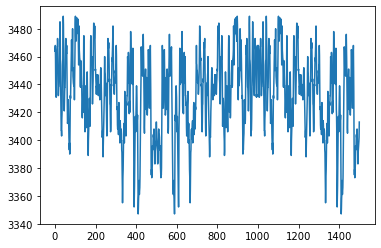

In [1044]:
iEvent = 0
iChannel = 10
buffered_eeg_sel = buffered_eeg.isel(event = iEvent, channel = iChannel).data # Select the buffered EEG signal for a particular event and channel
plt.plot(np.arange(len(buffered_eeg_sel)), buffered_eeg_sel)

### Notch filtering

In [1950]:
dfrow = sess_list_df.iloc[75]
print(tuple(dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]))
beh = 'en'
events = load_events(dfrow, beh)
eeg = get_eeg(dfrow, events, 250, 1250)
eeg = eeg.resampled(250)
filtered_eeg = notch_filter(eeg, dfrow['sub'])

('R1066P', 'FR1', 2, 0, 0)


In [1952]:
from mne import time_frequency
sr = 250
psds, freqs = time_frequency.psd_array_welch(eeg.data, sfreq=sr, fmin=3, fmax=120, n_fft=128)  #the output is size (events x channels x freqs)
filtered_psds, filtered_freqs = time_frequency.psd_array_welch(filtered_eeg.data, sfreq=sr, fmin=3, fmax=120, n_fft=128)  #the output is size (events x channels x freqs)

Effective window size : 0.512 (s)
Effective window size : 0.512 (s)


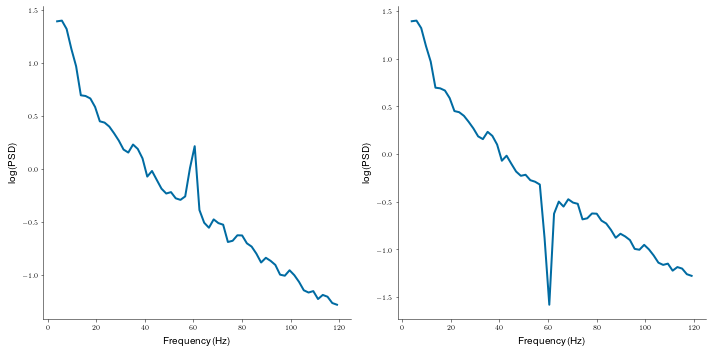

In [1956]:
log_psds = np.log10(psds)
log_filtered_psds = np.log10(filtered_psds)

np.random.seed(202410)
iCh=np.random.choice(eeg.shape[1])
plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
plt.plot(freqs, np.mean(log_psds[:, iCh, :], 0), linewidth=2)
plt.ylabel('log(PSD)', fontsize=10)
plt.xlabel('Frequency (Hz)', fontsize=10);

ax = plt.subplot(122)
plt.plot(filtered_freqs, np.mean(log_filtered_psds[:, iCh, :], 0), linewidth=2)
plt.ylabel('log(PSD)', fontsize=10)
plt.xlabel('Frequency (Hz)', fontsize=10);

plt.tight_layout()

### Phase computation

In [495]:
dfrow = sess_list_df.iloc[0]
beh = 'en'
events = load_events(dfrow, beh)
freqs = np.arange(3, 9)

In [590]:
def test_phase_computation(dfrow, beh):
        
        events = load_events(dfrow, beh)
        pairs = get_pairs(dfrow)
        phase, mask, sr = process_phase(dfrow, events, freqs)
        assert phase.shape[0:3] == (len(events), len(pairs), 6), f'{tuple(dfrow)}: failed. Phase shape: {phase.shape}.'
        assert 249 <= phase.shape[-1] <= 251, f'{tuple(dfrow)}: failed. Phase shape: {phase.shape}.'
        assert np.all(np.isfinite(phase)), f'{tuple(dfrow)}: failed'
        assert sr == phase.samplerate == 250, f'{tuple(dfrow)}: failed. Sample rate: {sr}.'
        
        phase = phase.data
        checks_passed = np.empty(phase.shape[0:3])
        for iEvent in np.arange(phase.shape[0]):
            for iChannel in np.arange(phase.shape[1]):
                for iFreq in np.arange(phase.shape[2]):
                    phase_sel = phase[iEvent, iChannel, iFreq, :] # Get the phase timeseries for this event, channel, and frequency
                    min_phase_value_check =  np.min(phase_sel) < -3 # Check that the minimum phase value is close to -pi
                    max_phase_value_check =  np.max(phase_sel) > 3 # Check that the maximum phase value is close to pi
                    phase_sel_diff = np.diff(phase_sel) # Get the difference between each phase value in the timeseries
                    monotonicity_check = np.sum((phase_sel_diff <= -6) | (phase_sel_diff > 0))/len(phase_sel_diff) > 0.9 # Check that for more than 90% of the time, the phase timeseries is monotonically increasing, with the exception of jumps from pi to -pi 
                    checks_passed[iEvent, iChannel, iFreq] = min_phase_value_check & max_phase_value_check & monotonicity_check
                    
        assert np.sum(checks_passed)/np.prod(checks_passed.shape) > 0.9, f'{tuple(dfrow)}: failed'
                    
for iSess, rSess in sess_list_df.iterrows():
    for beh in ['en', 'rm']:
        dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
        test_phase_computation(dfrow, beh)
            
for iSess, rSess in sess_list_df.query('ri_events == True'):
    beh = 'ri'
    dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
    test_phase_computation(dfrow, beh)
    
print('All checks passed')

CPP total time wavelet loop:  2.236830234527588
CPP total time wavelet loop:  0.9217183589935303
CPP total time wavelet loop:  2.786452293395996
CPP total time wavelet loop:  0.7612607479095459
CPP total time wavelet loop:  3.8086509704589844
CPP total time wavelet loop:  1.750685453414917
CPP total time wavelet loop:  4.002321481704712
CPP total time wavelet loop:  0.8799247741699219
CPP total time wavelet loop:  5.321911573410034
CPP total time wavelet loop:  1.7391719818115234
CPP total time wavelet loop:  5.418377161026001
CPP total time wavelet loop:  0.9910275936126709
CPP total time wavelet loop:  7.726067304611206
CPP total time wavelet loop:  2.563558578491211
CPP total time wavelet loop:  4.153857946395874
CPP total time wavelet loop:  1.5758464336395264
CPP total time wavelet loop:  5.484280824661255
CPP total time wavelet loop:  3.3610150814056396
CPP total time wavelet loop:  5.615382432937622
CPP total time wavelet loop:  3.038782835006714
CPP total time wavelet loop:  5.

KeyboardInterrupt: 

In [ ]:
np.random.seed(202410)
session_count = 100
freqs = np.arange(3, 9)
sess_idxs = np.random.choice(np.arange(len(sess_list_df)), size=session_count) # Get
for sess_idx in sess_idxs:
    dfrow = sess_list_df.iloc[sess_idx]
    events = load_events(dfrow, beh)
    phase, mask, sr = process_phase(dfrow, events, freqs)
    plt.plot(
    plt.title(f'{tuple(dfrow)}: Event {iEvent}, Channel {iChannel}, Frequency {iFreq}')

### Clip buffer

In [1012]:
sess_idx = 0
dfrow = sess_list_df.iloc[sess_idx]
beh = 'en'
events = load_events(dfrow, beh)
eeg, _ = get_beh_eeg(dfrow, events)
buffer_length = sr
clipped_eeg = clip_buffer(eeg, buffer_length)
assert clipped_eeg.shape[0:2] == eeg.shape[0:2]
assert clipped_eeg.shape[-1] == eeg.shape[-1] // 3

rtol = 1e-05
atol = 1e-08
buffered_interval_length = len(eeg['time'])
analysis_window_length = buffered_interval_length//3
assert np.allclose(eeg.data[..., analysis_window_length:(-analysis_window_length)], clipped_eeg.data, rtol=rtol, atol=atol)
print('Checks passed.')

Checks passed.


### Phase timebinning

In [4]:
rtol = 1e-05
atol = 1e-08

test_pairs = [([np.pi, -np.pi]*5, [np.pi]*5, 10),
              ([3*np.pi, -np.pi]*5, [np.pi]*5, 10),
              ([2*np.pi, 0]*5, [0]*5, 10),
              ([2*np.pi, 0]*5, [0]*5, 10),
              ([2*np.pi, 0]*5, [0]*5, 10),
              ([2*np.pi, 2*np.pi]*5, [0]*5, 10),
              ([np.pi, -np.pi]*137, [np.pi]*5, 250),
              ([np.pi, -np.pi]*138, [np.pi]*6, 250)]
              
for (x, y, sr) in test_pairs:
    print(f'Input: {x}')
    print(f'Expected Output: {y}')
    output = timebin_phase_timeseries(np.asarray(x), sr)
    assert np.allclose(output, np.asarray(y), rtol=rtol, atol=atol), f'Actual Output: {output}'
print('Checks passed.')

Input: [3.141592653589793, -3.141592653589793, 3.141592653589793, -3.141592653589793, 3.141592653589793, -3.141592653589793, 3.141592653589793, -3.141592653589793, 3.141592653589793, -3.141592653589793]
Expected Output: [3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793]
Input: [9.42477796076938, -3.141592653589793, 9.42477796076938, -3.141592653589793, 9.42477796076938, -3.141592653589793, 9.42477796076938, -3.141592653589793, 9.42477796076938, -3.141592653589793]
Expected Output: [3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793]
Input: [6.283185307179586, 0, 6.283185307179586, 0, 6.283185307179586, 0, 6.283185307179586, 0, 6.283185307179586, 0]
Expected Output: [0, 0, 0, 0, 0]
Input: [6.283185307179586, 0, 6.283185307179586, 0, 6.283185307179586, 0, 6.283185307179586, 0, 6.283185307179586, 0]
Expected Output: [0, 0, 0, 0, 0]
Input: [6.283185307179586, 0, 6.283185307179586, 0, 6.283185307179586, 

### Circular statistics

#### Circular mean

Here, we simply check the validity of the circ_mean function, found in misc.py, against scipy.stats.circmean.

In [357]:
low = -np.pi
high = np.pi
rtol = 1e-05
atol = 1e-08

np.random.seed(202410) # Set random seed
for _ in range(10000): # We are going to run our check on 10000 different random samples.
    samples = np.random.uniform(low=low, high=high, size=10000)
    scipy_answer = scipy.stats.circmean(samples, high=high, low=low, axis=0)
    my_answer = circ_mean(samples, axis=0)
    assert np.isclose(scipy_answer, my_answer, rtol=rtol, atol=atol), f'scipy\'s answer: {scipy_answer}, my answer: {my_answer}'
print(f'All checks passed for 1-dimensional arrays with relative tolerance {rtol} and absolute tolerance {atol}.')

np.random.seed(202410) # Set random seed
for _ in range(10000): # We are going to run our check on 10000 different random samples.
    samples = np.random.uniform(low=low, high=high, size=(100,100))
    no_dims = len(samples.shape) # Number of dimensions on our random sample
    axes_to_check = np.arange(-no_dims, no_dims) # Because 
    for axis in axes_to_check:
        scipy_answer = scipy.stats.circmean(samples, high=high, low=low, axis=axis)
        my_answer = circ_mean(samples, axis=axis)
        assert np.allclose(scipy_answer, my_answer, rtol=rtol, atol=atol)
print(f'All checks passed for 2-dimensional arrays with relative tolerance {rtol} and absolute tolerance {atol}.')

All checks passed for 1-dimensional arrays with relative tolerance 1e-05 and absolute tolerance 1e-08.
All checks passed for 2-dimensional arrays with relative tolerance 1e-05 and absolute tolerance 1e-08.


#### PPC

In [372]:
def plv(phase):
    
    cos_phase = np.cos(phase) # Compute the cosine of the phase (the x-component of the corresponding unit angle vector)
    sin_phase = np.sin(phase) # Compute the sine of the phase (the y-component of the corresponding unit angle vector)
    mean_cos_phase = np.mean(cos_phase) # Compute the average x-component across all phases
    mean_sin_phase = np.mean(sin_phase) # Compute the average y-component across all phases
    plv = np.sqrt(mean_cos_phase**2 + mean_sin_phase**2)
    return plv

def plv2(phase): # This implementation of the PLV takes advantage of the equality PLV = e^(-s^2/2), where s is the circular standard deviation
    
    circ_std = scipy.stats.circstd(phase)
    plv = np.e**((-circ_std**2)/2)
    return plv

In [373]:
np.random.seed(202410)
from scipy.stats import vonmises
loc = 0
kappa = 1
VM = vonmises(loc=loc, kappa=kappa)
sample_size = 1000

rtol = 1e-05
atol = 1e-08

for _ in range(10000):
    
    samples = VM.rvs(size=sample_size)
    sample_plv = plv(samples)
    sample_plv2 = plv2(samples)
    assert np.isclose(sample_plv, sample_plv2, rtol=rtol, atol=atol)
    
print('Check passed: the two implementations of the PLV computation are equivalent.')

In [374]:
np.random.seed(202410)
from scipy.stats import vonmises
loc = 0
kappa = 1
VM = vonmises(loc=loc, kappa=kappa)
sample_size = 1000

sample_plvs = []
sample_ppcs = []

for _ in range(10000):
    
    samples = VM.rvs(size=sample_size)
    sample_plv = plv(samples)
    sample_ppc = ppc(samples)
    
    sample_plvs.append(sample_plv) # Append sample PLV value to list of sample PLVs
    sample_ppcs.append(sample_ppc) # Append sample PPC value to list of sample PPC values

mean_sample_plv = np.mean(sample_plvs) # Compute mean of all sample PLVs to obtain a sharper estimate of the population PLV statistic
mean_sample_ppc = np.mean(sample_ppcs) # Compute mean of all sample PPC values to obtain a sharper estimate of the population PPC statistic

In [390]:
rtol = 1e-02
atol = 1e-02
assert np.isclose(mean_sample_plv**2, mean_sample_ppc, rtol=rtol, atol=atol)
print(f'Check passed: the population PPC value {mean_sample_ppc:.5} equals {mean_sample_plv**2:.5}, the square of the population PLV {mean_sample_plv:.5}, with relative tolerance {rtol} and absolute tolerance {atol}.')

Check passed: the population PPC value 0.19922 equals 0.19967, the square of the population PLV 0.44685, with relative tolerance 0.01 and absolute tolerance 0.01.


### Electrode synchrony matrix computation and pipeline integration

In [774]:
# idx 100 was a good one to show the difference

In [129]:
beh = 'en'
sess_idx = 100
dfrow = sess_list_df.iloc[sess_idx]
events = load_events(dfrow, beh)
eeg, mask = get_eeg(dfrow, events, 250-1000, 1250+1000)
if beh in ['rm', 'ri']: eeg = mirror_buffer(eeg, 1000)
eeg = eeg.resampled(250)
eeg = notch_filter(eeg, dfrow['sub'])
reference_elsymx = np.load(join(root_dir, beh, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy'), allow_pickle=True)

In [130]:
freqs = np.arange(3, 9)
wavelet_filter = MorletWaveletFilter(freqs=freqs, width=5, output='phase', complete=True)
phase = wavelet_filter.filter(timeseries=eeg)
phase = phase.transpose('event', 'channel', 'frequency', 'time')
phase = clip_buffer(phase, 250)

CPP total time wavelet loop:  2.5022997856140137


#### Maximum value

In [139]:
max_value = np.nanmax(reference_elsymx)
max_value_indices = ()
for iElec in np.arange(reference_elsymx.shape[0]):
    for jElec in np.arange(reference_elsymx.shape[1]):
        for iFreq in np.arange(reference_elsymx.shape[2]):
            for iEpoch in np.arange(reference_elsymx.shape[3]):
                for iSuccess in np.arange(reference_elsymx.shape[4]):
                    if reference_elsymx[iElec, jElec, iFreq, iEpoch, iSuccess] == max_value:
                        max_value_indices = (iElec, jElec, iFreq, iEpoch, iSuccess)
                        print(f'The maximum value {max_value} is located at indices: {max_value_indices}.')

The maximum value 0.981668527750482 is located at indices: (64, 66, 0, 2, 0).
The maximum value 0.981668527750482 is located at indices: (66, 64, 0, 2, 0).


In [140]:
epoch_idx = max_value_indices[3]
epoch = np.arange(epoch_idx*50, epoch_idx*50+50)
phase_diff = (phase.isel(channel = max_value_indices[0]) - phase.isel(channel = max_value_indices[1])).isel(frequency = max_value_indices[2]).isel(time = epoch).data

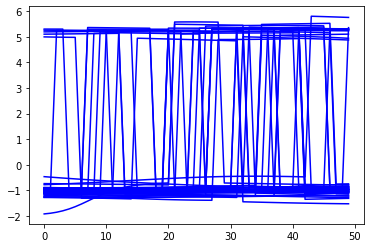

In [141]:
avg_phase = []
for event_trace, success in zip(phase_diff, mask):
    if ((1-success) == max_value_indices[4]):
        plt.plot(np.arange(len(event_trace)), event_trace, color='blue')
        avg_phase.append(circ_mean(event_trace, 0))
avg_phase = np.asarray(avg_phase)

In [137]:
print(f'Timebinned phase difference values: {avg_phase}')

Timebinned phase difference values: [-1.24964486 -0.91067315 -1.02332781 -0.88475785 -0.98436642 -0.99963534
 -0.97103579 -1.07984425 -1.08469987 -1.0654408  -0.993013   -1.1355423
 -1.17815817 -1.07414552 -1.01692555 -1.18489254 -1.10445787 -0.98510441
 -0.94894683 -0.9720939  -0.55563982 -0.98182959 -0.99594087 -0.93127765
 -0.98360548 -1.05885233 -0.81246355 -0.77541186 -1.02086853 -1.0712191
 -0.93513472 -0.86781003 -0.99387046 -0.99929371 -1.20990844 -1.1080841
 -1.01940289 -1.00822026 -1.08027391 -1.39824974 -1.00409698 -0.92523029
 -0.99393158 -0.96253549 -0.9478741  -1.32248501 -0.95340016 -1.0673204
 -0.98296323 -1.25262715]


In [135]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(ppc(avg_phase), max_value, rtol=rtol, atol=atol)
print(f'Check passed. PPC value computed from this visually inspected re-implementation matches the saved-out PPC value.') 

Check passed. PPC value computed from this visually inspected re-implementation matches the saved-out PPC value.


#### Intermediate value

In [126]:
np.random.seed(202410)
target_value = 0.4 # We are going to choose PPC = 0.4 as an intermediate value, since we observe that in our data PPC values tend to range from just below 0 to 0.8
intermediate_value_indices_list = [] # There are generally many values in the electrode synchrony that 
for iElec in np.arange(reference_elsymx.shape[0]):
    for jElec in np.arange(reference_elsymx.shape[1]):
        for iFreq in np.arange(reference_elsymx.shape[2]):
            for iEpoch in np.arange(reference_elsymx.shape[3]):
                for iSuccess in np.arange(reference_elsymx.shape[4]):
                    if target_value - 0.05 < reference_elsymx[iElec, jElec, iFreq, iEpoch, iSuccess] < target_value + 0.05:
                        intermediate_value_indices_list.append((iElec, jElec, iFreq, iEpoch, iSuccess))
intermediate_value_indices_idx = np.random.choice(np.arange(len(intermediate_value_indices_list)))              
intermediate_value_indices = intermediate_value_indices_list[intermediate_value_indices_idx]
intermediate_value = reference_elsymx[intermediate_value_indices]
print(f'The intermediate value {intermediate_value} is located at indices: {intermediate_value_indices}.')

The intermediate value 0.39744055009565876 is located at indices: (51, 43, 3, 3, 0).


In [127]:
epoch_idx = intermediate_value_indices[3]
epoch = np.arange(epoch_idx*50, epoch_idx*50+50)
phase_diff = (phase.isel(channel = intermediate_value_indices[0]) - phase.isel(channel = intermediate_value_indices[1])).isel(frequency = intermediate_value_indices[2]).isel(time = epoch).data

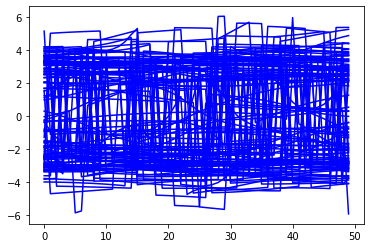

In [128]:
avg_phase = []
for event_trace, success in zip(phase_diff, mask):
    if ((1-success) == intermediate_value_indices[4]):
        plt.plot(np.arange(len(event_trace)), event_trace, color='blue')
        avg_phase.append(circ_mean(event_trace, 0))
avg_phase = np.asarray(avg_phase)

In [963]:
print(f'Timebinned phase difference values: {avg_phase}')

Timebinned phase difference values: [ 4.98506976e-01  7.50524839e-01  7.06071462e-03 -4.74162264e-01
 -1.41878168e+00 -5.62489892e-01  2.28393805e-03  2.78717126e-01
 -7.40340734e-01  6.49387035e-01 -4.48673708e-01 -3.14741059e-01
 -7.73451644e-01 -3.62674469e-01 -1.64460917e+00  3.82573041e-01
  2.34542104e-01 -2.51849838e+00 -7.67979799e-01  1.85557009e+00
  1.48170910e+00 -1.27157655e+00 -5.81986243e-01 -7.66656019e-02
 -5.89316418e-01 -2.32115433e-01  1.56438532e-01 -6.25775890e-02
  1.33249277e-01 -1.79060215e+00 -6.65002888e-01  1.09253864e-01
 -4.82114331e-01 -7.34387162e-01 -1.15611305e+00  9.55299716e-01
 -1.89405280e+00  9.36369613e-01 -1.35214659e+00  1.33782825e+00
 -6.55421307e-01 -7.07414000e-01 -9.24805773e-01 -1.59356590e+00
 -1.86568719e+00 -1.24154091e+00 -6.91911130e-01 -3.35813264e-01
 -5.24556882e-01  4.25998463e-01]


In [964]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(ppc(avg_phase), intermediate_value, rtol=rtol, atol=atol)
print(f'Check passed. PPC value computed from this visually inspected re-implementation matches the saved-out PPC value.') 

Check passed. PPC value computed from this visually inspected re-implementation matches the saved-out PPC value.


#### Minimum value

In [904]:
min_value = np.nanmin(reference_elsymx)
min_value_indices = ()
for iElec in np.arange(reference_elsymx.shape[0]):
    for jElec in np.arange(reference_elsymx.shape[1]):
        for iFreq in np.arange(reference_elsymx.shape[2]):
            for iEpoch in np.arange(reference_elsymx.shape[3]):
                for iSuccess in np.arange(reference_elsymx.shape[4]):
                    if reference_elsymx[iElec, jElec, iFreq, iEpoch, iSuccess] == min_value:
                        min_value_indices = (iElec, jElec, iFreq, iEpoch, iSuccess)
                        print(f'The minimum value {min_value} is located at indices: {min_value_indices}.')

The minimum value -0.020408061875096167 is located at indices: (42, 53, 1, 1, 1).
The minimum value -0.020408061875096167 is located at indices: (53, 42, 1, 1, 1).


In [905]:
epoch_idx = min_value_indices[3]
epoch = np.arange(epoch_idx*50, epoch_idx*50+50)
phase_diff = (phase.isel(channel = min_value_indices[0]) - phase.isel(channel = min_value_indices[1])).isel(frequency = min_value_indices[2]).isel(time = epoch).data

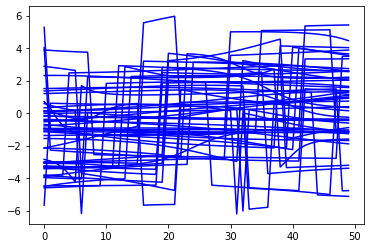

In [906]:
avg_phase = []
for event_trace, success in zip(phase_diff, mask):
    if ((1-success) == min_value_indices[4]):
        plt.plot(np.arange(len(event_trace)), event_trace, color='blue')
        avg_phase.append(circ_mean(event_trace, 0))
avg_phase = np.asarray(avg_phase)

In [907]:
print(f'Timebinned phase difference values: {avg_phase}')

Timebinned phase difference values: [-1.27972736  0.0348298   3.03573286 -0.98273016  3.075352    0.67822533
 -2.72926956  0.16096724  1.95826984  2.54844562  0.24615075 -0.24229446
  0.09517172  1.53470561  2.90578641 -1.0235629   0.72297841 -1.37520807
  1.8895013  -1.82488051 -0.72208761  2.52393778 -0.19236924  2.68454364
  1.46023972  2.19439622  2.32422429  1.40539791 -2.77729747 -2.51687869
  0.49362484 -2.95736634  1.05895169 -1.17244949 -1.75315365 -2.6650849
 -1.56205905  1.88953621 -0.34466264 -1.00401222 -1.26390474 -0.2931383
  2.77474331 -1.11785073  1.3499133  -2.61333565  2.72254498  0.06787392
 -2.09812894  1.83814186]


In [908]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(ppc(avg_phase), min_value, rtol=rtol, atol=atol)
print(f'Check passed. PPC value computed from this visually inspected re-implementation matches the saved-out PPC value.') 

Check passed. PPC value computed from this visually inspected re-implementation matches the saved-out PPC value.


### Region synchrony matrix generation and pipeline integration

In [303]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

In [443]:
sublist = sess_list_df['sub'].unique() # Get list of unique subject codes
print(f'There are {len(sublist)} analyzed subjects.')
print(sublist) # Print the list of unique subject codes

There are 378 subjects being analyzed.
['R1001P' 'R1002P' 'R1003P' 'R1006P' 'R1010J' 'R1013E' 'R1016M' 'R1018P'
 'R1020J' 'R1021D' 'R1022J' 'R1024E' 'R1026D' 'R1028M' 'R1030J' 'R1031M'
 'R1032D' 'R1033D' 'R1035M' 'R1036M' 'R1039M' 'R1042M' 'R1045E' 'R1048E'
 'R1050M' 'R1051J' 'R1052E' 'R1053M' 'R1054J' 'R1056M' 'R1060M' 'R1061T'
 'R1062J' 'R1063C' 'R1065J' 'R1066P' 'R1067P' 'R1068J' 'R1069M' 'R1070T'
 'R1074M' 'R1075J' 'R1076D' 'R1077T' 'R1080E' 'R1083J' 'R1084T' 'R1089P'
 'R1092J' 'R1093J' 'R1094T' 'R1096E' 'R1098D' 'R1101T' 'R1102P' 'R1104D'
 'R1105E' 'R1106M' 'R1107J' 'R1108J' 'R1111M' 'R1112M' 'R1113T' 'R1114C'
 'R1115T' 'R1118N' 'R1120E' 'R1121M' 'R1122E' 'R1123C' 'R1124J' 'R1125T'
 'R1127P' 'R1128E' 'R1129D' 'R1130M' 'R1131M' 'R1134T' 'R1135E' 'R1136N'
 'R1137E' 'R1138T' 'R1141T' 'R1144E' 'R1145J' 'R1146E' 'R1147P' 'R1148P'
 'R1149N' 'R1150J' 'R1151E' 'R1153T' 'R1154D' 'R1156D' 'R1157C' 'R1161E'
 'R1162N' 'R1163T' 'R1164E' 'R1166D' 'R1167M' 'R1168T' 'R1169P' 'R1170J'
 'R1172E' 'R

In [ ]:
beh = 'en'
sess_idx = 0
rSess = sess_list_df.iloc[sess_idx]
dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
elsymx_fname = os.path.join(root_dir, beh, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
elsymx = npl(elsymx_fname)
regsymx_fname = os.path.join(root_dir, beh, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
regsymx = xr.open_dataarray(regsymx_fname)

In [ ]:
iFreq = 0
iEpoch = 0
success = 0

freq = np.arange(3, 9)[iFreq]
epoch = beh_to_epochs[beh][iEpoch]
iSuccess = ~success

In [ ]:
reg1, reg2 = 'L amygdala', 'L amygdala'

In [ ]:
pairs, localization = get_pairs(dfrow), get_localization(dfrow)
regionalizations = regionalize_electrodes(pairs, localization)
region_labels = get_region_information('region_labels')
reg1_idxs, reg2_idxs = np.where(regionalizations == reg1), np.where(regionalizations == reg2)

In [ ]:
all_elsymx_entries = []
for iReg1 in reg1_idxs:
    for iReg2 in reg2_idxs:
        elsymx_entry = elsymx[iReg1, iReg2, iFreq, iEpoch, iSuccess]
        if not np.isnan(elsymx_value):
            all_elsymx_entries.append(elsymx_entry)
elsymx_value = np.mean(all_elsymx_entries)

In [ ]:
reference_value = regsymx.sel(reg1 = reg1, reg2 = reg2, freq = freq, epoch = epoch, success = success)

In [ ]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(elsymx_value, reference_value, rtol=rtol, atol=atol, equal_nan=True)

### Synchrony matrix integration test

In [303]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

In [443]:
sublist = sess_list_df['sub'].unique() # Get list of unique subject codes
print(f'There are {len(sublist)} analyzed subjects.')
print(sublist) # Print the list of unique subject codes

There are 378 subjects being analyzed.
['R1001P' 'R1002P' 'R1003P' 'R1006P' 'R1010J' 'R1013E' 'R1016M' 'R1018P'
 'R1020J' 'R1021D' 'R1022J' 'R1024E' 'R1026D' 'R1028M' 'R1030J' 'R1031M'
 'R1032D' 'R1033D' 'R1035M' 'R1036M' 'R1039M' 'R1042M' 'R1045E' 'R1048E'
 'R1050M' 'R1051J' 'R1052E' 'R1053M' 'R1054J' 'R1056M' 'R1060M' 'R1061T'
 'R1062J' 'R1063C' 'R1065J' 'R1066P' 'R1067P' 'R1068J' 'R1069M' 'R1070T'
 'R1074M' 'R1075J' 'R1076D' 'R1077T' 'R1080E' 'R1083J' 'R1084T' 'R1089P'
 'R1092J' 'R1093J' 'R1094T' 'R1096E' 'R1098D' 'R1101T' 'R1102P' 'R1104D'
 'R1105E' 'R1106M' 'R1107J' 'R1108J' 'R1111M' 'R1112M' 'R1113T' 'R1114C'
 'R1115T' 'R1118N' 'R1120E' 'R1121M' 'R1122E' 'R1123C' 'R1124J' 'R1125T'
 'R1127P' 'R1128E' 'R1129D' 'R1130M' 'R1131M' 'R1134T' 'R1135E' 'R1136N'
 'R1137E' 'R1138T' 'R1141T' 'R1144E' 'R1145J' 'R1146E' 'R1147P' 'R1148P'
 'R1149N' 'R1150J' 'R1151E' 'R1153T' 'R1154D' 'R1156D' 'R1157C' 'R1161E'
 'R1162N' 'R1163T' 'R1164E' 'R1166D' 'R1167M' 'R1168T' 'R1169P' 'R1170J'
 'R1172E' 'R

In [ ]:
dfrow = sess_list_df.iloc[0]
beh = 'en'
events = load_events(dfrow, beh)
# start, end = beh_to_event_windows[beh]
# eeg, mask = get_eeg(dfrow, events, start, end)
# if (beh == 'rm') or (beh == 'ri'):
#     eeg = mirror_buffer(eeg, 1000)
# eeg = eeg.resampled(250)
# eeg = notch_filter(eeg, dfrow['sub'])
# freqs = np.arange(3, 9)
# phase, mask = get_phase(eeg, freqs)

In [105]:
elsymx = get_elsymx(dfrow, freqs, events)


Signature: get_elsymx(dfrow, freqs, events)
Docstring: <no docstring>
File:      ~/ConnectivityProject/<ipython-input-15-e3c72bc33757>
Type:      function


### Power computation

#### Cohen's $\textit{d}$

Source for example data: https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python

In [59]:
x = [2,4,7,3,7,35,8,9]
y = [i*2 for i in x]
# extra element so that two group sizes are not equal.
x.append(10)
known_d = -0.572015604666

In [60]:
def cohens_d(x, y):
    
    s = np.sqrt(((len(x)-1)*(np.std(x, axis=0, ddof=1)**2) + (len(y)-1)*(np.std(y, axis=0, ddof=1)**2))/(len(x)+len(y)-2))
    d = (np.mean(x, axis=0) - np.mean(y, axis=0))/s
    return d

In [61]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(cohens_d(x, y), known_d, rtol=rtol, atol=atol)
print('Check passed.')

Check passed.


#### Power timebinning

In [5]:
x = np.asarray([2*np.pi, 2*np.pi]*5)
y = np.asarray([2*np.pi]*5)
print(f'Input: {x}')
print(f'Expected Output: {y}')
assert np.allclose(timebin_power_timeseries(x, 10), y, rtol=rtol, atol=atol)
print('Checks passed.')

Input: [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 6.28318531 6.28318531 6.28318531]
Expected Output: [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531]
Checks passed.


In [6]:
x = np.asarray([1e3, 2e3]*5)
y = np.asarray([1.5e3]*5)
print(f'Input: {x}')
print(f'Expected Output: {y}')
assert np.allclose(timebin_power_timeseries(x, 10), y, rtol=rtol, atol=atol)
print('Checks passed.')

Input: [1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.]
Expected Output: [1500. 1500. 1500. 1500. 1500.]
Checks passed.


In [7]:
x = np.asarray([1e3, 2e3]*10)
y = np.asarray([1.5e3]*5)
print(f'Input: {x}')
print(f'Expected Output: {y}')
assert np.allclose(timebin_power_timeseries(x, 20), y, rtol=rtol, atol=atol)
print('Checks passed.')

Input: [1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.]
Expected Output: [1500. 1500. 1500. 1500. 1500.]
Checks passed.


In [8]:
x = np.asarray([1e3, 2e3]*126)
y = np.asarray([1.5e3]*5)
print(f'Input: {x}')
print(f'Expected Output: {y}')
assert np.allclose(timebin_power_timeseries(x, 250), y, rtol=rtol, atol=atol)
print('Checks passed.')

Input: [1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2

In [106]:
beh = 'en'
sess_idx = 20
dfrow = sess_list_df.iloc[sess_idx]
events = load_events(dfrow, beh)
eeg, mask = get_eeg(dfrow, events, 250-1000, 1250+1000)
if beh in ['rm', 'ri']: eeg = mirror_buffer(eeg, 1000)
eeg = eeg.resampled(250)
eeg = notch_filter(eeg, dfrow['sub'])
reference_elpomx = np.load(join(root_dir, beh, 'elpomxs', 'theta', f'{ftag(dfrow)}_elpomxd.npy'), allow_pickle=True)

In [107]:
freqs = np.arange(3, 9)
wavelet_filter = MorletWaveletFilter(freqs=freqs, width=5, output='power', complete=True)
power = wavelet_filter.filter(timeseries=eeg)
power = power.transpose('event', 'channel', 'frequency', 'time')
power = np.log10(power)
power = clip_buffer(power, 250)
power = (power - power.mean('time').mean('event'))/power.mean('time').std('event')
# power = timebin_power_timeseries(power.data, sr)

CPP total time wavelet loop:  2.1912858486175537


#### Maximum value

In [108]:
max_value = np.nanmax(reference_elpomx)
max_value_indices = ()
for iElec in np.arange(reference_elpomx.shape[0]):
        for iFreq in np.arange(reference_elpomx.shape[1]):
            for iEpoch in np.arange(reference_elpomx.shape[2]):
                    if reference_elpomx[iElec, iFreq, iEpoch] == max_value:
                        max_value_indices = (iElec, iFreq, iEpoch)
                        print(f'The maximum value {max_value} is located at indices: {max_value_indices}.')

The maximum value 0.38755645419155565 is located at indices: (35, 5, 1).


In [109]:
epoch_idx = max_value_indices[2]
epoch = np.arange(epoch_idx*50, epoch_idx*50+50)
power_sel = power.isel(channel = max_value_indices[0]).isel(frequency = max_value_indices[1]).isel(time = epoch).data

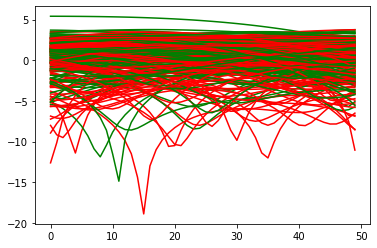

In [110]:
power_successful = []
power_unsuccessful = []
for event_trace, success in zip(power_sel, mask):
    if success:
        plt.plot(np.arange(len(event_trace)), event_trace, color='green')
        power_successful.append(np.mean(event_trace, axis=0))
    else:
        plt.plot(np.arange(len(event_trace)), event_trace, color='red')
        power_unsuccessful.append(np.mean(event_trace, axis=0))

In [111]:
cohens_d(power_successful, power_unsuccessful)

0.38755645419155543

In [112]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(cohens_d(power_successful, power_unsuccessful), max_value, rtol=rtol, atol=atol)
print(f'Check passed. Cohen\'s d value computed from this visually inspected re-implementation matches the saved-out Cohen\'s d value.') 

Check passed. Cohen's d value computed from this visually inspected re-implementation matches the saved-out Cohen's d value.


#### Minimum value

In [113]:
min_value = np.nanmin(reference_elpomx)
min_value_indices = ()
for iElec in np.arange(reference_elpomx.shape[0]):
        for iFreq in np.arange(reference_elpomx.shape[1]):
            for iEpoch in np.arange(reference_elpomx.shape[2]):
                    if reference_elpomx[iElec, iFreq, iEpoch] == min_value:
                        min_value_indices = (iElec, iFreq, iEpoch)
                        print(f'The maximum value {min_value} is located at indices: {min_value_indices}.')

The maximum value -0.5800818216825632 is located at indices: (70, 3, 4).


In [114]:
epoch_idx = min_value_indices[2]
epoch = np.arange(epoch_idx*50, epoch_idx*50+50)
power_sel = power.isel(channel = min_value_indices[0]).isel(frequency = min_value_indices[1]).isel(time = epoch).data

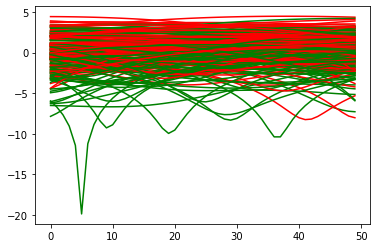

In [115]:
power_successful = []
power_unsuccessful = []
for event_trace, success in zip(power_sel, mask):
    if success:
        plt.plot(np.arange(len(event_trace)), event_trace, color='green')
        power_successful.append(np.mean(event_trace, axis=0))
    else:
        plt.plot(np.arange(len(event_trace)), event_trace, color='red')
        power_unsuccessful.append(np.mean(event_trace, axis=0))

In [116]:
cohens_d(power_successful, power_unsuccessful)

-0.5800818216825632

In [117]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(cohens_d(power_successful, power_unsuccessful), min_value, rtol=rtol, atol=atol)
print(f'Check passed. Cohen\'s d value computed from this visually inspected re-implementation matches the saved-out Cohen\'s d value.') 

Check passed. Cohen's d value computed from this visually inspected re-implementation matches the saved-out Cohen's d value.


### Region power matrix generation

### Power matrix integration test

## Find overlapping pairs

In [1232]:
pairs = get_pairs(dfrow)

In [1234]:
find_overlapping_pairs(pairs)

[(0, 0),
 (0, 1),
 (1, 0),
 (1, 1),
 (1, 2),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 3),
 (4, 4),
 (4, 5),
 (5, 4),
 (5, 5),
 (5, 6),
 (6, 5),
 (6, 6),
 (6, 7),
 (7, 6),
 (7, 7),
 (7, 8),
 (8, 7),
 (8, 8),
 (8, 9),
 (9, 8),
 (9, 9),
 (9, 10),
 (10, 9),
 (10, 10),
 (10, 11),
 (11, 10),
 (11, 11),
 (11, 12),
 (12, 11),
 (12, 12),
 (13, 13),
 (13, 14),
 (14, 13),
 (14, 14),
 (14, 15),
 (15, 14),
 (15, 15),
 (15, 16),
 (16, 15),
 (16, 16),
 (16, 17),
 (17, 16),
 (17, 17),
 (17, 18),
 (18, 17),
 (18, 18),
 (18, 19),
 (19, 18),
 (19, 19),
 (19, 20),
 (20, 19),
 (20, 20),
 (20, 21),
 (21, 20),
 (21, 21),
 (21, 22),
 (22, 21),
 (22, 22),
 (22, 23),
 (23, 22),
 (23, 23),
 (23, 24),
 (24, 23),
 (24, 24),
 (24, 25),
 (25, 24),
 (25, 25),
 (25, 26),
 (26, 25),
 (26, 26),
 (26, 27),
 (27, 26),
 (27, 27),
 (28, 28),
 (28, 29),
 (29, 28),
 (29, 29),
 (29, 30),
 (30, 29),
 (30, 30),
 (30, 31),
 (31, 30),
 (31, 31),
 (31, 32),
 (32, 31),
 (32, 32),
 (32, 33),
 (33, 32),
 (33, 33),
 (

## Electrode regionalization

In [27]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

Length of sess_list_df: 980


sub  exp  sess  loc  mon atlas contacts_source  \
sub    exp sess loc mon                                                      
R1001P FR1 0    0   0    R1001P  FR1     0    0    0   avg        contacts   
           1    0   0    R1001P  FR1     1    0    0   avg        contacts   
R1002P FR1 0    0   0    R1002P  FR1     0    0    0   avg        contacts   
           1    0   0    R1002P  FR1     1    0    0   avg        contacts   
R1003P FR1 0    0   0    R1003P  FR1     0    0    0   avg        contacts   

                          eeg eeg_data_source  eeg_error  ... no_matches_rm  \
sub    exp sess loc mon                                   ...                 
R1001P FR1 0    0   0    True      cmlreaders        NaN  ...          19.0   
           1    0   0    True      cmlreaders        NaN  ...          15.0   
R1002P FR1 0    0   0    True      cmlreaders        NaN  ...          46.0   
           1    0   0    True      cmlreaders        NaN  ...          23.0   
R1003P FR1 0    0   0    True      cmlreaders        NaN  ...          23.0   

                         mean_succ_times_rm  mean_unsucc_times_rm  \
sub    exp sess loc mon                                             
R1001P FR1 0    0   0          13339.947368          12390.000000   
           1    0   0           9179.200000           9117.400000   
R1002P FR1 0    0   0          13129.239130          12938.630435   
           1    0   0          11955.956522          11924.826087   
R1003P FR1 0    0   0          13344.086957          12047.043478   

                         no_matches_ri  mean_succ_times_ri  \
sub    exp sess loc mon                                      
R1001P FR1 0    0   0             17.0        13803.588235   
           1    0   0             13.0         9279.384615   
R1002P FR1 0    0   0              NaN                 NaN   
           1    0   0              NaN                 NaN   
R1003P FR1 0    0   0             23.0        13344.086957   

                         mean_unsucc_times_ri  recall_rate  en_match_rate  \
sub    exp sess loc mon                                                     
R1001P FR1 0    0   0            14292.176471     0.206667       0.176667   
           1    0   0            10227.769231     0.210000       0.206667   
R1002P FR1 0    0   0                     NaN     0.390000       0.356667   
           1    0   0                     NaN     0.400000       0.360000   
R1003P FR1 0    0   0            13791.652174     0.325758       0.303030   

                        rm_match_rate  ri_match_rate  
sub    exp sess loc mon                               
R1001P FR1 0    0   0        0.306452       0.274194  
           1    0   0        0.238095       0.206349  
R1002P FR1 0    0   0        0.393162            NaN  
           1    0   0        0.191667            NaN  
R1003P FR1 0    0   0        0.267442       0.267442  

[5 rows x 45 columns]

In [28]:
all_pairs_regionalizations = [] # Initialize a list for gathering all the  
for iSess, rSess in sess_list_df.iterrows():
    
    dfrow = get_dfrow(iSess) # Get dfrow from session label
    pairs = get_pairs(dfrow) # Load saved-out pairs into memory
    localization = get_localization(dfrow) # Load saved-out localization into memory
                    
    atlas_labels = get_atlas_labels(pairs, localization) # Get atlas labels (pair label, region label from one of the atlases, and the name of the atlas used)
    assert len(atlas_labels) == len(pairs), f'Length of atlas_labels is {len(atlas_labels)}, but length of pairs is {len(pairs)}.' # Check that there are as many atlas labels as pairs
                    
    regionalizations = regionalize_electrodes(pairs, localization) # Get "unified" region labels for all pairs
    assert len(regionalizations) == len(pairs), f'Length of regionalizations is {len(regionalizations)}, but length of pairs is {len(pairs)}.' # Check that there are as many regionalizations as pairs
                    
    pairs_regionalizations = pd.concat([pairs[['contact_1', 'contact_2']], atlas_labels], axis=1) # Initialize a new DataFrame that has information from pairs, atlas labels, and regionalizations for the sake of verification
    pairs.set_index('label', inplace=True) # Set the so that we can look up a pair's region label from a certain atlas
    pairs_regionalizations['atlas_label_from_pairs'] = pairs_regionalizations.apply(lambda r: pairs.loc[r['pair_label'], r['atlas']] if not r['atlas'] == 'no atlas' else 'nan', axis=1)
    pairs.reset_index(inplace=True)
    
    hemisphere_cols = np.intersect1d(['mni.x','ind.corrected.x', 'ind.snap.x', 'ind.dural.x', 'ind.x', 'avg.corrected.x', 'avg.snap.x', 'avg.dural.x', 'avg.x', 'tal.x', 'x', 'hemisphere', 'Loc2'], pairs.columns)
    pairs_regionalizations[hemisphere_cols] = pairs[hemisphere_cols]
    pairs_regionalizations['regionalization'] = regionalizations # Add regionalizations to pairs_regionalization DataFrame
    pairs_regionalizations[['sub', 'exp', 'sess', 'loc', 'mon']] = dfrow # Add the session label to the DataFrame
    
    all_pairs_regionalizations.append(pairs_regionalizations)

all_pairs_regionalizations = pd.concat(all_pairs_regionalizations)

In [29]:
# Check that atlas label generated by the get_atlas_labels() function matches the entry from the corresponding atlas
assert (all_pairs_regionalizations['atlas_label'] == all_pairs_regionalizations['atlas_label_from_pairs']).all()

In [66]:
def check_hemisphere_label(r):
    
    atlases_x = np.intersect1d(['mni.x','ind.corrected.x', 'ind.snap.x', 'ind.dural.x', 'ind.x', 'avg.corrected.x', 'avg.snap.x', 'avg.dural.x', 'avg.x', 'tal.x', 'x'], r.keys())
    atlases_x = np.asarray([atlas_x for atlas_x in atlases_x if not pd.isna(r[atlas_x])])
    
    hemisphere_label_correct = False
    
    if 'L' in str(r['regionalization']):
            
        c1 = ( ('left' in r['atlas_label'].lower()) | (np.any([float(r[atlas_x]) < 0 for atlas_x in atlases_x])) )
        if 'Loc2' in r.keys(): c1 = ( c1 | ('left' in str(r['Loc2']).lower()))
        c2 = 'right' not in r['atlas_label'].lower()
        c3 = np.all([float(r[atlas_x]) < 0 for atlas_x in atlases_x])
        c4 = 'right' not in str(r['Loc2']).lower() if 'Loc2' in r.keys() else True
        hemisphere_label_correct = c1 & c2 & c3 & c4
        
    elif 'R' in str(r['regionalization']):
            
        c1 = ( ('right' in r['atlas_label'].lower()) | (np.any([float(r[atlas_x]) > 0 for atlas_x in atlases_x])) )
        if 'Loc2' in r.keys(): c1 = ( c1 | ('right' in str(r['Loc2']).lower()))
        c2 = 'left' not in r['atlas_label'].lower()
        c3 = np.all([float(r[atlas_x]) > 0 for atlas_x in atlases_x])
        c4 = 'left' not in str(r['Loc2']).lower() if 'Loc2' in r.keys() else True
        hemisphere_label_correct = c1 & c2 & c3 & c4
            
    elif pd.isna(r['regionalization']):
        
        c1 = ('left' not in r['atlas_label'].lower()) & ('right' not in r['atlas_label'].lower())
        c2 = np.all([( (np.isnan(r[atlas_x])) | (r[atlas_x] == 0) ) for atlas_x in atlases_x])
        c3 = ('left' not in str(r['Loc2']).lower()) & ('right' not in str(r['Loc2']).lower()) if 'Loc2' in r.keys() else True
        hemisphere_label_correct = c1 & c2 & c3
        
    return hemisphere_label_correct
        
all_pairs_regionalizations['hemisphere_label_check'] = all_pairs_regionalizations.apply(lambda r: check_hemisphere_label(r), axis=1)
all_pairs_regionalizations.reset_index(inplace=True)

In [90]:
failed_hemisphere_label_check = all_pairs_regionalizations.query('hemisphere_label_check == False')
assert not pd.isna(failed_hemisphere_label_check['regionalization']).any()
assert not (pd.isna(failed_hemisphere_label_check['mni.x']) & pd.isna(failed_hemisphere_label_check['ind.x'])).any()

In [98]:
region_labels = get_region_information('region_labels')
for region in region_labels:
    this_region_atlas_labels = all_pairs_regionalizations.query('regionalization == @region')['atlas_labels'].unique()
    print(f'{region}: {this_region_atlas_labels}')

KeyError: 'atlas_labels'

## Helper functions

### Matrix operations

#### Symmetrization

In [36]:
A = [[np.nan, np.nan, np.nan], 
     [5, np.nan, np.nan],
     [6, 7, np.nan]]
A_out = [[np.nan, 5, 6], 
         [5, np.nan, 7],
         [6, 7, np.nan]]

B1 = [[np.nan, np.nan, np.nan], 
      [5, np.nan, np.nan],
      [6, 7, np.nan]]
B2 = [[np.nan, 5, 6], 
      [np.nan, np.nan, 7],
      [np.nan, np.nan, np.nan]]
B_out1 = [[np.nan, 5, 6], 
          [5, np.nan, 7],
          [6, 7, np.nan]]
B_out2 = [[np.nan, 5, 6], 
         [5, np.nan, 7],
         [6, 7, np.nan]]

for var in ['A', 'A_out', 'B1', 'B2', 'B_out1', 'B_out2']: globals()[var] = np.asarray(globals()[var])

B1 = B1[..., np.newaxis]
B2 = B2[..., np.newaxis]
B = np.concatenate([B1, B2], axis=-1)

B_out1 = B_out1[..., np.newaxis]
B_out2 = B_out2[..., np.newaxis]
B_out = np.concatenate([B_out1, B_out2], axis=-1)



In [37]:
rtol = 1e-5
atol = 1e-8
assert np.allclose(symmetrize(A), A_out, rtol=rtol, atol=atol, equal_nan=True)
assert np.allclose(symmetrize(B), B_out, rtol=rtol, atol=atol, equal_nan=True)
print('Checks passed.')

Checks passed.


### JZS Bayes factor calculation

In [441]:
rtol = 0.015

target_BF_value = 10
error = target_BF_value * rtol
lower_bound = target_BF_value - error
upper_bound = target_BF_value + error
for (N, t) in zip([100, 200, 500], 
                  [0.69, 1.08, 1.44]):
    BF_value = jzs_bayes_factor(t, N)
    assert lower_bound < BF_value < upper_bound, f'Check failed | BF_value: {BF_value}, t: {t}, N: {N}'
print(f'All checks passed with target BF value {target_BF_value}. Permitted error: {error:.2}. Lower bound: {lower_bound:.2}. Upper bound: {upper_bound:.2}.')
        
target_BF_value = 3
error = target_BF_value * rtol
lower_bound = target_BF_value - error
upper_bound = target_BF_value + error
for (N, t) in zip([5, 10, 20, 50, 100, 200, 500], 
                  [0.40, 0.89, 1.20, 1.51, 1.72, 1.90, 2.12]):
    BF_value = jzs_bayes_factor(t, N)
    assert lower_bound < BF_value < upper_bound, f'Check failed | BF_value: {BF_value}, t: {t}, N: {N}'
print(f'All checks passed with target BF value {target_BF_value}. Permitted error: {error:.2}. Lower bound: {lower_bound:.2}. Upper bound: {upper_bound:.2}.')
    
target_BF_value = 1/3
error = target_BF_value * rtol
lower_bound = target_BF_value - error
upper_bound = target_BF_value + error
for (N, t) in zip([5, 10, 20, 50, 100, 200, 500], 
                  [3.15, 2.73, 2.64, 2.68, 2.76, 2.86, 2.99]):
    BF_value = jzs_bayes_factor(t, N)
    assert lower_bound < BF_value < upper_bound, f'Check failed | BF_value: {BF_value}, t: {t}, N: {N}'
print(f'All checks passed with target BF value {target_BF_value}. Permitted error: {error:.2}. Lower bound: {lower_bound:.2}. Upper bound: {upper_bound:.2}.')
    
target_BF_value = 1/10
error = target_BF_value * rtol
lower_bound = target_BF_value - error
upper_bound = target_BF_value + error
for (N, t) in zip([5, 10, 20, 50, 100, 200, 500], 
                  [4.97, 3.60, 3.26, 3.17, 3.20, 3.27, 3.38]):
    BF_value = jzs_bayes_factor(t, N)
    assert lower_bound < BF_value < upper_bound, f'Check failed | BF_value: {BF_value}, t: {t}, N: {N}'
print(f'All checks passed with target BF value {target_BF_value}. Permitted error: {error:.2}. Lower bound: {lower_bound:.2}. Upper bound: {upper_bound:.2}.')

All checks passed with target BF value 10. Permitted error: 0.15. Lower bound: 9.8. Upper bound: 1e+01.
All checks passed with target BF value 3. Permitted error: 0.045. Lower bound: 3.0. Upper bound: 3.0.
All checks passed with target BF value 0.3333333333333333. Permitted error: 0.005. Lower bound: 0.33. Upper bound: 0.34.
All checks passed with target BF value 0.1. Permitted error: 0.0015. Lower bound: 0.099. Upper bound: 0.1.


## Regsymx checks

In [110]:
def check_regsymx(dfrow):
    
    dfrow = get_dfrow(dfrow)
    
    for beh in ['en', 'rm', 'ri']:
        pairs, localization = get_pairs(dfrow), get_localization(dfrow)
        regionalizations = regionalize_electrodes(pairs, localization)
        regionalizations = exclude_regionalizations(dfrow, pairs, regionalizations)
        elsymx_fname = os.path.join(root_dir, beh, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
        if not ex(elsymx_fname): continue
        elsymx = npl(elsymx_fname)
        elsymx_regs = add_regions_elsymx(elsymx, regionalizations, np.arange(3,9), beh)
        regsymx = regionalize_electrode_connectivities(elsymx_regs)
        
        reference_regsymx_fname = os.path.join(root_dir, beh, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
        reference_regsymx = xr.open_dataarray(reference_regsymx_fname)

        matches = np.allclose(regsymx.data, reference_regsymx.data, equal_nan=True)
        if not matches: np.save(join(root_dir, 'regsymx_checks', f'{ftag(dfrow)}_{beh}.npy'), reference_regsymx_fname)
        
    for beh in ['en', 'rm', 'ri']:
        for iShuffle in np.arange(1, 21):
            pairs, localization = get_pairs(dfrow), get_localization(dfrow)
            regionalizations = regionalize_electrodes(pairs, localization)
            regionalizations = exclude_regionalizations(dfrow, pairs, regionalizations)
            elsymx_fname = os.path.join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
            if not ex(elsymx_fname): continue
            elsymx = npl(elsymx_fname)
            elsymx_regs = add_regions_elsymx(elsymx, regionalizations, np.arange(3,9), beh)
            regsymx = regionalize_electrode_connectivities(elsymx_regs)

            reference_regsymx_fname = os.path.join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
            reference_regsymx = xr.open_dataarray(reference_regsymx_fname)

            matches = np.allclose(regsymx.data, reference_regsymx.data, equal_nan=True)
            if not matches: np.save(join(root_dir, 'regsymx_checks', f'{ftag(dfrow)}_{beh}_shuffled{iShuffle}.npy'), reference_regsymx_fname)

In [115]:
np.all([future.status == 'finished' for future in futures])

True

In [116]:
client.shutdown()

In [111]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [112]:
client = cl('check_regsymx', '10G', int(4000/10), walltime=100000) 
futures = client.map(check_regsymx, sess_list)

Unique port for amrao is 51507
{'dashboard_address': ':51507'}
To view the dashboard, run: 
`ssh -fN amrao@rhino2.psych.upenn.edu -L 8000:192.168.86.141:51507` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [221]:
check_regsymx(('R1001P','FR1',0,0,0))

In [222]:
check_regsymx(('TJ005','pyFR',1,0,0))

In [223]:
check_regsymx(('TJ005','pyFR',2,0,0))

In [245]:
regsymx_check_dir = '/scratch/amrao/retrieval_connectivity/regsymx_checks'
for regsymx_check_fname in ld(regsymx_check_dir):
    regsymx_check_path = join(regsymx_check_dir, regsymx_check_fname)
    regsymx_path = str(npl(regsymx_check_path))
    if 'ri' in regsymx_path: print(regsymx_check_fname)
    os.system(f'rm {regsymx_path}')

TJ005_pyFR_2_rm.npy
R1001P_FR1_1_en_shuffled5.npy
R1309M_FR1_2_en_shuffled2.npy
R1167M_catFR1_0_rm.npy
R1323T_FR1_0_en_shuffled1.npy
R1230J_FR1_5_en_shuffled5.npy
TJ077_pyFR_1_en_shuffled3.npy
TJ041_pyFR_4_en_shuffled10.npy
R1202M_catFR1_1_en_shuffled5.npy
R1299T_FR1_1_en_shuffled6.npy
R1351M_FR1_0_en_shuffled8.npy
R1346T_FR1_1_en_shuffled4.npy
R1196N_FR1_1_en_shuffled10.npy
R1231M_catFR1_0_en_shuffled14.npy
R1498D_catFR1_4_en_shuffled6.npy
R1501J_catFR1_5_en_shuffled12.npy
R1497T_catFR1_0_en_shuffled15.npy
R1315T_FR1_2_en_shuffled14.npy
R1154D_FR1_1_rm_shuffled17.npy
R1375C_catFR1_3_en_shuffled2.npy
R1231M_FR1_0_en_shuffled4.npy
R1164E_FR1_0_en_shuffled3.npy
R1477J_catFR1_2_en.npy
R1147P_FR1_0_en_shuffled3.npy
R1111M_FR1_1_en.npy
TJ034_pyFR_1_rm_shuffled7.npy
UP024_pyFR_1_en.npy
TJ005_pyFR_4_0_1_en_shuffled5.npy
R1637T_catFR1_0_en_shuffled4.npy
UP011_pyFR_0_en_shuffled12.npy
UP041_pyFR_1_en_shuffled2.npy
R1390M_catFR1_1_en_shuffled8.npy
UP007_pyFR_1_en_shuffled18.npy
TJ025_pyFR_0_en_s

## Matrix aggregation

In [4]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

Length of sess_list_df: 980


sub  exp  sess  loc  mon atlas contacts_source  \
sub    exp sess loc mon                                                      
R1001P FR1 0    0   0    R1001P  FR1     0    0    0   avg        contacts   
           1    0   0    R1001P  FR1     1    0    0   avg        contacts   
R1002P FR1 0    0   0    R1002P  FR1     0    0    0   avg        contacts   
           1    0   0    R1002P  FR1     1    0    0   avg        contacts   
R1003P FR1 0    0   0    R1003P  FR1     0    0    0   avg        contacts   

                          eeg eeg_data_source  eeg_error  ... no_matches_rm  \
sub    exp sess loc mon                                   ...                 
R1001P FR1 0    0   0    True      cmlreaders        NaN  ...          19.0   
           1    0   0    True      cmlreaders        NaN  ...          15.0   
R1002P FR1 0    0   0    True      cmlreaders        NaN  ...          46.0   
           1    0   0    True      cmlreaders        NaN  ...          23.0   
R1003P FR1 0    0   0    True      cmlreaders        NaN  ...          23.0   

                         mean_succ_times_rm  mean_unsucc_times_rm  \
sub    exp sess loc mon                                             
R1001P FR1 0    0   0          13339.947368          12390.000000   
           1    0   0           9179.200000           9117.400000   
R1002P FR1 0    0   0          13129.239130          12938.630435   
           1    0   0          11955.956522          11924.826087   
R1003P FR1 0    0   0          13344.086957          12047.043478   

                         no_matches_ri  mean_succ_times_ri  \
sub    exp sess loc mon                                      
R1001P FR1 0    0   0             17.0        13803.588235   
           1    0   0             13.0         9279.384615   
R1002P FR1 0    0   0              NaN                 NaN   
           1    0   0              NaN                 NaN   
R1003P FR1 0    0   0             23.0        13344.086957   

                         mean_unsucc_times_ri  recall_rate  en_match_rate  \
sub    exp sess loc mon                                                     
R1001P FR1 0    0   0            14292.176471     0.206667       0.176667   
           1    0   0            10227.769231     0.210000       0.206667   
R1002P FR1 0    0   0                     NaN     0.390000       0.356667   
           1    0   0                     NaN     0.400000       0.360000   
R1003P FR1 0    0   0            13791.652174     0.325758       0.303030   

                        rm_match_rate  ri_match_rate  
sub    exp sess loc mon                               
R1001P FR1 0    0   0        0.306452       0.274194  
           1    0   0        0.238095       0.206349  
R1002P FR1 0    0   0        0.393162            NaN  
           1    0   0        0.191667            NaN  
R1003P FR1 0    0   0        0.267442       0.267442  

[5 rows x 45 columns]

In [5]:
sublist = sess_list_df['sub'].unique() # Get list of unique subject codes
print(f'There are {len(sublist)} analyzed subjects.')
print(sublist) # Print the list of unique subject codes

There are 378 analyzed subjects.
['R1001P' 'R1002P' 'R1003P' 'R1006P' 'R1010J' 'R1013E' 'R1016M' 'R1018P'
 'R1020J' 'R1021D' 'R1022J' 'R1024E' 'R1026D' 'R1028M' 'R1030J' 'R1031M'
 'R1032D' 'R1033D' 'R1035M' 'R1036M' 'R1039M' 'R1042M' 'R1045E' 'R1048E'
 'R1050M' 'R1051J' 'R1052E' 'R1053M' 'R1054J' 'R1056M' 'R1060M' 'R1061T'
 'R1062J' 'R1063C' 'R1065J' 'R1066P' 'R1067P' 'R1068J' 'R1069M' 'R1070T'
 'R1074M' 'R1075J' 'R1076D' 'R1077T' 'R1080E' 'R1083J' 'R1084T' 'R1089P'
 'R1092J' 'R1093J' 'R1094T' 'R1096E' 'R1098D' 'R1101T' 'R1102P' 'R1104D'
 'R1105E' 'R1106M' 'R1107J' 'R1108J' 'R1111M' 'R1112M' 'R1113T' 'R1114C'
 'R1115T' 'R1118N' 'R1120E' 'R1121M' 'R1122E' 'R1123C' 'R1124J' 'R1125T'
 'R1127P' 'R1128E' 'R1129D' 'R1130M' 'R1131M' 'R1134T' 'R1135E' 'R1136N'
 'R1137E' 'R1138T' 'R1141T' 'R1144E' 'R1145J' 'R1146E' 'R1147P' 'R1148P'
 'R1149N' 'R1150J' 'R1151E' 'R1153T' 'R1154D' 'R1156D' 'R1157C' 'R1161E'
 'R1162N' 'R1163T' 'R1164E' 'R1166D' 'R1167M' 'R1168T' 'R1169P' 'R1170J'
 'R1172E' 'R1173J'

In [11]:
reg1, reg2 = 'L hippocampus', 'R hippocampus'
region_labels = get_region_information('region_labels')

In [18]:
beh = 'rm'
iFreq = 4
iEpoch = 4
success = 1

freq = np.arange(3, 9)[iFreq]
epoch = beh_to_epochs[beh][iEpoch]

In [19]:
all_sub_values = []
for sub in sublist:
    
    this_sub_values = []
    this_sub_session_list = sess_list_df.query('sub == @sub')
    montage_count = len(this_sub_session_list['mon'].unique())
    montage_session_count = [len(this_sub_session_list.query('mon==@mon')) for mon in this_sub_session_list['mon'].unique()]
    
    for iSess, rSess in this_sub_session_list.iterrows():

        dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
        mx_fname = os.path.join(root_dir, beh, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
        mx = xr.open_dataarray(mx_fname).sel(reg1 = reg1, reg2 = reg2, freq = freq, epoch = epoch, success = success)
        value = float(mx.data)
        if not np.isnan(value):
            this_sub_values.append(value)

    assert len(this_sub_values) in [0, len(this_sub_session_list), *montage_session_count], f'{sub}'
    if len(this_sub_values) == 0: continue
    mean_sub_value = np.mean(this_sub_values)
    assert not np.isnan(mean_sub_value)
    all_sub_values.append(mean_sub_value)

check_value = np.mean(all_sub_values)   

In [20]:
symx = xr.open_dataarray(os.path.join(root_dir, f'{beh}_pop_symx.nc'))
aggregated_value = float(symx.sel(reg1 = reg1, reg2 = reg2, freq = freq, epoch = epoch, success = success).mean('sub').values)

In [21]:
check_value

0.007255821430389301

In [22]:
aggregated_value

0.007255821430389301

In [23]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(check_value, aggregated_value, rtol=rtol, atol=atol, equal_nan=True)

## Effect size correlation analyses

### Trial count

In [303]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

In [443]:
sublist = sess_list_df['sub'].unique() # Get list of unique subject codes
print(f'There are {len(sublist)} analyzed subjects.')
print(sublist) # Print the list of unique subject codes

There are 378 subjects being analyzed.
['R1001P' 'R1002P' 'R1003P' 'R1006P' 'R1010J' 'R1013E' 'R1016M' 'R1018P'
 'R1020J' 'R1021D' 'R1022J' 'R1024E' 'R1026D' 'R1028M' 'R1030J' 'R1031M'
 'R1032D' 'R1033D' 'R1035M' 'R1036M' 'R1039M' 'R1042M' 'R1045E' 'R1048E'
 'R1050M' 'R1051J' 'R1052E' 'R1053M' 'R1054J' 'R1056M' 'R1060M' 'R1061T'
 'R1062J' 'R1063C' 'R1065J' 'R1066P' 'R1067P' 'R1068J' 'R1069M' 'R1070T'
 'R1074M' 'R1075J' 'R1076D' 'R1077T' 'R1080E' 'R1083J' 'R1084T' 'R1089P'
 'R1092J' 'R1093J' 'R1094T' 'R1096E' 'R1098D' 'R1101T' 'R1102P' 'R1104D'
 'R1105E' 'R1106M' 'R1107J' 'R1108J' 'R1111M' 'R1112M' 'R1113T' 'R1114C'
 'R1115T' 'R1118N' 'R1120E' 'R1121M' 'R1122E' 'R1123C' 'R1124J' 'R1125T'
 'R1127P' 'R1128E' 'R1129D' 'R1130M' 'R1131M' 'R1134T' 'R1135E' 'R1136N'
 'R1137E' 'R1138T' 'R1141T' 'R1144E' 'R1145J' 'R1146E' 'R1147P' 'R1148P'
 'R1149N' 'R1150J' 'R1151E' 'R1153T' 'R1154D' 'R1156D' 'R1157C' 'R1161E'
 'R1162N' 'R1163T' 'R1164E' 'R1166D' 'R1167M' 'R1168T' 'R1169P' 'R1170J'
 'R1172E' 'R

In [38]:
for sub in sublist:
    for beh in ['en', 'rm']:
        this_sub_session_list = sess_list_df.query('sub == @sub')
        count = 0
        for iSess, rSess in this_sub_session_list.iterrows():
            dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
            events = load_events(dfrow, beh)
            count += len(events)//2
        assert count == get_sub_trial_count(sub, beh, sess_list_df)

sess_list_df_ri = sess_list_df.query('ri_events == True')
sublist_ri = sess_list_df_ri['sub'].unique()
for sub in sublist_ri:
    for beh in ['ri']:
        this_sub_session_list = sess_list_df_ri.query('sub == @sub')
        count = 0
        for iSess, rSess in this_sub_session_list.iterrows():
            dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
            events = load_events(dfrow, beh)
            count += len(events)//2
        assert count == get_sub_trial_count(sub, beh, sess_list_df_ri)

NameError: name 'load_events' is not defined

In [ ]:
for beh in ['en', 'rm']:
    mx_fname = os.path.join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(mx_fname).mean('epoch').mean('freq').mean('reg1').mean('reg2')
    mx = mx.sel(success=1) - mx.sel(success=0)
    subs = mx.sub
    mx = mx.data
    
    event_count_effect_size_sub_list_df = get_event_count_effect_size(beh)
    for i, r in event_count_effect_size_sub_list_df.iterrows():
        assert r[f'{beh}_event_count'] == get_sub_trial_count(r['sub'], beh, sess_list_df)
        sub_idx = np.where(subs == r['sub'])[0]
        assert r[f'{beh}_effect_size'] == mx[sub_idx]
    
        
for beh in ['ri']:
    mx_fname = os.path.join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(mx_fname)
    mx = mx.sel(success=1) - mx.sel(success=0)
    subs = mx.sub
    mx = mx.data
    
    event_count_effect_size_sub_list_df = get_event_count_effect_size(beh)
    for i, r in event_count_effect_size_sub_list_df.iterrows():
        assert r[f'{beh}_event_count'] == get_sub_trial_count(r['sub'], beh, sess_list_df_ri)
        sub_idx = np.where(subs == r['sub'])[0]
        assert r[f'{beh}_effect_size'] == mx[sub_idx]

In [ ]:
for beh in ['en', 'rm', 'ri']:
    np.random.seed(202409)
    event_count_effect_size_sub_list_df = get_event_count_effect_size(beh)
    rs = []
    r = scipy.stats.pearsonr(event_count_effect_size_sub_list_df[f'{beh}_event_count'].values,
                             event_count_effect_size_sub_list_df[f'{beh}_effect_size'].values)[0]
    rs.append(r)
    for _ in range(999):
        np.random.shuffle(event_count_effect_size_sub_list_df[f'{beh}_event_count'].values)
        np.random.shuffle(event_count_effect_size_sub_list_df[f'{beh}_effect_size'].values)
        r = scipy.stats.pearsonr(event_count_effect_size_sub_list_df[f'{beh}_event_count'].values,
                                 event_count_effect_size_sub_list_df[f'{beh}_effect_size'].values)[0]
        rs.append(r)
    rs = np.asarray(rs)
    print(f'r = {rs[0]}, p = {(np.abs(rs) >= np.abs(rs[0]))/1000}')

### Noise floor

In [303]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

In [443]:
sublist = sess_list_df['sub'].unique() # Get list of unique subject codes
print(f'There are {len(sublist)} analyzed subjects.')
print(sublist) # Print the list of unique subject codes

There are 378 subjects being analyzed.
['R1001P' 'R1002P' 'R1003P' 'R1006P' 'R1010J' 'R1013E' 'R1016M' 'R1018P'
 'R1020J' 'R1021D' 'R1022J' 'R1024E' 'R1026D' 'R1028M' 'R1030J' 'R1031M'
 'R1032D' 'R1033D' 'R1035M' 'R1036M' 'R1039M' 'R1042M' 'R1045E' 'R1048E'
 'R1050M' 'R1051J' 'R1052E' 'R1053M' 'R1054J' 'R1056M' 'R1060M' 'R1061T'
 'R1062J' 'R1063C' 'R1065J' 'R1066P' 'R1067P' 'R1068J' 'R1069M' 'R1070T'
 'R1074M' 'R1075J' 'R1076D' 'R1077T' 'R1080E' 'R1083J' 'R1084T' 'R1089P'
 'R1092J' 'R1093J' 'R1094T' 'R1096E' 'R1098D' 'R1101T' 'R1102P' 'R1104D'
 'R1105E' 'R1106M' 'R1107J' 'R1108J' 'R1111M' 'R1112M' 'R1113T' 'R1114C'
 'R1115T' 'R1118N' 'R1120E' 'R1121M' 'R1122E' 'R1123C' 'R1124J' 'R1125T'
 'R1127P' 'R1128E' 'R1129D' 'R1130M' 'R1131M' 'R1134T' 'R1135E' 'R1136N'
 'R1137E' 'R1138T' 'R1141T' 'R1144E' 'R1145J' 'R1146E' 'R1147P' 'R1148P'
 'R1149N' 'R1150J' 'R1151E' 'R1153T' 'R1154D' 'R1156D' 'R1157C' 'R1161E'
 'R1162N' 'R1163T' 'R1164E' 'R1166D' 'R1167M' 'R1168T' 'R1169P' 'R1170J'
 'R1172E' 'R

In [92]:
dfrow = sess_list_df.iloc[50]
beh = 'en'
freqs = np.arange(3, 9)
events = load_events(dfrow, beh) # Load events for this dfrow and behavioral contrast
events['event_idx'] = np.arange(len(events))
events.sort_values(by=['mstime', 'eegoffset'], inplace=True)
iShuffle = 19
shuffled_mask_fname = os.path.join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'shuffled_masks', f'{ftag(dfrow)}_shuffled_mask.npy')
print(shuffled_mask_fname)
shuffled_mask = npl(shuffled_mask_fname)[events['event_idx'].values]

/scratch/amrao/retrieval_connectivity/noise_floor_analysis/en/shuffle_19/shuffled_masks/R1367D_catFR1_0_shuffled_mask.npy


In [77]:
iElec1, iElec2 = 5, 10
iFreq = 4
iEpoch = 4
success = 1

freq = np.arange(3, 9)[iFreq]
epoch = beh_to_epochs[beh][iEpoch]
iSuccess = 1 - success

In [80]:
phase, mask, sr = process_phase(dfrow, events, freqs)
phase_diff = (phase.isel(channel = iElec1) - phase.isel(channel = iElec2)).data
phase_diff = timebin_phase_timeseries(phase_diff, sr)
if success: ppc_value = ppc(phase_diff[shuffled_mask, ...])
else: ppc_value = ppc(phase_diff[~shuffled_mask, ...])
ppc_value = ppc_value[iFreq, iEpoch]

In [81]:
reference_elsymx_fname = os.path.join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
print(reference_elsymx_fname)
reference_elsymx = npl(reference_elsymx_fname)
reference_value = reference_elsymx[iElec1, iElec2, iFreq, iEpoch, iSuccess]

/scratch/amrao/retrieval_connectivity/noise_floor_analysis/en/shuffle_19/elsymxs/R1001P_FR1_0_elsymx.npy


In [82]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(ppc_value, reference_value, rtol=rtol, atol=atol), f'{ppc_value:.5}, {reference_value:.5}'

In [ ]:
beh = 'en'
dfrow = sess_list_df.iloc[0]
noise_floors = []
for _ in np.arange(1, 21):
    fname = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
    mx = xr.open_dataarray(fname).mean('epoch').mean('freq').mean('reg1').mean('reg2')
    mx = mx.sel(success=1) - mx.sel(success=0)
    value = float(mx.data)
    noise_floors.append(value)
noise_floors = np.asarray(noise_floors)
assert np.all(noise_floors = npl(join(root_dir, 'noise_floor_analysis', beh, 'noise_floor_estimates', f'{ftag(dfrow)}_noise_floor_estimate.npy')))
    

In [ ]:
for beh in ['en', 'rm', 'ri']:
    
    mx_fname = os.path.join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(mx_fname).mean('epoch').mean('freq').mean('reg1').mean('reg2')
    mx = mx.sel(success=1) - mx.sel(success=0)
    subs = mx.sub
    mx = mx.data
    
    noise_floor_effect_size_sublist_df = get_noise_floor_effect_size(beh)
    for i, r in noise_floor_effect_size_sublist_df.iterrows():
        
        sub_idx = np.where(subs == r['sub'])[0]
        assert r[f'{beh}_effect_size'] == mx[sub_idx]
        
        noise_floors = []
        noise_floor_fname = join(root_dir, 'noise_floor_analysis', beh, 'noise_floor_estimates', f'{ftag(dfrow)}_noise_floor_estimate.npy')
        noise_floor = npl(noise_floor_fname)
        noise_floor = np.mean(noise_floor)
        
        assert r[f'{beh}_noise_floor'] == noise_floor

In [ ]:
for beh in ['en', 'rm', 'ri']:
    np.random.seed(202409)
    event_count_effect_size_sub_list_df = get_event_count_effect_size(beh)
    rs = []
    r = scipy.stats.pearsonr(event_count_effect_size_sub_list_df[f'{beh}_noise_floor'].values,
                             event_count_effect_size_sub_list_df[f'{beh}_effect_size'].values)[0]
    rs.append(r)
    for _ in range(999):
        np.random.shuffle(event_count_effect_size_sub_list_df[f'{beh}_noise_floor'].values)
        np.random.shuffle(event_count_effect_size_sub_list_df[f'{beh}_effect_size'].values)
        r = scipy.stats.pearsonr(event_count_effect_size_sub_list_df[f'{beh}_noise_floor'].values,
                                 event_count_effect_size_sub_list_df[f'{beh}_effect_size'].values)[0]
        rs.append(r)
    rs = np.asarray(rs)
    print(f'r = {rs[0]}, p = {(np.abs(rs) >= np.abs(rs[0]))/1000}')

## Hub analysis

### Check $\textit{t}$-statistics for hub tables

In [1125]:
hub_tables = load_pickle(join(root_dir, 'hub_tables.pkl'))

In [1129]:
for beh in ['en', 'rm', 'ri']:
    min_hub_t = hub_tables[beh].query('hub == True')['t'].min()
    max_nonhub_t = hub_tables[beh].query('hub == False')['t'].max()
    print(min_hub_t, max_nonhub_t)
    assert max_nonhub_t <= min_hub_t

1.9466492453006774 1.8586761139135435
1.5291392480818253 1.50864770786415
1.9576170317026567 1.8384701901890137


When it was originally implemented, the shuffling used the following

In [242]:
value_count = 100
stds_1 = []
stds_2 = []
shuffle_count = 10000
for _ in range(value_count):
    flip_masks1 = np.asarray([(2*((np.random.random(size=379)>=0.5)-0.5)).astype(int) for _ in range(shuffle_count)])
    flip_masks2 = np.random.choice([-1, 1], size=flip_masks1.shape)
    std_1 = np.std(np.mean(flip_masks1, axis=-1), axis=0)
    std_2 = np.std(np.mean(flip_masks2, axis=-1), axis=0)
    stds_1.append(std_1)
    stds_2.append(std_2)

In [247]:
assert np.isclose(np.mean(stds_1), np.mean(stds_2), rtol=1e-2, atol=1e-8)
print('Check passed.')

Check passed.


In [248]:
beh='en'
symx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean('epoch').mean('freq').mean('reg2')  

In [256]:
ts = []

shuffle_count = 10000
flip_masks = []
for _ in range(shuffle_count):
    idxs = (2*((np.random.random(size=len(symx.sub.values))>=0.5)-0.5)).astype(int)
    flip_masks.append(idxs)
flip_masks = np.asarray(flip_masks)
# flip_masks = np.random.choice([-1, 1], size=(shuffle_count, len(symx.sub)))

for reg in symx.reg1.values:
    symx_sel = symx.sel(reg1=reg)
    ppc_successful, ppc_unsuccessful = symx_sel.sel(success=1).data, symx_sel.sel(success=0).data
    if len(finitize(ppc_successful)) < 7: continue
    for flip_mask in flip_masks:
        t1 = scipy.stats.ttest_1samp(finitize((ppc_successful-ppc_unsuccessful)*flip_mask),popmean=0)[0]
        ppc_ = np.vstack([ppc_successful, ppc_unsuccessful])
        for idx, flip in enumerate(flip_mask):
            if flip == -1:
                a, b = ppc_[0, idx], ppc_[1, idx]
                ppc_[0, idx] = b
                ppc_[1, idx] = a
        t2 = scipy.stats.ttest_rel(finitize(ppc_[0, :]), finitize(ppc_[1, :]))[0]
        assert t1 == t2
        ts.append(t2)

In [282]:
true_ts = hub_tables['en']['t'].values
M = (~pd.isna(true_ts)).sum()
p0 = np.sum((np.quantile(ts, 0.25) <= true_ts) & (true_ts <= np.quantile(ts, 0.75)))/(0.5*M)
p0 = np.min([p0, 1])
print(f'M = {M}, p0 = {p0}')

M = 70, p0 = 0.7714285714285715


In [288]:
PPC_successful = finitize(symx.sel(reg1 = 'L amygdala', success=1).data)
PPC_unsuccessful = finitize(symx.sel(reg1 = 'L amygdala', success=0).data)
t = scipy.stats.ttest_rel(PPC_successful, PPC_unsuccessful)[0]
print(f'Number of subjects: {len(PPC_successful)}, t = {t:.3}')

Number of subjects: 124, t = 3.17


In [280]:
p_fdr = t * np.sum(x
p_fdr *= p0
print(p_fdr)

350000

In [473]:
for beh in ['en', 'rm', 'ri']:
    hub_tables[beh]['p'] = hub_tables[beh].apply(lambda r: np.sum(np.abs(t_distributions[beh]) >= np.abs(r['t']))/len(ts) if not np.isnan(r['t']) else np.nan, axis=1)


In [448]:
hub_tables['rm']['p']

0     0.000004
1     0.545400
2     0.000234
3          NaN
4     0.442574
5          NaN
6     0.249937
7     0.127096
8     0.017470
9     0.000587
10    0.000000
11    0.052270
12    0.001087
13    0.004711
14    0.006573
15    0.181807
16    0.352036
17    0.965477
18    0.239910
19    0.991704
20    0.000026
21    0.000001
22    0.000306
23    0.693269
24    0.000060
25    0.007640
26    0.507821
27    0.067380
28    0.503119
29    0.590394
30         NaN
31    0.011481
32    0.932281
33    0.000001
34    0.200879
35    0.290204
36    0.002246
37         NaN
38    0.326786
39         NaN
40    0.020317
41    0.019007
42    0.000320
43         NaN
44    0.141494
45         NaN
46    0.542443
47    0.253670
48    0.805613
49    0.000053
50    0.000087
51    0.000163
52    0.187353
53    0.000001
54    0.000027
55    0.076240
56    0.051096
57    0.647820
58    0.058200
59    0.287527
60    0.000316
61    0.000000
62    0.000044
63    0.274060
64    0.000203
65    0.701863
66    0.20

In [335]:
np.sum(np.abs(ts) >= np.abs(ht.loc['L amygdala'].t))/(10000*70)

0.00176

In [465]:
A=np.asarray([x for i,x in enumerate(hub_tables['ri']['reg']) if hub_tables['ri'].iloc[i]['sub_count'] >=7])

In [467]:
A[mask]

array(['L hippocampus'], dtype='<U28')

In [477]:
import statsmodels
statsmodels.stats.multitest.fdrcorrection(finitize(hub_tables['ri']['p'].values),method='p')[0].sum()

1

In [472]:
0.11950000000000001*p0

0.0921857142857143

In [344]:
import statsmodels
statsmodels.stats.multitest.fdrcorrection(finitize(ht[max_null_Ts'p'].values), method='p')

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False]),
 array([0.1232    , 0.70084722, 0.2596    , 0.2596    , 0.78015128,
        0.929005  , 0.97035797, 0.92858772, 0.58858182, 0.96508676,
        0.96508676, 0.35918889, 0.584     , 0.89183019, 0.838942  ,
        0.57744194, 0.929005  , 0.664     , 0.89183019, 0.13586667,
        0.24221667, 0.93215246, 0.57744194, 0.28949286, 0.98892571,
        0.35918889, 0.786365  , 0.83949216, 0.24221667, 0.79024419,
        0.57744194, 0.79024419, 0.90

In [369]:
t_shuffled = np.asarray([np.asarray(x) for x in ht['t_shuffled'].values if len(x) > 0])

In [373]:
max_null_Ts = np.max(t_shuffled,axis=0)

In [376]:
q=np.quantile(max_null_Ts, 0.975)

In [385]:
A = mx.mean('reg2').sel(reg1 = 'R amygdala')

In [386]:
scipy.stats.ttest_1samp(finitize(A.data),0)

Ttest_1sampResult(statistic=0.728934853996643, pvalue=0.46785379404618344)

In [379]:
T_vals

array([ 3.17061263,  0.94757684,  2.01840261,  2.00179348,  0.81429074,
        0.27597264,  0.05763315, -0.33755484,  1.11530326, -0.08270219,
        0.15091309,  1.70738415,  1.13926431, -0.44740189, -0.55557238,
        1.16929308,  0.27355046,  1.00235759, -0.4425068 ,  2.81418446,
        2.33962033, -0.25174611,  1.22623941,  1.92375329,  0.01491939,
        1.71263478,  0.78938208, -0.53535911,  2.40192782,  0.7425315 ,
        1.21803862,  0.73513716,  0.41125495,  1.4648342 ,  0.60951013,
        0.72893485,  1.61811445,  1.20266687, -1.42284216,  0.12590719,
        1.2645909 ,  0.21979702,  1.16514991,  0.65649561,  0.32895864,
        1.79983074,  2.78681967,  2.11287194,  0.28107259,  1.73672915,
        0.89752994,  2.08138838,  0.69487039,  0.16745666,  2.02978432,
        1.08772704,  2.48136577,  1.50183053,  2.11830071,  0.55352535,
       -0.09910197, -1.41993627,  1.62101166,  0.63023674,  0.39179712,
        2.21638057, -0.08357029,  0.57824464,  0.90404803, -1.22

In [449]:
# ht = hub_tables['rm']
T_vals = finitize(hub_tables['rm']['t'].values)
Tnull_vals = t_distributions['rm']
cutoffs = np.sort(np.abs(T_vals))
m = len(T_vals)
B = 10000
FDRs, Rs, Vs = np.empty((3, m))
for j in range(m):
    R = np.sum(np.abs(T_vals) >= cutoffs[j])
    V = np.sum(np.abs(Tnull_vals) >= cutoffs[j]) / B
    Rs[j] = R
    Vs[j] = V
    FDRs[j] = V / R

In [453]:
(FDRs < 0.05).sum()

31

In [287]:
hub_tables = load_pickle(join(root_dir, 'hub_tables.pkl'))
t_distributions = load_pickle(join(root_dir, 't_distributions.pkl'))
hub_tables['en'].set_index('reg', inplace=True)
hub_tables['en']

ppc_successful  \
reg                                                                               
L amygdala                    [nan, 0.00931133750856957, 0.00976351629669038...   
L angular gyrus               [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
L anterior cingulate gyrus    [nan, nan, nan, nan, nan, 0.011748056506808343...   
L basal forebrain             [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
L calcarine cortex            [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
L caudate nucleus             [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
L cuneus                      [nan, nan, nan, nan, 0.0008849333783522536, na...   
L frontal pole                [nan, nan, nan, nan, nan, nan, nan, 0.00084559...   
L frontoparietal operculum    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
L fusiform gyrus              [0.0037235356126211015, nan, 0.026235839098835...   
L hippocampus                 [0.004709421274247556, 0.0032578218601382967, ...   
L inferior frontal gyrus      [0.003096359689378061, 0.0015507056484305342, ...   
L inferior parietal lobule    [nan, nan, nan, nan, 0.012815591607893665, nan...   
L inferior temporal gyrus     [0.0033085121305043755, 0.0011820667103228386,...   
L insula                      [nan, nan, nan, nan, 0.015830117546472282, nan...   
L lateral occipital cortex    [0.003909888136067197, nan, 0.0274729498440703...   
L lentiform nucleus           [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
L lingual gyrus               [0.000752933845173016, nan, nan, nan, nan, nan...   
L medial frontal cortex       [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
L middle cingulate gyrus      [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
L middle frontal gyrus        [0.0004589426618234963, 0.001271392633689054, ...   
L middle temporal gyrus       [nan, nan, 0.007000684724134537, nan, 0.019847...   
L orbitofrontal cortex        [nan, 0.0014209704789038384, 0.001624068088672...   
L paracentral lobule          [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
L parahippocampal gyrus       [0.008667002175324791, 0.0007698941911061224, ...   
L postcentral gyrus           [0.005653615881111077, nan, 0.0030393962648146...   
L posterior cingulate gyrus   [nan, nan, nan, nan, 0.008214367168374625, nan...   
L precentral gyrus            [0.004069537324915842, 0.007846972576188249, 0...   
L precuneus                   [nan, nan, nan, 0.007729643119060714, 0.004574...   
L rectal gyrus                [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
L subcallosal area            [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
L superior frontal gyrus      [nan, nan, 0.0032272331642678007, nan, nan, na...   
L superior parietal lobule    [nan, nan, nan, nan, 0.009567276127560469, nan...   
L superior temporal gyrus     [0.002872078023029387, nan, 0.0112403408634206...   
L supplementary motor cortex  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
L supramarginal gyrus         [0.003906606561834337, nan, 0.0056536837898624...   
L temporal pole               [nan, 0.0034264955320407295, 0.002622844882942...   
L thalamus                    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
L transverse temporal gyrus   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
L ventral diencephalon        [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
R amygdala                    [nan, 0.011278816261430352, nan, 0.00840576075...   
R angular gyrus               [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
R anterior cingulate gyrus    [nan, nan, nan, nan, nan, 0.005675654616764389...   
R basal forebrain             [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
R calcarine cortex            [nan, nan, nan, nan, nan, 0.005559163838930211...   
R caudate nucleus             [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
R cuneus                      [nan, nan, nan, 0.0030206577477896383, nan, 0....  

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2acc8725d320> (for post_execute):


KeyboardInterrupt: 

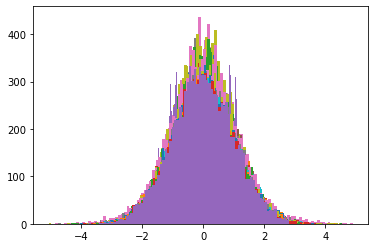

In [1145]:
hub_tables['en'].set_index('reg', drop=False, inplace=True)
from time import sleep
for i, r in hub_tables['en'].iterrows():
    ts = r['t_shuffled']
    
    plt.hist(ts, bins=100)
#     sleep(30)

In [1130]:
hub_tables['en']

reg  \
0                    L amygdala   
1               L angular gyrus   
2    L anterior cingulate gyrus   
3             L basal forebrain   
4            L calcarine cortex   
..                          ...   
75        R supramarginal gyrus   
76              R temporal pole   
77                   R thalamus   
78  R transverse temporal gyrus   
79       R ventral diencephalon   

                                       ppc_successful  \
0   [nan, 0.009311337508569571, 0.0097635162966903...   
1   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2   [nan, nan, nan, nan, nan, 0.011748056506808345...   
3   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
..                                                ...   
75  [0.007091661069124275, nan, nan, 0.01955410022...   
76  [nan, 0.012232361013857449, nan, nan, nan, nan...   
77  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
78  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
79  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                     ppc_unsuccessful  \
0   [nan, 0.010014421049340935, 0.0094328105198447...   
1   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
2   [nan, nan, nan, nan, nan, 0.01520456115669236,...   
3   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
4   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
..                                                ...   
75  [0.006252589875981721, nan, nan, 0.01700297404...   
76  [nan, 0.013934540514819238, nan, nan, nan, nan...   
77  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
78  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
79  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                      ppc_differences  sub_count         t  \
0   [nan, -0.0007030835407713636, 0.00033070577684...        124  3.171178   
1   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         45  0.976066   
2   [nan, nan, nan, nan, nan, -0.00345650464988401...         76  1.719887   
3   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...          0       NaN   
4   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         16  1.946649   
..                                                ...        ...       ...   
75  [0.0008390711931425534, nan, nan, 0.0025511261...        123  0.445876   
76  [nan, -0.0017021795009617893, nan, nan, nan, n...         69  0.909437   
77  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...          3       NaN   
78  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...         20 -1.225856   
79  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...          0       NaN   

                                           t_shuffled     p_fdr    hub  
0   [-0.23437310147409945, 0.11068729668672789, 0....  0.001442   True  
1   [1.1363478465956318, 0.805206677445889, 0.2953...  0.275149  False  
2   [1.1563764938492036, -0.737050542119734, -0.96...  0.071655  False  
3                                                  []       NaN  False  
4   [-0.25903348080138766, -0.6304627453653824, 0....  0.043472   True  
..                                                ...       ...    ...  
75  [-1.3229687520706745, 0.2424546096310255, 0.14...  0.537364  False  
76  [0.027763508187448896, 1.6138169707840297, 0.7...  0.303674  False  
77                                                 []       NaN  False  
78  [-1.3913212869724476, 0.913389239812065, 1.625...  0.184642  False  
79                                                 []       NaN  False  

[80 rows x 9 columns]

In [ ]:
en_pop_symx = xr.open_dataarray(

### Network map visualization

## MTL and hippocampus

In [159]:
display_all()
regions_lobes_df=pd.read_csv(join(root_dir, 'regions_lobes_df.csv')).set_index('region')
regions_lobes_df

lobe
region                              
amygdala                         MTL
angular gyrus               parietal
anterior cingulate gyrus         PFC
basal forebrain                  NaN
calcarine cortex                 NaN
caudate nucleus                  NaN
cuneus                           NaN
frontal pole                     PFC
frontoparietal operculum         NaN
fusiform gyrus                   NaN
hippocampus                      MTL
inferior frontal gyrus           PFC
inferior parietal lobule    parietal
inferior temporal gyrus          LTC
insula                           NaN
lateral occipital cortex         NaN
lentiform nucleus                NaN
lingual gyrus                    NaN
medial frontal cortex            PFC
middle cingulate gyrus           NaN
middle frontal gyrus             PFC
middle temporal gyrus            LTC
orbitofrontal cortex             PFC
paracentral lobule               NaN
parahippocampal gyrus            MTL
postcentral gyrus                NaN
posterior cingulate gyrus   parietal
precentral gyrus                 NaN
precuneus                   parietal
rectal gyrus                     PFC
subcallosal area                 NaN
superior frontal gyrus           PFC
superior parietal lobule    parietal
superior temporal gyrus          LTC
supplementary motor cortex       NaN
supramarginal gyrus         parietal
temporal pole                    LTC
thalamus                         NaN
transverse temporal gyrus        LTC
ventral diencephalon             NaN

In [164]:
regions_lobes_df.query('lobe == "MTL"')

lobe
region                    
amygdala               MTL
hippocampus            MTL
parahippocampal gyrus  MTL

In [166]:
regions_lobes_df.query('lobe == "LTC"')

lobe
region                        
inferior temporal gyrus    LTC
middle temporal gyrus      LTC
superior temporal gyrus    LTC
temporal pole              LTC
transverse temporal gyrus  LTC

In [167]:
regions_lobes_df.query('lobe == "PFC"')

lobe
region                       
anterior cingulate gyrus  PFC
frontal pole              PFC
inferior frontal gyrus    PFC
medial frontal cortex     PFC
middle frontal gyrus      PFC
orbitofrontal cortex      PFC
rectal gyrus              PFC
superior frontal gyrus    PFC

In [168]:
regions_lobes_df.query('lobe == "parietal"')

lobe
region                             
angular gyrus              parietal
inferior parietal lobule   parietal
posterior cingulate gyrus  parietal
precuneus                  parietal
superior parietal lobule   parietal
supramarginal gyrus        parietal

In [169]:
regions_lobes_df[pd.isna(regions_lobes_df['lobe'])]

lobe
region                         
basal forebrain             NaN
calcarine cortex            NaN
caudate nucleus             NaN
cuneus                      NaN
frontoparietal operculum    NaN
fusiform gyrus              NaN
insula                      NaN
lateral occipital cortex    NaN
lentiform nucleus           NaN
lingual gyrus               NaN
middle cingulate gyrus      NaN
paracentral lobule          NaN
postcentral gyrus           NaN
precentral gyrus            NaN
subcallosal area            NaN
supplementary motor cortex  NaN
thalamus                    NaN
ventral diencephalon        NaN

### Analyze lobes

In [172]:
regions_to_lobes = {}
for lobe in ['MTL', 'LTC', 'PFC', 'parietal']:
    regions_to_lobes[lobe] = regions_lobes_df.query('lobe == @lobe').index.values

In [173]:
for k in regions_to_lobes.keys():
    regions_to_lobes[k] = [i + ' ' + j for i in ['L', 'R'] for j in regions_to_lobes[k]]

In [174]:
regions_to_lobes

{'MTL': ['L amygdala',
  'L hippocampus',
  'L parahippocampal gyrus',
  'R amygdala',
  'R hippocampus',
  'R parahippocampal gyrus'],
 'LTC': ['L inferior temporal gyrus',
  'L middle temporal gyrus',
  'L superior temporal gyrus',
  'L temporal pole',
  'L transverse temporal gyrus',
  'R inferior temporal gyrus',
  'R middle temporal gyrus',
  'R superior temporal gyrus',
  'R temporal pole',
  'R transverse temporal gyrus'],
 'PFC': ['L anterior cingulate gyrus',
  'L frontal pole',
  'L inferior frontal gyrus',
  'L medial frontal cortex',
  'L middle frontal gyrus',
  'L orbitofrontal cortex',
  'L rectal gyrus',
  'L superior frontal gyrus',
  'R anterior cingulate gyrus',
  'R frontal pole',
  'R inferior frontal gyrus',
  'R medial frontal cortex',
  'R middle frontal gyrus',
  'R orbitofrontal cortex',
  'R rectal gyrus',
  'R superior frontal gyrus'],
 'parietal': ['L angular gyrus',
  'L inferior parietal lobule',
  'L posterior cingulate gyrus',
  'L precuneus',
  'L supe

In [177]:
for k in regions_to_lobes.keys():
    assert len(regions_to_lobes[k]) == 2*len(regions_lobes_df.query('lobe == @k'))
print('Check passed.')

Check passed.


In [188]:
lobes = pd.Series({})
for beh in ['en', 'rm', 'ri']:
    mx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean('epoch').mean('freq')
    mx = mx.sel(success=1) - mx.sel(success=0)
    lobes_df = pd.DataFrame()
    
    for lobe in ['LTC', 'PFC', 'parietal']:
        MTL_mx = mx.sel(reg1 = regions_to_lobes['MTL'], reg2 = [reg for reg in mx.reg2.values if reg not in regions_to_lobes[lobe]]).mean('reg2').mean('reg1').data
        lobe2_mx = mx.sel(reg1 = regions_to_lobes[lobe], reg2 = [reg for reg in mx.reg2.values if reg not in regions_to_lobes['MTL']]).mean('reg2').mean('reg1').data
        where_finite = np.isfinite(MTL_mx) & np.isfinite(lobe2_mx)
        MTL_mx = MTL_mx[where_finite]
        lobe2_mx = lobe2_mx[where_finite]
        
        t, p = scipy.stats.ttest_rel(MTL_mx, lobe2_mx, alternative='two-sided')
        lobes_df.loc[lobe, 'dof'] = len(MTL_mx) - 1
        lobes_df.loc[lobe, 't'] = t
        lobes_df.loc[lobe, 'p'] = p
        
    lobes[beh] = lobes_df

In [189]:
from statsmodels.stats import multitest

In [190]:
for beh in ['en', 'rm', 'ri']: lobes[beh]['p_fwe'] = multitest.multipletests(pvals=lobes[beh]['p'].values,method='holm')[1]

In [191]:
lobes['en']

dof         t         p     p_fwe
LTC       295.0 -1.412917  0.158734  0.476203
PFC       263.0  0.870085  0.385047  0.770095
parietal  242.0  0.776979  0.437930  0.770095

In [192]:
lobes['rm']

dof         t         p     p_fwe
LTC       295.0  0.849233  0.396440  0.457216
PFC       263.0  1.206762  0.228608  0.457216
parietal  242.0  3.769381  0.000206  0.000617

In [193]:
lobes['ri']

dof         t         p     p_fwe
LTC       132.0 -0.154991  0.877065  1.000000
PFC       117.0  1.015467  0.311979  0.935936
parietal  106.0  0.310911  0.756479  1.000000

In [178]:
mx_fname = os.path.join(root_dir, 'en_pop_symx.nc')
mx = xr.open_dataarray(mx_fname).mean('epoch').mean('freq')
mx = mx.sel(success=1) - mx.sel(success=0)

In [183]:
lobe1 = ['L hippocampus', 'R hippocampus', 'L amygdala', 'R amygdala', 'L parahippocampal gyrus', 'R parahippocampal gyrus']
lobe1_C = [reg for reg in get_region_information('region_labels') if reg not in lobe1]
assert len(get_region_information('region_labels')) == len(lobe1) + len(lobe1_C)
assert len(np.intersect1d(lobe1, lobe1_C)) == 0

lobe2 = ['L inferior temporal gyrus', 'L middle temporal gyrus', 'L superior temporal gyrus', 'L transverse temporal gyrus', 'L temporal pole', 'R inferior temporal gyrus', 'R middle temporal gyrus', 'R superior temporal gyrus', 'R transverse temporal gyrus', 'R temporal pole']
lobe2_C = [reg for reg in get_region_information('region_labels') if reg not in lobe2]
assert len(get_region_information('region_labels')) == len(lobe2) + len(lobe2_C)
assert len(np.intersect1d(lobe2, lobe2_C)) == 0

print('Check passed.')

Check passed.


In [185]:
MTL_mean_hubness = mx.sel(reg1 = lobe1, reg2 = lobe2_C).mean('reg2').mean('reg1').data
LTC_mean_hubness = mx.sel(reg1 = lobe2, reg2 = lobe1_C).mean('reg2').mean('reg1').data
where_finite = np.isfinite(MTL_mean_hubness) & np.isfinite(LTC_mean_hubness)
MTL_mean_hubness = MTL_mean_hubness[where_finite]
LTC_mean_hubness = LTC_mean_hubness[where_finite]

In [196]:
assert scipy.stats.ttest_rel(MTL_mean_hubness, LTC_mean_hubness)[0] == lobes['en'].loc['LTC', 't']
assert len(MTL_mean_hubness) == len(LTC_mean_hubness) == lobes['en'].loc['LTC', 'dof'] + 1
print('Check passed.')

Check passed.


In [211]:
p_values = lobes['en']['p'].values
sorting_order = np.argsort(p_values)
p_values_sorted = p_values[sorting_order]
p_values_corrected = lobes['en']['p_fwe'].values[sorting_order]
m = len(p_values)
alpha = 0.05
adjusted_p_tracker = []
for k, p_value in enumerate(p_values_sorted):
    j = k+1
    adjusted_p_tracker.append((m-j+1)*p_value)
    assert np.max(adjusted_p_tracker[:j]) == p_values_corrected[k]
print('Check passed.')

Check passed.


### Hippocampus and PFC

In [222]:
hippocampus_PFC = pd.Series({})
for beh in ['en', 'rm', 'ri']:
    hippocampus_PFC_df = pd.DataFrame()
    mx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean('epoch').mean('freq')
    mx = mx.sel(success=1) - mx.sel(success=0)
    MFG = finitize(mx.sel(reg1 = ['L hippocampus', 'R hippocampus'], reg2 = ['L middle frontal gyrus', 'R middle frontal gyrus']).mean('reg2').mean('reg1').data)
    mPFC = finitize(mx.sel(reg1 = ['L hippocampus', 'R hippocampus'], reg2 = ['L medial frontal cortex', 'R medial frontal cortex',
                                                                     'L anterior cingulate gyrus', 'R anterior cingulate gyrus']).mean('reg2').mean('reg1').data)
    hippocampus_PFC_df.loc['dlPFC', 'dof'] = len(MFG) - 1
    hippocampus_PFC_df.loc['mPFC', 'dof'] = len(mPFC) - 1

    hippocampus_PFC_df.loc['dlPFC', ['t', 'p']] = scipy.stats.ttest_1samp(MFG, popmean=0)[:]
    hippocampus_PFC_df.loc['mPFC', ['t', 'p']] = scipy.stats.ttest_1samp(mPFC, popmean=0)[:]
    hippocampus_PFC_df.loc[['dlPFC', 'mPFC'], 'p_fwe'] = multitest.multipletests(pvals=hippocampus_PFC_df.loc[['dlPFC', 'mPFC'], 'p'].values, method='holm')[1]
    hippocampus_PFC[beh] = hippocampus_PFC_df

In [223]:
hippocampus_PFC['en']

dof         t         p     p_fwe
dlPFC  191.0  0.188965  0.850321  0.850321
mPFC    92.0  2.562512  0.012016  0.024032

In [224]:
hippocampus_PFC['rm']

dof         t         p     p_fwe
dlPFC  191.0  0.895630  0.371578  0.371578
mPFC    92.0  2.082535  0.040069  0.080138

In [225]:
hippocampus_PFC['ri']

dof         t         p  p_fwe
dlPFC  81.0  0.321069  0.748985    1.0
mPFC   34.0  0.641289  0.525635    1.0

In [226]:
mx_fname = os.path.join(root_dir, 'en_pop_symx.nc')
mx = xr.open_dataarray(mx_fname).mean('epoch').mean('freq')
mx = mx.sel(success=1) - mx.sel(success=0)

In [227]:
HPC_regions = ['L hippocampus', 'R hippocampus']
dlPFC_regions = ['L middle frontal gyrus', 'R middle frontal gyrus']
mPFC_regions = ['L anterior cingulate gyrus', 'R anterior cingulate gyrus', 'L medial frontal cortex', 'R medial frontal cortex']

In [233]:
mx_dlPFC = finitize(mx.sel(reg1 = HPC_regions, reg2 = dlPFC_regions).mean('reg2').mean('reg1').data)
mx_mPFC = finitize(mx.sel(reg1 = HPC_regions, reg2 = mPFC_regions).mean('reg2').mean('reg1').data)

In [234]:
assert scipy.stats.ttest_1samp(mx_dlPFC, 0)[0] == hippocampus_PFC['en'].loc['dlPFC', 't']
assert len(mx_dlPFC) == hippocampus_PFC['en'].loc['dlPFC', 'dof'] + 1
assert scipy.stats.ttest_1samp(mx_mPFC, 0)[0] == hippocampus_PFC['en'].loc['mPFC', 't']
assert len(mx_mPFC) == hippocampus_PFC['en'].loc['mPFC', 'dof'] + 1
print('Check passed.')

Check passed.


In [237]:
p_values_sorted

array([0.01201582, 0.85032077])

In [240]:
p_values = hippocampus_PFC['en']['p'].values
sorting_order = np.argsort(p_values)
p_values_sorted = p_values[sorting_order]
p_values_corrected = hippocampus_PFC['en']['p_fwe'].values[sorting_order]
m = len(p_values)
alpha = 0.05
adjusted_p_tracker = []
for k, p_value in enumerate(p_values_sorted):
    j = k+1
    adjusted_p_tracker.append((m-j+1)*p_value)
    assert np.max(adjusted_p_tracker[:j]) == p_values_corrected[k]
print('Check passed.')

Check passed.


## Encoding-retrieval correlation

In [393]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

Length of sess_list_df: 980


sub  exp  sess  loc  mon atlas contacts_source  \
sub    exp sess loc mon                                                      
R1001P FR1 0    0   0    R1001P  FR1     0    0    0   avg        contacts   
           1    0   0    R1001P  FR1     1    0    0   avg        contacts   
R1002P FR1 0    0   0    R1002P  FR1     0    0    0   avg        contacts   
           1    0   0    R1002P  FR1     1    0    0   avg        contacts   
R1003P FR1 0    0   0    R1003P  FR1     0    0    0   avg        contacts   

                          eeg eeg_data_source  eeg_error evs_data_source  \
sub    exp sess loc mon                                                    
R1001P FR1 0    0   0    True      cmlreaders        NaN      cmlreaders   
           1    0   0    True      cmlreaders        NaN      cmlreaders   
R1002P FR1 0    0   0    True      cmlreaders        NaN      cmlreaders   
           1    0   0    True      cmlreaders        NaN      cmlreaders   
R1003P FR1 0    0   0    True      cmlreaders        NaN      cmlreaders   

                         localization  long_distance_pairs_count  \
sub    exp sess loc mon                                            
R1001P FR1 0    0   0               0                          0   
           1    0   0               0                          0   
R1002P FR1 0    0   0               0                          0   
           1    0   0               0                          0   
R1003P FR1 0    0   0               0                          0   

                         mat_pairs_available  no_channels  \
sub    exp sess loc mon                                     
R1001P FR1 0    0   0                      1           72   
           1    0   0                      1           72   
R1002P FR1 0    0   0                      1           58   
           1    0   0                      1           58   
R1003P FR1 0    0   0                      1          114   

                         nonempty_regionalizations_count  pairs  pairs_count  \
sub    exp sess loc mon                                                        
R1001P FR1 0    0   0                                 72   True           72   
           1    0   0                                 72   True           72   
R1002P FR1 0    0   0                                 58   True           58   
           1    0   0                                 58   True           58   
R1003P FR1 0    0   0                                114   True          114   

                        pairs_data_source  phase  regionalizations  \
sub    exp sess loc mon                                              
R1001P FR1 0    0   0          cmlreaders   True              True   
           1    0   0          cmlreaders   True              True   
R1002P FR1 0    0   0          cmlreaders   True              True   
           1    0   0          cmlreaders   True              True   
R1003P FR1 0    0   0          cmlreaders   True              True   

                         regionalizations_count     sr  sr_present  include  \
sub    exp sess loc mon                                                       
R1001P FR1 0    0   0                        72  500.0        True     True   
           1    0   0                        72  500.0        True     True   
R1002P FR1 0    0   0                        58  500.0        True     True   
           1    0   0                        58  500.0        True     True   
R1003P FR1 0    0   0                       114  500.0        True     True   

                         en_events  en_all_events  rm_events  ri_events  \
sub    exp sess loc mon                                                   
R1001P FR1 0    0   0         True           True       True       True   
           1    0   0         True           True       True       True   
R1002P FR1 0    0   0         True           True       True      False   
           1    0   0         True           True       True  

In [394]:
sublist = sess_list_df['sub'].unique() # Get list of unique subject codes
print(f'There are {len(sublist)} analyzed subjects.')
print(sublist) # Print the list of unique subject codes

There are 378 analyzed subjects.
['R1001P' 'R1002P' 'R1003P' 'R1006P' 'R1010J' 'R1013E' 'R1016M' 'R1018P'
 'R1020J' 'R1021D' 'R1022J' 'R1024E' 'R1026D' 'R1028M' 'R1030J' 'R1031M'
 'R1032D' 'R1033D' 'R1035M' 'R1036M' 'R1039M' 'R1042M' 'R1045E' 'R1048E'
 'R1050M' 'R1051J' 'R1052E' 'R1053M' 'R1054J' 'R1056M' 'R1060M' 'R1061T'
 'R1062J' 'R1063C' 'R1065J' 'R1066P' 'R1067P' 'R1068J' 'R1069M' 'R1070T'
 'R1074M' 'R1075J' 'R1076D' 'R1077T' 'R1080E' 'R1083J' 'R1084T' 'R1089P'
 'R1092J' 'R1093J' 'R1094T' 'R1096E' 'R1098D' 'R1101T' 'R1102P' 'R1104D'
 'R1105E' 'R1106M' 'R1107J' 'R1108J' 'R1111M' 'R1112M' 'R1113T' 'R1114C'
 'R1115T' 'R1118N' 'R1120E' 'R1121M' 'R1122E' 'R1123C' 'R1124J' 'R1125T'
 'R1127P' 'R1128E' 'R1129D' 'R1130M' 'R1131M' 'R1134T' 'R1135E' 'R1136N'
 'R1137E' 'R1138T' 'R1141T' 'R1144E' 'R1145J' 'R1146E' 'R1147P' 'R1148P'
 'R1149N' 'R1150J' 'R1151E' 'R1153T' 'R1154D' 'R1156D' 'R1157C' 'R1161E'
 'R1162N' 'R1163T' 'R1164E' 'R1166D' 'R1167M' 'R1168T' 'R1169P' 'R1170J'
 'R1172E' 'R1173J'

### Event splitting and matrix computations

In [97]:
sess_idx = 0
beh = 'rm'
beh_split = f'{beh}_split' # value must equal either 'rm_split' or 'ri_split'
# half = 'a' # value must equal either 'a' or 'b'

dfrow = sess_list_df.iloc[sess_idx]
events = load_events(dfrow, beh).sort_values(['mstime', 'eegoffset'])
split_events_a_path = join(root_dir, beh_split, 'a', 'events', f'{ftag(dfrow)}_{beh}_events_split_a.json')
split_events_a = pd.read_json(split_events_a_path)
split_events_b_path = join(root_dir, beh_split, 'b', 'events', f'{ftag(dfrow)}_{beh}_events_split_b.json')
split_events_b = pd.read_json(split_events_b_path)

In [98]:
split_events_joined = pd.concat([split_events_a, split_events_b]).sort_values(['mstime', 'eegoffset']).drop('pair_idx', axis=1)
assert split_events_joined.equals(events)

In [99]:
match_cols = ['mstime', 'eegoffset', 'type']
events = load_events(dfrow, beh)
events_to_match = events[match_cols]
split_events_a_to_match = split_events_a[match_cols]
split_events_b_to_match = split_events_b[match_cols]
for i in np.arange(len(events_to_match)//2):
    event_pair = events_to_match.iloc[2*i:(2*i+2)]
    together = False
    assert ( event_pair.isin(split_events_a_to_match).all().all() | event_pair.isin(split_events_b_to_match).all().all())
print('Checks passed.')

Checks passed.


In [100]:
split_events_a.attrs['mask'] = (split_events_a['type'] == 'REC_WORD').values
split_events_a.attrs['beh'] = beh

In [101]:
iElec1, iElec2 = 5, 10
iFreq = 0
iEpoch = 0
iSuccess = 0

In [102]:
eeg, mask = get_eeg(dfrow, split_events_a, -1000, 0)
eeg = mirror_buffer(eeg, 1000)
eeg = eeg.resampled(250)
eeg = notch_filter(eeg, dfrow['sub'])
phase = get_phase(eeg, np.arange(3, 9))
phase = clip_buffer(phase, 250)
phase_diff = phase.isel(channel = iElec1) - phase.isel(channel = iElec2)
phase_diff = timebin_phase_timeseries(phase_diff.data, 250)
phase_diff = phase_diff[:, iFreq, iEpoch]
ppc_value = ppc(phase_diff[mask])

CPP total time wavelet loop:  0.5323333740234375


In [103]:
reference_elsymx_fname = join(root_dir, 'rm_split', 'a', 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
reference_elsymx = npl(reference_elsymx_fname)
rtol = 1e-5
atol = 1e-8
assert np.isclose(ppc_value, reference_elsymx[iElec1, iElec2, iFreq, iEpoch, iSuccess], rtol=rtol, atol=atol)
print('Check passed.')

Check passed.


### Correlation computation and aggregation

In [420]:
beh1, beh2 = 'en', 'rm'
all_rs = []
for sub in sublist: # Iterate through all subjects
    
    this_sub_sesslist = sess_list_df.query('sub == @sub') # Get the list of all sessions 
    this_sub_rs = [] # Initialize list to hold this subject's correlation values
    for iSess, rSess in this_sub_sesslist.iterrows(): # Iterate through all this subject's sessions
        
        dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
        pairs = get_pairs(dfrow)
        mx1_fname = os.path.join(root_dir, beh1, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
        mx2_fname = os.path.join(root_dir, beh2, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
        
        mx1 = npl(mx1_fname)
        mx2 = npl(mx2_fname)
        assert not np.allclose(mx1, mx2, rtol=1e-5, atol=1e-8) # Make sure taht we did not accidentally mix up mx1 and mx2
        
        for mx in [mx1, mx2]:
#             assert mx.shape == (len(pairs), len(pairs), 6, 5, 2)
            assert np.nanmax(mx) <= 1, f'{np.max(mx)}'
            assert np.nanmin(mx) >= -1
            assert np.allclose(mx, np.swapaxes(mx, 0, 1), equal_nan=True)
            finite_count = count_finite(mx) # Get fraction of electrode synchrony matrix that is not a nan value
            assert finite_count > 0.8, f'{tuple(dfrow)}: {finite_count}, {len(pairs)}' # Check that the fraction of electrode synchrony matrix is above an arbitrary threshold, 0.9
            assert not np.any(np.isfinite(np.diagonal(mx))) 
            
        assert np.allclose(np.isfinite(mx1), np.isfinite(mx2))
        
#         for mx in [mx1, mx2]:
#             mx = np.subtract(mx[..., 0], mx[..., 1]) # Calculate ΔPPC by subtracting unsuccessful PPC values from PPC successful values
# #             assert mx.shape == (len(pairs), len(pairs), 6, 5) # Check that the electrode synchrony matrix has lost the last successful/unsuccessful dimension after subtraction

#             mx = np.nanmean(mx, axis=-1) # Average electrode synchrony matrix over time epochs
# #             assert mx.shape == (len(pairs), len(pairs), 6) # Check that the electrode synchrony matrix has lost the last time epoch dimension after averaging

#             mx = np.nanmean(mx, axis=-1) # Average electrode synchrony matrix over theta frequencies
# #             assert mx.shape == (len(pairs), len(pairs)) # Check that the electrode synchrony matrix has lost the last frequency dimension after averaging

#             mx = np.nanmean(mx, axis=-1) # Average electrode synchrony matrix over contact 2 to obtain contact-level hubness scores
# #             assert len(mx) == len(pairs), f'{mx.shape}' # Check that the electrode synchrony matrix has lost the last contact dimension after averaging

#             assert np.all(np.isfinite(mx)) # Check that the hubness matrix has no nan values
#             assert len(mx) >= 10, 'length of electrode synchrony hubness matrix is less than 10' # Check that there at least 10 contacts for the correlation 

        mx1 = mx1[..., 0]-mx1[..., 1]
        mx1 = np.nanmean(np.nanmean(np.nanmean(mx1, axis=-1), axis=-1), axis=-1)
        mx2 = mx2[..., 0]-mx2[..., 1]
        mx2 = np.nanmean(np.nanmean(np.nanmean(mx2, axis=-1), axis=-1), axis=-1)
        
        where_finite = np.isfinite(mx1) & np.isfinite(mx2)
        assert np.allclose(where_finite, np.isfinite(mx1))
        assert np.allclose(where_finite, np.isfinite(mx2))
        mx1 = mx1[where_finite]
        mx2 = mx2[where_finite]
        assert not np.allclose(mx1, mx2, rtol=1e-5, atol=1e-8) # Make sure that we did not accidentally mix up mx1 and mx2
        
        r = scipy.stats.pearsonr(mx1, mx2)[0]
        assert -1 <= r <= 1
        this_sub_rs.append(r)
        
    assert len(this_sub_rs) == len(this_sub_sesslist)
    this_sub_mean_r = np.mean(this_sub_rs)
    all_rs.append(this_sub_mean_r)
    
all_rs = np.asarray(all_rs)

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice


In [421]:
t, p = scipy.stats.ttest_1samp(all_rs,0)
print(f't_{len(all_rs)-1} = {t}, p = {p}')

t_377 = 5.489211992850639, p = 7.428226963553986e-08


In [423]:
np.mean(all_rs)

0.03996501261980553

In [417]:
def apply_spearman_brown_correction(r): return (2*r)/(1+r)

def compute_intercontrast_correlations(beh1, beh2):
    
    if ('ri' in beh1) or ('ri' in beh2): sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
    else: sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
    
    sub_list = sess_list_df['sub'].unique()
    
    sub_corrs = []
    
    for iSub, sub in enumerate(sub_list):
        
        sess_corrs = []
        
        for iSess, rSess in sess_list_df.query('sub == @sub').iterrows():
            
            dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
            beh1_mx = npl(join(root_dir, beh1, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy'))
            beh2_mx = npl(join(root_dir, beh2, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy'))
    
            beh1_mx = beh1_mx[..., 0] - beh1_mx[..., 1]
            beh2_mx = beh2_mx[..., 0] - beh2_mx[..., 1]
            
            beh1_mx = np.nanmean(np.nanmean(np.nanmean(beh1_mx, axis=-1), axis=-1), axis=-1)
            beh2_mx = np.nanmean(np.nanmean(np.nanmean(beh2_mx, axis=-1), axis=-1), axis=-1)
            
            r = scipy.stats.pearsonr(beh1_mx, beh2_mx)[0]
            if (beh1, beh2) in [('rm_split/a', 'rm_split/b'), ('rm_split/a', 'rm_split/b')]: 
                r = apply_spearman_brown_correction(r)

            sess_corrs.append(r)
            
        sub_corrs.append(np.mean(sess_corrs))
        
    return np.asarray(sub_corrs)
        

In [418]:
en_rm_sub_corrs = compute_intercontrast_correlations('en', 'rm')
print_ttest_1samp(en_rm_sub_corrs, header='en / rm correlation')

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


---------en / rm correlation---------
Statistically Significant (p < 0.05)
t_377 = 5.49, p = 7.43e-08, Mean: 0.04 ± 0.00728


(5.489211992850639, 7.428226963553986e-08)

In [416]:
np.mean(all_rs)

0.3778708008745583

In [402]:
count_finite(mx)

(0.9645061728395061,)

In [400]:
count_finite?

Signature: count_finite(x)
Docstring: <no docstring>
File:      ~/ConnectivityProject/matrix_operations.py
Type:      function


## Power-synchrony correlation

In [426]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

Length of sess_list_df: 980


sub  exp  sess  loc  mon atlas contacts_source  \
sub    exp sess loc mon                                                      
R1001P FR1 0    0   0    R1001P  FR1     0    0    0   avg        contacts   
           1    0   0    R1001P  FR1     1    0    0   avg        contacts   
R1002P FR1 0    0   0    R1002P  FR1     0    0    0   avg        contacts   
           1    0   0    R1002P  FR1     1    0    0   avg        contacts   
R1003P FR1 0    0   0    R1003P  FR1     0    0    0   avg        contacts   

                          eeg eeg_data_source  eeg_error evs_data_source  \
sub    exp sess loc mon                                                    
R1001P FR1 0    0   0    True      cmlreaders        NaN      cmlreaders   
           1    0   0    True      cmlreaders        NaN      cmlreaders   
R1002P FR1 0    0   0    True      cmlreaders        NaN      cmlreaders   
           1    0   0    True      cmlreaders        NaN      cmlreaders   
R1003P FR1 0    0   0    True      cmlreaders        NaN      cmlreaders   

                         localization  long_distance_pairs_count  \
sub    exp sess loc mon                                            
R1001P FR1 0    0   0               0                          0   
           1    0   0               0                          0   
R1002P FR1 0    0   0               0                          0   
           1    0   0               0                          0   
R1003P FR1 0    0   0               0                          0   

                         mat_pairs_available  no_channels  \
sub    exp sess loc mon                                     
R1001P FR1 0    0   0                      1           72   
           1    0   0                      1           72   
R1002P FR1 0    0   0                      1           58   
           1    0   0                      1           58   
R1003P FR1 0    0   0                      1          114   

                         nonempty_regionalizations_count  pairs  pairs_count  \
sub    exp sess loc mon                                                        
R1001P FR1 0    0   0                                 72   True           72   
           1    0   0                                 72   True           72   
R1002P FR1 0    0   0                                 58   True           58   
           1    0   0                                 58   True           58   
R1003P FR1 0    0   0                                114   True          114   

                        pairs_data_source  phase  regionalizations  \
sub    exp sess loc mon                                              
R1001P FR1 0    0   0          cmlreaders   True              True   
           1    0   0          cmlreaders   True              True   
R1002P FR1 0    0   0          cmlreaders   True              True   
           1    0   0          cmlreaders   True              True   
R1003P FR1 0    0   0          cmlreaders   True              True   

                         regionalizations_count     sr  sr_present  include  \
sub    exp sess loc mon                                                       
R1001P FR1 0    0   0                        72  500.0        True     True   
           1    0   0                        72  500.0        True     True   
R1002P FR1 0    0   0                        58  500.0        True     True   
           1    0   0                        58  500.0        True     True   
R1003P FR1 0    0   0                       114  500.0        True     True   

                         en_events  en_all_events  rm_events  ri_events  \
sub    exp sess loc mon                                                   
R1001P FR1 0    0   0         True           True       True       True   
           1    0   0         True           True       True       True   
R1002P FR1 0    0   0         True           True       True      False   
           1    0   0         True           True       True  

In [427]:
sublist = sess_list_df['sub'].unique() # Get list of unique subject codes
print(f'There are {len(sublist)} analyzed subjects.')
print(sublist) # Print the list of unique subject codes

There are 378 analyzed subjects.
['R1001P' 'R1002P' 'R1003P' 'R1006P' 'R1010J' 'R1013E' 'R1016M' 'R1018P'
 'R1020J' 'R1021D' 'R1022J' 'R1024E' 'R1026D' 'R1028M' 'R1030J' 'R1031M'
 'R1032D' 'R1033D' 'R1035M' 'R1036M' 'R1039M' 'R1042M' 'R1045E' 'R1048E'
 'R1050M' 'R1051J' 'R1052E' 'R1053M' 'R1054J' 'R1056M' 'R1060M' 'R1061T'
 'R1062J' 'R1063C' 'R1065J' 'R1066P' 'R1067P' 'R1068J' 'R1069M' 'R1070T'
 'R1074M' 'R1075J' 'R1076D' 'R1077T' 'R1080E' 'R1083J' 'R1084T' 'R1089P'
 'R1092J' 'R1093J' 'R1094T' 'R1096E' 'R1098D' 'R1101T' 'R1102P' 'R1104D'
 'R1105E' 'R1106M' 'R1107J' 'R1108J' 'R1111M' 'R1112M' 'R1113T' 'R1114C'
 'R1115T' 'R1118N' 'R1120E' 'R1121M' 'R1122E' 'R1123C' 'R1124J' 'R1125T'
 'R1127P' 'R1128E' 'R1129D' 'R1130M' 'R1131M' 'R1134T' 'R1135E' 'R1136N'
 'R1137E' 'R1138T' 'R1141T' 'R1144E' 'R1145J' 'R1146E' 'R1147P' 'R1148P'
 'R1149N' 'R1150J' 'R1151E' 'R1153T' 'R1154D' 'R1156D' 'R1157C' 'R1161E'
 'R1162N' 'R1163T' 'R1164E' 'R1166D' 'R1167M' 'R1168T' 'R1169P' 'R1170J'
 'R1172E' 'R1173J'

In [433]:
beh = 'en' # Set behavioral contrast (encoding)
all_rs = []
for sub in sublist: # Iterate through all subjects
    
    this_sub_sesslist = sess_list_df.query('sub == @sub') # Get list of sessions that this subject (i.e., the subject on the current for-loop iteration) completed
    this_sub_session_count = len(this_sub_sesslist)
    this_sub_rs = [] # Initialize list to contain the correlation values calculated for each of this subject's sessions
    for iSess, rSess in this_sub_sesslist.iterrows(): # Iterate through all this subject's sessions
        
        dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']] # Get dfrow that labels this session 
        pairs = get_pairs(dfrow)
        elsymx_fname = os.path.join(root_dir, beh, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy') # Set electrode synchrony matrix file name
        elpomx_fname = os.path.join(root_dir, beh, 'elpomxs', 'theta', f'{ftag(dfrow)}_elpomxd.npy') # Set electrode power change matrix file name
        assert os.path.exists(elsymx_fname), 'elsymx path does not exist' # Verify that electrode synchrony matrix file path exists
        assert os.path.exists(elpomx_fname), 'elpomx path does not exist' # Verify that electrode power change matrix file path exists
        
        elsymx = np.load(elsymx_fname, allow_pickle=True) # Load electrode synchrony matrix into memory
#         assert elsymx.shape == (len(pairs), len(pairs), 6, 5, 2) # Check that elsymx is the right shape (number of pairs x number of pairs x frequencies x epochs x successful/unsuccessful)
        assert np.nanmax(elsymx) <= 1 # Check that PPC values in electrode synchrony matrix are bounded above by 1
        assert np.nanmin(elsymx) >= -1 # Check that PPC values in electrode synchrony matrix are bounded below by -1
        assert np.allclose(elsymx, np.swapaxes(elsymx, 0, 1), equal_nan=True) # Check that electrode synchrony matrix is symmetric
        finite_count = count_finite(elsymx), # Get fraction of electrode synchrony matrix that is not a nan value
#         assert finite_count > 0.8 # Check that the fraction of electrode synchrony matrix is above an arbitrary threshold, 0.9
        assert not np.any(np.isfinite(np.diagonal(elsymx))) # Check that the diagonal of the electrode synchrony matrix consists of nan values
        
        elsymx = np.subtract(elsymx[..., 0], elsymx[..., 1]) # Calculate ΔPPC by subtracting unsuccessful PPC values from PPC successful values
#         assert elsymx.shape == (len(pairs), len(pairs), 6, 5) # Check that the electrode synchrony matrix has lost the last successful/unsuccessful dimension after subtraction
        
        elsymx = np.nanmean(elsymx, axis=-1) # Average electrode synchrony matrix over time epochs
#         assert elsymx.shape == (len(pairs), len(pairs), 6) # Check that the electrode synchrony matrix has lost the last time epoch dimension after averaging
        
        elsymx = np.nanmean(elsymx, axis=-1) # Average electrode synchrony matrix over theta frequencies
#         assert elsymx.shape == (len(pairs), len(pairs)) # Check that the electrode synchrony matrix has lost the last frequency dimension after averaging
        
        elsymx = np.nanmean(elsymx, axis=-1) # Average electrode synchrony matrix over contact 2 to obtain contact-level hubness scores
#         assert elsymx.shape == (len(pairs)) # Check that the electrode synchrony matrix has lost the last contact dimension after averaging
        
        assert np.all(np.isfinite(elsymx)) # Check that the hubness matrix has no nan values
        assert len(elsymx) >= 10, 'length of electrode synchrony hubness matrix is less than 10' # Check that there at least 10 contacts for the correlation 
        
        elpomx = np.load(elpomx_fname, allow_pickle=True) # Load electrode power change matrix into memory
#         assert elpomx.shape == (len(pairs), 6, 5) # Check that the electrode power change matrix is the right shape (number of pairs x frequencies x epochs)
        
        elpomx = np.nanmean(elpomx, axis=-1)
#         assert elpomx.shape == (len(pairs), 6)
        
        elpomx = np.nanmean(elpomx, axis=-1)
#         assert elpomx.shape == (len(pairs))
        
        where_finite = np.isfinite(elsymx) & np.isfinite(elpomx)
        elsymx = elsymx[where_finite]
        elpomx = elpomx[where_finite]
        
        r = scipy.stats.pearsonr(elsymx, elpomx)[0]
        assert -1 <= r <= 1
        
        this_sub_rs.append(r)
    
    assert len(this_sub_rs) == this_sub_session_count
    
    this_sub_mean_r = np.mean(this_sub_rs)
    all_rs.append(this_sub_mean_r)
        
all_rs = np.asarray(all_rs)

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice


In [435]:
t, p = scipy.stats.ttest_1samp(all_rs,0)
print(f't_{len(all_rs)-1} = {t}, p = {p}')

t_377 = 46.610181926751785, p = 1.483587956891569e-158


In [436]:
np.mean(all_rs)

0.28113625580953294

# Get subject sex

In [394]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

Length of sess_list_df: 980


sub  exp  sess  loc  mon atlas contacts_source  \
sub    exp sess loc mon                                                      
R1001P FR1 0    0   0    R1001P  FR1     0    0    0   avg        contacts   
           1    0   0    R1001P  FR1     1    0    0   avg        contacts   
R1002P FR1 0    0   0    R1002P  FR1     0    0    0   avg        contacts   
           1    0   0    R1002P  FR1     1    0    0   avg        contacts   
R1003P FR1 0    0   0    R1003P  FR1     0    0    0   avg        contacts   

                          eeg eeg_data_source  eeg_error  ... no_matches_rm  \
sub    exp sess loc mon                                   ...                 
R1001P FR1 0    0   0    True      cmlreaders        NaN  ...          19.0   
           1    0   0    True      cmlreaders        NaN  ...          15.0   
R1002P FR1 0    0   0    True      cmlreaders        NaN  ...          46.0   
           1    0   0    True      cmlreaders        NaN  ...          23.0   
R1003P FR1 0    0   0    True      cmlreaders        NaN  ...          23.0   

                         mean_succ_times_rm  mean_unsucc_times_rm  \
sub    exp sess loc mon                                             
R1001P FR1 0    0   0          13339.947368          12390.000000   
           1    0   0           9179.200000           9117.400000   
R1002P FR1 0    0   0          13129.239130          12938.630435   
           1    0   0          11955.956522          11924.826087   
R1003P FR1 0    0   0          13344.086957          12047.043478   

                         no_matches_ri  mean_succ_times_ri  \
sub    exp sess loc mon                                      
R1001P FR1 0    0   0             17.0        13803.588235   
           1    0   0             13.0         9279.384615   
R1002P FR1 0    0   0              NaN                 NaN   
           1    0   0              NaN                 NaN   
R1003P FR1 0    0   0             23.0        13344.086957   

                         mean_unsucc_times_ri  recall_rate  en_match_rate  \
sub    exp sess loc mon                                                     
R1001P FR1 0    0   0            14292.176471     0.206667       0.176667   
           1    0   0            10227.769231     0.210000       0.206667   
R1002P FR1 0    0   0                     NaN     0.390000       0.356667   
           1    0   0                     NaN     0.400000       0.360000   
R1003P FR1 0    0   0            13791.652174     0.325758       0.303030   

                        rm_match_rate  ri_match_rate  
sub    exp sess loc mon                               
R1001P FR1 0    0   0        0.306452       0.274194  
           1    0   0        0.238095       0.206349  
R1002P FR1 0    0   0        0.393162            NaN  
           1    0   0        0.191667            NaN  
R1003P FR1 0    0   0        0.267442       0.267442  

[5 rows x 45 columns]

In [395]:
sublist = sess_list_df['sub'].unique() # Get list of unique subject codes
print(f'There are {len(sublist)} analyzed subjects.')
print(sublist) # Print the list of unique subject codes

There are 378 analyzed subjects.
['R1001P' 'R1002P' 'R1003P' 'R1006P' 'R1010J' 'R1013E' 'R1016M' 'R1018P'
 'R1020J' 'R1021D' 'R1022J' 'R1024E' 'R1026D' 'R1028M' 'R1030J' 'R1031M'
 'R1032D' 'R1033D' 'R1035M' 'R1036M' 'R1039M' 'R1042M' 'R1045E' 'R1048E'
 'R1050M' 'R1051J' 'R1052E' 'R1053M' 'R1054J' 'R1056M' 'R1060M' 'R1061T'
 'R1062J' 'R1063C' 'R1065J' 'R1066P' 'R1067P' 'R1068J' 'R1069M' 'R1070T'
 'R1074M' 'R1075J' 'R1076D' 'R1077T' 'R1080E' 'R1083J' 'R1084T' 'R1089P'
 'R1092J' 'R1093J' 'R1094T' 'R1096E' 'R1098D' 'R1101T' 'R1102P' 'R1104D'
 'R1105E' 'R1106M' 'R1107J' 'R1108J' 'R1111M' 'R1112M' 'R1113T' 'R1114C'
 'R1115T' 'R1118N' 'R1120E' 'R1121M' 'R1122E' 'R1123C' 'R1124J' 'R1125T'
 'R1127P' 'R1128E' 'R1129D' 'R1130M' 'R1131M' 'R1134T' 'R1135E' 'R1136N'
 'R1137E' 'R1138T' 'R1141T' 'R1144E' 'R1145J' 'R1146E' 'R1147P' 'R1148P'
 'R1149N' 'R1150J' 'R1151E' 'R1153T' 'R1154D' 'R1156D' 'R1157C' 'R1161E'
 'R1162N' 'R1163T' 'R1164E' 'R1166D' 'R1167M' 'R1168T' 'R1169P' 'R1170J'
 'R1172E' 'R1173J'

In [396]:
def get_sex(sub):
    
    for fname in [f'/data/eeg/{sub}/docs/readme.txt',
                  f'/data/eeg/{sub}/docs/patient_info.txt']:
        if not ex(fname): continue
        with open(fname, 'r') as file:
            content = file.read().lower()
            
        if ( ('male' in content) | ('gender: m' in content) ):
            return 'M'
        elif ( ('female' in content) | ('gender: f' in content) ):
            return 'F'

    return 'nan'

pyFR_sublist = sess_list_df.query('exp=="pyFR"')['sub'].unique()
pyFR_subjects_sex = pd.DataFrame({'sub': pyFR_sublist})
pyFR_subjects_sex['sex'] = pyFR_subjects_sex.apply(lambda r: get_sex(r['sub']), axis=1)

In [397]:
ram_subjects_sex_path = '/home1/amrao/ConnectivityProject/ram_subjects_sex.csv'
ram_subjects_sex = pd.read_csv(ram_subjects_sex_path)

study_site_codes = {'University of Pennsylvania': 'P',
                    'Dartmouth University': 'D',
                    'Jefferson Hospital': 'J',
                    'University of Washington': '',
                    'Emory University': 'E',
                    'Mayo Clinic': 'M',
                    'UT Southwestern': 'T',
                    'Columbia University': 'C',
                    'NINDS': 'N',
                    'UTHSC San Antonio': 'S',
                    'CU Anschutz': 'A',
                    'Harvard': 'H'}
ram_subjects_sex['sub'] = ram_subjects_sex.apply(lambda r: 'R1' + str(r['Subject Number']).zfill(3) + study_site_codes[r['Study site']], axis=1)
ram_subjects_sex = ram_subjects_sex.query('sub in @sublist')
def get_ram_sex(r):
    
    if r['Gender'] == 'Female': return 'F'
    elif r['Gender'] == 'Male': return 'M'
    else: return 'nan'
ram_subjects_sex['sex'] = ram_subjects_sex.apply(lambda r: get_ram_sex(r), axis=1)
ram_subjects_sex = ram_subjects_sex[['sub', 'sex']]

In [398]:
subjects_sex = pd.concat([ram_subjects_sex, pyFR_subjects_sex])
no_males = np.sum(subjects_sex['sex'] == 'M')
no_females = np.sum(subjects_sex['sex'] == 'F')
no_unavailable = np.sum(subjects_sex['sex'] == 'nan')
print(f'There are\n {no_males} male subjects,\n {no_females} female subjects, and\n {no_unavailable} subject(s) for whom sex information is unavailable.')

There are
 212 male subjects,
 165 female subjects, and
 1 subject(s) for whom sex information is unavailable.
